# 列舉所有資產的riskiness r

In [1]:
import sympy
from pandas import Series,DataFrame
from scipy.optimize import fsolve
import math
import time
import pandas as pd
import numpy  as  np
import os
from datetime import datetime
from dateutil.relativedelta import relativedelta

# 無風險利率
* 我們須扣除無風險利率，得到超額報酬率以計算Riskiness r
* 目前使用LIBOR [1個月利率](https://www.global-rates.com/interest-rates/libor/american-dollar/usd-libor-interest-rate-overnight.aspx)

In [2]:
rfrate = 2.45785 / 12 /100
rfrate

0.0020482083333333333

# 自定義 functions，用來計算風險指標
- get_riskiness_r(guess , arr_returns)
    - 計算Riskiness R
- get_all_risk_with_return_data(df)
    - 傳入多組ETF的月報酬序列資料，分別計算各組ETF的Riskiness R
- get_top5(df)
    - 依照R值排序，並傳回前5名的ETF
    
### 關於超額報酬的數量級:
* 將要帶入公式的數值調整到介在0-100間，目的是為了讓大部分的Riskiness r介在0-100間。

In [3]:
def f1(x,arr_returns):
    arr_returns = arr_returns
    return np.mean( np.exp(-1*arr_returns/x) ) - 1
def get_riskiness_r(guess , arr_returns):
    while (guess<10**(2)):
        risk2 = fsolve(f1,guess,arr_returns)  #引用函數f1
        #print('guess:',guess,'risk:',risk2,"value:",f1(risk2,arr_returns))
        if (risk2 != guess) and (f1(risk2,arr_returns)<0.1):
            break
        guess = guess*10
    return risk2

def get_all_risk_with_return_data(df):
    global rfrate
    
    etf_list = list(df.columns)
    etf_risk = []
    
    # 計算每支ETF的riskiness r
    for etf_name in etf_list:
        etf_returns = df[etf_name] - rfrate  
        guess = 10**(-5)
        risk_r = get_riskiness_r(guess,etf_returns)
        etf_risk.append([etf_name,risk_r])
        
    df = pd.DataFrame(etf_risk,columns=['Name','Riskiness R'])
    return df

def get_top5(df):
    df_sorted = df.sort_values(by=['Riskiness R'])
    df_top5 = df_sorted[:5]
    return df_top5

# 自定義 functions，用來計算最佳配置的權重值


In [17]:
def risk(x):
    guess  = 10**(-5)
    while (guess<1000):
        risk2 = fsolve(f1,guess,x)  #引用函數f1
        if risk2[0] != guess:
            break
        guess = guess*10
    return risk2[0]
    #return np.std(x)

def sumrisk(weight,all_return):
    w = weight
    a = all_return
    v = 0
    for i in range(len(w)):
        v = v + w[i]*risk(w[i]*(all_return.iloc[:,i]))
    return v

def penalty(w):
    if min(w)<0 or max(w)>1:
        return 100000
    else:
        return 0

def portretmean(weight,all_return):
    w = weight
    a = all_return
    return np.mean(np.dot(np.array(all_return),np.array(weight)))    

def bestweight(w,all_return):
    r = []
    r.append(penalty(w)+np.abs(sum(w)-1)*1000)
    for i in range(len(w)-1):
        v =  np.abs( risk(w[i]*(all_return.iloc[:,i]))/ sumrisk(w,all_return)  \
            - (np.mean(all_return.iloc[:,i])-rfrate)/(portretmean(w,all_return)-rfrate) ) \
            + np.abs( risk(w[i+1]*(all_return.iloc[:,i+1]))/ sumrisk(w,all_return)  \
            - (np.mean(all_return.iloc[:,i+1])-rfrate)/(portretmean(w,all_return)-rfrate))
        r.append(v) 
    print('權重:',w,'誤差值:',v+penalty(w)+np.abs(sum(w)-1))
    return r

def fourdrop(x):
    a = []
    for i in range(len(x)):
        a.append(round(sum(x[i]),3))
    return a

# 完整的處理流程

依序產生以下檔案

- 每月資料夾下有4個檔案
    - all_group_return.csv：用來存所有群組的月報酬(該月報酬即為該群前5名ETF的月報酬之平均值)
    - all_group_risk.csv：用來存每個群組的Riskiness R(該Riskiness R是以該群月報酬去計算)
    - top5_group_list.csv：用來存所有群組中Riskiness R最小的前5名
    - top5_group_weight.csv：用來存前5名群組的最佳配置權重
    
- 每群資料夾下也有4個檔案
    - all_etf_return.csv：用來存該群中所有ETF的月報酬資料
    - all_etf_risk.csv：用來存該群中每支ETF以月報酬計算出來的Riskiness R
    - top5_etf_list.csv：用來存該群中前5名的ETF(以 Riskiness R 排序)
    - top5_etf_return.csv：用來存該群中前5名的ETF的月報酬取之平均值

In [5]:
def get_total_months(data_path):
    subdir = os.listdir(data_path)[0] #取第一個group的csv檔
    file_path = data_path + subdir + '/' + subdir + '_return.csv'
    if os.path.isfile(file_path):
        df = pd.read_csv(file_path)
        total_rows = df.shape[0]
        return total_rows

In [21]:
return_data_path = 'C:\\Users\\USER\\github\\HW1--data-mining\\FinalProject\\2014to2018RE_data_weekly\\'
risk_data_path = 'C:\\Users\\USER\\github\\HW1--data-mining\\FinalProject\\2017to2019Risk_data_weekly\\'

# 以程式取得資料總筆數
total_data = get_total_months(return_data_path)
print('共有',total_data,'個周的資料')

# 指定用來計算指標的資料個數
window_size = 36*4
print('取',window_size,'個周的資料計算風險指標')

rolling_times = total_data - window_size 
print('共滾動',rolling_times,'次')

共有 265 個周的資料
取 144 個周的資料計算風險指標
共滾動 121 次


In [16]:
first_date + relativedelta(weeks=5)

datetime.datetime(2017, 2, 6, 0, 0)

In [22]:
for i in range(rolling_times):
    print('=== Rolling #',i+1,'===')
    
    #第一層目錄
    first_month = '2017-01-02'
    first_date = datetime.strptime(first_month,'%Y-%m-%d')
    the_date = first_date + relativedelta(weeks=i)
    date_string = the_date.strftime('%Y-%m-%d')
    risk_dir_path = os.path.join(risk_data_path,date_string)
    if not os.path.exists(risk_dir_path):
        os.makedirs(risk_dir_path)
        print('新增資料夾',risk_dir_path)
        
    #第二層目錄
    risk_dir_path_2nd = os.path.join(risk_dir_path,'all_groups/')
    if not os.path.exists(risk_dir_path_2nd):
        os.makedirs(risk_dir_path_2nd)
        print('新增資料夾',risk_dir_path_2nd)

    allgroup_top5_return = DataFrame()
    allgroup_top5_dict = dict()
    
    for subdir in os.listdir(return_data_path):
        #第三層目錄(group name)
        risk_dir_path_3rd = os.path.join(risk_dir_path_2nd,subdir)
        if not os.path.exists(risk_dir_path_3rd):
            os.makedirs(risk_dir_path_3rd)
            print('新增資料夾',risk_dir_path_3rd)
        
        subdir_path = os.path.join(return_data_path,subdir)
        if os.path.exists(subdir_path) and os.path.isdir(subdir_path):
            file = subdir + '_return.csv'
            file_path = os.path.join(subdir_path, file)
            if os.path.isfile(file_path):
                df = pd.read_csv(file_path)
                df_return = df.iloc[i:i+window_size,2:]
                print(df_return.shape)
                df_return = df_return.dropna(axis=1)
                print(df_return.shape)
                
                #第三層目錄下的檔案
                # 0. all_etf_return.csv
                csv_file = "all_etf_return.csv"
                save_path = os.path.join(risk_dir_path_3rd,csv_file)
                df_return.to_csv(save_path,index=False)
                
                # 1. all_etf_risk.csv
                df_etf_risk = get_all_risk_with_return_data(df_return)
                csv_file = "all_etf_risk.csv"
                save_path = os.path.join(risk_dir_path_3rd,csv_file)
                df_etf_risk.to_csv(save_path,index=False)
                
                # 2. top5_etf_list.csv
                df_top5_etf = get_top5(df_etf_risk)
                csv_file = "top5_etf_list.csv"
                save_path = os.path.join(risk_dir_path_3rd,csv_file)
                df_top5_etf.to_csv(save_path,index=False)
                
                # 3. top5_etf_return.csv
                top5_etf = df_top5_etf['Name']
                top5_return_average = df_return[top5_etf].mean(axis=1)
                allgroup_top5_return[subdir] = top5_return_average
                
                csv_file = "top5_etf_return.csv"
                save_path = os.path.join(risk_dir_path_3rd,csv_file)
                top5_return_average.to_csv(save_path,index=False)
                
                # 4. the_group_risk.csv
                # 改在第二層
                
                #[ top5_etf,allgroup_top5_return[subdir] ] = get_top5_etf(df)
                print('Group:',subdir)
                print('Top5:',top5_etf)
                print('================')
                #allgroup_top5_dict[subdir] = top5_etf
                
    #第二層
    # 4. all_group_return
    csv_file = "all_group_return.csv"
    save_path = os.path.join(risk_dir_path,csv_file)
    allgroup_top5_return.to_csv(save_path,index=False)
    
    # 5. all_group_risk
    df_group_risk = get_all_risk_with_return_data(allgroup_top5_return)
    csv_file = "all_group_risk.csv"
    save_path = os.path.join(risk_dir_path,csv_file)
    df_group_risk.to_csv(save_path,index=False)
    
    # 6. top5_group_list
    df_top5_group = get_top5(df_group_risk)
    csv_file = "top5_group_list.csv"
    save_path = os.path.join(risk_dir_path,csv_file)
    df_top5_group.to_csv(save_path,index=False)
    
    # 7. top_group_weight
    top5_group = df_top5_group['Name']    
    top5_group_return = allgroup_top5_return[top5_group]
    n = top5_group_return.shape[1]
    weight = [1/n]*n
    top5_group_best_weight = fsolve(bestweight,weight,top5_group_return)
    print(top5_group_best_weight)
    
    weight_list = []
    for i,group_name in enumerate(top5_group):
        group_weight = top5_group_best_weight[i]
        weight_list.append([group_name,group_weight])
    
    df_best_weight = pd.DataFrame(weight_list,columns=['Name','Weight'])
    print(df_best_weight)
    
    csv_file = "top5_group_weight.csv"
    save_path = os.path.join(risk_dir_path,csv_file)
    df_best_weight.to_csv(save_path,index=False)


=== Rolling # 1 ===
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-01-02
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-01-02\all_groups/
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-01-02\all_groups/Alternatives ETF List (35)
(144, 24)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 3    FLAG
8     MOM
9    MRGR
1    CHEP
0    BTAL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-01-02\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 6      CWI
18    VXUS
2     ADRA
13    IQDE
12    IEMG
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-01-02\all_groups/Commodity ETF List (125)
(144, 81)
(144, 78)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 18     DBS
58    SOYB
56    SIVR
57     SLV
14     DBC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-01-02\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 15     RXI
10     PMR
3     FDIS
7      PBS
18     VCR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-01-02\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 6    PBJ
3    FXG
5    KXI
4    IYK
8    PSL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-01-02\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5     SZO
1     DTO
4     SCO
6     UCO
2    OLEM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-01-02\all_groups/Currency ETF List (36)
(144, 26)
(144, 25)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 8     EUO
6     DRR
0     BZF
18    INR
2     CNY
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-01-02\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 42)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 5      DOL
7      DTH
9      DWM
35    JPXN
28    FNDC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-01-02\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 74)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 8      DOL
9      DTH
55     RXI
4      CWI
71    VXUS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-01-02\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 38)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 19    HAP
29    PIZ
5     DGT
10    EXI
4     DEW
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-01-02\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 14     PEX
7      FLM
1     CROP
4      EFO
0     CARZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-01-02\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 65)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 42    INDA
61    YANG
63    YINN
55    SMIN
41    INCO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-01-02\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 37)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 2     BICK
11     EDZ
9      EDC
5      DEM
24     EWX
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-01-02\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 54)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 35     NLR
19    GASL
11     ERX
13     FAN
12     ERY
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-01-02\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 25     PEX
28    PSCF
26     PFI
10     FXO
23     KIE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-01-02\all_groups/Global ETF List (72)
(144, 44)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 0     AADR
22    IQDF
34    VIDI
23    JDST
21     IFV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-01-02\all_groups/Gold ETF List (17)
(144, 13)
(144, 12)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 3     DGZ
9     UBG
0     DGL
8    SGOL
5     GLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-01-02\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 5     FHLC
23     XHE
15     PPH
20     RYH
24     XHS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-01-02\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 23)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 14    RGI
2     EXI
20    XLI
19    XAR
12    PPA
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-01-02\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 5     IGSB
2      GSY
11    SPLB
14    VCLT
1     CORP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-01-02\all_groups/Junk ETF List (43)
(144, 21)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 4     HYHG
0     ANGL
13     SJB
8      JNK
3      HYG
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-01-02\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 50)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 16     HAP
5      FLM
23     MOO
14    GRES
2     CROP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-01-02\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 10    SMMU
11     SUB
5      PVI
7     RVNU
1      MLN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-01-02\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 4     PGF
5     PGX
0     FPE
7    SPFF
2     PFF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-01-02\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 11    KBWY
17     REZ
14     PSR
28    VNQI
7      ICF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-01-02\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 5    IBCE
7    IBDD
6    IBDC
4    IBCD
2    BSCL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-01-02\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 24    SKYY
15     PSJ
31    TDIV
8     ISRA
27    SOXL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-01-02\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 4     IYZ
6     VOX
1    FCOM
5     LTL
7     XTL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-01-02\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 20    ULST
16    RAVI
14    MINT
15    NEAR
2      BLV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-01-02\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 20     SHY
17    SCHO
41    VGSH
1     DFVL
22    SPTS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-01-02\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 3     GII
15    XLU
4     IDU
14    VPU
7     JXI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-01-02\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 2    UVXY
1    TVIX
0    SVXY
7     ZIV
6     XVZ
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6728281538555445
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6728281538555445
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6728281538555445
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6728281647207097
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6728281692677558
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6728281624965327
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6728281579047513
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6728281508216725


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.07124414 0.1374512  0.35906338 0.07027336 0.36196792] 誤差值: 0.7609682321494626
權重: [0.31224555 0.12018366 0.23754848 0.09157224 0.23845545] 誤差值: 0.8156471824876754
權重: [ 0.45356571 -0.02178338  0.0956718   0.37710118  0.09544468] 誤差值: 100001.83365409369
權重: [0.09691748 0.12031479 0.30953181 0.2701878  0.311971  ] 誤差值: 0.5836327708059459
權重: [0.31224556 0.12018366 0.23754848 0.09157224 0.23845545] 誤差值: 0.8156471998659803
權重: [0.31224555 0.12018366 0.23754848 0.09157224 0.23845545] 誤差值: 0.815647187416473
權重: [0.31224555 0.12018366 0.23754848 0.09157224 0.23845545] 誤差值: 0.815647191502161
權重: [0.31224555 0.12018366 0.23754848 0.09157225 0.23845545] 誤差值: 0.8156471851425662
權重: [0.31224555 0.12018366 0.23754848 0.09157224 0.23845545] 誤差值: 0.815647179727984
權重: [ 0.27275877  0.11117218  0.3107616  -0.00712432  0.31242908] 誤差值: 100141.91422705271
權重: [0.27489218 0.11488753 0.26271297 0.14492377 0.26395983] 誤差值: 0.6940128950257072
權重: [0.2886317  0.11955633 0.24771532 0.11647771 0.2487849

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 3    FLAG
8     MOM
9    MRGR
1    CHEP
0    BTAL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-01-09\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 6      CWI
18    VXUS
2     ADRA
13    IQDE
9     EEMA
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-01-09\all_groups/Commodity ETF List (125)
(144, 81)
(144, 78)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 18     DBS
58    SOYB
56    SIVR
57     SLV
14     DBC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-01-09\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 15     RXI
10     PMR
3     FDIS
7      PBS
18     VCR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-01-09\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 6    PBJ
3    FXG
5    KXI
4    IYK
8    PSL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-01-09\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5     SZO
1     DTO
4     SCO
6     UCO
2    OLEM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-01-09\all_groups/Currency ETF List (36)
(144, 26)
(144, 25)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 8     EUO
6     DRR
0     BZF
18    INR
2     CNY
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-01-09\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 42)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 5      DOL
7      DTH
9      DWM
35    JPXN
28    FNDC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-01-09\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 74)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 8      DOL
9      DTH
55     RXI
4      CWI
71    VXUS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-01-09\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 38)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 19    HAP
29    PIZ
5     DGT
10    EXI
4     DEW
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-01-09\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 14     PEX
7      FLM
1     CROP
4      EFO
0     CARZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-01-09\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 65)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 42    INDA
61    YANG
63    YINN
41    INCO
55    SMIN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-01-09\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 37)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 2     BICK
11     EDZ
9      EDC
6     DGRE
31     PXH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-01-09\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 54)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 35     NLR
19    GASL
11     ERX
13     FAN
12     ERY
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-01-09\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 25     PEX
28    PSCF
26     PFI
10     FXO
23     KIE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-01-09\all_groups/Global ETF List (72)
(144, 44)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 0     AADR
22    IQDF
34    VIDI
23    JDST
21     IFV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-01-09\all_groups/Gold ETF List (17)
(144, 13)
(144, 12)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 3     DGZ
9     UBG
0     DGL
8    SGOL
5     GLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-01-09\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 5     FHLC
23     XHE
15     PPH
20     RYH
24     XHS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-01-09\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 23)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 14    RGI
2     EXI
20    XLI
19    XAR
12    PPA
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-01-09\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 5     IGSB
2      GSY
11    SPLB
14    VCLT
0     CBND
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-01-09\all_groups/Junk ETF List (43)
(144, 21)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 4     HYHG
0     ANGL
13     SJB
8      JNK
3      HYG
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-01-09\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 50)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 16     HAP
5      FLM
23     MOO
14    GRES
2     CROP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-01-09\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 10    SMMU
11     SUB
5      PVI
7     RVNU
1      MLN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-01-09\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 4     PGF
5     PGX
0     FPE
7    SPFF
2     PFF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-01-09\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 11    KBWY
17     REZ
14     PSR
28    VNQI
7      ICF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-01-09\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 5    IBCE
7    IBDD
4    IBCD
6    IBDC
3    BSCM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-01-09\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 24    SKYY
15     PSJ
31    TDIV
8     ISRA
27    SOXL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-01-09\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 4     IYZ
6     VOX
1    FCOM
5     LTL
2    FONE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-01-09\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 20    ULST
16    RAVI
14    MINT
15    NEAR
2      BLV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-01-09\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 20     SHY
17    SCHO
41    VGSH
1     DFVL
22    SPTS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-01-09\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 3     GII
15    XLU
4     IDU
14    VPU
7     JXI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-01-09\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 2    UVXY
1    TVIX
0    SVXY
7     ZIV
4    VIXM
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.3444039704161871
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.3444039704161871
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.3444039704161871
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.3444039675943228
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.3444039654897446
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.34440396820962726
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.34440396702642473
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.3444039841251827


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [ 0.13349879  0.44182318  0.57862316 -0.29165868  0.13771355] 誤差值: 100004.79610788156
權重: [0.15813072 0.19112502 0.28700326 0.27378189 0.16197575] 誤差值: 0.6808280060914988
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.3444039675943228
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.3444039654897446
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.34440396820962726
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.34440396702642473
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.3444039841251827
權重: [ 0.13349879  0.44182318  0.57862316 -0.29165868  0.13771355] 誤差值: 100004.79610788156
權重: [0.15813072 0.19112502 0.28700326 0.27378189 0.16197575] 誤差值: 0.6808280060914988
權重: [0.22308612 0.18577917 0.16572435 0.15981936 0.22341508] 誤差值: 0.5987240117271881
權重: [0.19083964 0.19999645 0.22204117 0.21946826 0.19166645] 誤差值: 0.41897737097667564
權重: [0.1977202  0.20612574 0.20869045 0.21082208 0.19562002] 誤差值: 0.4063571854740255
權重: [0.19870933 0.19610995 0.19675395 0.19511561 0.20352767] 誤差值: 0.39619227505388754
權重: [0.19912462 0.20073554 0.20243863 0.20259315 0.19861

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 3    FLAG
8     MOM
9    MRGR
1    CHEP
0    BTAL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-01-16\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 6      CWI
18    VXUS
2     ADRA
13    IQDE
11     FPA
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-01-16\all_groups/Commodity ETF List (125)
(144, 81)
(144, 78)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 18     DBS
58    SOYB
56    SIVR
57     SLV
14     DBC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-01-16\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 15     RXI
10     PMR
3     FDIS
7      PBS
18     VCR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-01-16\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 6    PBJ
3    FXG
5    KXI
4    IYK
8    PSL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-01-16\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5     SZO
1     DTO
4     SCO
6     UCO
2    OLEM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-01-16\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 8      EUO
6      DRR
22    USDU
0      BZF
18     INR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-01-16\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 42)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 5      DOL
7      DTH
9      DWM
35    JPXN
28    FNDC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-01-16\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 74)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 8      DOL
9      DTH
55     RXI
4      CWI
71    VXUS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-01-16\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 38)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 19    HAP
29    PIZ
5     DGT
10    EXI
4     DEW
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-01-16\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 14     PEX
7      FLM
1     CROP
4      EFO
0     CARZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-01-16\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 65)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 42    INDA
61    YANG
63    YINN
55    SMIN
41    INCO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-01-16\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 37)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 2     BICK
11     EDZ
9      EDC
25     FEM
6     DGRE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-01-16\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 54)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 35     NLR
19    GASL
11     ERX
13     FAN
12     ERY
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-01-16\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 25     PEX
28    PSCF
26     PFI
10     FXO
23     KIE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-01-16\all_groups/Global ETF List (72)
(144, 44)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 0     AADR
22    IQDF
34    VIDI
23    JDST
21     IFV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-01-16\all_groups/Gold ETF List (17)
(144, 13)
(144, 12)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 3     DGZ
9     UBG
0     DGL
8    SGOL
5     GLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-01-16\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 5     FHLC
23     XHE
15     PPH
20     RYH
24     XHS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-01-16\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 23)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 14    RGI
2     EXI
20    XLI
19    XAR
12    PPA
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-01-16\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 3     ICSH
6     IGSB
2      GSY
12    SPLB
15    VCLT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-01-16\all_groups/Junk ETF List (43)
(144, 21)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 4     HYHG
7     HYND
0     ANGL
15     SJB
10     JNK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-01-16\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 50)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 16     HAP
5      FLM
23     MOO
14    GRES
2     CROP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-01-16\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 10    SMMU
11     SUB
5      PVI
7     RVNU
1      MLN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-01-16\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 4     PGF
5     PGX
0     FPE
7    SPFF
2     PFF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-01-16\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 11    KBWY
17     REZ
14     PSR
28    VNQI
7      ICF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-01-16\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 5    IBCE
7    IBDD
4    IBCD
6    IBDC
3    BSCM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-01-16\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 24    SKYY
15     PSJ
31    TDIV
8     ISRA
27    SOXL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-01-16\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 4     IYZ
6     VOX
1    FCOM
5     LTL
2    FONE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-01-16\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 22    ULST
18    RAVI
16    MINT
17    NEAR
4      BLV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-01-16\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 20     SHY
17    SCHO
41    VGSH
1     DFVL
22    SPTS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-01-16\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 3     GII
15    XLU
4     IDU
14    VPU
7     JXI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-01-16\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 2    UVXY
1    TVIX
0    SVXY
7     ZIV
6     XVZ
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.3143936801892515
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.3143936801892515
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.3143936801892515
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.31439367630417075
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.31439367905819976
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.31439367788387484
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.31439367495229276
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.31439369460912586
權重: [0.11064623 0.20843961 0.15955973 0.35860708 0.16274735] 誤差值: 0.18009023100394506


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.02119459 0.20921629 0.11168799 0.53971064 0.11819049] 誤差值: 1.4309948489150992
權重: [0.13247133 0.1524478  0.18838829 0.33079026 0.19590232] 誤差值: 0.14732695538297602
權重: [0.11064623 0.20843961 0.15955973 0.35860708 0.16274735] 誤差值: 0.18009023372727972
權重: [0.11064623 0.20843962 0.15955973 0.35860708 0.16274735] 誤差值: 0.18009023645364963
權重: [0.11064623 0.20843961 0.15955973 0.35860708 0.16274735] 誤差值: 0.18009023509266597
權重: [0.11064623 0.20843961 0.15955973 0.35860708 0.16274735] 誤差值: 0.18009025307996818
權重: [0.11064623 0.20843961 0.15955973 0.35860708 0.16274735] 誤差值: 0.18009021859490937
權重: [0.13328764 0.2075668  0.17102442 0.31473627 0.17338487] 誤差值: 0.008223936304613155
權重: [0.1340424  0.2077292  0.17159205 0.31271528 0.17392107] 誤差值: 0.000454328965250661
權重: [0.13408193 0.20773889 0.17162594 0.31259996 0.17395328] 誤差值: 7.598169560529833e-06
權重: [0.13408275 0.20773674 0.17162687 0.3125994  0.17395424] 誤差值: 1.1667437376128298e-05
權重: [0.13408117 0.20774171 0.17162509 0.31259963

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 3    FLAG
8     MOM
9    MRGR
1    CHEP
0    BTAL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-01-23\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 6      CWI
18    VXUS
2     ADRA
13    IQDE
11     FPA
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-01-23\all_groups/Commodity ETF List (125)
(144, 81)
(144, 78)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 18     DBS
58    SOYB
56    SIVR
57     SLV
14     DBC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-01-23\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 15     RXI
10     PMR
3     FDIS
7      PBS
18     VCR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-01-23\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 6    PBJ
3    FXG
5    KXI
4    IYK
8    PSL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-01-23\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5    SZO
1    DTO
4    SCO
6    UCO
7    USL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-01-23\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 8      EUO
6      DRR
22    USDU
0      BZF
18     INR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-01-23\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 42)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 5      DOL
7      DTH
9      DWM
35    JPXN
28    FNDC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-01-23\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 74)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 8      DOL
9      DTH
55     RXI
4      CWI
71    VXUS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-01-23\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 38)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 19    HAP
29    PIZ
5     DGT
10    EXI
4     DEW
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-01-23\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 7      FLM
14     PEX
1     CROP
4      EFO
0     CARZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-01-23\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 65)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 42    INDA
61    YANG
63    YINN
41    INCO
55    SMIN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-01-23\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 37)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 2     BICK
11     EDZ
9      EDC
0     ADRE
4     DBEM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-01-23\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 54)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 35     NLR
19    GASL
11     ERX
12     ERY
13     FAN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-01-23\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 28    PSCF
26     PFI
10     FXO
23     KIE
25     PEX
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-01-23\all_groups/Global ETF List (72)
(144, 44)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 0     AADR
22    IQDF
34    VIDI
23    JDST
21     IFV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-01-23\all_groups/Gold ETF List (17)
(144, 13)
(144, 12)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 3     DGZ
9     UBG
0     DGL
8    SGOL
5     GLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-01-23\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 5     FHLC
23     XHE
15     PPH
20     RYH
24     XHS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-01-23\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 23)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 14    RGI
2     EXI
20    XLI
19    XAR
12    PPA
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-01-23\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 3     ICSH
6     IGSB
2      GSY
12    SPLB
15    VCLT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-01-23\all_groups/Junk ETF List (43)
(144, 21)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 4     HYHG
7     HYND
0     ANGL
15     SJB
10     JNK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-01-23\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 50)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 16     HAP
5      FLM
23     MOO
14    GRES
2     CROP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-01-23\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 10    SMMU
11     SUB
5      PVI
7     RVNU
1      MLN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-01-23\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 4     PGF
5     PGX
0     FPE
7    SPFF
2     PFF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-01-23\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 11    KBWY
17     REZ
14     PSR
28    VNQI
7      ICF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-01-23\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 5    IBCE
7    IBDD
6    IBDC
4    IBCD
3    BSCM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-01-23\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 24    SKYY
15     PSJ
31    TDIV
8     ISRA
27    SOXL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-01-23\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 4     IYZ
6     VOX
1    FCOM
5     LTL
2    FONE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-01-23\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 22    ULST
18    RAVI
16    MINT
17    NEAR
4      BLV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-01-23\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 20     SHY
17    SCHO
41    VGSH
1     DFVL
22    SPTS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-01-23\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 3     GII
15    XLU
4     IDU
14    VPU
7     JXI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-01-23\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 2    UVXY
1    TVIX
0    SVXY
7     ZIV
3    VIIX
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.48952814800415356
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.48952814800415356
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.48952814800415356
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.489528166571776
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.48952815730082344
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.4895281597815393
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.48952815208594225
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.4895281442229511


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [ 0.16551895  0.04612981  0.59578636 -0.41476336  0.60732824] 誤差值: 100003.80526436323
權重: [0.08612963 0.21533525 0.2805789  0.31495134 0.28804865] 誤差值: 0.7201740965235645
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.489528166571776
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.48952815730082344
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.4895281597815393
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.48952815208594225
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.4895281442229511
權重: [ 0.16551895  0.04612981  0.59578636 -0.41476336  0.60732824] 誤差值: 100003.80526436323
權重: [0.08612963 0.21533525 0.2805789  0.31495134 0.28804865] 誤差值: 0.7201740965235645
權重: [0.26007799 0.16814205 0.16101545 0.15077952 0.16001956] 誤差值: 0.8494722855863326
權重: [0.17808165 0.20865165 0.22244841 0.2301194  0.22397854] 誤差值: 0.5000392267392391
權重: [0.18404965 0.20083319 0.20995773 0.2138849  0.20939509] 誤差值: 0.443201398101883
權重: [0.19147268 0.19939651 0.20625504 0.20645936 0.20221394] 誤差值: 0.4661191088547178
權重: [0.19580501 0.1997294  0.20316486 0.20328333 0.20111344]

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 3    FLAG
8     MOM
9    MRGR
1    CHEP
0    BTAL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-01-30\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 6      CWI
18    VXUS
2     ADRA
13    IQDE
9     EEMA
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-01-30\all_groups/Commodity ETF List (125)
(144, 81)
(144, 78)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 58    SOYB
37    GLTR
14     DBC
24     DGZ
17     DBP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-01-30\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 15     RXI
10     PMR
3     FDIS
7      PBS
18     VCR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-01-30\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 6    PBJ
3    FXG
5    KXI
4    IYK
8    PSL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-01-30\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5     SZO
1     DTO
4     SCO
6     UCO
2    OLEM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-01-30\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 8      EUO
6      DRR
22    USDU
0      BZF
18     INR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-01-30\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 42)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 5      DOL
7      DTH
9      DWM
35    JPXN
28    FNDC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-01-30\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 74)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 8      DOL
9      DTH
55     RXI
4      CWI
71    VXUS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-01-30\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 38)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 19    HAP
29    PIZ
5     DGT
10    EXI
4     DEW
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-01-30\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 7      FLM
14     PEX
1     CROP
4      EFO
0     CARZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-01-30\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 65)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 42    INDA
61    YANG
63    YINN
41    INCO
55    SMIN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-01-30\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 37)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 2     BICK
11     EDZ
9      EDC
26    FEMS
33    SCHE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-01-30\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 54)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 35     NLR
19    GASL
11     ERX
12     ERY
8     EMLP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-01-30\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 28    PSCF
26     PFI
10     FXO
23     KIE
25     PEX
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-01-30\all_groups/Global ETF List (72)
(144, 44)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 0     AADR
22    IQDF
34    VIDI
23    JDST
21     IFV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-01-30\all_groups/Gold ETF List (17)
(144, 13)
(144, 12)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 3     DGZ
0     DGL
8    SGOL
5     GLD
7     IAU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-01-30\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 5     FHLC
23     XHE
15     PPH
20     RYH
24     XHS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-01-30\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 23)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 14    RGI
2     EXI
20    XLI
19    XAR
12    PPA
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-01-30\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 3     ICSH
6     IGSB
2      GSY
12    SPLB
15    VCLT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-01-30\all_groups/Junk ETF List (43)
(144, 21)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 4     HYHG
7     HYND
0     ANGL
15     SJB
10     JNK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-01-30\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 50)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 16     HAP
5      FLM
23     MOO
14    GRES
2     CROP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-01-30\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 10    SMMU
11     SUB
5      PVI
7     RVNU
1      MLN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-01-30\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 4     PGF
5     PGX
0     FPE
7    SPFF
2     PFF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-01-30\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 11    KBWY
17     REZ
14     PSR
28    VNQI
7      ICF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-01-30\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 5    IBCE
7    IBDD
6    IBDC
4    IBCD
3    BSCM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-01-30\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 24    SKYY
15     PSJ
31    TDIV
8     ISRA
27    SOXL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-01-30\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 4     IYZ
6     VOX
1    FCOM
5     LTL
2    FONE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-01-30\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 22    ULST
18    RAVI
16    MINT
17    NEAR
4      BLV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-01-30\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 20     SHY
17    SCHO
41    VGSH
1     DFVL
22    SPTS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-01-30\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 3     GII
15    XLU
4     IDU
14    VPU
7     JXI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-01-30\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 2    UVXY
1    TVIX
0    SVXY
7     ZIV
3    VIIX
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.47308734692289633
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.47308734692289633
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.47308734692289633
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.4730873569269892
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.473087363033674
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.47308736035359783
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.4730873509368239
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.4730873429660782


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.33115214 0.14932742 0.07099577 0.20238709 0.24613758] 誤差值: 0.6889334660112334
權重: [0.16011123 0.17548264 0.27350644 0.22707141 0.16383277] 誤差值: 0.6846511881102986
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.4730873569269892
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.473087363033674
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.47308736035359783
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.4730873509368239
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.4730873429660782
權重: [0.33115214 0.14932742 0.07099577 0.20238709 0.24613758] 誤差值: 0.6889334660112334
權重: [0.16011123 0.17548264 0.27350644 0.22707141 0.16383277] 誤差值: 0.6846511881102986
權重: [0.22853071 0.20390494 0.18137304 0.16924857 0.21694789] 誤差值: 0.5239988242939594
權重: [0.27421207 0.18427939 0.10598618 0.18240728 0.25311475] 誤差值: 0.791089090487159
權重: [0.22362359 0.1917667  0.19958933 0.19951988 0.18549166] 誤差值: 0.5306359306754882
權重: [0.22853072 0.20390494 0.18137304 0.16924857 0.21694789] 誤差值: 0.5239988221364464
權重: [0.22853071 0.20390495 0.18137304 0.16924857 0.21694789] 誤差值: 0.523

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 3    FLAG
8     MOM
9    MRGR
1    CHEP
0    BTAL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-02-06\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 6      CWI
18    VXUS
2     ADRA
13    IQDE
3      AIA
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-02-06\all_groups/Commodity ETF List (125)
(144, 81)
(144, 78)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 58    SOYB
37    GLTR
14     DBC
24     DGZ
17     DBP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-02-06\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 15     RXI
10     PMR
3     FDIS
7      PBS
18     VCR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-02-06\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 6    PBJ
3    FXG
5    KXI
4    IYK
8    PSL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-02-06\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5    SZO
1    DTO
4    SCO
6    UCO
7    USL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-02-06\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 8      EUO
6      DRR
22    USDU
0      BZF
18     INR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-02-06\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 42)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 5      DOL
7      DTH
9      DWM
35    JPXN
28    FNDC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-02-06\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 74)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 8      DOL
9      DTH
55     RXI
4      CWI
71    VXUS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-02-06\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 38)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 19    HAP
29    PIZ
5     DGT
10    EXI
4     DEW
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-02-06\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 7      FLM
14     PEX
1     CROP
4      EFO
5      EFU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-02-06\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 65)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 42    INDA
61    YANG
63    YINN
41    INCO
55    SMIN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-02-06\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 37)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 2     BICK
11     EDZ
9      EDC
7      DGS
0     ADRE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-02-06\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 54)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 35     NLR
19    GASL
11     ERX
12     ERY
8     EMLP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-02-06\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 28    PSCF
26     PFI
10     FXO
23     KIE
25     PEX
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-02-06\all_groups/Global ETF List (72)
(144, 44)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 0     AADR
22    IQDF
34    VIDI
23    JDST
21     IFV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-02-06\all_groups/Gold ETF List (17)
(144, 13)
(144, 12)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 3     DGZ
0     DGL
8    SGOL
5     GLD
7     IAU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-02-06\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 5     FHLC
23     XHE
15     PPH
20     RYH
24     XHS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-02-06\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 23)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 14    RGI
2     EXI
20    XLI
19    XAR
12    PPA
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-02-06\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 3     ICSH
6     IGSB
2      GSY
12    SPLB
15    VCLT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-02-06\all_groups/Junk ETF List (43)
(144, 21)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 4     HYHG
7     HYND
0     ANGL
15     SJB
10     JNK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-02-06\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 50)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 16     HAP
5      FLM
23     MOO
14    GRES
2     CROP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-02-06\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 10    SMMU
11     SUB
5      PVI
7     RVNU
6      PZA
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-02-06\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 4     PGF
5     PGX
0     FPE
7    SPFF
2     PFF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-02-06\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 11    KBWY
17     REZ
14     PSR
28    VNQI
7      ICF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-02-06\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 5    IBCE
7    IBDD
4    IBCD
6    IBDC
3    BSCM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-02-06\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 24    SKYY
15     PSJ
31    TDIV
8     ISRA
27    SOXL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-02-06\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 4     IYZ
6     VOX
1    FCOM
5     LTL
2    FONE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-02-06\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 22    ULST
18    RAVI
16    MINT
17    NEAR
4      BLV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-02-06\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 20     SHY
17    SCHO
41    VGSH
1     DFVL
22    SPTS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-02-06\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 3     GII
15    XLU
4     IDU
14    VPU
7     JXI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-02-06\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 2    UVXY
1    TVIX
0    SVXY
7     ZIV
6     XVZ
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.765954912251893
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.765954912251893
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.765954912251893
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.765954917126878
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.7659549160675871
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.7659549153705159
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.7659549177295897
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.765954915419942


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [  0.20012571  38.72869444 -10.71311207 -10.83735196 -16.3782407 ] 誤差值: 100001.82709713455
權重: [  0.20017097  -1.54857074  16.39663185   1.037086   -15.09592916] 誤差值: 100001.82801873096
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.765954917126878
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.7659549160675871
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.7659549153705159
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.7659549177295897
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.765954915419942
權重: [  0.20012571  38.72869444 -10.71311207 -10.83735196 -16.3782407 ] 誤差值: 100001.82709713455
權重: [  0.20017097  -1.54857074  16.39663185   1.037086   -15.09592916] 誤差值: 100001.82801873096
權重: [ 0.24710075  1.38674088 -7.15412049  0.16725347 -8.13779961] 誤差值: 100015.8303882917
權重: [ 0.23015635  4.90829057  2.01189264 -1.99293917  1.19626544] 誤差值: 100007.3147694036
權重: [ 0.22399134 -0.56761029  2.76295366 -0.02653822 -0.57685235] 誤差值: 100101.77406623172
權重: [ 0.19098316  0.51622083  0.65522416 -0.02814554  1.46252982] 誤差值: 100043.50169996855
權重: [ 0.190370

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 3    FLAG
8     MOM
9    MRGR
1    CHEP
0    BTAL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-02-13\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 6      CWI
18    VXUS
2     ADRA
13    IQDE
9     EEMA
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-02-13\all_groups/Commodity ETF List (125)
(144, 81)
(144, 78)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 58    SOYB
37    GLTR
14     DBC
24     DGZ
17     DBP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-02-13\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 15     RXI
10     PMR
3     FDIS
7      PBS
18     VCR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-02-13\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 6    PBJ
3    FXG
5    KXI
4    IYK
8    PSL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-02-13\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5     SZO
1     DTO
4     SCO
6     UCO
2    OLEM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-02-13\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 8      EUO
6      DRR
22    USDU
0      BZF
18     INR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-02-13\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 42)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 5      DOL
7      DTH
9      DWM
35    JPXN
28    FNDC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-02-13\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 74)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 8      DOL
9      DTH
55     RXI
4      CWI
71    VXUS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-02-13\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 38)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 19    HAP
29    PIZ
5     DGT
10    EXI
4     DEW
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-02-13\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 7      FLM
14     PEX
1     CROP
4      EFO
5      EFU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-02-13\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 65)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 42    INDA
61    YANG
63    YINN
55    SMIN
41    INCO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-02-13\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 37)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 2     BICK
11     EDZ
9      EDC
24     EWX
14     EEM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-02-13\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 54)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 35     NLR
19    GASL
11     ERX
12     ERY
8     EMLP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-02-13\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 28    PSCF
26     PFI
10     FXO
23     KIE
25     PEX
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-02-13\all_groups/Global ETF List (72)
(144, 44)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 0     AADR
22    IQDF
34    VIDI
23    JDST
21     IFV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-02-13\all_groups/Gold ETF List (17)
(144, 13)
(144, 12)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 3     DGZ
0     DGL
8    SGOL
5     GLD
7     IAU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-02-13\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 5     FHLC
23     XHE
15     PPH
20     RYH
24     XHS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-02-13\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 23)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 14    RGI
2     EXI
20    XLI
19    XAR
12    PPA
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-02-13\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 3     ICSH
6     IGSB
2      GSY
12    SPLB
15    VCLT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-02-13\all_groups/Junk ETF List (43)
(144, 21)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 4     HYHG
7     HYND
0     ANGL
15     SJB
10     JNK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-02-13\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 50)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 16     HAP
5      FLM
23     MOO
14    GRES
2     CROP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-02-13\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 11    SMMU
12     SUB
5      PVI
7     RVNU
1      MLN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-02-13\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 4     PGF
5     PGX
0     FPE
7    SPFF
2     PFF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-02-13\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 11    KBWY
17     REZ
14     PSR
28    VNQI
7      ICF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-02-13\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 5    IBCE
7    IBDD
6    IBDC
4    IBCD
3    BSCM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-02-13\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 24    SKYY
15     PSJ
31    TDIV
8     ISRA
27    SOXL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-02-13\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 4     IYZ
6     VOX
1    FCOM
5     LTL
2    FONE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-02-13\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 25)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 13    HOLD
23    ULST
19    RAVI
17    MINT
18    NEAR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-02-13\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 20     SHY
17    SCHO
41    VGSH
1     DFVL
22    SPTS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-02-13\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 3     GII
15    XLU
4     IDU
14    VPU
7     JXI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-02-13\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 2    UVXY
1    TVIX
0    SVXY
7     ZIV
6     XVZ
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4669748411909058
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4669748411909058
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4669748411909058
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4669748440288644
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.466974836403175
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4669748190082263
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4669748502963498
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4669748395506017


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [ 0.20980587  0.67214836  0.32847519  0.17295666 -0.38338609] 誤差值: 100003.98407786581
權重: [-0.18063777  0.21458761  0.20627895  0.20269649  0.20314437] 誤差值: 100002.04629393613
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4669748440288644
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.466974836403175
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4669748190082263
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4669748502963498
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4669748395506017
權重: [ 0.20980587  0.67214836  0.32847519  0.17295666 -0.38338609] 誤差值: 100003.98407786581
權重: [-0.18063777  0.21458761  0.20627895  0.20269649  0.20314437] 誤差值: 100002.04629393613
權重: [0.22291596 0.35825936 0.20041003 0.14888604 0.29001443] 誤差值: 0.8837881387492897
權重: [0.21864982 0.28119273 0.19282579 0.16319753 0.22693665] 誤差值: 1.192128827520841
權重: [0.21315408 0.24267691 0.19966524 0.18477306 0.20644749] 誤差值: 1.3461454300505882
權重: [0.20799343 0.22154727 0.20113687 0.19387879 0.20018076] 誤差值: 1.409515083144064
權重: [0.20452167 0.21059206 0.2009503  0.19743905 0.19

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 3    FLAG
8     MOM
9    MRGR
1    CHEP
0    BTAL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-02-20\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 6      CWI
18    VXUS
2     ADRA
13    IQDE
7     DBAP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-02-20\all_groups/Commodity ETF List (125)
(144, 81)
(144, 78)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 58    SOYB
37    GLTR
14     DBC
24     DGZ
17     DBP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-02-20\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 15     RXI
10     PMR
3     FDIS
7      PBS
18     VCR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-02-20\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 6    PBJ
3    FXG
5    KXI
4    IYK
8    PSL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-02-20\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5     SZO
1     DTO
4     SCO
6     UCO
2    OLEM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-02-20\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 8      EUO
6      DRR
22    USDU
0      BZF
18     INR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-02-20\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 42)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 5      DOL
7      DTH
9      DWM
35    JPXN
28    FNDC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-02-20\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 74)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 8      DOL
9      DTH
55     RXI
4      CWI
71    VXUS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-02-20\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 38)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 19    HAP
29    PIZ
5     DGT
10    EXI
4     DEW
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-02-20\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 7      FLM
14     PEX
1     CROP
4      EFO
0     CARZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-02-20\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 65)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 42    INDA
61    YANG
63    YINN
55    SMIN
41    INCO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-02-20\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 37)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 2     BICK
11     EDZ
9      EDC
12     EEB
14     EEM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-02-20\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 35     NLR
19    GASL
11     ERX
12     ERY
13     FAN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-02-20\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 28    PSCF
26     PFI
10     FXO
23     KIE
25     PEX
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-02-20\all_groups/Global ETF List (72)
(144, 44)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 0     AADR
22    IQDF
34    VIDI
23    JDST
21     IFV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-02-20\all_groups/Gold ETF List (17)
(144, 13)
(144, 12)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 3     DGZ
0     DGL
8    SGOL
5     GLD
7     IAU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-02-20\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 5     FHLC
23     XHE
15     PPH
20     RYH
10     IHI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-02-20\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 23)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 14    RGI
2     EXI
20    XLI
19    XAR
12    PPA
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-02-20\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 3     ICSH
6     IGSB
2      GSY
12    SPLB
15    VCLT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-02-20\all_groups/Junk ETF List (43)
(144, 21)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 4     HYHG
7     HYND
0     ANGL
15     SJB
10     JNK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-02-20\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 50)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 16     HAP
5      FLM
23     MOO
14    GRES
2     CROP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-02-20\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 11    SMMU
12     SUB
5      PVI
7     RVNU
6      PZA
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-02-20\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 4     PGF
5     PGX
0     FPE
7    SPFF
2     PFF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-02-20\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 11    KBWY
17     REZ
14     PSR
28    VNQI
7      ICF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-02-20\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 5    IBCE
7    IBDD
4    IBCD
6    IBDC
3    BSCM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-02-20\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 24    SKYY
15     PSJ
31    TDIV
8     ISRA
27    SOXL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-02-20\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 4     IYZ
6     VOX
1    FCOM
5     LTL
7     XTL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-02-20\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 13    HOLD
24    ULST
20    RAVI
18    MINT
19    NEAR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-02-20\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 20     SHY
17    SCHO
41    VGSH
1     DFVL
22    SPTS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-02-20\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 3     GII
15    XLU
4     IDU
14    VPU
7     JXI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-02-20\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 2    UVXY
1    TVIX
0    SVXY
7     ZIV
3    VIIX
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.2593122871832447
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.2593122871832447
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.2593122871832447
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.2593122900448702
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.25931228174816967
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.25931228300936743
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.25931230081529066
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.2593122831279905


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [-0.0585595   0.2897608   0.53793623  0.26668937 -0.03582691] 誤差值: 100019.37707538797
權重: [0.41357287 0.22521915 0.2905702  0.22094751 0.11395402] 誤差值: 0.9395382720930805
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.2593122900448702
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.25931228174816967
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.25931228300936743
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.25931230081529066
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.2593122831279905
權重: [-0.0585595   0.2897608   0.53793623  0.26668937 -0.03582691] 誤差值: 100019.37707538797
權重: [0.41357287 0.22521915 0.2905702  0.22094751 0.11395402] 誤差值: 0.9395382720930805
權重: [0.30352687 0.22428486 0.25358872 0.17881815 0.16924865] 誤差值: 0.7593535499127734
權重: [0.24089892 0.22076083 0.23059374 0.17078723 0.20043758] 誤差值: 0.614234322587621
權重: [0.19280701 0.18728494 0.18694912 0.22205121 0.18983655] 誤差值: 0.4553396521338932
權重: [0.21034121 0.2051755  0.20814988 0.19350887 0.20102428] 誤差值: 0.3463462769152386
權重: [0.20302428 0.20325455 0.20372523 0.19527112 0.2022029

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 3    FLAG
8     MOM
9    MRGR
1    CHEP
0    BTAL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-02-27\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 6      CWI
18    VXUS
2     ADRA
13    IQDE
11     FPA
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-02-27\all_groups/Commodity ETF List (125)
(144, 81)
(144, 78)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 58    SOYB
37    GLTR
14     DBC
24     DGZ
17     DBP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-02-27\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 15     RXI
10     PMR
3     FDIS
7      PBS
18     VCR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-02-27\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 6    PBJ
3    FXG
5    KXI
4    IYK
8    PSL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-02-27\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5     SZO
1     DTO
4     SCO
6     UCO
2    OLEM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-02-27\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 8      EUO
6      DRR
22    USDU
0      BZF
18     INR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-02-27\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 6      DOL
8      DTH
10     DWM
36    JPXN
2     DBKO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-02-27\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 74)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 8      DOL
9      DTH
55     RXI
4      CWI
71    VXUS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-02-27\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 20    HAP
30    PIZ
6     DGT
11    EXI
5     DEW
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-02-27\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 7      FLM
14     PEX
1     CROP
4      EFO
9     FTRI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-02-27\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 65)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 42    INDA
61    YANG
63    YINN
55    SMIN
41    INCO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-02-27\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 37)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 2     BICK
11     EDZ
9      EDC
36     VWO
0     ADRE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-02-27\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 35     NLR
19    GASL
11     ERX
12     ERY
13     FAN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-02-27\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 28    PSCF
26     PFI
10     FXO
23     KIE
25     PEX
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-02-27\all_groups/Global ETF List (72)
(144, 44)
(144, 36)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 0     AADR
23    IQDF
35    VIDI
24    JDST
22     IFV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-02-27\all_groups/Gold ETF List (17)
(144, 13)
(144, 12)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 3     DGZ
0     DGL
8    SGOL
5     GLD
7     IAU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-02-27\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 5     FHLC
23     XHE
15     PPH
20     RYH
10     IHI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-02-27\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 23)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 14    RGI
2     EXI
20    XLI
19    XAR
12    PPA
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-02-27\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 3     ICSH
6     IGSB
2      GSY
12    SPLB
15    VCLT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-02-27\all_groups/Junk ETF List (43)
(144, 21)
(144, 18)
Group: Junk ETF List (43)
Top5: 4     HYHG
7     HYND
0     ANGL
15     SJB
10     JNK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-02-27\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 50)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\

Group: Materials Equity ETF List (62)
Top5: 16     HAP
5      FLM
23     MOO
14    GRES
2     CROP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-02-27\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 11    SMMU
12     SUB
5      PVI
7     RVNU
4      PRB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-02-27\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 4     PGF
5     PGX
0     FPE
7    SPFF
2     PFF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-02-27\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 11    KBWY
17     REZ
14     PSR
28    VNQI
7      ICF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-02-27\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 5    IBCE
7    IBDD
4    IBCD
6    IBDC
3    BSCM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-02-27\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 24    SKYY
15     PSJ
31    TDIV
8     ISRA
27    SOXL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-02-27\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 4     IYZ
6     VOX
1    FCOM
2    FONE
5     LTL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-02-27\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 13    HOLD
24    ULST
20    RAVI
18    MINT
19    NEAR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-02-27\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 20     SHY
17    SCHO
41    VGSH
1     DFVL
22    SPTS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-02-27\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 3     GII
15    XLU
4     IDU
14    VPU
7     JXI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-02-27\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 2    UVXY
1    TVIX
0    SVXY
7     ZIV
3    VIIX
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.7680018947833707
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.7680018947833707
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.7680018947833707
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.7680018976283783
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.7680018802735527
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.7680018910645687
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.7680019090971664
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.7680018900440555


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [-0.44293373  0.46455385  0.41958369  0.4597019   0.09909429] 誤差值: 100001.72856709656
權重: [0.42552141 0.38873482 0.35596915 0.38641491 0.11792104] 誤差值: 1.563624946022557
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.7680018976283783
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.7680018802735527
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.7680018910645687
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.7680019090971664
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.7680018900440555
權重: [-0.44293373  0.46455385  0.41958369  0.4597019   0.09909429] 誤差值: 100001.72856709656
權重: [0.42552141 0.38873482 0.35596915 0.38641491 0.11792104] 誤差值: 1.563624946022557
權重: [0.31340571 0.30494572 0.28654107 0.26681658 0.15261233] 誤差值: 0.9271291091619225
權重: [0.2573704  0.25228036 0.2427474  0.23088192 0.17330063] 誤差值: 0.7292301610985867
權重: [0.22940663 0.2234106  0.21879265 0.21980926 0.18512564] 誤差值: 0.7767106220368662
權重: [0.21502586 0.21127626 0.20914012 0.21081851 0.19356633] 誤差值: 0.7775912573318449
權重: [0.20765345 0.20558146 0.20456789 0.2054927  0.19717816] 誤

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 3     FLAG
8      MOM
9     MRGR
1     CHEP
13     RLY
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-03-06\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 6      CWI
18    VXUS
2     ADRA
13    IQDE
7     DBAP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-03-06\all_groups/Commodity ETF List (125)
(144, 81)
(144, 78)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 58    SOYB
21     DGL
37    GLTR
14     DBC
24     DGZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-03-06\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 15     RXI
10     PMR
3     FDIS
7      PBS
18     VCR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-03-06\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 6    PBJ
3    FXG
5    KXI
4    IYK
8    PSL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-03-06\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5     SZO
1     DTO
4     SCO
6     UCO
2    OLEM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-03-06\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 8      EUO
6      DRR
22    USDU
0      BZF
18     INR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-03-06\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 6      DOL
8      DTH
10     DWM
37    JPXN
2     DBKO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-03-06\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 74)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 8      DOL
9      DTH
55     RXI
4      CWI
71    VXUS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-03-06\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 20    HAP
30    PIZ
6     DGT
11    EXI
5     DEW
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-03-06\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 7      FLM
14     PEX
1     CROP
4      EFO
12     IPO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-03-06\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 65)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 42    INDA
61    YANG
63    YINN
55    SMIN
41    INCO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-03-06\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 37)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 2     BICK
11     EDZ
9      EDC
26    FEMS
25     FEM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-03-06\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 35     NLR
19    GASL
11     ERX
12     ERY
13     FAN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-03-06\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 28    PSCF
26     PFI
10     FXO
23     KIE
25     PEX
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-03-06\all_groups/Global ETF List (72)
(144, 44)
(144, 36)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 0     AADR
23    IQDF
35    VIDI
24    JDST
22     IFV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-03-06\all_groups/Gold ETF List (17)
(144, 13)
(144, 12)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 0     DGL
3     DGZ
8    SGOL
5     GLD
7     IAU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-03-06\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 5     FHLC
23     XHE
15     PPH
20     RYH
10     IHI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-03-06\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 23)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 14    RGI
2     EXI
20    XLI
19    XAR
12    PPA
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-03-06\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 3     ICSH
6     IGSB
2      GSY
15    VCLT
12    SPLB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-03-06\all_groups/Junk ETF List (43)
(144, 21)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 4     HYHG
7     HYND
0     ANGL
15     SJB
10     JNK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-03-06\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 50)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 16     HAP
5      FLM
23     MOO
14    GRES
2     CROP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-03-06\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 12     SUB
5      PVI
9     SHYD
6      PZA
0      ITM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-03-06\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 4     PGF
6     PSK
5     PGX
0     FPE
7    SPFF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-03-06\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 11    KBWY
17     REZ
14     PSR
28    VNQI
7      ICF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-03-06\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 5    IBCE
7    IBDD
4    IBCD
6    IBDC
0    BSCJ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-03-06\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 24    SKYY
15     PSJ
31    TDIV
8     ISRA
27    SOXL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-03-06\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 4     IYZ
6     VOX
1    FCOM
5     LTL
7     XTL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-03-06\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 13    HOLD
24    ULST
20    RAVI
18    MINT
19    NEAR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-03-06\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 20     SHY
17    SCHO
41    VGSH
0      BIL
1     DFVL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-03-06\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 3     GII
15    XLU
4     IDU
14    VPU
7     JXI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-03-06\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 2    UVXY
1    TVIX
0    SVXY
7     ZIV
4    VIXM
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.4515271777988137
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.4515271777988137
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.4515271777988137
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.45152718117917023
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.4515272006591753
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.4515271877224192
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.45152717320424807
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.45152718312387363


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [ 0.07436493  0.31610187  0.31020929  0.61661477 -0.31729087] 誤差值: 100004.34476895833
權重: [0.54175452 0.20633287 0.20569814 0.22818119 0.14538541] 誤差值: 0.7733497176432085
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.45152718117917023
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.4515272006591753
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.4515271877224192
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.45152717320424807
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.45152718312387363
權重: [ 0.07436493  0.31610187  0.31020929  0.61661477 -0.31729087] 誤差值: 100004.34476895833
權重: [0.54175452 0.20633287 0.20569814 0.22818119 0.14538541] 誤差值: 0.7733497176432085
權重: [0.3710229  0.20252963 0.20221041 0.21279795 0.17284281] 誤差值: 0.60584761632382
權重: [0.28561683 0.20128265 0.20113122 0.20621983 0.18701914] 誤差值: 0.5298911126400445
權重: [0.24285622 0.20062354 0.2005511  0.20297893 0.19376567] 誤差值: 0.4911223407775335
權重: [0.22145035 0.20029503 0.20026037 0.20141357 0.1969997 ] 誤差值: 0.4714697997983731
權重: [0.21073566 0.20013723 0.20012073 0.20066635 0.19855563

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 3     FLAG
8      MOM
9     MRGR
1     CHEP
13     RLY
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-03-13\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 6      CWI
18    VXUS
2     ADRA
13    IQDE
3      AIA
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-03-13\all_groups/Commodity ETF List (125)
(144, 81)
(144, 78)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 58    SOYB
21     DGL
37    GLTR
14     DBC
24     DGZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-03-13\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 15     RXI
10     PMR
3     FDIS
7      PBS
18     VCR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-03-13\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 6    PBJ
3    FXG
5    KXI
4    IYK
8    PSL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-03-13\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5     SZO
1     DTO
4     SCO
6     UCO
2    OLEM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-03-13\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 8      EUO
6      DRR
22    USDU
0      BZF
18     INR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-03-13\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 6      DOL
8      DTH
10     DWM
37    JPXN
2     DBKO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-03-13\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 75)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 8      DOL
9      DTH
56     RXI
4      CWI
72    VXUS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-03-13\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 20    HAP
30    PIZ
6     DGT
11    EXI
5     DEW
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-03-13\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 7      FLM
14     PEX
1     CROP
4      EFO
2      DPK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-03-13\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 65)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 42    INDA
61    YANG
63    YINN
55    SMIN
41    INCO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-03-13\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 37)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 2     BICK
11     EDZ
9      EDC
0     ADRE
24     EWX
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-03-13\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 35     NLR
19    GASL
11     ERX
12     ERY
45    QCLN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-03-13\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 28    PSCF
26     PFI
10     FXO
23     KIE
25     PEX
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-03-13\all_groups/Global ETF List (72)
(144, 44)
(144, 36)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 0     AADR
23    IQDF
35    VIDI
24    JDST
22     IFV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-03-13\all_groups/Gold ETF List (17)
(144, 13)
(144, 12)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 0     DGL
3     DGZ
8    SGOL
5     GLD
7     IAU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-03-13\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 5     FHLC
23     XHE
15     PPH
20     RYH
10     IHI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-03-13\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 23)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 14    RGI
2     EXI
20    XLI
19    XAR
12    PPA
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-03-13\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 3     ICSH
6     IGSB
2      GSY
15    VCLT
12    SPLB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-03-13\all_groups/Junk ETF List (43)
(144, 21)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 4     HYHG
7     HYND
0     ANGL
15     SJB
10     JNK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-03-13\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 50)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 16     HAP
5      FLM
23     MOO
14    GRES
2     CROP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-03-13\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 12     SUB
5      PVI
9     SHYD
7     RVNU
1      MLN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-03-13\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 4     PGF
6     PSK
5     PGX
0     FPE
7    SPFF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-03-13\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 11    KBWY
17     REZ
14     PSR
28    VNQI
7      ICF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-03-13\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 5    IBCE
7    IBDD
4    IBCD
6    IBDC
2    BSCL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-03-13\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 24    SKYY
15     PSJ
31    TDIV
8     ISRA
27    SOXL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-03-13\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 4     IYZ
6     VOX
1    FCOM
5     LTL
2    FONE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-03-13\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 13    HOLD
24    ULST
20    RAVI
18    MINT
19    NEAR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-03-13\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 20     SHY
17    SCHO
41    VGSH
0      BIL
1     DFVL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-03-13\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 3     GII
15    XLU
4     IDU
14    VPU
7     JXI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-03-13\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 2    UVXY
1    TVIX
0    SVXY
7     ZIV
6     XVZ
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.5845051703036983
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.5845051703036983
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.5845051703036983
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.584505173647277
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.584505172550456
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.5845051735738456
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.5845051733165971
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.584505176672587


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [-36.00963482   0.2003026    8.91173632  24.79807411   3.09977094] 誤差值: 100001.5843377506
權重: [-18.37757474   0.20032475   5.62930037 -10.8839293    1.8338309 ] 誤差值: 100024.18195649353
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.584505173647277
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.584505172550456
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.5845051735738456
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.5845051733165971
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.584505176672587
權重: [-36.00963482   0.2003026    8.91173632  24.79807411   3.09977094] 誤差值: 100001.5843377506
權重: [-18.37757474   0.20032475   5.62930037 -10.8839293    1.8338309 ] 誤差值: 100024.18195649353
權重: [  1.28932598   0.20026118   0.36473474 -10.92732208   0.17632165] 誤差值: 100011.4810900957
權重: [-4.65010943  0.20026097  1.39686574  2.67928493  0.59370288] 誤差值: 100002.36440684868
權重: [-0.60569024  0.20016765 -2.43447734 -0.15440842  0.51506038] 誤差值: 100005.06877745893
權重: [-0.03925094  0.40053918  0.20927267 -0.07616015 -1.12251464] 誤差值: 100002.42559097691
權重: [0.0782

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 3     FLAG
8      MOM
9     MRGR
1     CHEP
13     RLY
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-03-20\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 6      CWI
18    VXUS
2     ADRA
13    IQDE
3      AIA
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-03-20\all_groups/Commodity ETF List (125)
(144, 81)
(144, 78)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 58    SOYB
21     DGL
37    GLTR
14     DBC
24     DGZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-03-20\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 15     RXI
10     PMR
3     FDIS
7      PBS
18     VCR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-03-20\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 6    PBJ
3    FXG
5    KXI
4    IYK
8    PSL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-03-20\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5     SZO
1     DTO
4     SCO
6     UCO
2    OLEM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-03-20\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 8      EUO
6      DRR
22    USDU
0      BZF
18     INR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-03-20\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 6      DOL
8      DTH
10     DWM
37    JPXN
2     DBKO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-03-20\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 75)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 8      DOL
9      DTH
56     RXI
4      CWI
72    VXUS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-03-20\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 20    HAP
30    PIZ
6     DGT
11    EXI
5     DEW
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-03-20\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 7      FLM
14     PEX
1     CROP
4      EFO
5      EFU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-03-20\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 65)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 42    INDA
61    YANG
63    YINN
55    SMIN
41    INCO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-03-20\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 37)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 2     BICK
11     EDZ
9      EDC
14     EEM
25     FEM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-03-20\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 35     NLR
19    GASL
11     ERX
12     ERY
44     PZD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-03-20\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 28    PSCF
26     PFI
10     FXO
23     KIE
25     PEX
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-03-20\all_groups/Global ETF List (72)
(144, 44)
(144, 36)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 0     AADR
23    IQDF
35    VIDI
24    JDST
22     IFV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-03-20\all_groups/Gold ETF List (17)
(144, 13)
(144, 12)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 0     DGL
3     DGZ
8    SGOL
5     GLD
7     IAU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-03-20\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 5     FHLC
23     XHE
15     PPH
20     RYH
10     IHI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-03-20\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 23)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 14    RGI
2     EXI
20    XLI
19    XAR
12    PPA
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-03-20\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 3     ICSH
6     IGSB
2      GSY
15    VCLT
12    SPLB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-03-20\all_groups/Junk ETF List (43)
(144, 21)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 4     HYHG
7     HYND
0     ANGL
15     SJB
10     JNK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-03-20\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 50)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 16     HAP
5      FLM
23     MOO
14    GRES
2     CROP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-03-20\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 12     SUB
5      PVI
9     SHYD
7     RVNU
1      MLN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-03-20\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 4     PGF
6     PSK
5     PGX
0     FPE
7    SPFF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-03-20\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 11    KBWY
17     REZ
14     PSR
28    VNQI
7      ICF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-03-20\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 5    IBCE
7    IBDD
4    IBCD
6    IBDC
3    BSCM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-03-20\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 24    SKYY
15     PSJ
31    TDIV
8     ISRA
27    SOXL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-03-20\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 4     IYZ
6     VOX
1    FCOM
5     LTL
2    FONE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-03-20\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 13    HOLD
24    ULST
20    RAVI
18    MINT
19    NEAR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-03-20\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 20     SHY
17    SCHO
41    VGSH
0      BIL
1     DFVL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-03-20\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 3     GII
15    XLU
4     IDU
14    VPU
7     JXI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-03-20\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 2    UVXY
1    TVIX
0    SVXY
7     ZIV
6     XVZ
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.5403709771752419
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.5403709771752419
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.5403709771752419
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.5403709805181007
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.5403709799513752
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.5403709806200085
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.5403709804146808
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.5403709838031436


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [-33.33356035   0.20152072   3.51895441  29.59936941   1.01396323] 誤差值: 100001.53089036483
權重: [-17.05900417   0.20064143  10.28209885  -9.76539898   1.33754856] 誤差值: 100017.5414915559
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.5403709805181007
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.5403709799513752
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.5403709806200085
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.5403709804146808
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.5403709838031436
權重: [-33.33356035   0.20152072   3.51895441  29.59936941   1.01396323] 誤差值: 100001.53089036483
權重: [-17.05900417   0.20064143  10.28209885  -9.76539898   1.33754856] 誤差值: 100017.5414915559
權重: [-1.63591431  0.20042868 -2.65322494 10.8524548  -0.01218033] 誤差值: 100007.29677359559
權重: [-2.8108473   0.20033963 -4.10481023 -1.45271824  1.16423357] 誤差值: 100010.2386498613
權重: [-0.2135492   0.40096663  0.29369401  0.08182158 -1.00736751] 誤差值: 100002.21469627364
權重: [ 0.58369168  0.22615492 -0.28091846  0.31148224  0.02287881] 誤差值: 100001.47131633991
權重: [0.189027

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 3     FLAG
8      MOM
9     MRGR
1     CHEP
13     RLY
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-03-27\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 6      CWI
18    VXUS
2     ADRA
13    IQDE
3      AIA
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-03-27\all_groups/Commodity ETF List (125)
(144, 81)
(144, 78)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 58    SOYB
21     DGL
37    GLTR
14     DBC
24     DGZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-03-27\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 15     RXI
10     PMR
3     FDIS
7      PBS
18     VCR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-03-27\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 6    PBJ
3    FXG
5    KXI
4    IYK
8    PSL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-03-27\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5    SZO
1    DTO
4    SCO
6    UCO
0    DBO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-03-27\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 8      EUO
6      DRR
22    USDU
0      BZF
18     INR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-03-27\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 6      DOL
8      DTH
10     DWM
37    JPXN
2     DBKO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-03-27\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 75)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 8      DOL
9      DTH
56     RXI
4      CWI
72    VXUS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-03-27\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 20    HAP
31    PIZ
6     DGT
11    EXI
5     DEW
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-03-27\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 7      FLM
14     PEX
1     CROP
4      EFO
2      DPK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-03-27\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 65)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 42    INDA
61    YANG
63    YINN
55    SMIN
41    INCO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-03-27\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 37)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 2     BICK
11     EDZ
9      EDC
28    HILO
36     VWO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-03-27\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 35     NLR
19    GASL
11     ERX
12     ERY
8     EMLP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-03-27\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 28    PSCF
26     PFI
10     FXO
23     KIE
25     PEX
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-03-27\all_groups/Global ETF List (72)
(144, 44)
(144, 36)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 0     AADR
23    IQDF
35    VIDI
24    JDST
22     IFV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-03-27\all_groups/Gold ETF List (17)
(144, 13)
(144, 12)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 0     DGL
3     DGZ
8    SGOL
5     GLD
7     IAU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-03-27\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 5     FHLC
23     XHE
15     PPH
20     RYH
10     IHI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-03-27\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 23)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 14    RGI
2     EXI
20    XLI
19    XAR
12    PPA
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-03-27\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 3     ICSH
6     IGSB
2      GSY
15    VCLT
12    SPLB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-03-27\all_groups/Junk ETF List (43)
(144, 21)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 4     HYHG
7     HYND
0     ANGL
15     SJB
10     JNK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-03-27\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 50)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 16     HAP
5      FLM
23     MOO
14    GRES
2     CROP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-03-27\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 12     SUB
5      PVI
9     SHYD
7     RVNU
1      MLN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-03-27\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 4     PGF
6     PSK
5     PGX
0     FPE
7    SPFF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-03-27\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 11    KBWY
17     REZ
14     PSR
28    VNQI
7      ICF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-03-27\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 5    IBCE
7    IBDD
4    IBCD
6    IBDC
0    BSCJ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-03-27\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 24    SKYY
15     PSJ
31    TDIV
8     ISRA
27    SOXL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-03-27\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 4     IYZ
6     VOX
1    FCOM
5     LTL
7     XTL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-03-27\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 13    HOLD
24    ULST
20    RAVI
18    MINT
19    NEAR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-03-27\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 20     SHY
17    SCHO
41    VGSH
0      BIL
1     DFVL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-03-27\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 3     GII
15    XLU
4     IDU
14    VPU
7     JXI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-03-27\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 2    UVXY
1    TVIX
0    SVXY
7     ZIV
3    VIIX
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.6504692151680531
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.6504692151680531
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.6504692151680531
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.6504692184960879
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.650469217689873
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.6504692184912682
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.6504692182764893
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.6504692210483394


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [ -1.74475278   0.20271264  33.88042105 -29.06110357  -2.27703355] 誤差值: 100001.73726079125
權重: [18.6824674   0.20032636 -7.45047975 -9.7615867  -0.67208051] 誤差值: 100001.65112338278
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.6504692184960879
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.650469217689873
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.6504692184912682
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.6504692182764893
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.6504692210483394
權重: [ -1.74475278   0.20271264  33.88042105 -29.06110357  -2.27703355] 誤差值: 100001.73726079125
權重: [18.6824674   0.20032636 -7.45047975 -9.7615867  -0.67208051] 誤差值: 100001.65112338278
權重: [-2.56823374  0.20173416 -6.86368549 -7.8738171   1.71195025] 誤差值: 100018.03031228947
權重: [-5.2624689   0.2007625  -0.53478274 -0.34668591  0.96189484] 誤差值: 100007.62957978451
權重: [ 0.04926256  0.40015862 -0.1198433   0.00643005 -1.39994953] 誤差值: 100002.88938714097
權重: [ 0.06128804  0.20165112  0.9406875  -0.13740665  0.10562109] 誤差值: 100001.29301032297
權重: [0.56227524 0.214

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 3     FLAG
8      MOM
9     MRGR
1     CHEP
13     RLY
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-04-03\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 6      CWI
18    VXUS
2     ADRA
13    IQDE
4     AXJL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-04-03\all_groups/Commodity ETF List (125)
(144, 81)
(144, 78)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 58    SOYB
21     DGL
37    GLTR
14     DBC
24     DGZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-04-03\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 15     RXI
10     PMR
3     FDIS
7      PBS
18     VCR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-04-03\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 6    PBJ
3    FXG
5    KXI
4    IYK
8    PSL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-04-03\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5    SZO
1    DTO
4    SCO
6    UCO
0    DBO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-04-03\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 8      EUO
6      DRR
22    USDU
0      BZF
18     INR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-04-03\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 6      DOL
8      DTH
10     DWM
37    JPXN
2     DBKO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-04-03\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 75)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 8      DOL
9      DTH
56     RXI
4      CWI
72    VXUS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-04-03\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 20    HAP
31    PIZ
6     DGT
11    EXI
5     DEW
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-04-03\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 7      FLM
14     PEX
1     CROP
4      EFO
5      EFU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-04-03\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 66)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 42    INDA
62    YANG
64    YINN
56    SMIN
41    INCO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-04-03\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 37)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 2     BICK
11     EDZ
9      EDC
27    FNDE
29    IEMG
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-04-03\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 35     NLR
19    GASL
11     ERX
12     ERY
3     ATMP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-04-03\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 28    PSCF
26     PFI
10     FXO
23     KIE
25     PEX
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-04-03\all_groups/Global ETF List (72)
(144, 44)
(144, 36)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 0     AADR
23    IQDF
35    VIDI
24    JDST
22     IFV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-04-03\all_groups/Gold ETF List (17)
(144, 13)
(144, 12)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 0     DGL
3     DGZ
8    SGOL
5     GLD
7     IAU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-04-03\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 5     FHLC
23     XHE
15     PPH
20     RYH
10     IHI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-04-03\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 23)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 14    RGI
2     EXI
20    XLI
19    XAR
12    PPA
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-04-03\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 3     ICSH
6     IGSB
2      GSY
15    VCLT
12    SPLB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-04-03\all_groups/Junk ETF List (43)
(144, 21)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 4     HYHG
7     HYND
0     ANGL
15     SJB
10     JNK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-04-03\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 50)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 16     HAP
5      FLM
23     MOO
14    GRES
2     CROP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-04-03\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 12     SUB
5      PVI
9     SHYD
7     RVNU
1      MLN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-04-03\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 4     PGF
6     PSK
5     PGX
0     FPE
7    SPFF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-04-03\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 11    KBWY
17     REZ
14     PSR
28    VNQI
7      ICF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-04-03\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 5    IBCE
7    IBDD
4    IBCD
6    IBDC
3    BSCM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-04-03\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 24    SKYY
15     PSJ
31    TDIV
8     ISRA
27    SOXL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-04-03\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 4     IYZ
6     VOX
1    FCOM
5     LTL
7     XTL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-04-03\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 13    HOLD
24    ULST
20    RAVI
18    MINT
19    NEAR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-04-03\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 20     SHY
17    SCHO
41    VGSH
0      BIL
1     DFVL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-04-03\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 3     GII
15    XLU
4     IDU
14    VPU
7     JXI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-04-03\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 2    UVXY
1    TVIX
0    SVXY
7     ZIV
6     XVZ
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6245842937633295
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6245842937633295
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6245842937633295
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6245842971214907
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6245843121162934
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6245843043975767
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6245842897390761
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6245842991469833


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [ 0.2439152   0.22309985  0.42027446  0.54318122 -0.43047074] 誤差值: 100003.41303493064
權重: [-0.17524051  0.20409443  0.21295177  0.21953131  0.18600337] 誤差值: 100001.84639952902
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6245842971214907
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6245843121162934
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6245843043975767
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6245842897390761
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6245842991469833
權重: [ 0.2439152   0.22309985  0.42027446  0.54318122 -0.43047074] 誤差值: 100003.41303493064
權重: [-0.17524051  0.20409443  0.21295177  0.21953131  0.18600337] 誤差值: 100001.84639952902
權重: [0.23151276 0.13825449 0.26630822 0.35332119 0.25175871] 誤差值: 0.6584594744125252
權重: [0.22551506 0.15584879 0.22657622 0.27442796 0.20098757] 誤差值: 0.42772375173781907
權重: [0.21758078 0.18348466 0.21512174 0.23634739 0.19104627] 誤差值: 0.5431832853028966
權重: [0.21025608 0.19479305 0.20823891 0.21716566 0.19237637] 誤差值: 0.5993358619947264
權重: [0.20555407 0.19829228 0.20408912 0.2079022  

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 3     FLAG
8      MOM
9     MRGR
1     CHEP
13     RLY
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-04-10\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 6      CWI
18    VXUS
2     ADRA
13    IQDE
4     AXJL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-04-10\all_groups/Commodity ETF List (125)
(144, 81)
(144, 78)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 58    SOYB
21     DGL
37    GLTR
14     DBC
24     DGZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-04-10\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 15     RXI
10     PMR
3     FDIS
7      PBS
18     VCR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-04-10\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 6    PBJ
3    FXG
5    KXI
4    IYK
8    PSL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-04-10\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5    SZO
1    DTO
4    SCO
6    UCO
0    DBO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-04-10\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 8      EUO
6      DRR
22    USDU
0      BZF
18     INR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-04-10\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 6      DOL
8      DTH
10     DWM
37    JPXN
2     DBKO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-04-10\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 75)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 8      DOL
9      DTH
56     RXI
4      CWI
72    VXUS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-04-10\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 20    HAP
31    PIZ
6     DGT
11    EXI
5     DEW
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-04-10\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 7      FLM
14     PEX
1     CROP
4      EFO
2      DPK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-04-10\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 66)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 42    INDA
62    YANG
64    YINN
56    SMIN
41    INCO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-04-10\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 37)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 2     BICK
11     EDZ
9      EDC
31     PXH
27    FNDE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-04-10\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 35     NLR
19    GASL
11     ERX
12     ERY
3     ATMP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-04-10\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 28    PSCF
26     PFI
10     FXO
23     KIE
25     PEX
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-04-10\all_groups/Global ETF List (72)
(144, 44)
(144, 36)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 0     AADR
23    IQDF
35    VIDI
24    JDST
22     IFV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-04-10\all_groups/Gold ETF List (17)
(144, 13)
(144, 12)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 0     DGL
3     DGZ
8    SGOL
5     GLD
7     IAU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-04-10\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 5     FHLC
23     XHE
15     PPH
20     RYH
10     IHI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-04-10\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 15    RGI
3     EXI
21    XLI
20    XAR
13    PPA
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-04-10\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 3     ICSH
6     IGSB
2      GSY
15    VCLT
12    SPLB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-04-10\all_groups/Junk ETF List (43)
(144, 21)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 4     HYHG
7     HYND
0     ANGL
15     SJB
10     JNK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-04-10\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 50)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 16     HAP
5      FLM
23     MOO
14    GRES
2     CROP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-04-10\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 12     SUB
5      PVI
9     SHYD
7     RVNU
1      MLN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-04-10\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 4     PGF
6     PSK
5     PGX
0     FPE
7    SPFF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-04-10\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 11    KBWY
17     REZ
14     PSR
28    VNQI
7      ICF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-04-10\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 5    IBCE
7    IBDD
4    IBCD
6    IBDC
3    BSCM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-04-10\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 24    SKYY
15     PSJ
31    TDIV
8     ISRA
27    SOXL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-04-10\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 4     IYZ
6     VOX
1    FCOM
5     LTL
0    ERUS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-04-10\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 13    HOLD
24    ULST
20    RAVI
18    MINT
19    NEAR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-04-10\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 20     SHY
17    SCHO
41    VGSH
0      BIL
1     DFVL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-04-10\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 3     GII
15    XLU
4     IDU
14    VPU
7     JXI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-04-10\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 2    UVXY
1    TVIX
0    SVXY
7     ZIV
6     XVZ
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.2474167945315526
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.2474167945315526
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.2474167945315526
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.24741679789224266
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.24741681226026052
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.24741681194512705
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.24741679073183037
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.2474167995964729


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [ 0.2166226   0.18826014  0.36424403  0.49200866 -0.26113543] 誤差值: 100004.98002856209
權重: [-0.08487933  0.20150722  0.20673334  0.21088562  0.19708989] 誤差值: 100001.74618463985
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.24741679789224266
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.24741681226026052
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.24741681194512705
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.24741679073183037
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.2474167995964729
權重: [ 0.2166226   0.18826014  0.36424403  0.49200866 -0.26113543] 誤差值: 100004.98002856209
權重: [-0.08487933  0.20150722  0.20673334  0.21088562  0.19708989] 誤差值: 100001.74618463985
權重: [0.21899912 0.15028769 0.2252753  0.31924417 0.2513832 ] 誤差值: 0.5269133392732648
權重: [0.21253038 0.16108836 0.19997602 0.25715531 0.2120327 ] 誤差值: 0.4524564539263949
權重: [0.20607635 0.1816477  0.18438252 0.22545985 0.1978057 ] 誤差值: 0.35413105909877707
權重: [0.19809802 0.20828231 0.21240774 0.19090205 0.20295356] 誤差值: 0.3797030666333698
權重: [0.20210735 0.19587529 0.19812568 0.20736

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 3     FLAG
8      MOM
9     MRGR
1     CHEP
13     RLY
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-04-17\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 6      CWI
18    VXUS
2     ADRA
13    IQDE
3      AIA
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-04-17\all_groups/Commodity ETF List (125)
(144, 81)
(144, 78)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 58    SOYB
21     DGL
37    GLTR
14     DBC
24     DGZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-04-17\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 15     RXI
10     PMR
3     FDIS
7      PBS
18     VCR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-04-17\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 6    PBJ
3    FXG
5    KXI
4    IYK
8    PSL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-04-17\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5    SZO
1    DTO
4    SCO
6    UCO
0    DBO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-04-17\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 8      EUO
6      DRR
22    USDU
0      BZF
18     INR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-04-17\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 6      DOL
8      DTH
10     DWM
37    JPXN
2     DBKO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-04-17\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 75)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 8      DOL
9      DTH
56     RXI
4      CWI
72    VXUS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-04-17\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 20    HAP
31    PIZ
6     DGT
11    EXI
5     DEW
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-04-17\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 7      FLM
14     PEX
1     CROP
4      EFO
2      DPK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-04-17\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 66)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 42    INDA
62    YANG
64    YINN
56    SMIN
41    INCO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-04-17\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 37)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 2     BICK
11     EDZ
9      EDC
31     PXH
14     EEM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-04-17\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 35     NLR
19    GASL
11     ERX
12     ERY
3     ATMP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-04-17\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 28    PSCF
26     PFI
10     FXO
23     KIE
25     PEX
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-04-17\all_groups/Global ETF List (72)
(144, 44)
(144, 36)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 0     AADR
23    IQDF
35    VIDI
24    JDST
22     IFV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-04-17\all_groups/Gold ETF List (17)
(144, 13)
(144, 12)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 0     DGL
3     DGZ
8    SGOL
5     GLD
7     IAU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-04-17\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 5     FHLC
23     XHE
15     PPH
20     RYH
10     IHI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-04-17\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 15    RGI
3     EXI
21    XLI
20    XAR
13    PPA
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-04-17\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 3     ICSH
6     IGSB
2      GSY
15    VCLT
12    SPLB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-04-17\all_groups/Junk ETF List (43)
(144, 21)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 4     HYHG
7     HYND
0     ANGL
15     SJB
10     JNK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-04-17\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 50)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 16     HAP
5      FLM
23     MOO
14    GRES
2     CROP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-04-17\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 12     SUB
5      PVI
9     SHYD
7     RVNU
1      MLN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-04-17\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 4     PGF
6     PSK
5     PGX
0     FPE
7    SPFF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-04-17\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 11    KBWY
17     REZ
14     PSR
28    VNQI
7      ICF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-04-17\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 5    IBCE
7    IBDD
4    IBCD
6    IBDC
0    BSCJ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-04-17\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 24    SKYY
15     PSJ
31    TDIV
8     ISRA
27    SOXL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-04-17\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 4     IYZ
6     VOX
1    FCOM
5     LTL
7     XTL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-04-17\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 13    HOLD
24    ULST
20    RAVI
18    MINT
19    NEAR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-04-17\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 20     SHY
17    SCHO
41    VGSH
0      BIL
1     DFVL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-04-17\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 3     GII
15    XLU
4     IDU
14    VPU
7     JXI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-04-17\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 2    UVXY
1    TVIX
0    SVXY
7     ZIV
6     XVZ
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.29963008262283186
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.29963008262283186
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.29963008262283186
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.29963008542996605
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.29963007162708133
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.29963007864925006
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.29963009619136843
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.29963007934198316


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [-0.03931116  0.31005949  0.61056981  0.30074364 -0.18206179] 誤差值: 100006.70619649214
權重: [0.49063124 0.2184703  0.27524629 0.2174427  0.11198293] 誤差值: 0.7596307092297443
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.29963008542996605
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.29963007162708133
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.29963007864925006
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.29963009619136843
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.29963007934198316
權重: [-0.03931116  0.31005949  0.61056981  0.30074364 -0.18206179] 誤差值: 100006.70619649214
權重: [0.49063124 0.2184703  0.27524629 0.2174427  0.11198293] 誤差值: 0.7596307092297443
權重: [0.34523326 0.21373827 0.24148709 0.19630276 0.15982632] 誤差值: 0.5356211521784758
權重: [0.27215221 0.20990073 0.2233956  0.19382105 0.18362813] 誤差值: 0.39429890060830664
權重: [0.23599293 0.20551227 0.21209389 0.19624111 0.19271199] 誤差值: 0.2890358639979477
權重: [0.21834247 0.20108696 0.20440479 0.20070863 0.19477355] 誤差值: 0.3159079317668766
權重: [0.209194   0.2005131  0.20213727 0.20048029 0.197

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 3     FLAG
8      MOM
9     MRGR
1     CHEP
13     RLY
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-04-24\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 6      CWI
18    VXUS
2     ADRA
13    IQDE
17     VEU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-04-24\all_groups/Commodity ETF List (125)
(144, 81)
(144, 78)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 58    SOYB
21     DGL
37    GLTR
14     DBC
24     DGZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-04-24\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 15     RXI
10     PMR
3     FDIS
7      PBS
18     VCR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-04-24\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 6    PBJ
3    FXG
5    KXI
4    IYK
8    PSL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-04-24\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5    SZO
1    DTO
4    SCO
6    UCO
0    DBO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-04-24\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 8      EUO
6      DRR
22    USDU
0      BZF
18     INR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-04-24\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 6      DOL
8      DTH
10     DWM
37    JPXN
2     DBKO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-04-24\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 75)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 8      DOL
9      DTH
56     RXI
4      CWI
72    VXUS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-04-24\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 20    HAP
31    PIZ
6     DGT
11    EXI
5     DEW
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-04-24\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 7      FLM
14     PEX
1     CROP
4      EFO
0     CARZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-04-24\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 66)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 42    INDA
62    YANG
64    YINN
56    SMIN
50     PEK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-04-24\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 38)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 2     BICK
12     EDZ
9      EDC
23     EUM
27    FEMS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-04-24\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 35     NLR
19    GASL
11     ERX
12     ERY
22    GRID
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-04-24\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 28    PSCF
26     PFI
10     FXO
23     KIE
25     PEX
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-04-24\all_groups/Global ETF List (72)
(144, 44)
(144, 36)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 0     AADR
23    IQDF
35    VIDI
24    JDST
22     IFV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-04-24\all_groups/Gold ETF List (17)
(144, 13)
(144, 12)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 0     DGL
3     DGZ
8    SGOL
5     GLD
7     IAU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-04-24\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 5     FHLC
23     XHE
15     PPH
20     RYH
10     IHI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-04-24\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 15    RGI
3     EXI
21    XLI
20    XAR
13    PPA
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-04-24\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 3     ICSH
6     IGSB
2      GSY
15    VCLT
12    SPLB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-04-24\all_groups/Junk ETF List (43)
(144, 21)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 4     HYHG
7     HYND
0     ANGL
15     SJB
10     JNK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-04-24\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 50)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 16     HAP
5      FLM
23     MOO
14    GRES
2     CROP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-04-24\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 12     SUB
5      PVI
9     SHYD
7     RVNU
1      MLN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-04-24\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 4     PGF
6     PSK
5     PGX
0     FPE
7    SPFF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-04-24\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 11    KBWY
17     REZ
14     PSR
28    VNQI
7      ICF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-04-24\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 5    IBCE
7    IBDD
4    IBCD
6    IBDC
0    BSCJ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-04-24\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 24    SKYY
15     PSJ
31    TDIV
8     ISRA
27    SOXL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-04-24\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 4     IYZ
6     VOX
1    FCOM
5     LTL
7     XTL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-04-24\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 13    HOLD
24    ULST
20    RAVI
18    MINT
19    NEAR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-04-24\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 20     SHY
17    SCHO
41    VGSH
0      BIL
1     DFVL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-04-24\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 3      GII
13    TOLZ
16     XLU
4      IDU
15     VPU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-04-24\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 2    UVXY
1    TVIX
0    SVXY
7     ZIV
3    VIIX
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.8147171741109323
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.8147171741109323
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.8147171741109323
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.8147171768950807
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.814717170262946
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.8147171738380328
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.8147171178382697
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.814717174484005


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [ 0.59472397  0.63000685  0.3457045   0.38379578 -0.9542311 ] 誤差值: 100002.12457086607
權重: [-0.42409003  0.27971407  0.23178095  0.24009763  0.01685873] 誤差值: 100002.01637756143
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.8147171768950807
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.814717170262946
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.8147171738380328
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.8147171178382697
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.814717174484005
權重: [ 0.59472397  0.63000685  0.3457045   0.38379578 -0.9542311 ] 誤差值: 100002.12457086607
權重: [-0.42409003  0.27971407  0.23178095  0.24009763  0.01685873] 誤差值: 100002.01637756143
權重: [0.26661195 0.42154164 0.42781752 0.18561506 0.24872541] 誤差值: 4.934529005091523
權重: [0.18876203 0.08908175 0.09140491 0.22180658 0.15202049] 誤差值: 3.989805475515122
權重: [0.22593124 0.25731951 0.2526122  0.2034978  0.20342816] 誤差值: 3.688535459709782
權重: [0.21793437 0.22678368 0.22502138 0.19917092 0.19533787] 誤差值: 3.804624922549494
權重: [0.21100527 0.21244074 0.21106833 0.20011497 0.19515

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 3     FLAG
8      MOM
9     MRGR
1     CHEP
13     RLY
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-05-01\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 6      CWI
18    VXUS
2     ADRA
13    IQDE
9     EEMA
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-05-01\all_groups/Commodity ETF List (125)
(144, 81)
(144, 78)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 58    SOYB
21     DGL
37    GLTR
14     DBC
24     DGZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-05-01\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 15     RXI
10     PMR
3     FDIS
7      PBS
18     VCR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-05-01\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 6    PBJ
3    FXG
5    KXI
4    IYK
8    PSL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-05-01\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5    SZO
1    DTO
4    SCO
6    UCO
0    DBO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-05-01\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 8      EUO
6      DRR
22    USDU
0      BZF
18     INR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-05-01\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 6      DOL
8      DTH
10     DWM
37    JPXN
2     DBKO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-05-01\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 75)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 8      DOL
9      DTH
56     RXI
4      CWI
72    VXUS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-05-01\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 20    HAP
31    PIZ
6     DGT
11    EXI
5     DEW
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-05-01\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 7      FLM
14     PEX
1     CROP
4      EFO
0     CARZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-05-01\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 66)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 42    INDA
62    YANG
64    YINN
56    SMIN
50     PEK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-05-01\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 38)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 2     BICK
12     EDZ
9      EDC
0     ADRE
29    HILO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-05-01\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 35     NLR
19    GASL
11     ERX
12     ERY
22    GRID
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-05-01\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 28    PSCF
26     PFI
10     FXO
23     KIE
25     PEX
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-05-01\all_groups/Global ETF List (72)
(144, 44)
(144, 36)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 0     AADR
23    IQDF
35    VIDI
24    JDST
22     IFV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-05-01\all_groups/Gold ETF List (17)
(144, 13)
(144, 12)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 0     DGL
3     DGZ
8    SGOL
5     GLD
7     IAU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-05-01\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 5     FHLC
23     XHE
15     PPH
20     RYH
10     IHI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-05-01\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 15    RGI
3     EXI
21    XLI
20    XAR
13    PPA
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-05-01\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 3     ICSH
6     IGSB
2      GSY
15    VCLT
12    SPLB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-05-01\all_groups/Junk ETF List (43)
(144, 21)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 4     HYHG
7     HYND
0     ANGL
15     SJB
10     JNK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-05-01\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 50)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 16     HAP
5      FLM
23     MOO
14    GRES
2     CROP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-05-01\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 12     SUB
5      PVI
9     SHYD
7     RVNU
1      MLN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-05-01\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 4     PGF
6     PSK
5     PGX
0     FPE
7    SPFF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-05-01\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 11    KBWY
17     REZ
14     PSR
28    VNQI
7      ICF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-05-01\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 5    IBCE
7    IBDD
4    IBCD
6    IBDC
0    BSCJ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-05-01\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 24    SKYY
15     PSJ
31    TDIV
8     ISRA
27    SOXL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-05-01\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 4     IYZ
6     VOX
1    FCOM
5     LTL
7     XTL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-05-01\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 13    HOLD
24    ULST
20    RAVI
18    MINT
19    NEAR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-05-01\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 20     SHY
17    SCHO
41    VGSH
0      BIL
1     DFVL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-05-01\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 3      GII
13    TOLZ
16     XLU
4      IDU
15     VPU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-05-01\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 2    UVXY
1    TVIX
0    SVXY
7     ZIV
6     XVZ
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.25101049898427974
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.25101049898427974
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.25101049898427974
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.2510105023633158
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.2510105155370475
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.25101051692828724
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.2510104946511533
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.2510105046027068


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [ 0.26960597  0.21757279  0.35953167  0.47640528 -0.3231157 ] 誤差值: 100004.14960130317
權重: [-0.10615856  0.20357712  0.21415233  0.22315202  0.1738134 ] 誤差值: 100001.71110311225
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.2510105023633158
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.2510105155370475
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.25101051692828724
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.2510104946511533
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.2510105046027068
權重: [ 0.26960597  0.21757279  0.35953167  0.47640528 -0.3231157 ] 誤差值: 100004.14960130317
權重: [-0.10615856  0.20357712  0.21415233  0.22315202  0.1738134 ] 誤差值: 100001.71110311225
權重: [0.22939178 0.15238973 0.22524725 0.33737149 0.23391354] 誤差值: 0.5450215948395827
權重: [0.21786843 0.15914194 0.20506286 0.26256587 0.2043081 ] 誤差值: 0.44445962746820655
權重: [0.20950662 0.18117945 0.1862736  0.22858115 0.1939213 ] 誤差值: 0.34645170115542157
權重: [0.20607628 0.19031001 0.19801624 0.2176343  0.19826303] 誤差值: 0.2357736214579811
權重: [0.20984761 0.18536751 0.19463913 0.2268926

C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 3     FLAG
8      MOM
9     MRGR
1     CHEP
13     RLY
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-05-08\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 6      CWI
18    VXUS
2     ADRA
13    IQDE
15     PAF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-05-08\all_groups/Commodity ETF List (125)
(144, 81)
(144, 78)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 58    SOYB
21     DGL
37    GLTR
14     DBC
24     DGZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-05-08\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 15     RXI
10     PMR
3     FDIS
7      PBS
18     VCR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-05-08\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 6    PBJ
3    FXG
5    KXI
4    IYK
8    PSL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-05-08\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5    SZO
1    DTO
4    SCO
6    UCO
8    USO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-05-08\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 8      EUO
6      DRR
22    USDU
0      BZF
18     INR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-05-08\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 6      DOL
8      DTH
10     DWM
38    JPXN
2     DBKO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-05-08\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 75)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 8      DOL
9      DTH
56     RXI
4      CWI
72    VXUS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-05-08\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 20    HAP
31    PIZ
6     DGT
11    EXI
5     DEW
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-05-08\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 7      FLM
14     PEX
1     CROP
4      EFO
0     CARZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-05-08\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 66)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 42    INDA
62    YANG
64    YINN
56    SMIN
41    INCO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-05-08\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 38)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 2     BICK
12     EDZ
9      EDC
32     PXH
23     EUM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-05-08\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 35     NLR
19    GASL
11     ERX
12     ERY
13     FAN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-05-08\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 29    PSCF
27     PFI
11     FXO
24     KIE
26     PEX
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-05-08\all_groups/Global ETF List (72)
(144, 44)
(144, 36)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 0     AADR
23    IQDF
35    VIDI
24    JDST
22     IFV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-05-08\all_groups/Gold ETF List (17)
(144, 13)
(144, 12)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 0     DGL
3     DGZ
8    SGOL
5     GLD
7     IAU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-05-08\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 5     FHLC
23     XHE
15     PPH
20     RYH
10     IHI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-05-08\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 15    RGI
3     EXI
21    XLI
20    XAR
13    PPA
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-05-08\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 3     ICSH
6     IGSB
2      GSY
15    VCLT
12    SPLB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-05-08\all_groups/Junk ETF List (43)
(144, 21)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 4     HYHG
7     HYND
0     ANGL
15     SJB
10     JNK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-05-08\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 50)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 16     HAP
5      FLM
23     MOO
14    GRES
2     CROP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-05-08\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 12     SUB
5      PVI
9     SHYD
7     RVNU
1      MLN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-05-08\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 4     PGF
6     PSK
5     PGX
0     FPE
7    SPFF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-05-08\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 11    KBWY
17     REZ
14     PSR
28    VNQI
7      ICF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-05-08\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 5    IBCE
7    IBDD
4    IBCD
6    IBDC
1    BSCK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-05-08\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 24    SKYY
15     PSJ
31    TDIV
8     ISRA
27    SOXL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-05-08\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 4     IYZ
6     VOX
1    FCOM
5     LTL
7     XTL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-05-08\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 13    HOLD
24    ULST
20    RAVI
18    MINT
19    NEAR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-05-08\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 20     SHY
17    SCHO
41    VGSH
0      BIL
1     DFVL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-05-08\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 3      GII
13    TOLZ
16     XLU
4      IDU
15     VPU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-05-08\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 2    UVXY
1    TVIX
0    SVXY
7     ZIV
6     XVZ
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.4884774140769372
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.4884774140769372
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.4884774140769372
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.4884774166496227
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.48847739497502063
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.4884774022711191
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.4884774131607228
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.4884774221508718


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [ 0.15275073  0.2189684   0.45909033 -0.23941739  0.40860794] 誤差值: 100005.16321342917
權重: [0.47573339 0.19488523 0.20780754 0.1789123  0.20494743] 誤差值: 0.7438816036861187
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.4884774166496227
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.48847739497502063
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.4884774022711191
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.4884774131607228
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.4884774221508718
權重: [ 0.15275073  0.2189684   0.45909033 -0.23941739  0.40860794] 誤差值: 100005.16321342917
權重: [0.47573339 0.19488523 0.20780754 0.1789123  0.20494743] 誤差值: 0.7438816036861187
權重: [0.33791281 0.19724603 0.20340252 0.1898488  0.20203622] 誤差值: 0.619317750622574
權重: [0.2689853  0.1986584  0.20157429 0.19525986 0.20092539] 誤差值: 0.554118200802207
權重: [0.23450541 0.19933342 0.20071256 0.19778544 0.20040468] 誤差值: 0.5214360372183482
權重: [0.21725846 0.19966604 0.2003162  0.19896751 0.20017055] 誤差值: 0.5050304644285861
權重: [0.20863183 0.19983204 0.20013742 0.19952047 0.20006874] 

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 3     FLAG
8      MOM
9     MRGR
1     CHEP
13     RLY
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-05-15\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 6      CWI
18    VXUS
2     ADRA
13    IQDE
3      AIA
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-05-15\all_groups/Commodity ETF List (125)
(144, 81)
(144, 78)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 58    SOYB
21     DGL
37    GLTR
14     DBC
24     DGZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-05-15\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 15     RXI
10     PMR
3     FDIS
7      PBS
18     VCR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-05-15\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 6    PBJ
3    FXG
5    KXI
4    IYK
8    PSL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-05-15\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5    SZO
1    DTO
4    SCO
6    UCO
8    USO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-05-15\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 8      EUO
6      DRR
22    USDU
0      BZF
18     INR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-05-15\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 6      DOL
8      DTH
10     DWM
38    JPXN
2     DBKO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-05-15\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 75)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 8      DOL
9      DTH
56     RXI
4      CWI
72    VXUS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-05-15\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 20    HAP
31    PIZ
6     DGT
11    EXI
5     DEW
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-05-15\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 7      FLM
14     PEX
1     CROP
4      EFO
3      DZK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-05-15\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 66)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 42    INDA
62    YANG
64    YINN
56    SMIN
50     PEK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-05-15\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 38)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 2     BICK
12     EDZ
9      EDC
32     PXH
13     EEB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-05-15\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 35     NLR
19    GASL
11     ERX
12     ERY
13     FAN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-05-15\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 29    PSCF
27     PFI
11     FXO
24     KIE
26     PEX
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-05-15\all_groups/Global ETF List (72)
(144, 44)
(144, 36)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 0     AADR
23    IQDF
35    VIDI
24    JDST
22     IFV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-05-15\all_groups/Gold ETF List (17)
(144, 13)
(144, 12)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 0     DGL
3     DGZ
8    SGOL
5     GLD
7     IAU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-05-15\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 5     FHLC
23     XHE
15     PPH
20     RYH
10     IHI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-05-15\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 15    RGI
3     EXI
21    XLI
20    XAR
13    PPA
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-05-15\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 3     ICSH
6     IGSB
2      GSY
15    VCLT
12    SPLB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-05-15\all_groups/Junk ETF List (43)
(144, 21)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 4     HYHG
7     HYND
0     ANGL
15     SJB
10     JNK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-05-15\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 50)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 16     HAP
5      FLM
23     MOO
14    GRES
2     CROP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-05-15\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 12     SUB
5      PVI
9     SHYD
7     RVNU
1      MLN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-05-15\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 4     PGF
6     PSK
5     PGX
0     FPE
7    SPFF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-05-15\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 11    KBWY
17     REZ
14     PSR
28    VNQI
7      ICF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-05-15\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 5    IBCE
7    IBDD
4    IBCD
1    BSCK
6    IBDC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-05-15\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 24    SKYY
15     PSJ
31    TDIV
8     ISRA
27    SOXL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-05-15\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 4     IYZ
6     VOX
1    FCOM
5     LTL
7     XTL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-05-15\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 13    HOLD
24    ULST
20    RAVI
18    MINT
19    NEAR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-05-15\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 20     SHY
17    SCHO
41    VGSH
0      BIL
1     DFVL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-05-15\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 3      GII
13    TOLZ
16     XLU
4      IDU
15     VPU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-05-15\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 2    UVXY
1    TVIX
0    SVXY
7     ZIV
5    VIXY
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.12749290001310531
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.12749290001310531
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.12749290001310531
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.12749290276450168
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.1274928886510351
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.12749289589807583
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.12749291316305808
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.12749289652321003


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [ 0.01709731  0.33190949  0.58703898  0.32271485 -0.25876063] 誤差值: 100004.92963397143
權重: [0.51368369 0.21444491 0.2478256  0.2139316  0.12610749] 誤差值: 0.6068006119325037
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.12749290276450168
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.1274928886510351
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.12749289589807583
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.12749291316305808
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.12749289652321003
權重: [ 0.01709731  0.33190949  0.58703898  0.32271485 -0.25876063] 誤差值: 100004.92963397143
權重: [0.51368369 0.21444491 0.2478256  0.2139316  0.12610749] 誤差值: 0.6068006119325037
權重: [0.3567797  0.21212321 0.2286431  0.19651307 0.1671755 ] 誤差值: 0.43716290531605956
權重: [0.27712738 0.21090822 0.21918506 0.19065289 0.18833238] 誤差值: 0.3498411367680438
權重: [0.2355163  0.20949165 0.21351332 0.18867795 0.19842778] 誤差值: 0.29237048334890015
權重: [0.18706852 0.19263337 0.19095156 0.21028588 0.19735215] 誤差值: 0.24956902533131628
權重: [0.20952231 0.20163979 0.2028389  0.19864159 0.19

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 3     FLAG
8      MOM
9     MRGR
1     CHEP
13     RLY
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-05-22\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 6      CWI
18    VXUS
2     ADRA
13    IQDE
3      AIA
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-05-22\all_groups/Commodity ETF List (125)
(144, 81)
(144, 78)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 58    SOYB
21     DGL
37    GLTR
14     DBC
24     DGZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-05-22\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 15     RXI
10     PMR
3     FDIS
7      PBS
18     VCR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-05-22\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 6    PBJ
3    FXG
5    KXI
4    IYK
8    PSL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-05-22\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5     SZO
1     DTO
4     SCO
6     UCO
2    OLEM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-05-22\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 8      EUO
6      DRR
22    USDU
0      BZF
18     INR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-05-22\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 6      DOL
8      DTH
10     DWM
38    JPXN
2     DBKO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-05-22\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 75)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 8      DOL
9      DTH
56     RXI
4      CWI
72    VXUS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-05-22\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 20    HAP
31    PIZ
6     DGT
11    EXI
5     DEW
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-05-22\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 7      FLM
14     PEX
1     CROP
4      EFO
2      DPK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-05-22\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 66)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 42    INDA
62    YANG
64    YINN
56    SMIN
41    INCO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-05-22\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 38)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 2     BICK
12     EDZ
9      EDC
34    SCHE
35    SPEM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-05-22\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 35     NLR
19    GASL
11     ERX
12     ERY
7      DUG
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-05-22\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 29    PSCF
27     PFI
11     FXO
24     KIE
26     PEX
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-05-22\all_groups/Global ETF List (72)
(144, 44)
(144, 36)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 0     AADR
23    IQDF
35    VIDI
24    JDST
22     IFV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-05-22\all_groups/Gold ETF List (17)
(144, 13)
(144, 12)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 0     DGL
3     DGZ
8    SGOL
5     GLD
7     IAU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-05-22\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 5     FHLC
23     XHE
15     PPH
20     RYH
10     IHI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-05-22\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 15    RGI
3     EXI
21    XLI
20    XAR
13    PPA
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-05-22\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 3     ICSH
6     IGSB
2      GSY
15    VCLT
12    SPLB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-05-22\all_groups/Junk ETF List (43)
(144, 21)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 4     HYHG
7     HYND
0     ANGL
15     SJB
10     JNK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-05-22\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 50)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 16     HAP
5      FLM
23     MOO
14    GRES
2     CROP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-05-22\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 12     SUB
5      PVI
9     SHYD
7     RVNU
1      MLN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-05-22\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 4     PGF
6     PSK
5     PGX
0     FPE
7    SPFF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-05-22\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 11    KBWY
17     REZ
14     PSR
28    VNQI
7      ICF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-05-22\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 5    IBCE
7    IBDD
4    IBCD
6    IBDC
1    BSCK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-05-22\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 24    SKYY
15     PSJ
31    TDIV
8     ISRA
27    SOXL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-05-22\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 4     IYZ
6     VOX
1    FCOM
5     LTL
7     XTL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-05-22\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 14    HOLD
25    ULST
21    RAVI
19    MINT
20    NEAR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-05-22\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 20     SHY
17    SCHO
41    VGSH
0      BIL
1     DFVL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-05-22\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 3      GII
13    TOLZ
16     XLU
4      IDU
15     VPU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-05-22\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 2    UVXY
1    TVIX
0    SVXY
7     ZIV
6     XVZ
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.1695184009530858
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.1695184009530858
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.1695184009530858
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.1695184035122379
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.1695183821164687
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.1695183914526957
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.16951840990053202
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.16951840083228958


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [-1.93360927 -1.15792223  0.94612234 -1.25602045  4.40142961] 誤差值: 100000.67570446436
權重: [ 2.60707611 -0.11837298  0.31016551 -0.13533812  1.01335699] 誤差值: 100033.48158205993
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.1695184035122379
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.1695183821164687
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.1695183914526957
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.16951840990053202
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.16951840083228958
權重: [-1.93360927 -1.15792223  0.94612234 -1.25602045  4.40142961] 誤差值: 100000.67570446436
權重: [ 2.60707611 -0.11837298  0.31016551 -0.13533812  1.01335699] 誤差值: 100033.48158205993
權重: [0.03501588 0.03488509 0.21491862 0.12168969 0.29017274] 誤差值: 1.227986668261961
權重: [0.10342234 0.15557433 0.19982304 0.16875786 0.27047117] 誤差值: 0.47127489366615516
權重: [0.15014909 0.18450704 0.20650224 0.18433741 0.23602914] 誤差值: 0.22494707972611833
權重: [0.17474761 0.19305054 0.20311752 0.19319533 0.21832249] 誤差值: 0.1940847526568924
權重: [0.18724343 0.19676244 0.20164035 0.1967638

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 3     FLAG
8      MOM
9     MRGR
1     CHEP
13     RLY
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-05-29\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 6      CWI
18    VXUS
2     ADRA
13    IQDE
1     ACWX
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-05-29\all_groups/Commodity ETF List (125)
(144, 81)
(144, 78)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 58    SOYB
21     DGL
37    GLTR
14     DBC
24     DGZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-05-29\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 15     RXI
10     PMR
3     FDIS
7      PBS
18     VCR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-05-29\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 6    PBJ
3    FXG
5    KXI
4    IYK
8    PSL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-05-29\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5    SZO
1    DTO
4    SCO
6    UCO
0    DBO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-05-29\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 8      EUO
6      DRR
22    USDU
0      BZF
18     INR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-05-29\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 6      DOL
8      DTH
10     DWM
38    JPXN
2     DBKO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-05-29\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 75)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 8      DOL
9      DTH
56     RXI
4      CWI
72    VXUS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-05-29\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 20    HAP
31    PIZ
6     DGT
11    EXI
5     DEW
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-05-29\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 7      FLM
14     PEX
1     CROP
4      EFO
12     IPO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-05-29\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 67)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 43    INDA
63    YANG
65    YINN
57    SMIN
42    INCO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-05-29\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 38)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 2     BICK
12     EDZ
9      EDC
32     PXH
13     EEB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-05-29\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 35     NLR
19    GASL
11     ERX
12     ERY
22    GRID
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-05-29\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 29    PSCF
27     PFI
11     FXO
24     KIE
26     PEX
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-05-29\all_groups/Global ETF List (72)
(144, 44)
(144, 36)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 0     AADR
23    IQDF
35    VIDI
24    JDST
22     IFV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-05-29\all_groups/Gold ETF List (17)
(144, 13)
(144, 12)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 0     DGL
3     DGZ
8    SGOL
5     GLD
7     IAU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-05-29\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 5     FHLC
23     XHE
15     PPH
20     RYH
10     IHI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-05-29\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 15    RGI
3     EXI
21    XLI
20    XAR
13    PPA
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-05-29\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 3     ICSH
6     IGSB
2      GSY
15    VCLT
12    SPLB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-05-29\all_groups/Junk ETF List (43)
(144, 21)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 4     HYHG
7     HYND
0     ANGL
15     SJB
10     JNK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-05-29\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 50)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 16     HAP
5      FLM
23     MOO
14    GRES
2     CROP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-05-29\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 12     SUB
5      PVI
9     SHYD
7     RVNU
1      MLN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-05-29\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 4     PGF
6     PSK
5     PGX
0     FPE
7    SPFF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-05-29\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 11    KBWY
17     REZ
14     PSR
28    VNQI
7      ICF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-05-29\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 5    IBCE
7    IBDD
4    IBCD
6    IBDC
0    BSCJ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-05-29\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 24    SKYY
15     PSJ
31    TDIV
8     ISRA
27    SOXL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-05-29\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 4     IYZ
6     VOX
1    FCOM
5     LTL
7     XTL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-05-29\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 14    HOLD
25    ULST
21    RAVI
19    MINT
20    NEAR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-05-29\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 20     SHY
17    SCHO
41    VGSH
0      BIL
1     DFVL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-05-29\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 3      GII
13    TOLZ
16     XLU
4      IDU
15     VPU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-05-29\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 2    UVXY
1    TVIX
0    SVXY
7     ZIV
6     XVZ
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.37660694510914305
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.37660694510914305
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.37660694510914305
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.3766069484596534
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.3766069609387299
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.37660696051848197
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.3766069413189229
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.37660695070748185


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [ 0.22262894  0.23194514  0.36797004  0.5244697  -0.34701381] 誤差值: 100003.85782522828
權重: [-0.12906328  0.20336653  0.20791501  0.21346965  0.19454618] 誤差值: 100001.6820549644
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.3766069484596534
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.3766069609387299
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.37660696051848197
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.3766069413189229
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.37660695070748185
權重: [ 0.22262894  0.23194514  0.36797004  0.5244697  -0.34701381] 誤差值: 100003.85782522828
權重: [-0.12906328  0.20336653  0.20791501  0.21346965  0.19454618] 誤差值: 100001.6820549644
權重: [0.22958508 0.15141092 0.21833635 0.34927963 0.2358113 ] 誤差值: 0.3876457517936168
權重: [0.22238311 0.16675884 0.20617224 0.27164799 0.19729397] 誤差值: 0.24282828586583793
權重: [0.21498277 0.1880819  0.20345036 0.23492861 0.19011129] 誤差值: 0.2954148093405895
權重: [0.20878362 0.19658509 0.20385397 0.21615504 0.19229231] 誤差值: 0.3557036660067273
權重: [0.20473429 0.19899413 0.20219038 0.20728955 

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 3     FLAG
8      MOM
9     MRGR
1     CHEP
13     RLY
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-06-05\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 6      CWI
19    VXUS
2     ADRA
14    IQDE
1     ACWX
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-06-05\all_groups/Commodity ETF List (125)
(144, 81)
(144, 78)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 58    SOYB
21     DGL
37    GLTR
14     DBC
24     DGZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-06-05\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 15     RXI
10     PMR
3     FDIS
7      PBS
18     VCR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-06-05\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 6    PBJ
3    FXG
5    KXI
4    IYK
8    PSL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-06-05\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5    SZO
1    DTO
4    SCO
6    UCO
8    USO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-06-05\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 8      EUO
6      DRR
22    USDU
0      BZF
18     INR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-06-05\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 6      DOL
8      DTH
10     DWM
38    JPXN
2     DBKO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-06-05\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 76)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 8      DOL
9      DTH
57     RXI
4      CWI
73    VXUS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-06-05\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 20    HAP
31    PIZ
6     DGT
11    EXI
5     DEW
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-06-05\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 7      FLM
14     PEX
1     CROP
4      EFO
3      DZK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-06-05\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 67)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 43    INDA
63    YANG
65    YINN
57    SMIN
42    INCO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-06-05\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 38)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 2     BICK
12     EDZ
9      EDC
34    SCHE
3      BKF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-06-05\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 35     NLR
19    GASL
11     ERX
12     ERY
22    GRID
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-06-05\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 29    PSCF
27     PFI
11     FXO
24     KIE
26     PEX
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-06-05\all_groups/Global ETF List (72)
(144, 44)
(144, 36)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 0     AADR
23    IQDF
35    VIDI
24    JDST
22     IFV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-06-05\all_groups/Gold ETF List (17)
(144, 13)
(144, 12)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 0     DGL
3     DGZ
8    SGOL
5     GLD
7     IAU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-06-05\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 5     FHLC
23     XHE
15     PPH
20     RYH
10     IHI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-06-05\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 15    RGI
3     EXI
21    XLI
20    XAR
13    PPA
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-06-05\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 3     ICSH
6     IGSB
2      GSY
15    VCLT
12    SPLB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-06-05\all_groups/Junk ETF List (43)
(144, 21)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 4     HYHG
7     HYND
0     ANGL
15     SJB
10     JNK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-06-05\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 50)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 16     HAP
5      FLM
23     MOO
14    GRES
2     CROP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-06-05\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 12     SUB
5      PVI
9     SHYD
7     RVNU
1      MLN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-06-05\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 4     PGF
6     PSK
5     PGX
0     FPE
7    SPFF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-06-05\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 11    KBWY
17     REZ
14     PSR
28    VNQI
7      ICF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-06-05\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 5    IBCE
7    IBDD
4    IBCD
6    IBDC
0    BSCJ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-06-05\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 24    SKYY
15     PSJ
31    TDIV
8     ISRA
27    SOXL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-06-05\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 4     IYZ
6     VOX
1    FCOM
7     XTL
5     LTL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-06-05\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 14    HOLD
25    ULST
21    RAVI
19    MINT
20    NEAR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-06-05\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 20     SHY
17    SCHO
41    VGSH
0      BIL
1     DFVL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-06-05\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 3      GII
13    TOLZ
16     XLU
4      IDU
15     VPU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-06-05\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 2    UVXY
1    TVIX
0    SVXY
7     ZIV
4    VIXM
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.266895203954724
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.266895203954724
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.266895203954724
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.2668952073090064
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.2668952208066802
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.2668952187656149
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.2668952003300905
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.266895209774077


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [ 0.1778383   0.24632227  0.3854975   0.5207335  -0.33039157] 誤差值: 100003.91242020352
權重: [-0.12422632  0.20224326  0.20197371  0.20213545  0.213306  ] 誤差值: 100001.60667167546
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.2668952073090064
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.2668952208066802
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.2668952187656149
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.2668952003300905
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.266895209774077
權重: [ 0.1778383   0.24632227  0.3854975   0.5207335  -0.33039157] 誤差值: 100003.91242020352
權重: [-0.12422632  0.20224326  0.20197371  0.20213545  0.213306  ] 誤差值: 100001.60667167546
權重: [0.2293778  0.15171108 0.22721585 0.34714729 0.22716085] 誤差值: 0.25731283262441496
權重: [0.22224884 0.16985345 0.21243307 0.27010137 0.1895679 ] 誤差值: 0.12631702598482594
權重: [0.21439816 0.19071607 0.20806032 0.23300406 0.1859414 ] 誤差值: 0.21363625051332802
權重: [0.20805253 0.19771181 0.20498331 0.21487338 0.19024193] 誤差值: 0.2527979760739534
權重: [0.20422783 0.19952343 0.20264398 0.20663473

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 3     FLAG
8      MOM
9     MRGR
1     CHEP
13     RLY
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-06-12\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 6      CWI
19    VXUS
2     ADRA
14    IQDE
16     PAF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-06-12\all_groups/Commodity ETF List (125)
(144, 81)
(144, 79)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 59    SOYB
21     DGL
37    GLTR
14     DBC
24     DGZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-06-12\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 15     RXI
10     PMR
3     FDIS
7      PBS
18     VCR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-06-12\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 6    PBJ
3    FXG
5    KXI
4    IYK
8    PSL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-06-12\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5    SZO
1    DTO
4    SCO
6    UCO
8    USO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-06-12\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 8      EUO
6      DRR
22    USDU
0      BZF
18     INR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-06-12\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 6      DOL
8      DTH
10     DWM
38    JPXN
2     DBKO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-06-12\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 76)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 8      DOL
9      DTH
57     RXI
4      CWI
73    VXUS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-06-12\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 20    HAP
31    PIZ
6     DGT
11    EXI
5     DEW
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-06-12\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 7      FLM
14     PEX
1     CROP
4      EFO
12     IPO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-06-12\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 67)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 43    INDA
63    YANG
65    YINN
51     PEK
10      CN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-06-12\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 38)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 2     BICK
12     EDZ
9      EDC
32     PXH
28    FNDE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-06-12\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 35     NLR
19    GASL
11     ERX
12     ERY
13     FAN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-06-12\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 29    PSCF
27     PFI
11     FXO
24     KIE
26     PEX
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-06-12\all_groups/Global ETF List (72)
(144, 44)
(144, 36)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 0     AADR
23    IQDF
35    VIDI
24    JDST
22     IFV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-06-12\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 0     DGL
3     DGZ
8    OUNZ
9    SGOL
5     GLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-06-12\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 5     FHLC
23     XHE
15     PPH
20     RYH
10     IHI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-06-12\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 15    RGI
3     EXI
21    XLI
20    XAR
13    PPA
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-06-12\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 3     ICSH
6     IGSB
2      GSY
15    VCLT
12    SPLB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-06-12\all_groups/Junk ETF List (43)
(144, 21)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 4     HYHG
7     HYND
0     ANGL
15     SJB
10     JNK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-06-12\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 50)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 16     HAP
5      FLM
23     MOO
14    GRES
2     CROP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-06-12\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 15)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 13     SUB
6      PVI
10    SHYD
8     RVNU
2      MLN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-06-12\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 4     PGF
6     PSK
5     PGX
0     FPE
7    SPFF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-06-12\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 11    KBWY
17     REZ
14     PSR
28    VNQI
7      ICF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-06-12\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 5    IBCE
7    IBDD
4    IBCD
6    IBDC
1    BSCK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-06-12\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 24    SKYY
15     PSJ
31    TDIV
8     ISRA
27    SOXL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-06-12\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 4     IYZ
6     VOX
1    FCOM
7     XTL
5     LTL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-06-12\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 14    HOLD
25    ULST
21    RAVI
19    MINT
20    NEAR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-06-12\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 20     SHY
17    SCHO
41    VGSH
0      BIL
1     DFVL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-06-12\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 3      GII
13    TOLZ
16     XLU
4      IDU
15     VPU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-06-12\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 2    UVXY
1    TVIX
0    SVXY
7     ZIV
6     XVZ
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.7745636010044186
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.7745636010044186
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.7745636010044186
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.7745636036768836
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.7745635811727404
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.7745635948282932
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.7745635960076459
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.7745636117041258


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [ 1.53260924  1.32057655  1.44629265 -3.85401585  0.55453741] 誤差值: 100000.54407407745
權重: [-1.9671726   0.4321681   0.45328088 -0.48011049  0.29602702] 誤差值: 100005.11217231158
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.7745636036768836
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.7745635811727404
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.7745635948282932
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.7745635960076459
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.7745636117041258
權重: [ 1.53260924  1.32057655  1.44629265 -3.85401585  0.55453741] 誤差值: 100000.54407407745
權重: [-1.9671726   0.4321681   0.45328088 -0.48011049  0.29602702] 誤差值: 100005.11217231158
權重: [ 1.01969873  0.4007547   0.39485636 -0.54394493  0.33406797] 誤差值: 100003.29329006896
權重: [-0.35217776  0.25027103  0.25301306  0.05841155  0.21090967] 誤差值: 100001.78388624969
權重: [0.39340074 0.24909699 0.33216156 0.04603692 0.15982713] 誤差值: 0.45138534700607297
權重: [0.30192551 0.21822379 0.23463627 0.10715706 0.1895259 ] 誤差值: 0.8649543412359628
權重: [0.14886521 0.18895448 0.18567335 0

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 3     FLAG
8      MOM
9     MRGR
1     CHEP
13     RLY
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-06-19\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 6      CWI
19    VXUS
2     ADRA
14    IQDE
18     VEU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-06-19\all_groups/Commodity ETF List (125)
(144, 81)
(144, 79)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 59    SOYB
21     DGL
37    GLTR
14     DBC
24     DGZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-06-19\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 15     RXI
10     PMR
3     FDIS
7      PBS
18     VCR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-06-19\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 6    PBJ
3    FXG
5    KXI
4    IYK
8    PSL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-06-19\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.


Group: Crude Oil ETF List (22)
Top5: 5    SZO
1    DTO
4    SCO
6    UCO
3    OLO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-06-19\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 8      EUO
6      DRR
22    USDU
0      BZF
18     INR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-06-19\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 6      DOL
8      DTH
10     DWM
38    JPXN
2     DBKO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-06-19\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 76)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 8      DOL
9      DTH
57     RXI
4      CWI
73    VXUS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-06-19\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 20    HAP
31    PIZ
6     DGT
11    EXI
5     DEW
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-06-19\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 7      FLM
14     PEX
1     CROP
4      EFO
2      DPK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-06-19\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 68)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 44    INDA
64    YANG
66    YINN
52     PEK
11      CN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-06-19\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 38)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 2     BICK
12     EDZ
9      EDC
32     PXH
28    FNDE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-06-19\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 35     NLR
19    GASL
11     ERX
12     ERY
7      DUG
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-06-19\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 29    PSCF
27     PFI
11     FXO
24     KIE
26     PEX
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-06-19\all_groups/Global ETF List (72)
(144, 44)
(144, 36)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 0     AADR
23    IQDF
35    VIDI
24    JDST
22     IFV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-06-19\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 0     DGL
3     DGZ
8    OUNZ
9    SGOL
5     GLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-06-19\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 5     FHLC
23     XHE
15     PPH
20     RYH
10     IHI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-06-19\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 15    RGI
3     EXI
21    XLI
20    XAR
13    PPA
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-06-19\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 3     ICSH
6     IGSB
2      GSY
15    VCLT
12    SPLB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-06-19\all_groups/Junk ETF List (43)
(144, 21)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 4     HYHG
7     HYND
0     ANGL
15     SJB
10     JNK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-06-19\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 50)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 16     HAP
5      FLM
23     MOO
14    GRES
2     CROP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-06-19\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 15)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 13     SUB
6      PVI
10    SHYD
8     RVNU
2      MLN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-06-19\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 4     PGF
6     PSK
5     PGX
0     FPE
7    SPFF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-06-19\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 11    KBWY
17     REZ
14     PSR
28    VNQI
7      ICF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-06-19\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 5    IBCE
7    IBDD
4    IBCD
6    IBDC
1    BSCK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-06-19\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 24    SKYY
15     PSJ
31    TDIV
8     ISRA
27    SOXL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-06-19\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 4     IYZ
6     VOX
1    FCOM
7     XTL
5     LTL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-06-19\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 14    HOLD
25    ULST
21    RAVI
19    MINT
20    NEAR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-06-19\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 20     SHY
17    SCHO
41    VGSH
0      BIL
1     DFVL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-06-19\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 3      GII
13    TOLZ
16     XLU
4      IDU
15     VPU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-06-19\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 2    UVXY
1    TVIX
0    SVXY
7     ZIV
6     XVZ
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5394731885173845
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5394731885173845
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5394731885173845
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5394731912298906
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5394731701534624
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.539473183879972
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5394732011604443
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5394731849920718


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [-0.06298108  0.45094037  0.43401618  0.44841884 -0.27039431] 誤差值: 100004.67212803304
權重: [0.51712147 0.24472641 0.24149659 0.2445846  0.09418331] 誤差值: 0.8408827830041159
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5394731912298906
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5394731701534624
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.539473183879972
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5394732011604443
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5394731849920718
權重: [-0.06298108  0.45094037  0.43401618  0.44841884 -0.27039431] 誤差值: 100004.67212803304
權重: [0.51712147 0.24472641 0.24149659 0.2445846  0.09418331] 誤差值: 0.8408827830041159
權重: [0.35914516 0.22412478 0.22181998 0.22401527 0.15094593] 誤差值: 0.6578961438078148
權重: [0.27967614 0.21032517 0.20947612 0.21030545 0.17370936] 誤差值: 0.6065889898981556
權重: [0.23995041 0.20511827 0.20473383 0.20510868 0.18716317] 誤差值: 0.5733222118533374
權重: [0.22003061 0.20254176 0.20235509 0.20253687 0.193738  ] 誤差值: 0.5564328325676126
權重: [0.21004166 0.20125321 0.20116192 0.20125093 0.19693408] 

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 3     FLAG
8      MOM
9     MRGR
1     CHEP
13     RLY
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-06-26\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 6      CWI
19    VXUS
2     ADRA
14    IQDE
16     PAF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-06-26\all_groups/Commodity ETF List (125)
(144, 81)
(144, 79)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 59    SOYB
21     DGL
37    GLTR
14     DBC
24     DGZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-06-26\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 15     RXI
10     PMR
3     FDIS
7      PBS
18     VCR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-06-26\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 6    PBJ
3    FXG
5    KXI
4    IYK
8    PSL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-06-26\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5     SZO
1     DTO
4     SCO
6     UCO
2    OLEM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-06-26\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 8      EUO
6      DRR
22    USDU
0      BZF
18     INR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-06-26\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 6      DOL
8      DTH
10     DWM
38    JPXN
2     DBKO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-06-26\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 76)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 8      DOL
9      DTH
57     RXI
4      CWI
73    VXUS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-06-26\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 20    HAP
31    PIZ
6     DGT
11    EXI
5     DEW
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-06-26\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 7      FLM
14     PEX
1     CROP
4      EFO
13    PAGG
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-06-26\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 68)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 44    INDA
64    YANG
66    YINN
52     PEK
11      CN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-06-26\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 38)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 2     BICK
12     EDZ
9      EDC
32     PXH
35    SPEM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-06-26\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 35     NLR
19    GASL
11     ERX
12     ERY
7      DUG
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-06-26\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 29    PSCF
27     PFI
11     FXO
24     KIE
26     PEX
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-06-26\all_groups/Global ETF List (72)
(144, 44)
(144, 36)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 0     AADR
23    IQDF
35    VIDI
24    JDST
22     IFV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-06-26\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 0     DGL
3     DGZ
8    OUNZ
9    SGOL
5     GLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-06-26\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 5     FHLC
23     XHE
15     PPH
20     RYH
10     IHI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-06-26\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 15    RGI
3     EXI
21    XLI
20    XAR
13    PPA
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-06-26\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 3     ICSH
6     IGSB
2      GSY
15    VCLT
12    SPLB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-06-26\all_groups/Junk ETF List (43)
(144, 21)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 5     HYHG
8     HYND
4     HYGH
0     ANGL
16     SJB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-06-26\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 50)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 16     HAP
5      FLM
23     MOO
14    GRES
2     CROP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-06-26\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 15)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 13     SUB
6      PVI
10    SHYD
8     RVNU
2      MLN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-06-26\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 4     PGF
6     PSK
5     PGX
0     FPE
7    SPFF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-06-26\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 11    KBWY
17     REZ
14     PSR
28    VNQI
7      ICF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-06-26\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 5    IBCE
7    IBDD
4    IBCD
6    IBDC
1    BSCK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-06-26\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 24    SKYY
15     PSJ
31    TDIV
8     ISRA
27    SOXL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-06-26\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 4     IYZ
6     VOX
1    FCOM
5     LTL
7     XTL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-06-26\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 14    HOLD
25    ULST
21    RAVI
19    MINT
20    NEAR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-06-26\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 20     SHY
41    VGSH
17    SCHO
19     SHV
0      BIL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-06-26\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 3      GII
13    TOLZ
16     XLU
4      IDU
15     VPU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-06-26\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 2    UVXY
1    TVIX
0    SVXY
7     ZIV
4    VIXM
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.21683267786891924
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.21683267786891924
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.21683267786891924
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.21683268053963767
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.21683268041300297
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.2168326449281014
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.21683268181480353
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.21683268328282945


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [ 16.23606481 -16.27863872   0.29216887   0.48060299   0.26980205] 誤差值: 100001.07258729874
權重: [-5.24648306 -9.92113305  0.41020904  0.33685435  0.38387527] 誤差值: 100015.97542321988
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.21683268053963767
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.21683268041300297
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.2168326449281014
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.21683268181480353
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.21683268328282945
權重: [ 16.23606481 -16.27863872   0.29216887   0.48060299   0.26980205] 誤差值: 100001.07258729874
權重: [-5.24648306 -9.92113305  0.41020904  0.33685435  0.38387527] 誤差值: 100015.97542321988
權重: [-5.53585736  0.58011233  0.24747923  0.18448883  0.25023569] 誤差值: 100006.80791530093
權重: [ 1.51445896 -2.35537861  0.21637136  0.26049263  0.22647663] 誤差值: 100001.44165695402
權重: [-1.23294463  0.30067557  0.23507648  0.1706457   0.19371156] 誤差值: 100003.02298191865
權重: [ 0.51547943 -0.44022999  0.18026536  0.27614772  0.22809604] 誤差值: 100001.99167985027
權重: [-0.14054178

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 3     FLAG
8      MOM
9     MRGR
1     CHEP
13     RLY
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-07-03\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 7      CWI
21    VXUS
2     ADRA
15    IQDE
5     AXJV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-07-03\all_groups/Commodity ETF List (125)
(144, 81)
(144, 79)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 59    SOYB
21     DGL
37    GLTR
14     DBC
24     DGZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-07-03\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 15     RXI
10     PMR
3     FDIS
7      PBS
18     VCR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-07-03\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 6    PBJ
3    FXG
5    KXI
4    IYK
8    PSL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-07-03\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5    SZO
1    DTO
4    SCO
6    UCO
3    OLO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-07-03\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 8      EUO
6      DRR
22    USDU
0      BZF
18     INR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-07-03\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 46)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 6      DOL
8      DTH
10     DWM
39    JPXN
2     DBKO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-07-03\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 77)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 8      DOL
9      DTH
58     RXI
4      CWI
74    VXUS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-07-03\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 21    HAP
32    PIZ
6     DGT
12    EXI
5     DEW
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-07-03\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 7      FLM
14     PEX
1     CROP
4      EFO
2      DPK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-07-03\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 69)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 45    INDA
6     AXJV
65    YANG
67    YINN
53     PEK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-07-03\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 2     BICK
12     EDZ
9      EDC
3      BKF
38     VWO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-07-03\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 35     NLR
19    GASL
11     ERX
7      DUG
12     ERY
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-07-03\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 29    PSCF
27     PFI
11     FXO
24     KIE
26     PEX
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-07-03\all_groups/Global ETF List (72)
(144, 44)
(144, 37)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 0     AADR
23    IQDF
36    VIDI
24    JDST
22     IFV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-07-03\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 0     DGL
3     DGZ
8    OUNZ
9    SGOL
5     GLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-07-03\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 5     FHLC
23     XHE
15     PPH
20     RYH
10     IHI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-07-03\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 15    RGI
3     EXI
21    XLI
20    XAR
13    PPA
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-07-03\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 3     ICSH
6     IGSB
2      GSY
15    VCLT
12    SPLB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-07-03\all_groups/Junk ETF List (43)
(144, 21)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 5     HYHG
8     HYND
4     HYGH
0     ANGL
16     SJB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-07-03\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 50)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 16     HAP
5      FLM
23     MOO
14    GRES
2     CROP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-07-03\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 15)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 13     SUB
6      PVI
10    SHYD
8     RVNU
2      MLN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-07-03\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 4     PGF
6     PSK
5     PGX
0     FPE
7    SPFF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-07-03\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 11    KBWY
17     REZ
14     PSR
28    VNQI
7      ICF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-07-03\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 5    IBCE
7    IBDD
4    IBCD
6    IBDC
1    BSCK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-07-03\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 24    SKYY
15     PSJ
31    TDIV
8     ISRA
27    SOXL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-07-03\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 4     IYZ
6     VOX
1    FCOM
5     LTL
7     XTL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-07-03\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 14    HOLD
25    ULST
21    RAVI
19    MINT
20    NEAR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-07-03\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 20     SHY
41    VGSH
17    SCHO
19     SHV
0      BIL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-07-03\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 3      GII
13    TOLZ
16     XLU
4      IDU
15     VPU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-07-03\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 2    UVXY
1    TVIX
0    SVXY
7     ZIV
6     XVZ
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.2934858004053271
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.2934858004053271
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.2934858004053271
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.2934858032666791
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.2934858031759465
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.2934857801818597
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.29348581329658285
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.2934857989496925


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [ 26.82459361 -27.54104369   0.26413707   0.38343636   1.06887665] 誤差值: 100000.61517839313
權重: [ -4.08285038 -12.73367578   0.45234705   0.42618172   0.3769217 ] 誤差值: 100017.25598305975
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.2934858032666791
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.2934858031759465
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.2934857801818597
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.29348581329658285
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.2934857989496925
權重: [ 26.82459361 -27.54104369   0.26413707   0.38343636   1.06887665] 誤差值: 100000.61517839313
權重: [ -4.08285038 -12.73367578   0.45234705   0.42618172   0.3769217 ] 誤差值: 100017.25598305975
權重: [-6.6128902   0.11960833  0.29001049  0.24846814  0.1007546 ] 誤差值: 100007.97201691612
權重: [ 1.93802648 -2.72835111  0.20986438  0.24850186  0.31014993] 誤差值: 100001.36221670624
權重: [-1.50306016  0.22066122  0.22851011  0.17239102  0.18504389] 誤差值: 100002.13000797674
權重: [ 0.6189791  -0.54161322  0.20532361  0.20989341  0.20026857] 誤差值: 100001.74093951659
權重: [-0.1

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 3     FLAG
8      MOM
9     MRGR
1     CHEP
13     RLY
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-07-10\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 7      CWI
21    VXUS
2     ADRA
15    IQDE
5     AXJV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-07-10\all_groups/Commodity ETF List (125)
(144, 81)
(144, 79)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 59    SOYB
21     DGL
37    GLTR
14     DBC
24     DGZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-07-10\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 15     RXI
10     PMR
3     FDIS
7      PBS
18     VCR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-07-10\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 6    PBJ
3    FXG
5    KXI
4    IYK
8    PSL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-07-10\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5    SZO
1    DTO
4    SCO
6    UCO
0    DBO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-07-10\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 8      EUO
6      DRR
22    USDU
0      BZF
18     INR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-07-10\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 47)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 6      DOL
8      DTH
10     DWM
40    JPXN
2     DBKO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-07-10\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 77)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 8      DOL
9      DTH
58     RXI
4      CWI
74    VXUS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-07-10\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 21    HAP
32    PIZ
6     DGT
12    EXI
5     DEW
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-07-10\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 7      FLM
14     PEX
1     CROP
4      EFO
0     CARZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-07-10\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 69)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 45    INDA
6     AXJV
65    YANG
67    YINN
53     PEK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-07-10\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 2     BICK
12     EDZ
9      EDC
38     VWO
1     BBRC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-07-10\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 35     NLR
19    GASL
11     ERX
7      DUG
12     ERY
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-07-10\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 29    PSCF
27     PFI
11     FXO
24     KIE
26     PEX
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-07-10\all_groups/Global ETF List (72)
(144, 44)
(144, 37)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 0     AADR
23    IQDF
36    VIDI
24    JDST
22     IFV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-07-10\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 0     DGL
3     DGZ
8    OUNZ
9    SGOL
5     GLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-07-10\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 5     FHLC
23     XHE
15     PPH
20     RYH
10     IHI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-07-10\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 15    RGI
3     EXI
21    XLI
20    XAR
13    PPA
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-07-10\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 3     ICSH
6     IGSB
2      GSY
15    VCLT
12    SPLB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-07-10\all_groups/Junk ETF List (43)
(144, 21)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 5     HYHG
8     HYND
4     HYGH
0     ANGL
16     SJB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-07-10\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 50)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 16     HAP
5      FLM
23     MOO
14    GRES
2     CROP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-07-10\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 15)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 13     SUB
6      PVI
10    SHYD
8     RVNU
2      MLN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-07-10\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 4     PGF
6     PSK
5     PGX
0     FPE
7    SPFF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-07-10\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 11    KBWY
17     REZ
14     PSR
28    VNQI
7      ICF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-07-10\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 5    IBCE
7    IBDD
4    IBCD
6    IBDC
1    BSCK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-07-10\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 24    SKYY
15     PSJ
31    TDIV
8     ISRA
27    SOXL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-07-10\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 4     IYZ
6     VOX
1    FCOM
5     LTL
7     XTL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-07-10\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 28)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 14    HOLD
26    ULST
22    RAVI
20    MINT
21    NEAR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-07-10\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 20     SHY
41    VGSH
17    SCHO
19     SHV
0      BIL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-07-10\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 3      GII
13    TOLZ
16     XLU
4      IDU
15     VPU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-07-10\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 2    UVXY
1    TVIX
0    SVXY
7     ZIV
6     XVZ
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6979001512080474
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6979001512080474
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6979001512080474
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6979001538152791
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6979001537535714
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6979001176339238
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6979001576957667
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6979001508673028


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [ 11.96295216 -11.76912227   0.31093977   0.41618273   0.07904762] 誤差值: 100000.8116464826
權重: [-4.32439594 -6.86260888  0.35509529  0.31815239  0.39111351] 誤差值: 100011.95511466418
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6979001538152791
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6979001537535714
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6979001176339238
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6979001576957667
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6979001508673028
權重: [ 11.96295216 -11.76912227   0.31093977   0.41618273   0.07904762] 誤差值: 100000.8116464826
權重: [-4.32439594 -6.86260888  0.35509529  0.31815239  0.39111351] 誤差值: 100011.95511466418
權重: [-3.95537484  0.77529261  0.22214492  0.18754204  0.28683985] 誤差值: 100004.80819871183
權重: [ 1.01059461 -1.73427361  0.22438565  0.2499396   0.19781077] 誤差值: 100001.81794585784
權重: [1.23859181 0.05449361 0.18410235 0.21683642 0.20341522] 誤差值: 100001.74957937116
權重: [-0.12437475 -0.21174367  0.2140373   0.20751717  0.20963305] 誤差值: 100002.03240594093
權重: [0.35770768 0.18002878 

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 3     FLAG
8      MOM
9     MRGR
1     CHEP
13     RLY
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-07-17\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 7      CWI
21    VXUS
2     ADRA
15    IQDE
5     AXJV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-07-17\all_groups/Commodity ETF List (125)
(144, 81)
(144, 79)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 59    SOYB
21     DGL
37    GLTR
14     DBC
24     DGZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-07-17\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 15     RXI
10     PMR
3     FDIS
7      PBS
18     VCR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-07-17\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 6    PBJ
3    FXG
5    KXI
4    IYK
8    PSL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-07-17\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5    SZO
1    DTO
4    SCO
6    UCO
3    OLO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-07-17\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 8      EUO
6      DRR
22    USDU
0      BZF
18     INR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-07-17\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 47)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 6      DOL
8      DTH
10     DWM
40    JPXN
2     DBKO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-07-17\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 78)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 8      DOL
9      DTH
59     RXI
4      CWI
75    VXUS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-07-17\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 21    HAP
32    PIZ
6     DGT
12    EXI
5     DEW
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-07-17\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 7      FLM
14     PEX
1     CROP
4      EFO
12     IPO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-07-17\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 69)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 45    INDA
6     AXJV
65    YANG
67    YINN
53     PEK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-07-17\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 2     BICK
12     EDZ
9      EDC
32     PXH
27    FEMS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-07-17\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 35     NLR
19    GASL
11     ERX
7      DUG
12     ERY
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-07-17\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 29    PSCF
27     PFI
11     FXO
24     KIE
26     PEX
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-07-17\all_groups/Global ETF List (72)
(144, 44)
(144, 37)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 0     AADR
23    IQDF
36    VIDI
24    JDST
22     IFV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-07-17\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 0     DGL
3     DGZ
8    OUNZ
9    SGOL
5     GLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-07-17\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 5     FHLC
23     XHE
15     PPH
20     RYH
10     IHI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-07-17\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 15    RGI
3     EXI
21    XLI
20    XAR
13    PPA
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-07-17\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 3     ICSH
6     IGSB
2      GSY
16    VCLT
13    SPLB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-07-17\all_groups/Junk ETF List (43)
(144, 21)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 5     HYHG
8     HYND
4     HYGH
0     ANGL
16     SJB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-07-17\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 50)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 16     HAP
5      FLM
23     MOO
14    GRES
2     CROP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-07-17\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 15)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 13     SUB
6      PVI
10    SHYD
8     RVNU
2      MLN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-07-17\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 4     PGF
6     PSK
5     PGX
0     FPE
7    SPFF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-07-17\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 11    KBWY
17     REZ
14     PSR
28    VNQI
7      ICF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-07-17\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 5    IBCE
7    IBDD
4    IBCD
0    BSCJ
6    IBDC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-07-17\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 24    SKYY
15     PSJ
31    TDIV
8     ISRA
27    SOXL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-07-17\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 4     IYZ
6     VOX
1    FCOM
7     XTL
5     LTL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-07-17\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 28)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 14    HOLD
26    ULST
22    RAVI
20    MINT
21    NEAR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-07-17\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 20     SHY
41    VGSH
17    SCHO
19     SHV
0      BIL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-07-17\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 3      GII
13    TOLZ
16     XLU
4      IDU
15     VPU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-07-17\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 2    UVXY
1    TVIX
0    SVXY
7     ZIV
6     XVZ
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.8262429708319852
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.8262429708319852
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.8262429708319852
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.8262429736147041
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.8262429735904004
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.8262429467318273
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.8262429837481806
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.8262429652866057


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [ 23.2505239  -23.51644564   0.17141824   0.30707326   0.78743024] 誤差值: 100001.80441911165
權重: [ -5.30099187 -13.73801011   0.50599105   0.46401041   0.4322008 ] 誤差值: 100019.28748320251
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.8262429736147041
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.8262429735904004
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.8262429467318273
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.8262429837481806
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.8262429652866057
權重: [ 23.2505239  -23.51644564   0.17141824   0.30707326   0.78743024] 誤差值: 100001.80441911165
權重: [ -5.30099187 -13.73801011   0.50599105   0.46401041   0.4322008 ] 誤差值: 100019.28748320251
權重: [-7.29233142  0.03939262  0.31567806  0.28641012  0.12995772] 誤差值: 100008.58051177819
權重: [ 2.19332423 -2.97244628  0.21681549  0.23085172  0.28748425] 誤差值: 100001.73672857872
權重: [-1.67372739  0.18958966  0.22557572  0.20312634  0.20589231] 誤差值: 100002.52361519629
權重: [ 0.67687672 -0.60639825  0.21011806  0.20570946  0.20952777] 誤差值: 100001.73460161054
權重: [-0.24

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 3     FLAG
8      MOM
9     MRGR
1     CHEP
13     RLY
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-07-24\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 7      CWI
21    VXUS
2     ADRA
15    IQDE
5     AXJV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-07-24\all_groups/Commodity ETF List (125)
(144, 81)
(144, 79)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 59    SOYB
21     DGL
37    GLTR
14     DBC
24     DGZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-07-24\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 15     RXI
10     PMR
3     FDIS
7      PBS
18     VCR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-07-24\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 6    PBJ
3    FXG
5    KXI
4    IYK
8    PSL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-07-24\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5     SZO
1     DTO
4     SCO
6     UCO
2    OLEM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-07-24\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 8      EUO
6      DRR
22    USDU
0      BZF
18     INR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-07-24\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 47)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 6      DOL
8      DTH
10     DWM
40    JPXN
2     DBKO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-07-24\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 78)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 8      DOL
9      DTH
59     RXI
4      CWI
75    VXUS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-07-24\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 21    HAP
32    PIZ
6     DGT
12    EXI
5     DEW
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-07-24\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 7      FLM
14     PEX
1     CROP
4      EFO
0     CARZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-07-24\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 69)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 45    INDA
6     AXJV
65    YANG
67    YINN
53     PEK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-07-24\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 2     BICK
12     EDZ
9      EDC
35    SCHE
27    FEMS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-07-24\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 35     NLR
19    GASL
11     ERX
7      DUG
12     ERY
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-07-24\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 29    PSCF
27     PFI
11     FXO
24     KIE
26     PEX
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-07-24\all_groups/Global ETF List (72)
(144, 44)
(144, 37)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 0     AADR
23    IQDF
36    VIDI
24    JDST
22     IFV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-07-24\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 0     DGL
3     DGZ
8    OUNZ
9    SGOL
5     GLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-07-24\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 5     FHLC
23     XHE
15     PPH
20     RYH
10     IHI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-07-24\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 15    RGI
3     EXI
21    XLI
20    XAR
13    PPA
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-07-24\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 3     ICSH
6     IGSB
2      GSY
16    VCLT
13    SPLB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-07-24\all_groups/Junk ETF List (43)
(144, 21)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 5     HYHG
8     HYND
4     HYGH
0     ANGL
16     SJB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-07-24\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 50)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 16     HAP
5      FLM
23     MOO
14    GRES
2     CROP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-07-24\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 15)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 13     SUB
6      PVI
10    SHYD
8     RVNU
2      MLN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-07-24\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 4     PGF
6     PSK
5     PGX
0     FPE
7    SPFF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-07-24\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 11    KBWY
17     REZ
14     PSR
28    VNQI
7      ICF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-07-24\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 5    IBCE
7    IBDD
4    IBCD
6    IBDC
3    BSCM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-07-24\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 24    SKYY
15     PSJ
31    TDIV
8     ISRA
27    SOXL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-07-24\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 4     IYZ
6     VOX
3     IXP
1    FCOM
7     XTL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-07-24\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 28)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 14    HOLD
26    ULST
22    RAVI
20    MINT
21    NEAR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-07-24\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 20     SHY
41    VGSH
17    SCHO
19     SHV
0      BIL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-07-24\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 3      GII
13    TOLZ
16     XLU
4      IDU
15     VPU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-07-24\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 2    UVXY
1    TVIX
0    SVXY
7     ZIV
6     XVZ
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9227647194495598
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9227647194495598
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9227647194495598
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9227647220131039
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9227647219698415
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.922764684820767
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9227647230261913
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9227647186998902


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [ 12.70478283 -12.51404383   0.30303381   0.40431503   0.10191217] 誤差值: 100000.86653688138
權重: [-4.50440951 -7.3698512   0.37044519  0.34062337  0.39148777] 誤差值: 100012.6141048886
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9227647220131039
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9227647219698415
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.922764684820767
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9227647230261913
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9227647186998902
權重: [ 12.70478283 -12.51404383   0.30303381   0.40431503   0.10191217] 誤差值: 100000.86653688138
權重: [-4.50440951 -7.3698512   0.37044519  0.34062337  0.39148777] 誤差值: 100012.6141048886
權重: [-4.22306228  0.75539528  0.22922882  0.19756335  0.2842724 ] 誤差值: 100005.11680389235
權重: [ 1.09000081 -1.84335229  0.22403681  0.24447251  0.20550761] 誤差值: 100001.87735947825
權重: [1.30549594 0.05851058 0.18214844 0.20451987 0.19620263] 誤差值: 100002.0522980301
權重: [-0.13929702 -0.24180417  0.21343004  0.21101236  0.19709728] 誤差值: 100002.14040874256
權重: [0.38720624 0.17388152 0.

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 3     FLAG
8      MOM
9     MRGR
1     CHEP
13     RLY
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-07-31\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 7      CWI
21    VXUS
2     ADRA
15    IQDE
5     AXJV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-07-31\all_groups/Commodity ETF List (125)
(144, 81)
(144, 79)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 21     DGL
37    GLTR
14     DBC
24     DGZ
17     DBP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-07-31\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 15     RXI
10     PMR
3     FDIS
7      PBS
18     VCR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-07-31\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 6    PBJ
3    FXG
5    KXI
4    IYK
8    PSL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-07-31\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5    SZO
1    DTO
4    SCO
6    UCO
3    OLO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-07-31\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 8      EUO
6      DRR
22    USDU
0      BZF
18     INR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-07-31\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 47)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 6      DOL
8      DTH
10     DWM
40    JPXN
2     DBKO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-07-31\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 78)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 8      DOL
9      DTH
59     RXI
4      CWI
75    VXUS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-07-31\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 21    HAP
32    PIZ
6     DGT
12    EXI
5     DEW
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-07-31\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 7      FLM
14     PEX
1     CROP
4      EFO
0     CARZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-07-31\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 69)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 45    INDA
6     AXJV
65    YANG
67    YINN
53     PEK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-07-31\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 2     BICK
12     EDZ
9      EDC
36    SPEM
11    EDOG
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-07-31\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 35     NLR
19    GASL
11     ERX
7      DUG
12     ERY
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-07-31\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 29    PSCF
27     PFI
11     FXO
24     KIE
26     PEX
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-07-31\all_groups/Global ETF List (72)
(144, 44)
(144, 37)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 0     AADR
23    IQDF
36    VIDI
24    JDST
22     IFV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-07-31\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 0     DGL
3     DGZ
8    OUNZ
9    SGOL
5     GLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-07-31\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 5     FHLC
23     XHE
15     PPH
20     RYH
10     IHI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-07-31\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 15    RGI
3     EXI
21    XLI
20    XAR
13    PPA
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-07-31\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 3     ICSH
6     IGSB
2      GSY
16    VCLT
13    SPLB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-07-31\all_groups/Junk ETF List (43)
(144, 21)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 5     HYHG
8     HYND
4     HYGH
0     ANGL
16     SJB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-07-31\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 50)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 16     HAP
5      FLM
23     MOO
14    GRES
2     CROP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-07-31\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 15)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 13     SUB
6      PVI
10    SHYD
8     RVNU
2      MLN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-07-31\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 4     PGF
6     PSK
5     PGX
0     FPE
7    SPFF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-07-31\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 11    KBWY
17     REZ
14     PSR
28    VNQI
7      ICF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-07-31\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 5    IBCE
7    IBDD
4    IBCD
0    BSCJ
6    IBDC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-07-31\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 24    SKYY
15     PSJ
31    TDIV
8     ISRA
27    SOXL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-07-31\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 4     IYZ
6     VOX
3     IXP
1    FCOM
5     LTL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-07-31\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 28)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 14    HOLD
26    ULST
22    RAVI
20    MINT
21    NEAR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-07-31\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 20     SHY
41    VGSH
17    SCHO
19     SHV
0      BIL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-07-31\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 3      GII
13    TOLZ
16     XLU
4      IDU
15     VPU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-07-31\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 2    UVXY
1    TVIX
0    SVXY
7     ZIV
6     XVZ
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.7292363722665433
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.7292363722665433
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.7292363722665433
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.7292363754662611
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.7292363756673834
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.7292363959733894
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.7292363682908338
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.7292363777792134


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [ 31.11127683 -31.91589409   0.35041425   0.33036531   1.1238377 ] 誤差值: 100000.75903530364
權重: [ -3.04739081 -12.29309785   0.41820174   0.41356225   0.36367783] 誤差值: 100015.88277469926
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.7292363754662611
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.7292363756673834
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.7292363959733894
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.7292363682908338
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.7292363777792134
權重: [ 31.11127683 -31.91589409   0.35041425   0.33036531   1.1238377 ] 誤差值: 100000.75903530364
權重: [ -3.04739081 -12.29309785   0.41820174   0.41356225   0.36367783] 誤差值: 100015.88277469926
權重: [-6.25193833 -0.00808394  0.27195162  0.27421842  0.13461589] 誤差值: 100007.74437046821
權重: [-1.47541682  2.95636951  0.17615752  0.19066139  0.07275296] 誤差值: 100001.71037813023
權重: [-0.54416912 -1.23049125  0.21948839  0.23827155  0.1414953 ] 誤差值: 100003.47788086749
權重: [-0.22593886  0.87906501  0.22771062  0.24557617  0.1229198 ] 誤差值: 100001.79732422755
權重: [ 0.28

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 3     FLAG
8      MOM
9     MRGR
1     CHEP
13     RLY
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-08-07\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 7      CWI
21    VXUS
2     ADRA
15    IQDE
5     AXJV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-08-07\all_groups/Commodity ETF List (125)
(144, 81)
(144, 79)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 21     DGL
37    GLTR
14     DBC
24     DGZ
17     DBP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-08-07\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 15     RXI
10     PMR
3     FDIS
7      PBS
18     VCR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-08-07\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 6    PBJ
3    FXG
5    KXI
4    IYK
8    PSL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-08-07\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5    SZO
1    DTO
4    SCO
6    UCO
8    USO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-08-07\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 8      EUO
6      DRR
22    USDU
0      BZF
18     INR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-08-07\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 47)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 6      DOL
8      DTH
10     DWM
40    JPXN
2     DBKO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-08-07\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 78)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 8      DOL
9      DTH
59     RXI
4      CWI
75    VXUS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-08-07\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 21    HAP
32    PIZ
6     DGT
12    EXI
5     DEW
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-08-07\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 7      FLM
14     PEX
1     CROP
4      EFO
15    SOIL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-08-07\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 69)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 45    INDA
6     AXJV
65    YANG
67    YINN
59    SMIN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-08-07\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 2     BICK
12     EDZ
9      EDC
17    EEMS
4     DBEM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-08-07\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 35     NLR
19    GASL
11     ERX
7      DUG
12     ERY
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-08-07\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 30    PSCF
28     PFI
11     FXO
24     KIE
27     PEX
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-08-07\all_groups/Global ETF List (72)
(144, 44)
(144, 37)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 0     AADR
23    IQDF
36    VIDI
24    JDST
22     IFV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-08-07\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 0     DGL
3     DGZ
8    OUNZ
9    SGOL
5     GLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-08-07\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 5     FHLC
23     XHE
15     PPH
20     RYH
10     IHI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-08-07\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 15    RGI
3     EXI
21    XLI
20    XAR
13    PPA
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-08-07\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 3     ICSH
6     IGSB
2      GSY
16    VCLT
13    SPLB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-08-07\all_groups/Junk ETF List (43)
(144, 21)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 5     HYHG
8     HYND
4     HYGH
0     ANGL
16     SJB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-08-07\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 50)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 16     HAP
5      FLM
23     MOO
14    GRES
2     CROP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-08-07\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 15)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 13     SUB
6      PVI
10    SHYD
8     RVNU
2      MLN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-08-07\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 4     PGF
6     PSK
5     PGX
0     FPE
7    SPFF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-08-07\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 32)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 11    KBWY
18     REZ
14     PSR
29    VNQI
7      ICF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-08-07\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 5    IBCE
7    IBDD
4    IBCD
0    BSCJ
6    IBDC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-08-07\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 24    SKYY
15     PSJ
31    TDIV
8     ISRA
27    SOXL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-08-07\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 4     IYZ
6     VOX
3     IXP
1    FCOM
5     LTL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-08-07\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 28)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 14    HOLD
26    ULST
22    RAVI
20    MINT
21    NEAR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-08-07\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 20     SHY
41    VGSH
17    SCHO
19     SHV
0      BIL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-08-07\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 3      GII
13    TOLZ
16     XLU
4      IDU
15     VPU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-08-07\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 2    UVXY
1    TVIX
0    SVXY
7     ZIV
3    VIIX
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.4500541823958186
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.4500541823958186
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.4500541823958186
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.4500541850047427
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.4500541848918568
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.45005414824504253
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.45005418679185805
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.45005418482099735


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [ 19.00653352 -19.0045002    0.30633221   0.42992139   0.26171307] 誤差值: 100000.71215218566
權重: [ -5.59499612 -11.91857804   0.4641884    0.44528086   0.46405944] 誤差值: 100017.95699950162
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.4500541850047427
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.4500541848918568
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.45005414824504253
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.45005418679185805
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.45005418482099735
權重: [ 19.00653352 -19.0045002    0.30633221   0.42992139   0.26171307] 誤差值: 100000.71215218566
權重: [ -5.59499612 -11.91857804   0.4641884    0.44528086   0.46405944] 誤差值: 100017.95699950162
權重: [-6.51830352  0.32709297  0.2740596   0.21236126  0.2549028 ] 誤差值: 100007.8364815164
權重: [ 1.88489788 -2.70603789  0.21902781  0.26220293  0.2439636 ] 誤差值: 100001.5902537884
權重: [-1.47904823  0.244354    0.23653282  0.1976579   0.19615082] 誤差值: 100001.84314270163
權重: [ 0.60449853 -0.53607928  0.21074157  0.20519585  0.20756091] 誤差值: 100002.0221263193
權重: [-0.20

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 3     FLAG
8      MOM
9     MRGR
1     CHEP
13     RLY
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-08-14\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 7      CWI
21    VXUS
2     ADRA
15    IQDE
5     AXJV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-08-14\all_groups/Commodity ETF List (125)
(144, 81)
(144, 79)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 21     DGL
37    GLTR
14     DBC
24     DGZ
17     DBP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-08-14\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 15     RXI
10     PMR
3     FDIS
7      PBS
18     VCR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-08-14\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 6    PBJ
3    FXG
5    KXI
4    IYK
8    PSL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-08-14\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5    SZO
1    DTO
4    SCO
6    UCO
3    OLO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-08-14\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 8      EUO
6      DRR
22    USDU
0      BZF
18     INR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-08-14\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 47)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 6      DOL
8      DTH
10     DWM
40    JPXN
2     DBKO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-08-14\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 78)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 8      DOL
9      DTH
59     RXI
4      CWI
75    VXUS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-08-14\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 21    HAP
32    PIZ
6     DGT
12    EXI
5     DEW
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-08-14\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 7      FLM
14     PEX
1     CROP
4      EFO
15    SOIL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-08-14\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 69)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 45    INDA
6     AXJV
65    YANG
67    YINN
59    SMIN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-08-14\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 2     BICK
12     EDZ
9      EDC
32     PXH
24    EWEM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-08-14\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 35     NLR
19    GASL
11     ERX
7      DUG
12     ERY
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-08-14\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 30    PSCF
28     PFI
11     FXO
24     KIE
27     PEX
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-08-14\all_groups/Global ETF List (72)
(144, 44)
(144, 37)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 0     AADR
23    IQDF
36    VIDI
24    JDST
22     IFV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-08-14\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 0     DGL
3     DGZ
8    OUNZ
9    SGOL
5     GLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-08-14\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 5     FHLC
23     XHE
15     PPH
20     RYH
10     IHI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-08-14\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 15    RGI
3     EXI
21    XLI
20    XAR
13    PPA
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-08-14\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 3     ICSH
6     IGSB
2      GSY
16    VCLT
13    SPLB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-08-14\all_groups/Junk ETF List (43)
(144, 21)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 5     HYHG
8     HYND
4     HYGH
0     ANGL
16     SJB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-08-14\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 51)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 16     HAP
5      FLM
23     MOO
14    GRES
2     CROP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-08-14\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 15)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 13     SUB
6      PVI
10    SHYD
8     RVNU
2      MLN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-08-14\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 4     PGF
6     PSK
5     PGX
0     FPE
7    SPFF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-08-14\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 32)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 11    KBWY
18     REZ
14     PSR
29    VNQI
7      ICF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-08-14\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 5    IBCE
7    IBDD
4    IBCD
6    IBDC
2    BSCL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-08-14\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 24    SKYY
15     PSJ
31    TDIV
8     ISRA
27    SOXL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-08-14\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 4     IYZ
6     VOX
3     IXP
1    FCOM
5     LTL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-08-14\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 28)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 14    HOLD
26    ULST
22    RAVI
20    MINT
21    NEAR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-08-14\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 20     SHY
42    VGSH
17    SCHO
19     SHV
0      BIL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-08-14\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 3      GII
13    TOLZ
16     XLU
4      IDU
15     VPU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-08-14\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 2    UVXY
1    TVIX
0    SVXY
7     ZIV
6     XVZ
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5529656906233448
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5529656906233448
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5529656906233448
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5529656932198103
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.552965693109934
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5529656561554177
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5529656941325544
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.552965692535736


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [ 19.53455796 -19.53213673   0.30722518   0.42344479   0.2669088 ] 誤差值: 100000.19507739496
權重: [ -5.63958679 -12.31019299   0.46639728   0.45558658   0.46465017] 誤差值: 100018.3673701559
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5529656932198103
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.552965693109934
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5529656561554177
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5529656941325544
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.552965692535736
權重: [ 19.53455796 -19.53213673   0.30722518   0.42344479   0.2669088 ] 誤差值: 100000.19507739496
權重: [ -5.63958679 -12.31019299   0.46639728   0.45558658   0.46465017] 誤差值: 100018.3673701559
權重: [-6.70543412  0.27102962  0.28628769  0.22524038  0.26976362] 誤差值: 100008.03568905618
權重: [ 1.95928413 -2.77084401  0.21434419  0.25645304  0.23695947] 誤差值: 100001.73279817012
權重: [-1.52599472  0.23142211  0.23715791  0.2035092   0.20032926] 誤差值: 100001.95651438826
權重: [ 0.62211475 -0.55297201  0.21140526  0.20671488  0.20605891] 誤差值: 100002.0383451964
權重: [-0.2220119

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 3     FLAG
8      MOM
9     MRGR
1     CHEP
13     RLY
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-08-21\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 7      CWI
21    VXUS
2     ADRA
15    IQDE
5     AXJV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-08-21\all_groups/Commodity ETF List (125)
(144, 81)
(144, 79)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 21     DGL
37    GLTR
14     DBC
24     DGZ
17     DBP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-08-21\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 15     RXI
10     PMR
3     FDIS
7      PBS
18     VCR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-08-21\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 6    PBJ
3    FXG
5    KXI
4    IYK
8    PSL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-08-21\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5     SZO
1     DTO
4     SCO
6     UCO
2    OLEM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-08-21\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 8      EUO
6      DRR
22    USDU
0      BZF
18     INR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-08-21\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 47)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 6      DOL
8      DTH
10     DWM
40    JPXN
2     DBKO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-08-21\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 78)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 8      DOL
9      DTH
59     RXI
4      CWI
75    VXUS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-08-21\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 21    HAP
32    PIZ
6     DGT
12    EXI
5     DEW
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-08-21\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 7      FLM
14     PEX
1     CROP
4      EFO
12     IPO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-08-21\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 70)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 46    INDA
6     AXJV
66    YANG
68    YINN
60    SMIN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-08-21\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 2     BICK
12     EDZ
9      EDC
32     PXH
35    SCHE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-08-21\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 35     NLR
19    GASL
11     ERX
7      DUG
12     ERY
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-08-21\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 30    PSCF
28     PFI
11     FXO
24     KIE
27     PEX
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-08-21\all_groups/Global ETF List (72)
(144, 44)
(144, 37)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 0     AADR
23    IQDF
36    VIDI
24    JDST
33    SOCL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-08-21\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 0     DGL
3     DGZ
8    OUNZ
9    SGOL
5     GLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-08-21\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 5     FHLC
23     XHE
15     PPH
20     RYH
10     IHI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-08-21\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 15    RGI
3     EXI
21    XLI
20    XAR
13    PPA
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-08-21\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 3     ICSH
6     IGSB
2      GSY
16    VCLT
13    SPLB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-08-21\all_groups/Junk ETF List (43)
(144, 21)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 5     HYHG
8     HYND
4     HYGH
0     ANGL
16     SJB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-08-21\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 51)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 16     HAP
5      FLM
23     MOO
14    GRES
2     CROP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-08-21\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 15)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 13     SUB
6      PVI
10    SHYD
8     RVNU
2      MLN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-08-21\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 4     PGF
6     PSK
5     PGX
0     FPE
7    SPFF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-08-21\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 32)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 11    KBWY
18     REZ
14     PSR
29    VNQI
7      ICF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-08-21\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 5    IBCE
7    IBDD
4    IBCD
1    BSCK
6    IBDC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-08-21\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 24    SKYY
15     PSJ
31    TDIV
8     ISRA
27    SOXL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-08-21\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 4     IYZ
6     VOX
3     IXP
1    FCOM
5     LTL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-08-21\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 28)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 14    HOLD
26    ULST
22    RAVI
20    MINT
21    NEAR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-08-21\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 20     SHY
42    VGSH
17    SCHO
19     SHV
0      BIL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-08-21\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 3      GII
13    TOLZ
16     XLU
4      IDU
15     VPU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-08-21\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 2    UVXY
1    TVIX
0    SVXY
7     ZIV
6     XVZ
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.046623316572507
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.046623316572507
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.046623316572507
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0466233190634966
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0466233190972656
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.046623281798792
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0466233197398913
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0466233155330056


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [ 12.43234272 -12.20666049   0.28905226   0.41852627   0.06673923] 誤差值: 100000.81949899545
權重: [-4.42862868 -7.17517053  0.36816495  0.33167218  0.4103499 ] 誤差值: 100012.28058720772
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0466233190634966
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0466233190972656
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.046623281798792
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0466233197398913
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.0466233155330056
權重: [ 12.43234272 -12.20666049   0.28905226   0.41852627   0.06673923] 誤差值: 100000.81949899545
權重: [-4.42862868 -7.17517053  0.36816495  0.33167218  0.4103499 ] 誤差值: 100012.28058720772
權重: [-4.11887163  0.76012316  0.23186703  0.19174648  0.29659728] 誤差值: 100004.88790494404
權重: [ 1.0602284  -1.80027887  0.22582922  0.24906399  0.19577781] 誤差值: 100001.87363533066
權重: [1.27925729 0.05736225 0.18689179 0.21230444 0.17580907] 誤差值: 100002.09127377307
權重: [-0.13332498 -0.23034104  0.21003153  0.20719138  0.20782566] 誤差值: 100002.0189211852
權重: [0.42800013 0.16969084 

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 3     FLAG
8      MOM
9     MRGR
1     CHEP
13     RLY
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-08-28\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 7      CWI
21    VXUS
2     ADRA
15    IQDE
5     AXJV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-08-28\all_groups/Commodity ETF List (125)
(144, 81)
(144, 79)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 21     DGL
37    GLTR
14     DBC
24     DGZ
17     DBP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-08-28\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 15     RXI
10     PMR
3     FDIS
7      PBS
18     VCR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-08-28\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 6    PBJ
3    FXG
5    KXI
4    IYK
8    PSL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-08-28\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5    SZO
1    DTO
4    SCO
6    UCO
3    OLO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-08-28\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 8      EUO
6      DRR
22    USDU
0      BZF
18     INR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-08-28\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 47)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 6      DOL
8      DTH
10     DWM
40    JPXN
2     DBKO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-08-28\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 78)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 8      DOL
9      DTH
59     RXI
4      CWI
75    VXUS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-08-28\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 21    HAP
32    PIZ
6     DGT
12    EXI
5     DEW
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-08-28\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 7      FLM
14     PEX
1     CROP
4      EFO
12     IPO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-08-28\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 70)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 46    INDA
6     AXJV
66    YANG
68    YINN
60    SMIN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-08-28\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 2     BICK
12     EDZ
9      EDC
38     VWO
34    QEMM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-08-28\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 35     NLR
19    GASL
11     ERX
7      DUG
12     ERY
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-08-28\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 30    PSCF
28     PFI
11     FXO
24     KIE
27     PEX
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-08-28\all_groups/Global ETF List (72)
(144, 44)
(144, 37)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 0     AADR
23    IQDF
36    VIDI
24    JDST
33    SOCL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-08-28\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 0     DGL
3     DGZ
8    OUNZ
9    SGOL
5     GLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-08-28\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 5     FHLC
23     XHE
15     PPH
20     RYH
10     IHI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-08-28\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 15    RGI
3     EXI
21    XLI
20    XAR
13    PPA
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-08-28\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 3     ICSH
6     IGSB
2      GSY
16    VCLT
13    SPLB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-08-28\all_groups/Junk ETF List (43)
(144, 21)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 5     HYHG
8     HYND
4     HYGH
0     ANGL
16     SJB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-08-28\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 51)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 16     HAP
5      FLM
23     MOO
14    GRES
2     CROP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-08-28\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 15)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 13     SUB
6      PVI
10    SHYD
8     RVNU
2      MLN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-08-28\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 4     PGF
6     PSK
5     PGX
0     FPE
7    SPFF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-08-28\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 32)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 11    KBWY
18     REZ
14     PSR
29    VNQI
7      ICF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-08-28\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 5    IBCE
7    IBDD
4    IBCD
6    IBDC
0    BSCJ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-08-28\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 24    SKYY
15     PSJ
31    TDIV
8     ISRA
27    SOXL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-08-28\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 4     IYZ
6     VOX
3     IXP
1    FCOM
7     XTL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-08-28\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 28)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 14    HOLD
26    ULST
22    RAVI
20    MINT
21    NEAR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-08-28\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 20     SHY
42    VGSH
17    SCHO
19     SHV
0      BIL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-08-28\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 3      GII
13    TOLZ
16     XLU
4      IDU
15     VPU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-08-28\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 2    UVXY
1    TVIX
0    SVXY
7     ZIV
6     XVZ
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4447975885514115
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4447975885514115
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4447975885514115
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4447975907740314
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.444797591044093
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4447975534249335
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4447975881479727
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4447975863964722


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [ 8.92190176 -8.67142398  0.25019714  0.42815826  0.07116682] 誤差值: 100000.77939607769
權重: [-3.44627581 -4.83631542  0.32116124  0.26707022  0.37956461] 誤差值: 100009.14856328192
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4447975907740314
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.444797591044093
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4447975534249335
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4447975881479727
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4447975863964722
權重: [ 8.92190176 -8.67142398  0.25019714  0.42815826  0.07116682] 誤差值: 100000.77939607769
權重: [-3.44627581 -4.83631542  0.32116124  0.26707022  0.37956461] 誤差值: 100009.14856328192
權重: [ 3.25418004 -0.38468812  0.17696824  0.23215015  0.12021265] 誤差值: 100003.60321130397
權重: [-0.8194017  -0.9688915   0.24487995  0.17649897  0.30675416] 誤差值: 100003.21262136345
權重: [-0.55811314  0.35033393  0.21281023  0.1514039   0.27071467] 誤差值: 100001.83105372993
權重: [ 0.31558175 -0.15773883  0.21490446  0.28284864  0.1471584 ] 誤差值: 100001.33644536536
權重: [0.10865616 0.19442336 0.21

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 3     FLAG
8      MOM
9     MRGR
1     CHEP
13     RLY
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-09-04\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 7      CWI
21    VXUS
2     ADRA
15    IQDE
5     AXJV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-09-04\all_groups/Commodity ETF List (125)
(144, 81)
(144, 79)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 21     DGL
37    GLTR
14     DBC
24     DGZ
17     DBP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-09-04\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 15     RXI
10     PMR
3     FDIS
7      PBS
18     VCR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-09-04\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 6    PBJ
3    FXG
5    KXI
4    IYK
8    PSL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-09-04\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5    SZO
1    DTO
4    SCO
6    UCO
3    OLO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-09-04\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 8      EUO
6      DRR
22    USDU
0      BZF
18     INR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-09-04\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 47)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 6      DOL
8      DTH
10     DWM
40    JPXN
2     DBKO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-09-04\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 78)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 8      DOL
9      DTH
59     RXI
4      CWI
75    VXUS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-09-04\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 21    HAP
32    PIZ
6     DGT
12    EXI
5     DEW
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-09-04\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 7      FLM
14     PEX
1     CROP
4      EFO
12     IPO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-09-04\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 70)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 46    INDA
6     AXJV
66    YANG
68    YINN
60    SMIN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-09-04\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 2     BICK
12     EDZ
9      EDC
31     PIE
33     PXR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-09-04\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 35     NLR
19    GASL
11     ERX
7      DUG
12     ERY
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-09-04\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 30    PSCF
28     PFI
11     FXO
24     KIE
27     PEX
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-09-04\all_groups/Global ETF List (72)
(144, 44)
(144, 37)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 0     AADR
23    IQDF
36    VIDI
24    JDST
33    SOCL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-09-04\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 0     DGL
3     DGZ
8    OUNZ
9    SGOL
5     GLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-09-04\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 5     FHLC
23     XHE
15     PPH
20     RYH
10     IHI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-09-04\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 15    RGI
3     EXI
21    XLI
20    XAR
13    PPA
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-09-04\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 3     ICSH
6     IGSB
2      GSY
16    VCLT
13    SPLB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-09-04\all_groups/Junk ETF List (43)
(144, 21)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 5     HYHG
8     HYND
4     HYGH
0     ANGL
16     SJB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-09-04\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 51)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 16     HAP
5      FLM
23     MOO
14    GRES
2     CROP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-09-04\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 15)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 13     SUB
6      PVI
10    SHYD
8     RVNU
2      MLN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-09-04\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 4     PGF
6     PSK
5     PGX
0     FPE
7    SPFF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-09-04\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 32)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 11    KBWY
18     REZ
14     PSR
29    VNQI
7      ICF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-09-04\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 5    IBCE
7    IBDD
4    IBCD
6    IBDC
0    BSCJ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-09-04\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 24    SKYY
15     PSJ
31    TDIV
8     ISRA
27    SOXL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-09-04\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 4     IYZ
6     VOX
3     IXP
1    FCOM
2    FONE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-09-04\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 29)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 14    HOLD
26    ULST
22    RAVI
20    MINT
21    NEAR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-09-04\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 20     SHY
42    VGSH
17    SCHO
19     SHV
0      BIL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-09-04\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 3      GII
13    TOLZ
16     XLU
4      IDU
15     VPU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-09-04\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 2    UVXY
1    TVIX
0    SVXY
7     ZIV
6     XVZ
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.5131814026080435
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.5131814026080435
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.5131814026080435
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.5131814047939953
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.51318140505953
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.5131813675799515
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.5131814005264415
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.513181399797672


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [ 9.34871895 -9.10903344  0.24350208  0.42607997  0.09073244] 誤差值: 100000.82373396885
權重: [-3.58553435 -5.11194511  0.33546499  0.28306175  0.38231585] 誤差值: 100009.53764551682
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.5131814047939953
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.51318140505953
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.5131813675799515
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.5131814005264415
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.513181399797672
權重: [ 9.34871895 -9.10903344  0.24350208  0.42607997  0.09073244] 誤差值: 100000.82373396885
權重: [-3.58553435 -5.11194511  0.33546499  0.28306175  0.38231585] 誤差值: 100009.53764551682
權重: [ 3.40825355 -0.39193942  0.1710776   0.23067377  0.12049931] 誤差值: 100003.83071297813
權重: [-0.86240121 -1.03264835  0.25126844  0.17768415  0.30769821] 誤差值: 100003.34914370153
權重: [-0.59688418  0.35255763  0.21702594  0.15134735  0.26895868] 誤差值: 100001.91823321792
權重: [ 0.32759765 -0.177768    0.21087537  0.27451784  0.15797732] 誤差值: 100001.41521680205
權重: [0.08346856 0.20491952 0.2200

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 3     FLAG
8      MOM
9     MRGR
1     CHEP
13     RLY
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-09-11\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 7      CWI
21    VXUS
2     ADRA
15    IQDE
5     AXJV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-09-11\all_groups/Commodity ETF List (125)
(144, 81)
(144, 79)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 21     DGL
37    GLTR
14     DBC
24     DGZ
17     DBP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-09-11\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 15     RXI
10     PMR
3     FDIS
7      PBS
18     VCR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-09-11\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 6    PBJ
3    FXG
5    KXI
4    IYK
8    PSL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-09-11\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5    SZO
1    DTO
4    SCO
6    UCO
3    OLO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-09-11\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 8      EUO
6      DRR
22    USDU
0      BZF
18     INR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-09-11\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 47)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 6      DOL
8      DTH
10     DWM
40    JPXN
2     DBKO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-09-11\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 78)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 8      DOL
9      DTH
59     RXI
4      CWI
75    VXUS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-09-11\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 21    HAP
32    PIZ
6     DGT
12    EXI
5     DEW
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-09-11\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 7      FLM
14     PEX
1     CROP
4      EFO
12     IPO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-09-11\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 70)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 46    INDA
6     AXJV
66    YANG
68    YINN
60    SMIN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-09-11\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 2     BICK
12     EDZ
9      EDC
28    FNDE
4     DBEM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-09-11\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 35     NLR
19    GASL
11     ERX
7      DUG
12     ERY
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-09-11\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 30    PSCF
28     PFI
11     FXO
24     KIE
27     PEX
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-09-11\all_groups/Global ETF List (72)
(144, 44)
(144, 37)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 0     AADR
23    IQDF
36    VIDI
24    JDST
33    SOCL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-09-11\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 0     DGL
3     DGZ
8    OUNZ
9    SGOL
5     GLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-09-11\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 5     FHLC
23     XHE
15     PPH
20     RYH
10     IHI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-09-11\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 15    RGI
3     EXI
21    XLI
20    XAR
13    PPA
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-09-11\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 3     ICSH
6     IGSB
2      GSY
16    VCLT
13    SPLB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-09-11\all_groups/Junk ETF List (43)
(144, 21)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 5     HYHG
8     HYND
4     HYGH
0     ANGL
16     SJB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-09-11\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 51)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 16     HAP
5      FLM
23     MOO
14    GRES
2     CROP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-09-11\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 15)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 13     SUB
6      PVI
10    SHYD
8     RVNU
2      MLN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-09-11\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 4     PGF
6     PSK
5     PGX
0     FPE
7    SPFF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-09-11\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 32)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 11    KBWY
18     REZ
14     PSR
29    VNQI
7      ICF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-09-11\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 5    IBCE
7    IBDD
4    IBCD
6    IBDC
0    BSCJ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-09-11\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 24    SKYY
15     PSJ
31    TDIV
8     ISRA
27    SOXL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-09-11\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 4     IYZ
6     VOX
3     IXP
1    FCOM
2    FONE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-09-11\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 29)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 14    HOLD
26    ULST
22    RAVI
20    MINT
21    NEAR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-09-11\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 20     SHY
42    VGSH
17    SCHO
19     SHV
0      BIL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-09-11\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 3      GII
13    TOLZ
16     XLU
4      IDU
15     VPU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-09-11\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 2    UVXY
1    TVIX
0    SVXY
7     ZIV
6     XVZ
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.483502274807792
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.483502274807792
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.483502274807792
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4835022770063067
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4835022772305178
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4835022399091373
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4835022721839501
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4835022718827007


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [ 9.33757364 -9.11485465  0.24660066  0.41782451  0.11285585] 誤差值: 100000.8666638734
權重: [-3.59084979 -5.10555653  0.34091326  0.29152596  0.37897776] 誤差值: 100009.5588622466
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4835022770063067
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4835022772305178
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4835022399091373
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4835022721839501
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4835022718827007
權重: [ 9.33757364 -9.11485465  0.24660066  0.41782451  0.11285585] 誤差值: 100000.8666638734
權重: [-3.59084979 -5.10555653  0.34091326  0.29152596  0.37897776] 誤差值: 100009.5588622466
權重: [-3.00681148  0.79565622  0.22996371  0.17704932  0.27116957] 誤差值: 100003.82999786182
權重: [ 0.75323682 -1.33376364  0.22180993  0.24745844  0.2019963 ] 誤差值: 100002.10986424795
權重: [-0.59998837  0.35056151  0.21001526  0.17044638  0.24104088] 誤差值: 100001.9764395495
權重: [ 0.33082351 -0.17642328  0.21274748  0.27712     0.16249123] 誤差值: 100001.48256542966
權重: [0.07622544 0.20227438 0.220782

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 3     FLAG
8      MOM
9     MRGR
1     CHEP
13     RLY
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-09-18\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 7      CWI
21    VXUS
2     ADRA
15    IQDE
5     AXJV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-09-18\all_groups/Commodity ETF List (125)
(144, 81)
(144, 79)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 21     DGL
37    GLTR
14     DBC
24     DGZ
17     DBP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-09-18\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 15     RXI
10     PMR
3     FDIS
7      PBS
18     VCR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-09-18\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 6    PBJ
3    FXG
5    KXI
4    IYK
8    PSL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-09-18\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5    SZO
1    DTO
4    SCO
6    UCO
3    OLO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-09-18\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 8      EUO
6      DRR
22    USDU
0      BZF
18     INR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-09-18\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 47)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 6      DOL
8      DTH
10     DWM
40    JPXN
2     DBKO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-09-18\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 79)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 8      DOL
9      DTH
60     RXI
4      CWI
76    VXUS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-09-18\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 22    HAP
33    PIZ
6     DGT
13    EXI
5     DEW
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-09-18\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 7      FLM
14     PEX
1     CROP
4      EFO
12     IPO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-09-18\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 70)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 46    INDA
6     AXJV
66    YANG
68    YINN
60    SMIN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-09-18\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 2     BICK
12     EDZ
9      EDC
32     PXH
27    FEMS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-09-18\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 35     NLR
19    GASL
11     ERX
7      DUG
12     ERY
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-09-18\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 30    PSCF
28     PFI
11     FXO
24     KIE
27     PEX
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-09-18\all_groups/Global ETF List (72)
(144, 44)
(144, 37)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 0     AADR
23    IQDF
36    VIDI
24    JDST
33    SOCL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-09-18\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 0     DGL
3     DGZ
8    OUNZ
9    SGOL
5     GLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-09-18\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 5     FHLC
23     XHE
15     PPH
20     RYH
10     IHI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-09-18\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 15    RGI
3     EXI
21    XLI
20    XAR
13    PPA
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-09-18\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 3     ICSH
6     IGSB
2      GSY
16    VCLT
13    SPLB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-09-18\all_groups/Junk ETF List (43)
(144, 21)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 5     HYHG
8     HYND
4     HYGH
0     ANGL
16     SJB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-09-18\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 51)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 16     HAP
5      FLM
23     MOO
14    GRES
2     CROP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-09-18\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 15)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 13     SUB
6      PVI
10    SHYD
8     RVNU
2      MLN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-09-18\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 4     PGF
6     PSK
5     PGX
0     FPE
7    SPFF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-09-18\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 32)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 11    KBWY
18     REZ
14     PSR
29    VNQI
7      ICF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-09-18\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 5    IBCE
7    IBDD
4    IBCD
6    IBDC
1    BSCK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-09-18\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 24    SKYY
15     PSJ
31    TDIV
8     ISRA
27    SOXL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-09-18\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 4     IYZ
6     VOX
3     IXP
1    FCOM
2    FONE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-09-18\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 29)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 14    HOLD
26    ULST
22    RAVI
20    MINT
21    NEAR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-09-18\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 20     SHY
42    VGSH
17    SCHO
19     SHV
0      BIL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-09-18\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 3      GII
13    TOLZ
16     XLU
4      IDU
15     VPU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-09-18\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 2    UVXY
1    TVIX
0    SVXY
7     ZIV
6     XVZ
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4254761487659708
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4254761487659708
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4254761487659708
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4254761510159004
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4254761511952256
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4254761138326786
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4254761464420953
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4254761460823717


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [ 10.51577214 -10.29605644   0.24824672   0.4205512    0.11148637] 誤差值: 100000.89092777246
權重: [-3.9384256  -5.87942403  0.35855489  0.31285211  0.39090103] 誤差值: 100010.60692742428
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4254761510159004
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4254761511952256
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4254761138326786
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4254761464420953
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4254761460823717
權重: [ 10.51577214 -10.29605644   0.24824672   0.4205512    0.11148637] 誤差值: 100000.89092777246
權重: [-3.9384256  -5.87942403  0.35855489  0.31285211  0.39090103] 誤差值: 100010.60692742428
權重: [-3.42980386  0.79743719  0.23607423  0.18249999  0.27782761] 誤差值: 100004.23474436805
權重: [ 0.8630916  -1.51540992  0.2222515   0.24671167  0.20437158] 誤差值: 100002.20834841304
權重: [-0.70604919  0.35132653  0.2111338   0.17475205  0.24084118] 誤差值: 100002.10431086166
權重: [ 0.35904363 -0.22479623  0.21174663  0.26795012  0.1674273 ] 誤差值: 100001.54400459777
權重: [0.03091955 0.21

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 3     FLAG
8      MOM
9     MRGR
1     CHEP
13     RLY
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-09-25\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 7      CWI
21    VXUS
2     ADRA
15    IQDE
5     AXJV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-09-25\all_groups/Commodity ETF List (125)
(144, 81)
(144, 79)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 21     DGL
37    GLTR
14     DBC
24     DGZ
17     DBP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-09-25\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 15     RXI
10     PMR
19    WBIA
3     FDIS
7      PBS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-09-25\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 6      PBJ
3      FXG
14    WBIE
5      KXI
4      IYK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-09-25\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5    SZO
1    DTO
4    SCO
6    UCO
3    OLO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-09-25\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 8      EUO
6      DRR
22    USDU
0      BZF
18     INR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-09-25\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 47)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 6      DOL
8      DTH
10     DWM
40    JPXN
2     DBKO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-09-25\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 79)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 8      DOL
9      DTH
60     RXI
4      CWI
76    VXUS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-09-25\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 22    HAP
33    PIZ
6     DGT
13    EXI
5     DEW
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-09-25\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 7      FLM
14     PEX
1     CROP
4      EFO
12     IPO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-09-25\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 70)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 46    INDA
6     AXJV
66    YANG
68    YINN
60    SMIN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-09-25\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 2     BICK
12     EDZ
9      EDC
32     PXH
27    FEMS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-09-25\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 35     NLR
19    GASL
11     ERX
7      DUG
12     ERY
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-09-25\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 30    PSCF
28     PFI
11     FXO
24     KIE
27     PEX
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-09-25\all_groups/Global ETF List (72)
(144, 44)
(144, 37)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 0     AADR
23    IQDF
36    VIDI
24    JDST
33    SOCL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-09-25\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 0     DGL
3     DGZ
8    OUNZ
9    SGOL
5     GLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-09-25\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 5     FHLC
23     XHE
15     PPH
20     RYH
10     IHI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-09-25\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 15    RGI
3     EXI
21    XLI
20    XAR
13    PPA
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-09-25\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 3     ICSH
6     IGSB
2      GSY
16    VCLT
13    SPLB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-09-25\all_groups/Junk ETF List (43)
(144, 21)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 5     HYHG
8     HYND
4     HYGH
0     ANGL
16     SJB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-09-25\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 51)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 16     HAP
5      FLM
23     MOO
14    GRES
2     CROP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-09-25\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 15)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 13     SUB
6      PVI
10    SHYD
8     RVNU
2      MLN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-09-25\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 4     PGF
6     PSK
5     PGX
0     FPE
7    SPFF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-09-25\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 32)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 11    KBWY
18     REZ
14     PSR
29    VNQI
7      ICF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-09-25\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 5    IBCE
7    IBDD
4    IBCD
6    IBDC
2    BSCL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-09-25\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 24    SKYY
15     PSJ
31    TDIV
8     ISRA
27    SOXL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-09-25\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 4     IYZ
6     VOX
3     IXP
7    WBIF
1    FCOM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-09-25\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 29)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 14    HOLD
26    ULST
22    RAVI
20    MINT
21    NEAR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-09-25\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 20     SHY
42    VGSH
17    SCHO
19     SHV
0      BIL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-09-25\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 3      GII
13    TOLZ
17     XLU
4      IDU
16    WBIC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-09-25\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 2    UVXY
1    TVIX
0    SVXY
7     ZIV
6     XVZ
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.3882307147780686
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.3882307147780686
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.3882307147780686
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.3882307169549535
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.3882307171729005
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.3882306801633095
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.3882307108004428
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.388230711732113


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [ 10.410864   -10.19458342   0.22250565   0.41656603   0.14464774] 誤差值: 100001.04018316166
權重: [-3.90925645 -5.81126448  0.36340551  0.31128406  0.37178974] 誤差值: 100010.63722835985
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.3882307169549535
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.3882307171729005
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.3882306801633095
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.3882307108004428
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.388230711732113
權重: [ 10.410864   -10.19458342   0.22250565   0.41656603   0.14464774] 誤差值: 100001.04018316166
權重: [-3.90925645 -5.81126448  0.36340551  0.31128406  0.37178974] 誤差值: 100010.63722835985
權重: [-3.39284995  0.79773747  0.2429925   0.18028927  0.26614429] 誤差值: 100004.3511168578
權重: [ 0.85335233 -1.49970437  0.21761923  0.24246685  0.21184071] 誤差值: 100002.36818448071
權重: [-0.69697277  0.35148003  0.21508067  0.17503057  0.23423631] 誤差值: 100002.25124408754
權重: [ 0.35770206 -0.22188769  0.20504895  0.26445061  0.18146914] 誤差值: 100001.72861030197
權重: [0.02663836 0.2175

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 3     FLAG
8      MOM
9     MRGR
1     CHEP
13     RLY
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-10-02\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 7      CWI
21    VXUS
2     ADRA
15    IQDE
5     AXJV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-10-02\all_groups/Commodity ETF List (125)
(144, 81)
(144, 79)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 21     DGL
37    GLTR
14     DBC
24     DGZ
17     DBP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-10-02\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 15     RXI
10     PMR
19    WBIA
3     FDIS
7      PBS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-10-02\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 6      PBJ
3      FXG
14    WBIE
5      KXI
4      IYK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-10-02\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5    SZO
1    DTO
4    SCO
6    UCO
3    OLO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-10-02\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 8      EUO
6      DRR
22    USDU
0      BZF
18     INR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-10-02\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 47)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 6      DOL
8      DTH
10     DWM
40    JPXN
2     DBKO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-10-02\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 79)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 8      DOL
9      DTH
60     RXI
4      CWI
76    VXUS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-10-02\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 22    HAP
33    PIZ
6     DGT
13    EXI
5     DEW
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-10-02\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 7      FLM
14     PEX
1     CROP
4      EFO
3      DZK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-10-02\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 70)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 46    INDA
6     AXJV
66    YANG
68    YINN
60    SMIN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-10-02\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 2     BICK
12     EDZ
9      EDC
27    FEMS
0     ADRE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-10-02\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 35     NLR
19    GASL
11     ERX
7      DUG
12     ERY
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-10-02\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 30    PSCF
28     PFI
11     FXO
24     KIE
27     PEX
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-10-02\all_groups/Global ETF List (72)
(144, 44)
(144, 37)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 0     AADR
23    IQDF
36    VIDI
24    JDST
33    SOCL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-10-02\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 0     DGL
3     DGZ
8    OUNZ
9    SGOL
5     GLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-10-02\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 5     FHLC
23     XHE
15     PPH
20     RYH
10     IHI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-10-02\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 15    RGI
3     EXI
21    XLI
20    XAR
13    PPA
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-10-02\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 3     ICSH
6     IGSB
2      GSY
16    VCLT
13    SPLB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-10-02\all_groups/Junk ETF List (43)
(144, 21)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 5     HYHG
8     HYND
4     HYGH
0     ANGL
16     SJB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-10-02\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 51)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 16     HAP
5      FLM
23     MOO
14    GRES
2     CROP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-10-02\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 15)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 13     SUB
6      PVI
10    SHYD
8     RVNU
2      MLN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-10-02\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 4     PGF
6     PSK
5     PGX
0     FPE
7    SPFF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-10-02\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 32)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 11    KBWY
18     REZ
14     PSR
29    VNQI
7      ICF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-10-02\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 5    IBCE
7    IBDD
4    IBCD
6    IBDC
2    BSCL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-10-02\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 24    SKYY
15     PSJ
31    TDIV
8     ISRA
27    SOXL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-10-02\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 4     IYZ
6     VOX
3     IXP
7    WBIF
1    FCOM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-10-02\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 29)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 14    HOLD
26    ULST
22    RAVI
20    MINT
21    NEAR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-10-02\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 20     SHY
42    VGSH
17    SCHO
19     SHV
0      BIL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-10-02\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 3      GII
13    TOLZ
17     XLU
4      IDU
16    WBIC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-10-02\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 2    UVXY
1    TVIX
0    SVXY
7     ZIV
6     XVZ
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.169660290891437
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.169660290891437
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.169660290891437
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.1696602931784468
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.1696602932950724
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.16966025582447
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.1696602893590622
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.1696602893438686


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [ 11.36346051 -11.18763579   0.23882894   0.421864     0.16348234] 誤差值: 100001.04448584172
權重: [-4.18667114 -6.45296715  0.38135497  0.33099037  0.38269247] 誤差值: 100011.47141424067
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.1696602931784468
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.1696602932950724
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.16966025582447
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.1696602893590622
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.1696602893438686
權重: [ 11.36346051 -11.18763579   0.23882894   0.421864     0.16348234] 誤差值: 100001.04448584172
權重: [-4.18667114 -6.45296715  0.38135497  0.33099037  0.38269247] 誤差值: 100011.47141424067
權重: [-3.74166202  0.79485496  0.24527873  0.18840093  0.26584432] 誤差值: 100004.68783397741
權重: [ 0.94619258 -1.64791401  0.2191209   0.24582554  0.21458848] 誤差值: 100002.435899353
權重: [-0.78434229  0.35098087  0.21423576  0.17814945  0.2340849 ] 誤差值: 100002.3591780745
權重: [ 0.38068124 -0.26003166  0.2060633   0.26176706  0.18373415] 誤差值: 100001.77429630751
權重: [-0.00449401  0.22172

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 3     FLAG
9      MOM
10    MRGR
1     CHEP
5     FTLS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-10-09\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 7      CWI
21    VXUS
2     ADRA
15    IQDE
5     AXJV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-10-09\all_groups/Commodity ETF List (125)
(144, 81)
(144, 79)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 21     DGL
37    GLTR
14     DBC
24     DGZ
17     DBP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-10-09\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 15     RXI
10     PMR
19    WBIA
3     FDIS
7      PBS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-10-09\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 6      PBJ
3      FXG
14    WBIE
5      KXI
4      IYK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-10-09\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5    SZO
1    DTO
4    SCO
6    UCO
3    OLO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-10-09\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 8      EUO
6      DRR
22    USDU
0      BZF
18     INR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-10-09\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 47)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 6      DOL
8      DTH
10     DWM
40    JPXN
2     DBKO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-10-09\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 79)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 8      DOL
9      DTH
60     RXI
4      CWI
76    VXUS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-10-09\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 22    HAP
33    PIZ
6     DGT
13    EXI
5     DEW
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-10-09\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 7      FLM
14     PEX
1     CROP
4      EFO
0     CARZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-10-09\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 70)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 46    INDA
6     AXJV
66    YANG
68    YINN
60    SMIN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-10-09\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 2     BICK
12     EDZ
9      EDC
27    FEMS
8     DVYE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-10-09\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 35     NLR
19    GASL
11     ERX
7      DUG
12     ERY
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-10-09\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 30    PSCF
28     PFI
11     FXO
24     KIE
27     PEX
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-10-09\all_groups/Global ETF List (72)
(144, 44)
(144, 37)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 0     AADR
23    IQDF
36    VIDI
24    JDST
33    SOCL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-10-09\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 0     DGL
3     DGZ
8    OUNZ
9    SGOL
5     GLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-10-09\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 5     FHLC
23     XHE
15     PPH
20     RYH
10     IHI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-10-09\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 15    RGI
3     EXI
21    XLI
20    XAR
13    PPA
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-10-09\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 3     ICSH
6     IGSB
2      GSY
17    VCLT
14    SPLB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-10-09\all_groups/Junk ETF List (43)
(144, 21)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 5     HYHG
8     HYND
4     HYGH
0     ANGL
16     SJB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-10-09\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 51)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 16     HAP
5      FLM
23     MOO
14    GRES
2     CROP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-10-09\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 15)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 13     SUB
6      PVI
10    SHYD
8     RVNU
2      MLN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-10-09\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 4     PGF
6     PSK
5     PGX
0     FPE
7    SPFF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-10-09\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 32)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 11    KBWY
14     PSR
29    VNQI
18     REZ
31    WREI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-10-09\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 5    IBCE
7    IBDD
4    IBCD
6    IBDC
1    BSCK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-10-09\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 24    SKYY
15     PSJ
31    TDIV
8     ISRA
27    SOXL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-10-09\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 4     IYZ
6     VOX
3     IXP
7    WBIF
1    FCOM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-10-09\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 29)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 14    HOLD
26    ULST
22    RAVI
20    MINT
21    NEAR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-10-09\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 20     SHY
42    VGSH
17    SCHO
19     SHV
0      BIL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-10-09\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 3      GII
13    TOLZ
17     XLU
4      IDU
16    WBIC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-10-09\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 2    UVXY
1    TVIX
0    SVXY
7     ZIV
6     XVZ
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.3035778059119276
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.3035778059119276
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.3035778059119276
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.3035778081237575
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.3035778082730076
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.3035777709806957
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.3035778027807627
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.303577803258161


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [ 11.34037941 -11.17399816   0.22914044   0.43066556   0.17381275] 誤差值: 100001.04876211486
權重: [-4.18743657 -6.43640247  0.39006759  0.33662239  0.39083054] 誤差值: 100011.41146426182
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.3035778081237575
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.3035778082730076
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.3035777709806957
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.3035778027807627
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.303577803258161
權重: [ 11.34037941 -11.17399816   0.22914044   0.43066556   0.17381275] 誤差值: 100001.04876211486
權重: [-4.18743657 -6.43640247  0.39006759  0.33662239  0.39083054] 誤差值: 100011.41146426182
權重: [-3.73451299  0.79850592  0.25041391  0.18721658  0.26600498] 誤差值: 100004.64898119133
權重: [ 0.94275132 -1.64577343  0.21952316  0.24700844  0.21630423] 誤差值: 100002.42508545454
權重: [-0.7826391   0.3518472   0.21673393  0.1780632   0.23090958] 誤差值: 100002.34099981452
權重: [ 0.38010064 -0.25955874  0.204152    0.26175901  0.18876267] 誤差值: 100001.77245705742
權重: [-0.0095818   0.2

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 3     FLAG
9      MOM
10    MRGR
1     CHEP
5     FTLS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-10-16\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 7      CWI
21    VXUS
2     ADRA
15    IQDE
5     AXJV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-10-16\all_groups/Commodity ETF List (125)
(144, 81)
(144, 79)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 21     DGL
37    GLTR
14     DBC
24     DGZ
17     DBP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-10-16\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 15     RXI
10     PMR
19    WBIA
3     FDIS
7      PBS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-10-16\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 6      PBJ
3      FXG
14    WBIE
5      KXI
4      IYK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-10-16\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5    SZO
1    DTO
4    SCO
6    UCO
3    OLO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-10-16\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 8      EUO
6      DRR
22    USDU
0      BZF
18     INR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-10-16\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 47)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 6      DOL
8      DTH
10     DWM
40    JPXN
2     DBKO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-10-16\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 79)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 8      DOL
9      DTH
60     RXI
4      CWI
76    VXUS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-10-16\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 22    HAP
33    PIZ
6     DGT
13    EXI
5     DEW
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-10-16\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 7      FLM
14     PEX
1     CROP
4      EFO
12     IPO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-10-16\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 70)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 46    INDA
6     AXJV
66    YANG
68    YINN
12      CN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-10-16\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 2     BICK
12     EDZ
9      EDC
32     PXH
3      BKF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-10-16\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 35     NLR
19    GASL
11     ERX
7      DUG
12     ERY
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-10-16\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 30    PSCF
28     PFI
11     FXO
24     KIE
27     PEX
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-10-16\all_groups/Global ETF List (72)
(144, 44)
(144, 37)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 0     AADR
23    IQDF
36    VIDI
24    JDST
33    SOCL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-10-16\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 0     DGL
3     DGZ
8    OUNZ
9    SGOL
5     GLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-10-16\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 5     FHLC
23     XHE
15     PPH
20     RYH
10     IHI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-10-16\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 15    RGI
3     EXI
21    XLI
20    XAR
13    PPA
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-10-16\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 3     ICSH
6     IGSB
2      GSY
17    VCLT
14    SPLB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-10-16\all_groups/Junk ETF List (43)
(144, 21)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 5     HYHG
8     HYND
4     HYGH
0     ANGL
16     SJB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-10-16\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 51)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 16     HAP
5      FLM
23     MOO
14    GRES
2     CROP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-10-16\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 15)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 13     SUB
6      PVI
10    SHYD
8     RVNU
2      MLN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-10-16\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 4     PGF
6     PSK
5     PGX
0     FPE
7    SPFF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-10-16\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 32)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 11    KBWY
14     PSR
29    VNQI
18     REZ
31    WREI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-10-16\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 10)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 7    IBCE
9    IBDD
5    BSCO
6    IBCD
8    IBDC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-10-16\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 24    SKYY
15     PSJ
31    TDIV
8     ISRA
27    SOXL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-10-16\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 4     IYZ
6     VOX
3     IXP
7    WBIF
1    FCOM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-10-16\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 29)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 14    HOLD
26    ULST
22    RAVI
20    MINT
21    NEAR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-10-16\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 20     SHY
42    VGSH
17    SCHO
19     SHV
0      BIL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-10-16\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 3      GII
13    TOLZ
17     XLU
4      IDU
16    WBIC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-10-16\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 2    UVXY
1    TVIX
7     ZIV
0    SVXY
6     XVZ
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.2847311889281046
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.2847311889281046
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.2847311889281046
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.284731191150035
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.284731191297533
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.2847311539800812
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.2847311859876769
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.284731186423554


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [ 11.4752103  -11.30684487   0.22885788   0.43055667   0.17222002] 誤差值: 100001.05395117904
權重: [-4.22115908 -6.52755183  0.39052468  0.33712383  0.39088121] 誤差值: 100011.53713311105
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.284731191150035
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.284731191297533
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.2847311539800812
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.2847311859876769
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.284731186423554
權重: [ 11.4752103  -11.30684487   0.22885788   0.43055667   0.17222002] 誤差值: 100001.05395117904
權重: [-4.22115908 -6.52755183  0.39052468  0.33712383  0.39088121] 誤差值: 100011.53713311105
權重: [-3.78280361  0.79560401  0.25070673  0.18886665  0.26613031] 誤差值: 100004.70034384595
權重: [ 0.9567258  -1.66563594  0.21931234  0.24777166  0.21574099] 誤差值: 100002.4425312541
權重: [-0.79473559  0.35114015  0.21656061  0.17857197  0.23094786] 誤差值: 100002.35747354485
權重: [ 0.38353032 -0.26465157  0.20431298  0.26145399  0.18866809] 誤差值: 100001.77867463687
權重: [-0.01362628  0.2236

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 3     FLAG
9      MOM
10    MRGR
1     CHEP
5     FTLS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-10-23\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 23)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 7      CWI
22    VXUS
2     ADRA
16    IQDE
5     AXJV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-10-23\all_groups/Commodity ETF List (125)
(144, 81)
(144, 79)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 21     DGL
37    GLTR
14     DBC
24     DGZ
17     DBP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-10-23\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 15     RXI
10     PMR
19    WBIA
3     FDIS
7      PBS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-10-23\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 6      PBJ
3      FXG
14    WBIE
5      KXI
4      IYK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-10-23\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5    SZO
1    DTO
4    SCO
6    UCO
7    USL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-10-23\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 8      EUO
6      DRR
22    USDU
0      BZF
18     INR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-10-23\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 47)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 6      DOL
8      DTH
10     DWM
40    JPXN
2     DBKO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-10-23\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 79)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 8      DOL
9      DTH
60     RXI
4      CWI
76    VXUS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-10-23\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 22    HAP
33    PIZ
6     DGT
13    EXI
5     DEW
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-10-23\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 7      FLM
14     PEX
1     CROP
4      EFO
3      DZK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-10-23\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 70)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 46    INDA
6     AXJV
66    YANG
68    YINN
60    SMIN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-10-23\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 2     BICK
12     EDZ
9      EDC
36    SCHE
7      DGS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-10-23\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 35     NLR
19    GASL
11     ERX
44     PZD
7      DUG
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-10-23\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 30    PSCF
28     PFI
11     FXO
24     KIE
27     PEX
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-10-23\all_groups/Global ETF List (72)
(144, 44)
(144, 38)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 0     AADR
24    IQDF
37    VIDI
25    JDST
34    SOCL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-10-23\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 0     DGL
3     DGZ
8    OUNZ
9    SGOL
5     GLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-10-23\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 5     FHLC
23     XHE
15     PPH
20     RYH
10     IHI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-10-23\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 15    RGI
3     EXI
21    XLI
20    XAR
13    PPA
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-10-23\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 3     ICSH
6     IGSB
2      GSY
17    VCLT
14    SPLB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-10-23\all_groups/Junk ETF List (43)
(144, 21)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 5     HYHG
8     HYND
4     HYGH
0     ANGL
16     SJB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-10-23\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 51)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 16     HAP
5      FLM
23     MOO
14    GRES
2     CROP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-10-23\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 15)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 13     SUB
6      PVI
10    SHYD
8     RVNU
2      MLN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-10-23\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 4     PGF
6     PSK
5     PGX
0     FPE
7    SPFF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-10-23\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 32)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 11    KBWY
14     PSR
29    VNQI
18     REZ
31    WREI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-10-23\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 10)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 7    IBCE
9    IBDD
5    BSCO
6    IBCD
4    BSCN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-10-23\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 24    SKYY
15     PSJ
31    TDIV
8     ISRA
27    SOXL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-10-23\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 4     IYZ
6     VOX
3     IXP
7    WBIF
1    FCOM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-10-23\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 29)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 14    HOLD
26    ULST
22    RAVI
20    MINT
21    NEAR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-10-23\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 20     SHY
42    VGSH
17    SCHO
19     SHV
0      BIL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-10-23\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 3      GII
13    TOLZ
17     XLU
4      IDU
16    WBIC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-10-23\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 2    UVXY
1    TVIX
7     ZIV
0    SVXY
6     XVZ
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4385126658341272
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4385126658341272
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4385126658341272
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4385126679324198
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4385126681968985
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4385126306918623
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4385126623335565
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4385126626417246


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [ 9.99519944 -9.8004443   0.21508593  0.44115562  0.1490033 ] 誤差值: 100000.98046070962
權重: [-3.801193   -5.53791902  0.36794547  0.30456785  0.37759847] 誤差值: 100010.18177390056
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4385126679324198
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4385126681968985
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4385126306918623
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4385126623335565
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4385126626417246
權重: [ 9.99519944 -9.8004443   0.21508593  0.44115562  0.1490033 ] 誤差值: 100000.98046070962
權重: [-3.801193   -5.53791902  0.36794547  0.30456785  0.37759847] 誤差值: 100010.18177390056
權重: [-3.24664586  0.80380768  0.24573303  0.17399961  0.26532714] 誤差值: 100004.09841599583
權重: [ 0.81251925 -1.43854346  0.21806346  0.24761741  0.21218901] 誤差值: 100002.24989635954
權重: [-0.66039951  0.35276005  0.21649954  0.17195797  0.23170053] 誤差值: 100002.10535936226
權重: [ 0.34745776 -0.20553167  0.20380393  0.27045607  0.18441214] 誤差值: 100001.63015992842
權重: [0.03737398 0.21520899 0.2

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 3     FLAG
9      MOM
10    MRGR
1     CHEP
5     FTLS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-10-30\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 23)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 7      CWI
22    VXUS
2     ADRA
16    IQDE
5     AXJV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-10-30\all_groups/Commodity ETF List (125)
(144, 81)
(144, 79)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 21     DGL
37    GLTR
14     DBC
24     DGZ
17     DBP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-10-30\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 15     RXI
10     PMR
19    WBIA
3     FDIS
7      PBS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-10-30\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 6      PBJ
3      FXG
14    WBIE
5      KXI
4      IYK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-10-30\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5    SZO
1    DTO
4    SCO
6    UCO
7    USL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-10-30\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 8      EUO
6      DRR
22    USDU
0      BZF
18     INR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-10-30\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 47)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 6      DOL
8      DTH
10     DWM
40    JPXN
2     DBKO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-10-30\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 79)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 8      DOL
9      DTH
60     RXI
4      CWI
76    VXUS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-10-30\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 46)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 24    HAP
35    PIZ
8     DGT
15    EXI
4     CIZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-10-30\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 7      FLM
14     PEX
1     CROP
4      EFO
3      DZK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-10-30\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 70)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 46    INDA
6     AXJV
66    YANG
68    YINN
60    SMIN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-10-30\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 2     BICK
12     EDZ
9      EDC
33     PXH
18     EET
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-10-30\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 56)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 36     NLR
20    GASL
12     ERX
45     PZD
23    GRID
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-10-30\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 30    PSCF
28     PFI
11     FXO
24     KIE
27     PEX
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-10-30\all_groups/Global ETF List (72)
(144, 44)
(144, 38)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 0     AADR
24    IQDF
37    VIDI
25    JDST
34    SOCL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-10-30\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 0     DGL
3     DGZ
8    OUNZ
9    SGOL
5     GLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-10-30\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 5     FHLC
23     XHE
15     PPH
20     RYH
10     IHI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-10-30\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 15    RGI
3     EXI
21    XLI
20    XAR
13    PPA
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-10-30\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 3     ICSH
6     IGSB
2      GSY
17    VCLT
14    SPLB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-10-30\all_groups/Junk ETF List (43)
(144, 21)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 5     HYHG
8     HYND
4     HYGH
0     ANGL
16     SJB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-10-30\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 51)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 16     HAP
5      FLM
23     MOO
14    GRES
2     CROP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-10-30\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 15)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 13     SUB
6      PVI
10    SHYD
8     RVNU
2      MLN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-10-30\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 4     PGF
6     PSK
5     PGX
0     FPE
7    SPFF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-10-30\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 32)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 11    KBWY
14     PSR
29    VNQI
18     REZ
31    WREI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-10-30\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 10)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 7    IBCE
9    IBDD
5    BSCO
6    IBCD
3    BSCM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-10-30\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 25    SKYY
16     PSJ
32    TDIV
9     ISRA
28    SOXL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-10-30\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 4     IYZ
6     VOX
3     IXP
7    WBIF
1    FCOM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-10-30\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 29)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 14    HOLD
26    ULST
22    RAVI
20    MINT
21    NEAR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-10-30\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 20     SHY
42    VGSH
17    SCHO
19     SHV
0      BIL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-10-30\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 3      GII
13    TOLZ
17     XLU
4      IDU
16    WBIC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-10-30\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 2    UVXY
1    TVIX
7     ZIV
0    SVXY
6     XVZ
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.616840527028819
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.616840527028819
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.616840527028819
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.6168405289648125
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.616840529343688
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.6168404925906932
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.616840520835733
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.6168405216316153


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [ 9.18820228 -8.97285256  0.19300228  0.44166084  0.14998716] 誤差值: 100001.02311960436
權重: [-3.54857713 -5.00919457  0.35872656  0.28715538  0.36477903] 誤差值: 100009.51363854222
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.6168405289648125
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.616840529343688
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.6168404925906932
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.616840520835733
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.6168405216316153
權重: [ 9.18820228 -8.97285256  0.19300228  0.44166084  0.14998716] 誤差值: 100001.02311960436
權重: [-3.54857713 -5.00919457  0.35872656  0.28715538  0.36477903] 誤差值: 100009.51363854222
權重: [-2.95436577  0.7959159   0.24720572  0.16904911  0.25954296] 誤差值: 100003.89096029551
權重: [ 0.73962729 -1.31133092  0.21511705  0.2478796   0.21132375] 誤差值: 100002.24855098438
權重: [-0.58719076  0.35062467  0.21889073  0.16935109  0.22895548] 誤差值: 100002.08718828433
權重: [ 0.32909926 -0.17224482  0.19981783  0.27558019  0.18668424] 誤差值: 100001.66096903487
權重: [0.0648354  0.20951723 0.245

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 4     FLAG
10     MOM
11    MRGR
2     CHEP
6     FTLS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-11-06\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 7      CWI
23    VXUS
2     ADRA
17    IQDE
5     AXJV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-11-06\all_groups/Commodity ETF List (125)
(144, 81)
(144, 79)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 21     DGL
37    GLTR
14     DBC
24     DGZ
17     DBP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-11-06\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 15     RXI
10     PMR
19    WBIA
3     FDIS
7      PBS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-11-06\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 6      PBJ
3      FXG
14    WBIE
5      KXI
4      IYK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-11-06\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5    SZO
1    DTO
4    SCO
6    UCO
3    OLO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-11-06\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 8      EUO
6      DRR
22    USDU
0      BZF
18     INR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-11-06\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 47)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 6      DOL
8      DTH
10     DWM
40    JPXN
2     DBKO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-11-06\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 79)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 8      DOL
9      DTH
60     RXI
4      CWI
76    VXUS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-11-06\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 46)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 24    HAP
35    PIZ
8     DGT
15    EXI
4     CIZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-11-06\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 7      FLM
14     PEX
1     CROP
3      DZK
4      EFO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-11-06\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 70)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 46    INDA
6     AXJV
66    YANG
68    YINN
52    KWEB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-11-06\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 2     BICK
9      EDC
18     EET
12     EDZ
15     EEM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-11-06\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 56)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 36     NLR
20    GASL
12     ERX
45     PZD
14     FAN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-11-06\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 30    PSCF
28     PFI
11     FXO
24     KIE
27     PEX
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-11-06\all_groups/Global ETF List (72)
(144, 44)
(144, 38)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 0     AADR
24    IQDF
37    VIDI
25    JDST
34    SOCL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-11-06\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 0     DGL
3     DGZ
8    OUNZ
9    SGOL
5     GLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-11-06\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 5     FHLC
23     XHE
15     PPH
20     RYH
10     IHI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-11-06\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 15     RGI
3      EXI
21     XLI
23    _PRN
20     XAR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-11-06\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 3     ICSH
6     IGSB
2      GSY
17    VCLT
14    SPLB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-11-06\all_groups/Junk ETF List (43)
(144, 21)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 5     HYHG
8     HYND
4     HYGH
0     ANGL
16     SJB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-11-06\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 51)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 16     HAP
5      FLM
23     MOO
14    GRES
2     CROP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-11-06\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 15)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 13     SUB
6      PVI
10    SHYD
8     RVNU
2      MLN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-11-06\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 4     PGF
6     PSK
5     PGX
0     FPE
7    SPFF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-11-06\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 32)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 11    KBWY
14     PSR
29    VNQI
18     REZ
31    WREI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-11-06\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 10)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 7    IBCE
9    IBDD
5    BSCO
6    IBCD
4    BSCN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-11-06\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 25    SKYY
16     PSJ
32    TDIV
9     ISRA
15     PSI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-11-06\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 4     IYZ
6     VOX
3     IXP
7    WBIF
1    FCOM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-11-06\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 32)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 17    HOLD
29    ULST
25    RAVI
23    MINT
24    NEAR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-11-06\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 20     SHY
42    VGSH
17    SCHO
19     SHV
0      BIL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-11-06\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 3      GII
13    TOLZ
17     XLU
4      IDU
16    WBIC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-11-06\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 2    UVXY
1    TVIX
7     ZIV
0    SVXY
6     XVZ
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.535140033055217
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.535140033055217
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.535140033055217
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.5351400350991895
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.5351400363164807
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.5351400045422743
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.5351400431166127
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.5351400357528657


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [ 12.76067536 -12.58547687   0.13113331   0.57097776   0.12269045] 誤差值: 100002.06277619976
權重: [-4.53529784 -7.40331942  0.38877305  0.41341412  0.37917752] 誤差值: 100013.34598674515
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.5351400350991895
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.5351400363164807
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.5351400045422743
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.5351400431166127
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.5351400357528657
權重: [ 12.76067536 -12.58547687   0.13113331   0.57097776   0.12269045] 誤差值: 100002.06277619976
權重: [-4.53529784 -7.40331942  0.38877305  0.41341412  0.37917752] 誤差值: 100013.34598674515
權重: [-4.2448414   0.76264091  0.27971844  0.17696371  0.28156661] 誤差值: 100006.0507116682
權重: [ 1.09074858 -1.85615817  0.20303341  0.20738288  0.21982864] 誤差值: 100003.72436420257
權重: [1.31102113 0.05655322 0.19341043 0.17993364 0.20537441] 誤差值: 100004.57337733355
權重: [-0.14164158 -0.24383002  0.20390399  0.21139438  0.20237677] 誤差值: 100003.2303695662
權重: [0.43011497 0.17083174 

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 4     FLAG
10     MOM
11    MRGR
2     CHEP
6     FTLS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-11-13\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 7      CWI
23    VXUS
2     ADRA
17    IQDE
5     AXJV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-11-13\all_groups/Commodity ETF List (125)
(144, 81)
(144, 79)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 21     DGL
37    GLTR
14     DBC
24     DGZ
17     DBP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-11-13\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 15     RXI
10     PMR
19    WBIA
3     FDIS
7      PBS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-11-13\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 6      PBJ
3      FXG
14    WBIE
5      KXI
4      IYK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-11-13\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5    SZO
1    DTO
4    SCO
6    UCO
7    USL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-11-13\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 8      EUO
22    USDU
0      BZF
18     INR
2      CNY
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-11-13\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 47)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 6      DOL
8      DTH
10     DWM
40    JPXN
2     DBKO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-11-13\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 79)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 8      DOL
9      DTH
60     RXI
4      CWI
76    VXUS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-11-13\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 46)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 24    HAP
35    PIZ
8     DGT
15    EXI
4     CIZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-11-13\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 7      FLM
14     PEX
1     CROP
4      EFO
3      DZK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-11-13\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 70)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 46    INDA
6     AXJV
66    YANG
68    YINN
60    SMIN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-11-13\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 2     BICK
9      EDC
18     EET
12     EDZ
27    FEMS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-11-13\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 56)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 36     NLR
20    GASL
12     ERX
45     PZD
14     FAN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-11-13\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 30    PSCF
28     PFI
11     FXO
24     KIE
27     PEX
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-11-13\all_groups/Global ETF List (72)
(144, 44)
(144, 38)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 0     AADR
24    IQDF
37    VIDI
25    JDST
34    SOCL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-11-13\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 0     DGL
3     DGZ
8    OUNZ
9    SGOL
5     GLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-11-13\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 5     FHLC
23     XHE
15     PPH
20     RYH
10     IHI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-11-13\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 15     RGI
3      EXI
21     XLI
23    _PRN
20     XAR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-11-13\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 3     ICSH
6     IGSB
2      GSY
17    VCLT
14    SPLB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-11-13\all_groups/Junk ETF List (43)
(144, 21)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 5     HYHG
8     HYND
4     HYGH
0     ANGL
16     SJB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-11-13\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 51)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 16     HAP
5      FLM
23     MOO
14    GRES
2     CROP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-11-13\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 15)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 13     SUB
6      PVI
10    SHYD
8     RVNU
2      MLN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-11-13\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 4     PGF
6     PSK
5     PGX
0     FPE
7    SPFF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-11-13\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 32)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 11    KBWY
14     PSR
29    VNQI
18     REZ
31    WREI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-11-13\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 10)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 7    IBCE
9    IBDD
5    BSCO
6    IBCD
4    BSCN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-11-13\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 25    SKYY
16     PSJ
32    TDIV
9     ISRA
15     PSI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-11-13\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 4     IYZ
6     VOX
3     IXP
7    WBIF
1    FCOM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-11-13\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 33)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 17    HOLD
29    ULST
25    RAVI
23    MINT
24    NEAR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-11-13\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 20     SHY
42    VGSH
17    SCHO
19     SHV
0      BIL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-11-13\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 3      GII
13    TOLZ
17     XLU
4      IDU
16    WBIC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-11-13\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 2    UVXY
1    TVIX
7     ZIV
0    SVXY
4    VIXM
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.54667642719677
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.54667642719677
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.54667642719677
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.5466764292259754
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.5466764304655687
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.546676398778046
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.5466764372263464
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.546676429722954


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [ 12.42400876 -12.25165854   0.13446245   0.56302018   0.13016715] 誤差值: 100002.06071109886
權重: [-4.45784662 -7.17214273  0.38653966  0.40736907  0.37587084] 誤差值: 100013.07419862108
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.5466764292259754
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.5466764304655687
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.546676398778046
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.5466764372263464
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.546676429722954
權重: [ 12.42400876 -12.25165854   0.13446245   0.56302018   0.13016715] 誤差值: 100002.06071109886
權重: [-4.45784662 -7.17214273  0.38653966  0.40736907  0.37587084] 誤差值: 100013.07419862108
權重: [-4.12392442  0.77373089  0.27765624  0.1761295   0.27821349] 誤差值: 100005.95954183492
權重: [ 1.05065558 -1.80774664  0.1920525   0.13771558  0.2307009 ] 誤差值: 100003.73686299384
權重: [1.28055487 0.05335671 0.19076714 0.17397923 0.2047291 ] 誤差值: 100004.545977275
權重: [-0.13554608 -0.22992572  0.20181366  0.20633341  0.20106591] 誤差值: 100003.1853938744
權重: [0.40095405 0.17440284 0.2

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 4     FLAG
10     MOM
11    MRGR
2     CHEP
6     FTLS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-11-20\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 7      CWI
23    VXUS
2     ADRA
17    IQDE
5     AXJV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-11-20\all_groups/Commodity ETF List (125)
(144, 81)
(144, 79)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 21     DGL
37    GLTR
14     DBC
24     DGZ
17     DBP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-11-20\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 15     RXI
10     PMR
19    WBIA
3     FDIS
7      PBS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-11-20\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 6      PBJ
3      FXG
14    WBIE
5      KXI
4      IYK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-11-20\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5    SZO
1    DTO
4    SCO
6    UCO
7    USL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-11-20\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 8      EUO
22    USDU
0      BZF
18     INR
2      CNY
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-11-20\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 47)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 6      DOL
8      DTH
10     DWM
40    JPXN
2     DBKO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-11-20\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 79)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 8      DOL
9      DTH
60     RXI
4      CWI
76    VXUS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-11-20\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 46)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 24    HAP
35    PIZ
8     DGT
15    EXI
4     CIZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-11-20\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 7      FLM
14     PEX
1     CROP
4      EFO
3      DZK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-11-20\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 70)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 46    INDA
6     AXJV
66    YANG
68    YINN
52    KWEB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-11-20\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 2     BICK
9      EDC
18     EET
12     EDZ
0     ADRE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-11-20\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 56)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 36     NLR
20    GASL
12     ERX
45     PZD
23    GRID
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-11-20\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 30    PSCF
28     PFI
11     FXO
24     KIE
27     PEX
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-11-20\all_groups/Global ETF List (72)
(144, 44)
(144, 38)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 0     AADR
24    IQDF
37    VIDI
25    JDST
34    SOCL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-11-20\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 0     DGL
3     DGZ
8    OUNZ
9    SGOL
5     GLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-11-20\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 5     FHLC
23     XHE
15     PPH
20     RYH
10     IHI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-11-20\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 15     RGI
3      EXI
21     XLI
23    _PRN
20     XAR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-11-20\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 3     ICSH
6     IGSB
2      GSY
17    VCLT
14    SPLB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-11-20\all_groups/Junk ETF List (43)
(144, 21)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 5     HYHG
8     HYND
4     HYGH
0     ANGL
16     SJB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-11-20\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 51)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 16     HAP
5      FLM
23     MOO
14    GRES
2     CROP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-11-20\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 15)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 13     SUB
6      PVI
10    SHYD
8     RVNU
2      MLN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-11-20\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 4     PGF
6     PSK
5     PGX
0     FPE
7    SPFF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-11-20\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 32)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 11    KBWY
14     PSR
29    VNQI
18     REZ
31    WREI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-11-20\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 10)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 7    IBCE
9    IBDD
5    BSCO
6    IBCD
8    IBDC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-11-20\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 25    SKYY
16     PSJ
32    TDIV
9     ISRA
15     PSI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-11-20\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 4     IYZ
6     VOX
3     IXP
7    WBIF
1    FCOM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-11-20\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 33)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 17    HOLD
29    ULST
25    RAVI
23    MINT
24    NEAR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-11-20\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 20     SHY
42    VGSH
17    SCHO
19     SHV
0      BIL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-11-20\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 3      GII
13    TOLZ
17     XLU
4      IDU
16    WBIC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-11-20\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 6     XVZ
2    UVXY
1    TVIX
7     ZIV
0    SVXY
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.935872815148484
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.935872815148484
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.935872815148484
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.935872817094819
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.9358728179844897
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.9358727831948848
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.935872816613002
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.935872813904295


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [ 12.23970916 -12.08499549   0.1357271    0.56505434   0.14450488] 誤差值: 100001.70170088459
權重: [-4.42139079 -7.04838118  0.39510022  0.39060503  0.38262011] 誤差值: 100012.58275352028
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.935872817094819
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.9358728179844897
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.9358727831948848
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.935872816613002
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.935872813904295
權重: [ 12.23970916 -12.08499549   0.1357271    0.56505434   0.14450488] 誤差值: 100001.70170088459
權重: [-4.42139079 -7.04838118  0.39510022  0.39060503  0.38262011] 誤差值: 100012.58275352028
權重: [-4.06016543  0.7820521   0.27982373  0.16986079  0.27707008] 誤差值: 100005.43426314449
權重: [ 1.03566677 -1.78065011  0.21252639  0.25962209  0.21504845] 誤差值: 100003.24356416201
權重: [1.26497948 0.05215852 0.19335616 0.18569979 0.20514378] 誤差值: 100003.92027439646
權重: [-0.13171497 -0.22285488  0.20457508  0.21455695  0.20208969] 誤差值: 100002.80425189674
權重: [0.39589705 0.17178139 0

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 4     FLAG
10     MOM
11    MRGR
2     CHEP
6     FTLS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-11-27\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 7      CWI
23    VXUS
2     ADRA
17    IQDE
5     AXJV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-11-27\all_groups/Commodity ETF List (125)
(144, 81)
(144, 79)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 21     DGL
37    GLTR
14     DBC
24     DGZ
17     DBP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-11-27\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 15     RXI
10     PMR
19    WBIA
3     FDIS
7      PBS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-11-27\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 6      PBJ
3      FXG
14    WBIE
5      KXI
4      IYK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-11-27\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5    SZO
1    DTO
4    SCO
6    UCO
7    USL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-11-27\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 8      EUO
22    USDU
0      BZF
18     INR
2      CNY
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-11-27\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 47)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 6      DOL
8      DTH
10     DWM
40    JPXN
2     DBKO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-11-27\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 79)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 8      DOL
9      DTH
60     RXI
4      CWI
76    VXUS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-11-27\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 46)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 24    HAP
35    PIZ
8     DGT
15    EXI
4     CIZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-11-27\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 7      FLM
14     PEX
1     CROP
4      EFO
3      DZK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-11-27\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 70)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 46    INDA
6     AXJV
66    YANG
68    YINN
52    KWEB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-11-27\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 2     BICK
9      EDC
12     EDZ
27    FEMS
18     EET
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-11-27\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 56)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 36     NLR
20    GASL
12     ERX
45     PZD
14     FAN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-11-27\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 30    PSCF
28     PFI
11     FXO
24     KIE
27     PEX
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-11-27\all_groups/Global ETF List (72)
(144, 44)
(144, 38)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 0     AADR
24    IQDF
37    VIDI
25    JDST
34    SOCL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-11-27\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 0     DGL
3     DGZ
8    OUNZ
9    SGOL
5     GLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-11-27\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 28)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 6     FHLC
24     XHE
16     PPH
21     RYH
11     IHI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-11-27\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 15     RGI
3      EXI
21     XLI
23    _PRN
20     XAR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-11-27\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 3     ICSH
6     IGSB
2      GSY
17    VCLT
14    SPLB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-11-27\all_groups/Junk ETF List (43)
(144, 21)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 5     HYHG
8     HYND
4     HYGH
0     ANGL
16     SJB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-11-27\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 51)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 16     HAP
5      FLM
23     MOO
14    GRES
2     CROP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-11-27\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 15)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 13     SUB
6      PVI
10    SHYD
8     RVNU
2      MLN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-11-27\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 4     PGF
6     PSK
5     PGX
0     FPE
7    SPFF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-11-27\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 32)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 11    KBWY
14     PSR
29    VNQI
18     REZ
31    WREI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-11-27\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 10)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 7    IBCE
9    IBDD
5    BSCO
6    IBCD
4    BSCN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-11-27\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 42)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 26    SKYY
17     PSJ
33    TDIV
1     ARKW
16     PSI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-11-27\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 4     IYZ
6     VOX
3     IXP
7    WBIF
1    FCOM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-11-27\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 33)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 17    HOLD
29    ULST
25    RAVI
23    MINT
24    NEAR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-11-27\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 20     SHY
42    VGSH
17    SCHO
19     SHV
0      BIL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-11-27\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 3      GII
13    TOLZ
17     XLU
4      IDU
16    WBIC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-11-27\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 6     XVZ
2    UVXY
1    TVIX
7     ZIV
0    SVXY
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.676009014333367
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.676009014333367
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.676009014333367
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.6760090161441275
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.6760090165713757
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.676008979965758
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.676009007381998
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.6760090078156702


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [ 8.26283733 -8.07220309  0.18590518  0.4523971   0.17106348] 誤差值: 100001.02538795644
權重: [-3.26448382 -4.4172639   0.35676524  0.27512472  0.35445642] 誤差值: 100008.68742098908
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.6760090161441275
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.6760090165713757
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.676008979965758
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.676009007381998
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.6760090078156702
權重: [ 8.26283733 -8.07220309  0.18590518  0.4523971   0.17106348] 誤差值: 100001.02538795644
權重: [-3.26448382 -4.4172639   0.35676524  0.27512472  0.35445642] 誤差值: 100008.68742098908
權重: [ 3.02724493 -0.38697861  0.15296829  0.23694985  0.14971901] 誤差值: 100003.73009711131
權重: [-0.76219344 -0.87184234  0.26554457  0.17735531  0.28073483] 誤差值: 100003.27273892624
權重: [-0.50297265  0.34942837  0.23042157  0.15119655  0.24111575] 誤差值: 100002.02238055464
權重: [ 0.30598709 -0.13518259  0.19340075  0.28118471  0.18739644] 誤差值: 100001.66462570986
權重: [0.1092023  0.20140681 0.255

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 4     FLAG
10     MOM
11    MRGR
2     CHEP
6     FTLS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-12-04\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 7      CWI
23    VXUS
2     ADRA
17    IQDE
5     AXJV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-12-04\all_groups/Commodity ETF List (125)
(144, 81)
(144, 80)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 21     DGL
37    GLTR
14     DBC
24     DGZ
50    PDBC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-12-04\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 15     RXI
10     PMR
19    WBIA
3     FDIS
7      PBS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-12-04\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 6      PBJ
3      FXG
14    WBIE
5      KXI
4      IYK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-12-04\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5    SZO
1    DTO
4    SCO
6    UCO
7    USL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-12-04\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 8      EUO
22    USDU
0      BZF
18     INR
2      CNY
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-12-04\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 48)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 6      DOL
8      DTH
10     DWM
41    JPXN
2     DBKO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-12-04\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 80)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 8      DOL
9      DTH
61     RXI
4      CWI
77    VXUS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-12-04\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 46)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 24    HAP
35    PIZ
8     DGT
15    EXI
4     CIZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-12-04\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 7      FLM
14     PEX
1     CROP
4      EFO
3      DZK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-12-04\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 70)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 46    INDA
6     AXJV
66    YANG
68    YINN
52    KWEB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-12-04\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 2     BICK
9      EDC
12     EDZ
18     EET
27    FEMS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-12-04\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 56)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 36     NLR
20    GASL
12     ERX
14     FAN
45     PZD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-12-04\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 30    PSCF
28     PFI
11     FXO
24     KIE
27     PEX
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-12-04\all_groups/Global ETF List (72)
(144, 44)
(144, 38)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 0     AADR
24    IQDF
37    VIDI
25    JDST
34    SOCL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-12-04\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 0     DGL
3     DGZ
8    OUNZ
9    SGOL
5     GLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-12-04\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 28)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 6     FHLC
24     XHE
16     PPH
21     RYH
11     IHI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-12-04\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 15     RGI
3      EXI
21     XLI
23    _PRN
20     XAR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-12-04\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 3     ICSH
6     IGSB
2      GSY
17    VCLT
14    SPLB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-12-04\all_groups/Junk ETF List (43)
(144, 21)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 5     HYHG
8     HYND
4     HYGH
0     ANGL
16     SJB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-12-04\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 51)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 16     HAP
5      FLM
23     MOO
14    GRES
2     CROP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-12-04\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 15)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 13     SUB
6      PVI
10    SHYD
8     RVNU
2      MLN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-12-04\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 4     PGF
6     PSK
5     PGX
0     FPE
7    SPFF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-12-04\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 32)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 11    KBWY
14     PSR
29    VNQI
18     REZ
31    WREI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-12-04\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 10)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 7    IBCE
9    IBDD
5    BSCO
6    IBCD
8    IBDC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-12-04\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 42)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 26    SKYY
17     PSJ
33    TDIV
1     ARKW
16     PSI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-12-04\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 4     IYZ
6     VOX
3     IXP
7    WBIF
1    FCOM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-12-04\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 33)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 17    HOLD
29    ULST
25    RAVI
23    MINT
24    NEAR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-12-04\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 20     SHY
42    VGSH
17    SCHO
19     SHV
0      BIL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-12-04\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 3      GII
13    TOLZ
17     XLU
4      IDU
16    WBIC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-12-04\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 6     XVZ
2    UVXY
1    TVIX
7     ZIV
0    SVXY
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.6724697437169738
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.6724697437169738
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.6724697437169738
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.6724697456217894
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.6724697459093847
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.6724697101804062
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.6724697356800255
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.6724697359513183


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [ 9.57104321 -9.41377152  0.19238168  0.45252062  0.19782602] 誤差值: 100001.08910165717
權重: [-3.69602075 -5.2606747   0.38522785  0.31283152  0.37670074] 誤差值: 100009.8596643741
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.6724697456217894
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.6724697459093847
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.6724697101804062
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.6724697356800255
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.6724697359513183
權重: [ 9.57104321 -9.41377152  0.19238168  0.45252062  0.19782602] 誤差值: 100001.08910165717
權重: [-3.69602075 -5.2606747   0.38522785  0.31283152  0.37670074] 誤差值: 100009.8596643741
權重: [-3.09971718  0.81200524  0.25514835  0.17574998  0.25235375] 誤差值: 100004.1005676276
權重: [ 0.77067016 -1.37742636  0.21591521  0.25215085  0.21876843] 誤差值: 100002.37674490058
權重: [-0.62373741  0.35464534  0.22268627  0.17170381  0.22327833] 誤差值: 100002.23573126041
權重: [ 0.33737412 -0.18941385  0.19505433  0.27436112  0.19686471] 誤差值: 100001.80084465892
權重: [0.04603906 0.21431374 0.2559

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 4     FLAG
10     MOM
11    MRGR
2     CHEP
6     FTLS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-12-11\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 25)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 7      CWI
24    VXUS
2     ADRA
13    FPXI
18    IQDE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-12-11\all_groups/Commodity ETF List (125)
(144, 81)
(144, 80)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 21     DGL
37    GLTR
14     DBC
24     DGZ
50    PDBC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-12-11\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 15     RXI
10     PMR
19    WBIA
3     FDIS
7      PBS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-12-11\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 6      PBJ
3      FXG
14    WBIE
5      KXI
4      IYK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-12-11\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5    SZO
1    DTO
4    SCO
6    UCO
7    USL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-12-11\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 8      EUO
22    USDU
0      BZF
18     INR
2      CNY
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-12-11\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 48)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 6      DOL
8      DTH
10     DWM
41    JPXN
2     DBKO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-12-11\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 80)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 8      DOL
9      DTH
61     RXI
4      CWI
77    VXUS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-12-11\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 46)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 24    HAP
35    PIZ
8     DGT
15    EXI
4     CIZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-12-11\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 7      FLM
8     FPXI
15     PEX
1     CROP
4      EFO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-12-11\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 70)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 46    INDA
6     AXJV
66    YANG
68    YINN
14    CQQQ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-12-11\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 2     BICK
9      EDC
18     EET
12     EDZ
27    FEMS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-12-11\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 56)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 36     NLR
20    GASL
12     ERX
14     FAN
45     PZD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-12-11\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 30    PSCF
28     PFI
11     FXO
24     KIE
27     PEX
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-12-11\all_groups/Global ETF List (72)
(144, 44)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 0     AADR
25    IQDF
16    FPXI
38    VIDI
26    JDST
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-12-11\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 0     DGL
3     DGZ
8    OUNZ
9    SGOL
5     GLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-12-11\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 28)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 6     FHLC
24     XHE
16     PPH
21     RYH
11     IHI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-12-11\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 15     RGI
3      EXI
21     XLI
23    _PRN
20     XAR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-12-11\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 3     ICSH
6     IGSB
2      GSY
18    VCLT
15    SPLB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-12-11\all_groups/Junk ETF List (43)
(144, 21)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 5     HYHG
8     HYND
4     HYGH
0     ANGL
16     SJB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-12-11\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 51)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 16     HAP
5      FLM
23     MOO
14    GRES
2     CROP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-12-11\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 15)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 13     SUB
6      PVI
10    SHYD
8     RVNU
2      MLN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-12-11\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 4     PGF
6     PSK
5     PGX
0     FPE
7    SPFF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-12-11\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 32)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 11    KBWY
14     PSR
29    VNQI
18     REZ
31    WREI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-12-11\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 10)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 7    IBCE
9    IBDD
5    BSCO
6    IBCD
8    IBDC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-12-11\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 27    SKYY
18     PSJ
34    TDIV
1     ARKW
17     PSI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-12-11\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 4     IYZ
6     VOX
3     IXP
7    WBIF
1    FCOM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-12-11\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 33)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 17    HOLD
29    ULST
25    RAVI
23    MINT
24    NEAR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-12-11\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 20     SHY
42    VGSH
17    SCHO
19     SHV
0      BIL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-12-11\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 3      GII
13    TOLZ
17     XLU
4      IDU
16    WBIC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-12-11\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 6     XVZ
2    UVXY
1    TVIX
7     ZIV
0    SVXY
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.0597970734792623
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.0597970734792623
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.0597970734792623
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.0597970754762427
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.059797075831188
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.0597970396572824
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.059797066718252
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.0597970674773896


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [ 11.12894183 -11.0058257    0.19028102   0.4856489    0.20095396] 誤差值: 100000.73288882358
權重: [-4.15503348 -6.29654404  0.40068907  0.35863463  0.39141537] 誤差值: 100010.89443755943
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.0597970754762427
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.059797075831188
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.0597970396572824
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.059797066718252
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.0597970674773896
權重: [ 11.12894183 -11.0058257    0.19028102   0.4856489    0.20095396] 誤差值: 100000.73288882358
權重: [-4.15503348 -6.29654404  0.40068907  0.35863463  0.39141537] 誤差值: 100010.89443755943
權重: [-3.66458661  0.81207101  0.26623166  0.17904295  0.2623465 ] 誤差值: 100004.07595705093
權重: [ 0.91896948 -1.61910123  0.22194801  0.24945887  0.22487824] 誤差值: 100002.53400165269
權重: [1.16612326 0.04550445 0.19769301 0.1905683  0.20641345] 誤差值: 100002.22323371637
權重: [-0.109732   -0.17808891  0.21211952  0.21499908  0.20962034] 誤差值: 100001.66719639536
權重: [0.40290232 0.16964942 

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 4     FLAG
10     MOM
11    MRGR
2     CHEP
6     FTLS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-12-18\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 25)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 7      CWI
24    VXUS
2     ADRA
13    FPXI
18    IQDE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-12-18\all_groups/Commodity ETF List (125)
(144, 81)
(144, 80)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 21     DGL
37    GLTR
14     DBC
24     DGZ
50    PDBC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-12-18\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 15     RXI
10     PMR
19    WBIA
3     FDIS
7      PBS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-12-18\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 6      PBJ
3      FXG
14    WBIE
5      KXI
4      IYK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-12-18\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5    SZO
1    DTO
4    SCO
6    UCO
7    USL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-12-18\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 8      EUO
22    USDU
0      BZF
2      CNY
12    FXCH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-12-18\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 48)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 6      DOL
8      DTH
10     DWM
41    JPXN
2     DBKO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-12-18\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 80)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 8      DOL
9      DTH
61     RXI
4      CWI
77    VXUS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-12-18\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 46)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 24    HAP
35    PIZ
8     DGT
15    EXI
4     CIZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-12-18\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 7      FLM
8     FPXI
15     PEX
1     CROP
4      EFO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-12-18\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 71)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 47    INDA
6     AXJV
67    YANG
69    YINN
14    CQQQ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-12-18\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 2     BICK
23    EMQQ
9      EDC
18     EET
12     EDZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-12-18\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 56)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 36     NLR
20    GASL
12     ERX
45     PZD
14     FAN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-12-18\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 30    PSCF
28     PFI
11     FXO
24     KIE
27     PEX
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-12-18\all_groups/Global ETF List (72)
(144, 44)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 0     AADR
25    IQDF
16    FPXI
38    VIDI
26    JDST
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-12-18\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 0     DGL
3     DGZ
8    OUNZ
9    SGOL
5     GLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-12-18\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 28)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 6     FHLC
24     XHE
16     PPH
21     RYH
11     IHI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-12-18\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 15     RGI
3      EXI
21     XLI
23    _PRN
20     XAR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-12-18\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 3     ICSH
6     IGSB
2      GSY
18    VCLT
15    SPLB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-12-18\all_groups/Junk ETF List (43)
(144, 21)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 5     HYHG
8     HYND
4     HYGH
0     ANGL
16     SJB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-12-18\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 51)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 16     HAP
5      FLM
23     MOO
14    GRES
2     CROP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-12-18\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 15)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 13     SUB
6      PVI
10    SHYD
8     RVNU
2      MLN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-12-18\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 4     PGF
6     PSK
5     PGX
0     FPE
7    SPFF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-12-18\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 32)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 11    KBWY
14     PSR
29    VNQI
18     REZ
31    WREI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-12-18\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 10)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 7    IBCE
9    IBDD
5    BSCO
6    IBCD
8    IBDC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-12-18\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 28    SKYY
19     PSJ
35    TDIV
1     ARKW
18     PSI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-12-18\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 4     IYZ
6     VOX
3     IXP
7    WBIF
1    FCOM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-12-18\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 33)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 17    HOLD
29    ULST
25    RAVI
23    MINT
24    NEAR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-12-18\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 20     SHY
42    VGSH
17    SCHO
19     SHV
0      BIL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-12-18\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 3      GII
13    TOLZ
17     XLU
4      IDU
16    WBIC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-12-18\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 6     XVZ
2    UVXY
1    TVIX
7     ZIV
0    SVXY
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.0671171703740443
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.0671171703740443
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.0671171703740443
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.067117172363268
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.0671171727139876
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.067117136635064
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.067117163464135
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.067117164138387


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [ 10.74689267 -10.62944587   0.19451594   0.4806891    0.20734816] 誤差值: 100000.73211974725
權重: [-4.05429412 -6.04112089  0.3969834   0.35366422  0.38745633] 誤差值: 100010.56088180427
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.067117172363268
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.0671171727139876
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.067117136635064
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.067117163464135
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.067117164138387
權重: [ 10.74689267 -10.62944587   0.19451594   0.4806891    0.20734816] 誤差值: 100000.73211974725
權重: [-4.05429412 -6.04112089  0.3969834   0.35366422  0.38745633] 誤差值: 100010.56088180427
權重: [-3.52796988  0.81757764  0.26319197  0.17880207  0.25864954] 誤差值: 100003.95662343684
權重: [ 0.88071959 -1.56205336  0.22229031  0.2489897   0.22554809] 誤差值: 100002.5435499041
權重: [1.13195463 0.04425656 0.1988451  0.19085559 0.20773973] 誤差值: 100002.18570988812
權重: [-0.10166051 -0.16302436  0.21197726  0.21474196  0.20940674] 誤差值: 100001.65402256719
權重: [0.38707844 0.17101281 0.2

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 4     FLAG
10     MOM
11    MRGR
2     CHEP
6     FTLS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-12-25\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 25)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 7      CWI
24    VXUS
2     ADRA
13    FPXI
18    IQDE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-12-25\all_groups/Commodity ETF List (125)
(144, 81)
(144, 80)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 21     DGL
37    GLTR
24     DGZ
50    PDBC
17     DBP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-12-25\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 15     RXI
10     PMR
19    WBIA
3     FDIS
7      PBS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-12-25\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 6      PBJ
3      FXG
14    WBIE
5      KXI
4      IYK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-12-25\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5    SZO
1    DTO
4    SCO
3    OLO
7    USL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-12-25\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 8      EUO
22    USDU
0      BZF
2      CNY
12    FXCH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-12-25\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 48)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 6      DOL
8      DTH
10     DWM
41    JPXN
2     DBKO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-12-25\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 80)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 8      DOL
9      DTH
61     RXI
4      CWI
77    VXUS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-12-25\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 47)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 24    HAP
36    PIZ
8     DGT
15    EXI
4     CIZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-12-25\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 7      FLM
8     FPXI
15     PEX
1     CROP
4      EFO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-12-25\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 71)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 47    INDA
6     AXJV
67    YANG
69    YINN
14    CQQQ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-12-25\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 2     BICK
23    EMQQ
28    FEMS
9      EDC
18     EET
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-12-25\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 56)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 36     NLR
20    GASL
45     PZD
23    GRID
14     FAN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-12-25\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 30    PSCF
28     PFI
11     FXO
24     KIE
27     PEX
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-12-25\all_groups/Global ETF List (72)
(144, 44)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 0     AADR
25    IQDF
16    FPXI
38    VIDI
26    JDST
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-12-25\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 0     DGL
3     DGZ
8    OUNZ
9    SGOL
5     GLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-12-25\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 28)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 6     FHLC
24     XHE
16     PPH
21     RYH
11     IHI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-12-25\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 15     RGI
3      EXI
21     XLI
23    _PRN
20     XAR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-12-25\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 3     ICSH
6     IGSB
2      GSY
18    VCLT
15    SPLB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-12-25\all_groups/Junk ETF List (43)
(144, 21)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 5     HYHG
8     HYND
4     HYGH
0     ANGL
16     SJB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-12-25\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 51)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 16     HAP
5      FLM
23     MOO
14    GRES
2     CROP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-12-25\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 15)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 13     SUB
6      PVI
10    SHYD
8     RVNU
2      MLN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-12-25\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 4     PGF
6     PSK
5     PGX
0     FPE
7    SPFF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-12-25\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 32)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 11    KBWY
14     PSR
29    VNQI
18     REZ
31    WREI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-12-25\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 10)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 7    IBCE
9    IBDD
5    BSCO
6    IBCD
1    BSCK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-12-25\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 28    SKYY
19     PSJ
35    TDIV
1     ARKW
18     PSI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-12-25\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 4     IYZ
6     VOX
3     IXP
7    WBIF
1    FCOM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-12-25\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 33)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 17    HOLD
29    ULST
25    RAVI
23    MINT
24    NEAR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-12-25\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 20     SHY
42    VGSH
17    SCHO
19     SHV
0      BIL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-12-25\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 3      GII
13    TOLZ
17     XLU
4      IDU
16    WBIC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2017-12-25\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 6     XVZ
2    UVXY
1    TVIX
7     ZIV
0    SVXY
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.0965394194320286
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.0965394194320286
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.0965394194320286
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.096539421360042
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.096539421807556
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.0965393854930836
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.096539413052237
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.096539414086248


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [ 10.17698662 -10.03077051   0.18359504   0.48323048   0.18695836] 誤差值: 100000.68732934514
權重: [-3.87868664 -5.66135445  0.38166583  0.33447937  0.37359934] 誤差值: 100010.03395705901
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.096539421360042
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.096539421807556
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.0965393854930836
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.096539413052237
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.096539414086248
權重: [ 10.17698662 -10.03077051   0.18359504   0.48323048   0.18695836] 誤差值: 100000.68732934514
權重: [-3.87868664 -5.66135445  0.38166583  0.33447937  0.37359934] 誤差值: 100010.03395705901
權重: [-3.31895337  0.81420386  0.26024139  0.17201859  0.25836963] 誤差值: 100003.70037797959
權重: [ 0.82737321 -1.47188978  0.22035716  0.24782935  0.22258009] 誤差值: 100002.60898754418
權重: [1.07971834 0.04537881 0.20210949 0.19216055 0.21132361] 誤差值: 100002.14325836385
權重: [-0.08807467 -0.14079099  0.21095517  0.21371481  0.20823929] 誤差值: 100001.54169280281
權重: [0.34842996 0.17588982 0.

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 4     FLAG
10     MOM
11    MRGR
2     CHEP
6     FTLS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-01-01\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 25)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 7      CWI
24    VXUS
2     ADRA
13    FPXI
18    IQDE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-01-01\all_groups/Commodity ETF List (125)
(144, 81)
(144, 80)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 21     DGL
37    GLTR
24     DGZ
50    PDBC
17     DBP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-01-01\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 15     RXI
10     PMR
19    WBIA
3     FDIS
7      PBS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-01-01\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 6      PBJ
3      FXG
14    WBIE
5      KXI
4      IYK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-01-01\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5    SZO
1    DTO
4    SCO
7    USL
0    DBO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-01-01\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 8      EUO
22    USDU
0      BZF
2      CNY
12    FXCH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-01-01\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 48)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 6      DOL
8      DTH
10     DWM
41    JPXN
2     DBKO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-01-01\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 80)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 8      DOL
9      DTH
61     RXI
4      CWI
77    VXUS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-01-01\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 47)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 24    HAP
36    PIZ
8     DGT
15    EXI
4     CIZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-01-01\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 7      FLM
8     FPXI
15     PEX
1     CROP
4      EFO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-01-01\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 71)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 47    INDA
6     AXJV
67    YANG
69    YINN
14    CQQQ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-01-01\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 2     BICK
23    EMQQ
28    FEMS
9      EDC
18     EET
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-01-01\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 56)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 36     NLR
20    GASL
45     PZD
23    GRID
14     FAN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-01-01\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 30    PSCF
28     PFI
11     FXO
24     KIE
27     PEX
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-01-01\all_groups/Global ETF List (72)
(144, 44)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 0     AADR
25    IQDF
16    FPXI
38    VIDI
26    JDST
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-01-01\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 0     DGL
3     DGZ
8    OUNZ
9    SGOL
5     GLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-01-01\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 28)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 6     FHLC
24     XHE
16     PPH
21     RYH
11     IHI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-01-01\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 15     RGI
3      EXI
21     XLI
23    _PRN
20     XAR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-01-01\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 3     ICSH
6     IGSB
2      GSY
18    VCLT
15    SPLB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-01-01\all_groups/Junk ETF List (43)
(144, 21)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 5     HYHG
8     HYND
4     HYGH
0     ANGL
16     SJB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-01-01\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 51)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 16     HAP
5      FLM
23     MOO
14    GRES
2     CROP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-01-01\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 15)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 13     SUB
6      PVI
10    SHYD
8     RVNU
2      MLN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-01-01\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 4     PGF
6     PSK
5     PGX
0     FPE
7    SPFF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-01-01\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 32)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 11    KBWY
14     PSR
29    VNQI
18     REZ
31    WREI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-01-01\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 11)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 7    IBCE
9    IBDD
5    BSCO
6    IBCD
4    BSCN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-01-01\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 28    SKYY
19     PSJ
35    TDIV
1     ARKW
18     PSI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-01-01\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 4     IYZ
6     VOX
1    FCOM
3     IXP
7    WBIF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-01-01\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 34)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 17    HOLD
30    ULST
26    RAVI
24    MINT
25    NEAR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-01-01\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 20     SHY
42    VGSH
17    SCHO
19     SHV
0      BIL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-01-01\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 3      GII
13    TOLZ
17     XLU
4      IDU
16    WBIC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-01-01\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 6     XVZ
2    UVXY
1    TVIX
7     ZIV
0    SVXY
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.352413945097611
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.352413945097611
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.352413945097611
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.3524139471877374
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.3524139475890182
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.352413911060901
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.3524139408103695
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.352413941290048


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [ 14.01928194 -13.92780956   0.17860345   0.55173707   0.17818711] 誤差值: 100000.97166125462
權重: [-4.85550736 -8.28158227  0.44949092  0.44086962  0.43951192] 誤差值: 100013.4830505687
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.3524139471877374
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.3524139475890182
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.352413911060901
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.3524139408103695
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.352413941290048
權重: [ 14.01928194 -13.92780956   0.17860345   0.55173707   0.17818711] 誤差值: 100000.97166125462
權重: [-4.85550736 -8.28158227  0.44949092  0.44086962  0.43951192] 誤差值: 100013.4830505687
權重: [-4.71096027  0.73285529  0.29170261  0.19094859  0.2911378 ] 誤差值: 100005.30349002167
權重: [ 1.22953399 -2.04497909  0.22237082  0.26020674  0.22384061] 誤差值: 100003.1782571041
權重: [-1.02772324  0.33603509  0.20528619  0.21716112  0.19695728] 誤差值: 100002.36198919914
權重: [ 0.45099568 -0.36256753  0.22562489  0.20976527  0.23608191] 誤差值: 100001.61189294778
權重: [-0.08404989  0.23451

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 4     FLAG
10     MOM
11    MRGR
2     CHEP
6     FTLS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-01-08\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 25)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 7      CWI
24    VXUS
2     ADRA
13    FPXI
18    IQDE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-01-08\all_groups/Commodity ETF List (125)
(144, 81)
(144, 80)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 21     DGL
37    GLTR
24     DGZ
50    PDBC
17     DBP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-01-08\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 15     RXI
10     PMR
19    WBIA
3     FDIS
7      PBS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-01-08\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 6      PBJ
3      FXG
14    WBIE
5      KXI
4      IYK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-01-08\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5    SZO
1    DTO
4    SCO
0    DBO
7    USL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-01-08\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 8      EUO
22    USDU
0      BZF
2      CNY
12    FXCH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-01-08\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 48)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 6      DOL
8      DTH
10     DWM
41    JPXN
2     DBKO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-01-08\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 81)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 9      DOL
10     DTH
62     RXI
5      CWI
78    VXUS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-01-08\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 47)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 24    HAP
36    PIZ
8     DGT
15    EXI
4     CIZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-01-08\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 7      FLM
8     FPXI
15     PEX
1     CROP
6     FDTS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-01-08\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 71)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 47    INDA
6     AXJV
67    YANG
69    YINN
53    KWEB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-01-08\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 2     BICK
23    EMQQ
28    FEMS
27     FEM
13     EEB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-01-08\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 56)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 36     NLR
20    GASL
45     PZD
14     FAN
23    GRID
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-01-08\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 30    PSCF
28     PFI
11     FXO
24     KIE
27     PEX
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-01-08\all_groups/Global ETF List (72)
(144, 44)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 0     AADR
25    IQDF
16    FPXI
38    VIDI
26    JDST
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-01-08\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 0     DGL
3     DGZ
8    OUNZ
9    SGOL
5     GLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-01-08\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 28)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 6     FHLC
24     XHE
16     PPH
21     RYH
11     IHI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-01-08\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 15     RGI
3      EXI
21     XLI
23    _PRN
20     XAR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-01-08\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 3     ICSH
6     IGSB
2      GSY
18    VCLT
15    SPLB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-01-08\all_groups/Junk ETF List (43)
(144, 21)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 6    HYLD
5    HYHG
8    HYND
4    HYGH
0    ANGL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-01-08\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 51)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 16     HAP
5      FLM
23     MOO
14    GRES
2     CROP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-01-08\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 15)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 13     SUB
6      PVI
10    SHYD
8     RVNU
2      MLN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-01-08\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 4     PGF
6     PSK
5     PGX
0     FPE
7    SPFF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-01-08\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 32)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 11    KBWY
14     PSR
29    VNQI
18     REZ
31    WREI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-01-08\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 11)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 7    IBCE
9    IBDD
5    BSCO
6    IBCD
1    BSCK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-01-08\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 28    SKYY
19     PSJ
35    TDIV
1     ARKW
18     PSI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-01-08\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 4     IYZ
6     VOX
1    FCOM
7    WBIF
3     IXP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-01-08\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 34)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 17    HOLD
30    ULST
26    RAVI
24    MINT
25    NEAR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-01-08\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 20     SHY
42    VGSH
17    SCHO
19     SHV
0      BIL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-01-08\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 3      GII
13    TOLZ
17     XLU
4      IDU
16    WBIC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-01-08\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 6     XVZ
2    UVXY
1    TVIX
7     ZIV
0    SVXY
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.963766819688559
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.963766819688559
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.963766819688559
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.9637668213465946
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.963766821752698
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.9637667867592439
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.963766810010321
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.9637668070206777


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [ 8.71444921 -8.59991266  0.15581962  0.50624422  0.22339962] 誤差值: 100001.0233393126
權重: [-3.44925957 -4.71093468  0.39422978  0.29080858  0.36519542] 誤差值: 100009.04293974707
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.9637668213465946
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.963766821752698
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.9637667867592439
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.963766810010321
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.9637668070206777
權重: [ 8.71444921 -8.59991266  0.15581962  0.50624422  0.22339962] 誤差值: 100001.0233393126
權重: [-3.44925957 -4.71093468  0.39422978  0.29080858  0.36519542] 誤差值: 100009.04293974707
權重: [-2.7992336   0.81128039  0.26482786  0.15719062  0.24254478] 誤差值: 100003.63555358071
權重: [ 0.69259829 -1.24905615  0.22593548  0.22955742  0.21627109] 誤差值: 100002.2338395589
權重: [-0.54892632  0.35544242  0.21568149  0.19068653  0.22590755] 誤差值: 100002.06708928505
權重: [ 0.3182413  -0.15445925  0.18615375  0.28183018  0.2019193 ] 誤差值: 100001.72047486967
權重: [0.08542746 0.20133331 0.272620

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 5     FLAG
11     MOM
12    MRGR
2     CHEP
7     FTLS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-01-15\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 25)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 7      CWI
24    VXUS
2     ADRA
13    FPXI
18    IQDE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-01-15\all_groups/Commodity ETF List (125)
(144, 81)
(144, 80)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 21     DGL
37    GLTR
24     DGZ
50    PDBC
17     DBP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-01-15\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 15     RXI
10     PMR
19    WBIA
3     FDIS
7      PBS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-01-15\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 6      PBJ
3      FXG
14    WBIE
5      KXI
4      IYK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-01-15\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5    SZO
1    DTO
4    SCO
0    DBO
7    USL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-01-15\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 8      EUO
22    USDU
0      BZF
2      CNY
12    FXCH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-01-15\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 49)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 6      DOL
8      DTH
10     DWM
42    JPXN
38    IVAL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-01-15\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 81)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 9      DOL
10     DTH
62     RXI
5      CWI
78    VXUS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-01-15\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 49)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 25     HAP
38     PIZ
9      DGT
16     EXI
31    IVAL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-01-15\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 7      FLM
8     FPXI
15     PEX
1     CROP
6     FDTS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-01-15\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 71)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 47    INDA
6     AXJV
67    YANG
69    YINN
14    CQQQ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-01-15\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 2     BICK
23    EMQQ
28    FEMS
27     FEM
3      BKF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-01-15\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 56)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 36     NLR
20    GASL
45     PZD
23    GRID
14     FAN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-01-15\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 30    PSCF
28     PFI
11     FXO
24     KIE
27     PEX
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-01-15\all_groups/Global ETF List (72)
(144, 44)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 0     AADR
25    IQDF
16    FPXI
38    VIDI
12      FM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-01-15\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 0     DGL
3     DGZ
8    OUNZ
9    SGOL
5     GLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-01-15\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 30)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 8     FHLC
26     XHE
18     PPH
23     RYH
13     IHI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-01-15\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 15     RGI
3      EXI
21     XLI
23    _PRN
20     XAR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-01-15\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 3     ICSH
6     IGSB
2      GSY
18    VCLT
15    SPLB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-01-15\all_groups/Junk ETF List (43)
(144, 21)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 6    HYLD
5    HYHG
8    HYND
4    HYGH
0    ANGL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-01-15\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 51)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 16     HAP
5      FLM
23     MOO
14    GRES
2     CROP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-01-15\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 15)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 13     SUB
6      PVI
10    SHYD
8     RVNU
2      MLN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-01-15\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 4     PGF
6     PSK
5     PGX
0     FPE
7    SPFF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-01-15\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 32)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 11    KBWY
14     PSR
29    VNQI
18     REZ
31    WREI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-01-15\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 11)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 7    IBCE
9    IBDD
5    BSCO
6    IBCD
8    IBDC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-01-15\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 28    SKYY
19     PSJ
35    TDIV
1     ARKW
18     PSI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-01-15\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 4     IYZ
6     VOX
1    FCOM
7    WBIF
3     IXP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-01-15\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 34)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 17    HOLD
30    ULST
26    RAVI
24    MINT
25    NEAR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-01-15\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 20     SHY
42    VGSH
17    SCHO
19     SHV
0      BIL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-01-15\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 3      GII
13    TOLZ
17     XLU
4      IDU
16    WBIC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-01-15\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 6     XVZ
2    UVXY
1    TVIX
7     ZIV
0    SVXY
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.0393909773180487
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.0393909773180487
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.0393909773180487
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.0393909790787434
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.03939097940415
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.0393909448316565
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.039390964175114
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.0393909678856046


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [ 7.83048749 -7.64891606  0.21027445  0.42692607  0.18122806] 誤差值: 100000.91114203294
權重: [-3.12833618 -4.13919764  0.36183876  0.29445334  0.36989213] 誤差值: 100008.1763671385
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.0393909790787434
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.03939097940415
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.0393909448316565
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.039390964175114
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.0393909678856046
權重: [ 7.83048749 -7.64891606  0.21027445  0.42692607  0.18122806] 誤差值: 100000.91114203294
權重: [-3.12833618 -4.13919764  0.36183876  0.29445334  0.36989213] 誤差值: 100008.1763671385
權重: [ 2.87378334 -0.38181864  0.15784951  0.2248343   0.14913657] 誤差值: 100003.49968949248
權重: [-0.72046011 -0.80712644  0.26943015  0.1903084   0.28176718] 誤差值: 100003.1406524581
權重: [-0.46545993  0.34782627  0.22888596  0.16412868  0.23843171] 誤差值: 100001.97924948168
權重: [ 0.29640551 -0.11611476  0.19167391  0.28565268  0.17895597] 誤差值: 100001.56789699946
權重: [0.12523983 0.19474041 0.261525 

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 5     FLAG
11     MOM
12    MRGR
2     CHEP
7     FTLS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-01-22\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 25)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 7      CWI
24    VXUS
2     ADRA
13    FPXI
18    IQDE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-01-22\all_groups/Commodity ETF List (125)
(144, 81)
(144, 80)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 21     DGL
37    GLTR
24     DGZ
50    PDBC
17     DBP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-01-22\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 15     RXI
10     PMR
19    WBIA
3     FDIS
7      PBS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-01-22\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 6      PBJ
3      FXG
14    WBIE
5      KXI
4      IYK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-01-22\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5    SZO
1    DTO
4    SCO
3    OLO
0    DBO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-01-22\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 8      EUO
22    USDU
0      BZF
2      CNY
12    FXCH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-01-22\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 49)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 6      DOL
8      DTH
10     DWM
42    JPXN
38    IVAL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-01-22\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 81)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 9      DOL
10     DTH
62     RXI
5      CWI
78    VXUS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-01-22\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 49)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 25     HAP
38     PIZ
9      DGT
16     EXI
31    IVAL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-01-22\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 7      FLM
8     FPXI
15     PEX
1     CROP
4      EFO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-01-22\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 71)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 47    INDA
6     AXJV
67    YANG
69    YINN
14    CQQQ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-01-22\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 2     BICK
23    EMQQ
28    FEMS
27     FEM
13     EEB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-01-22\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 56)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 36     NLR
20    GASL
45     PZD
14     FAN
23    GRID
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-01-22\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 30    PSCF
28     PFI
11     FXO
24     KIE
27     PEX
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-01-22\all_groups/Global ETF List (72)
(144, 44)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 0     AADR
25    IQDF
16    FPXI
38    VIDI
12      FM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-01-22\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 0     DGL
3     DGZ
8    OUNZ
9    SGOL
5     GLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-01-22\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 30)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 8     FHLC
26     XHE
18     PPH
23     RYH
13     IHI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-01-22\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 15     RGI
3      EXI
21     XLI
23    _PRN
20     XAR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-01-22\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 3     ICSH
6     IGSB
2      GSY
18    VCLT
15    SPLB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-01-22\all_groups/Junk ETF List (43)
(144, 21)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 6    HYLD
5    HYHG
8    HYND
4    HYGH
0    ANGL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-01-22\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 51)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 16     HAP
5      FLM
23     MOO
14    GRES
2     CROP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-01-22\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 15)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 13     SUB
6      PVI
10    SHYD
8     RVNU
2      MLN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-01-22\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 4     PGF
6     PSK
5     PGX
0     FPE
7    SPFF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-01-22\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 32)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 11    KBWY
14     PSR
29    VNQI
18     REZ
31    WREI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-01-22\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 11)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 7    IBCE
9    IBDD
5    BSCO
6    IBCD
8    IBDC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-01-22\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 28    SKYY
19     PSJ
35    TDIV
1     ARKW
18     PSI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-01-22\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 4     IYZ
6     VOX
1    FCOM
7    WBIF
3     IXP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-01-22\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 34)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 17    HOLD
30    ULST
26    RAVI
24    MINT
25    NEAR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-01-22\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 20     SHY
42    VGSH
17    SCHO
19     SHV
0      BIL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-01-22\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 3      GII
13    TOLZ
17     XLU
4      IDU
16    WBIC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-01-22\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 6     XVZ
2    UVXY
1    TVIX
7     ZIV
0    SVXY
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.6392165109489376
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.6392165109489376
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.6392165109489376
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.6392165129173835
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.639216513346442
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.63921647932838
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.639216503541042
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.639216500381056


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [ 12.34422085 -12.27980291   0.168942     0.52981182   0.23682825] 誤差值: 100001.21002183882
權重: [-4.49641998 -7.12314696  0.43818506  0.41606607  0.41536895] 誤差值: 100012.26480684563
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.6392165129173835
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.639216513346442
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.63921647932838
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.639216503541042
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.639216500381056
權重: [ 12.34422085 -12.27980291   0.168942     0.52981182   0.23682825] 誤差值: 100001.21002183882
權重: [-4.49641998 -7.12314696  0.43818506  0.41606607  0.41536895] 誤差值: 100012.26480684563
權重: [-4.11107592  0.80138274  0.28546613  0.1868127   0.26444896] 誤差值: 100005.06483343543
權重: [ 1.04112381 -1.80687937  0.22081072  0.25705881  0.23038121] 誤差值: 100002.99178921232
權重: [1.27763893 0.04750757 0.19193059 0.18395759 0.20590126] 誤差值: 100003.60649602333
權重: [-0.13688938 -0.227033    0.20791554  0.21664792  0.20613865] 誤差值: 100002.40451034508
權重: [0.4141981  0.1696176  0.2

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 5     FLAG
11     MOM
12    MRGR
2     CHEP
7     FTLS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-01-29\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 7      CWI
24    VXUS
2     ADRA
13    FPXI
18    IQDE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-01-29\all_groups/Commodity ETF List (125)
(144, 81)
(144, 80)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 21     DGL
37    GLTR
24     DGZ
50    PDBC
17     DBP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-01-29\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 15     RXI
10     PMR
19    WBIA
3     FDIS
7      PBS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-01-29\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 6      PBJ
3      FXG
14    WBIE
5      KXI
4      IYK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-01-29\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5     SZO
1     DTO
4     SCO
2    OLEM
8     USO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-01-29\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 8      EUO
22    USDU
0      BZF
2      CNY
12    FXCH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-01-29\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 49)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 6      DOL
8      DTH
10     DWM
42    JPXN
38    IVAL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-01-29\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 81)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 9      DOL
10     DTH
62     RXI
5      CWI
78    VXUS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-01-29\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 49)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 25     HAP
38     PIZ
9      DGT
16     EXI
31    IVAL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-01-29\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 7      FLM
8     FPXI
15     PEX
1     CROP
6     FDTS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-01-29\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 71)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 47    INDA
6     AXJV
67    YANG
69    YINN
14    CQQQ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-01-29\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 42)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 2     BICK
23    EMQQ
28    FEMS
27     FEM
13     EEB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-01-29\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 56)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 36     NLR
20    GASL
45     PZD
23    GRID
14     FAN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-01-29\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 30    PSCF
28     PFI
11     FXO
24     KIE
27     PEX
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-01-29\all_groups/Global ETF List (72)
(144, 44)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 0     AADR
25    IQDF
16    FPXI
38    VIDI
12      FM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-01-29\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 0     DGL
3     DGZ
8    OUNZ
9    SGOL
5     GLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-01-29\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 8     FHLC
27     XHE
18     PPH
23     RYH
13     IHI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-01-29\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 15     RGI
3      EXI
21     XLI
23    _PRN
20     XAR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-01-29\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 3     ICSH
6     IGSB
2      GSY
18    VCLT
15    SPLB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-01-29\all_groups/Junk ETF List (43)
(144, 21)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 6    HYLD
5    HYHG
8    HYND
4    HYGH
0    ANGL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-01-29\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 51)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 16     HAP
5      FLM
23     MOO
14    GRES
2     CROP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-01-29\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 15)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 13     SUB
6      PVI
10    SHYD
8     RVNU
2      MLN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-01-29\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 4     PGF
6     PSK
5     PGX
0     FPE
7    SPFF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-01-29\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 32)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 11    KBWY
14     PSR
29    VNQI
18     REZ
31    WREI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-01-29\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 11)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 7    IBCE
9    IBDD
5    BSCO
6    IBCD
4    BSCN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-01-29\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 28    SKYY
19     PSJ
35    TDIV
1     ARKW
18     PSI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-01-29\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 4     IYZ
6     VOX
1    FCOM
7    WBIF
3     IXP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-01-29\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 34)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 17    HOLD
30    ULST
26    RAVI
24    MINT
25    NEAR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-01-29\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 20     SHY
42    VGSH
17    SCHO
19     SHV
0      BIL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-01-29\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 3      GII
13    TOLZ
17     XLU
4      IDU
16    WBIC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-01-29\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 6     XVZ
2    UVXY
1    TVIX
7     ZIV
0    SVXY
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.5848497729667317
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.5848497729667317
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.5848497729667317
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.5848497747746064
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.584849775142673
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.584849745006368
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.5848497531705856
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.5848497609901875


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [ 8.51551875 -8.34806901  0.18471275  0.40409907  0.24373845] 誤差值: 100000.7583090139
權重: [-3.36225898 -4.57588295  0.37274572  0.32541844  0.34476639] 誤差值: 100008.6475235841
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.5848497747746064
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.584849775142673
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.584849745006368
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.5848497531705856
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.5848497609901875
權重: [ 8.51551875 -8.34806901  0.18471275  0.40409907  0.24373845] 誤差值: 100000.7583090139
權重: [-3.36225898 -4.57588295  0.37274572  0.32541844  0.34476639] 誤差值: 100008.6475235841
權重: [-2.72036663  0.79897589  0.25310517  0.18772913  0.23221213] 誤差值: 100004.32713825504
權重: [ 0.67640219 -1.21208121  0.21252174  0.24169124  0.19837703] 誤差值: 100001.94153356858
權重: [-0.52642643  0.35218196  0.23685457  0.1731667   0.25266772] 誤差值: 100001.7454166288
權重: [ 0.31403389 -0.14850651  0.17863047  0.26322868  0.19664077] 誤差值: 100001.42010551794
權重: [0.10546303 0.20596647 0.29609643

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 5     FLAG
11     MOM
12    MRGR
2     CHEP
7     FTLS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-02-05\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 7      CWI
24    VXUS
2     ADRA
13    FPXI
18    IQDE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-02-05\all_groups/Commodity ETF List (125)
(144, 81)
(144, 80)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 21     DGL
37    GLTR
24     DGZ
50    PDBC
17     DBP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-02-05\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 15     RXI
10     PMR
19    WBIA
3     FDIS
7      PBS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-02-05\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 6      PBJ
3      FXG
14    WBIE
5      KXI
4      IYK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-02-05\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5     SZO
1     DTO
4     SCO
6     UCO
2    OLEM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-02-05\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 8      EUO
22    USDU
0      BZF
2      CNY
12    FXCH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-02-05\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 49)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 6      DOL
8      DTH
10     DWM
42    JPXN
38    IVAL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-02-05\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 81)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 9      DOL
10     DTH
62     RXI
5      CWI
78    VXUS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-02-05\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 49)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 25     HAP
38     PIZ
9      DGT
16     EXI
31    IVAL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-02-05\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 7      FLM
8     FPXI
15     PEX
1     CROP
4      EFO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-02-05\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 71)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 47    INDA
6     AXJV
67    YANG
69    YINN
14    CQQQ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-02-05\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 2     BICK
23    EMQQ
28    FEMS
27     FEM
13     EEB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-02-05\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 56)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 36     NLR
20    GASL
45     PZD
23    GRID
14     FAN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-02-05\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 30    PSCF
28     PFI
11     FXO
24     KIE
27     PEX
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-02-05\all_groups/Global ETF List (72)
(144, 44)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 0     AADR
25    IQDF
16    FPXI
38    VIDI
12      FM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-02-05\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 0     DGL
3     DGZ
8    OUNZ
9    SGOL
5     GLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-02-05\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 8     FHLC
27     XHE
18     PPH
23     RYH
13     IHI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-02-05\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 15     RGI
3      EXI
21     XLI
23    _PRN
20     XAR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-02-05\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 3     ICSH
6     IGSB
2      GSY
18    VCLT
15    SPLB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-02-05\all_groups/Junk ETF List (43)
(144, 21)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 6    HYLD
5    HYHG
8    HYND
4    HYGH
0    ANGL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-02-05\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 51)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 16     HAP
5      FLM
23     MOO
14    GRES
2     CROP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-02-05\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 15)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 13     SUB
6      PVI
10    SHYD
8     RVNU
2      MLN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-02-05\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 4     PGF
6     PSK
5     PGX
0     FPE
7    SPFF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-02-05\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 32)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 11    KBWY
14     PSR
29    VNQI
18     REZ
31    WREI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-02-05\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 11)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 7    IBCE
9    IBDD
5    BSCO
6    IBCD
8    IBDC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-02-05\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 28    SKYY
19     PSJ
35    TDIV
1     ARKW
18     PSI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-02-05\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 4     IYZ
6     VOX
1    FCOM
7    WBIF
3     IXP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-02-05\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 34)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 17    HOLD
30    ULST
26    RAVI
24    MINT
25    NEAR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-02-05\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 20     SHY
42    VGSH
17    SCHO
19     SHV
0      BIL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-02-05\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 3      GII
13    TOLZ
17     XLU
4      IDU
16    WBIC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-02-05\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 6     XVZ
2    UVXY
1    TVIX
7     ZIV
0    SVXY
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.955117747350818
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.955117747350818
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.955117747350818
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.955117749048572
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.955117749831034
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.955117716861303
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.955117740572959
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.95511773657035


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [ 9.59986342 -9.49089066  0.14152938  0.51352651  0.23597135] 誤差值: 100001.39461396157
權重: [-3.73021296 -5.28240448  0.40383812  0.34748052  0.36370627] 誤差值: 100010.11363236453
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.955117749048572
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.955117749831034
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.955117716861303
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.955117740572959
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.95511773657035
權重: [ 9.59986342 -9.49089066  0.14152938  0.51352651  0.23597135] 誤差值: 100001.39461396157
權重: [-3.73021296 -5.28240448  0.40383812  0.34748052  0.36370627] 誤差值: 100010.11363236453
權重: [-3.1169312   0.82300703  0.27362487  0.16982328  0.24317901] 誤差值: 100004.48418590149
權重: [ 0.77057419 -1.38748828  0.21339544  0.25329663  0.22992693] 誤差值: 100002.7871411327
權重: [-0.627175    0.35749893  0.2374546   0.16364225  0.22545938] 誤差值: 100002.57569355177
權重: [0.06368707 0.59325218 0.22179878 0.13372427 0.2015417 ] 誤差值: 2.980697663810361
權重: [0.26975238 0.00111863 0.20457628 0.207

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 5     FLAG
11     MOM
2     CHEP
7     FTLS
16     RLY
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-02-12\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 7      CWI
24    VXUS
2     ADRA
13    FPXI
18    IQDE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-02-12\all_groups/Commodity ETF List (125)
(144, 81)
(144, 80)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 21     DGL
37    GLTR
24     DGZ
50    PDBC
17     DBP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-02-12\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 15     RXI
10     PMR
19    WBIA
3     FDIS
7      PBS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-02-12\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 6      PBJ
3      FXG
14    WBIE
5      KXI
4      IYK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-02-12\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5     SZO
1     DTO
4     SCO
7     USL
2    OLEM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-02-12\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 8      EUO
22    USDU
0      BZF
2      CNY
12    FXCH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-02-12\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 49)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 6      DOL
8      DTH
10     DWM
42    JPXN
38    IVAL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-02-12\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 81)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 9      DOL
10     DTH
62     RXI
5      CWI
78    VXUS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-02-12\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 49)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 25     HAP
38     PIZ
9      DGT
16     EXI
31    IVAL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-02-12\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 7      FLM
8     FPXI
15     PEX
1     CROP
6     FDTS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-02-12\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 71)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 47    INDA
6     AXJV
67    YANG
69    YINN
14    CQQQ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-02-12\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 2     BICK
23    EMQQ
28    FEMS
27     FEM
18     EET
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-02-12\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 56)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 36     NLR
20    GASL
45     PZD
23    GRID
14     FAN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-02-12\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 30    PSCF
28     PFI
11     FXO
24     KIE
27     PEX
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-02-12\all_groups/Global ETF List (72)
(144, 44)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 0     AADR
25    IQDF
16    FPXI
38    VIDI
12      FM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-02-12\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 0     DGL
3     DGZ
8    OUNZ
9    SGOL
5     GLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-02-12\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 8     FHLC
27     XHE
18     PPH
23     RYH
13     IHI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-02-12\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 15     RGI
3      EXI
21     XLI
23    _PRN
20     XAR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-02-12\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 3     ICSH
6     IGSB
2      GSY
18    VCLT
15    SPLB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-02-12\all_groups/Junk ETF List (43)
(144, 21)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 6    HYLD
5    HYHG
8    HYND
4    HYGH
0    ANGL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-02-12\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 51)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 16     HAP
5      FLM
23     MOO
14    GRES
2     CROP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-02-12\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 15)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 13     SUB
6      PVI
10    SHYD
8     RVNU
2      MLN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-02-12\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 4     PGF
6     PSK
5     PGX
0     FPE
7    SPFF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-02-12\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 32)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 11    KBWY
14     PSR
29    VNQI
18     REZ
31    WREI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-02-12\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 11)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 7    IBCE
9    IBDD
5    BSCO
6    IBCD
8    IBDC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-02-12\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 28    SKYY
19     PSJ
35    TDIV
1     ARKW
18     PSI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-02-12\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 4     IYZ
6     VOX
1    FCOM
7    WBIF
3     IXP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-02-12\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 34)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 17    HOLD
30    ULST
26    RAVI
24    MINT
25    NEAR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-02-12\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 20     SHY
42    VGSH
17    SCHO
19     SHV
0      BIL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-02-12\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 3      GII
13    TOLZ
17     XLU
4      IDU
16    WBIC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-02-12\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 6     XVZ
2    UVXY
1    TVIX
7     ZIV
0    SVXY
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.1739140906824117
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.1739140906824117
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.1739140906824117
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.1739140921379425
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.173914092859186
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.1739140568550663
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.1739140813259326
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.1739140826369816


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [ 5.77614714 -5.57432188  0.20424055  0.44552794  0.14840625] 誤差值: 100000.70164986957
權重: [2.76985913 3.27972517 0.0807111  0.16892256 0.05609267] 誤差值: 100009.70656510661
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.1739140921379425
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.173914092859186
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.1739140568550663
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.1739140813259326
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.1739140826369816
權重: [ 5.77614714 -5.57432188  0.20424055  0.44552794  0.14840625] 誤差值: 100000.70164986957
權重: [2.76985913 3.27972517 0.0807111  0.16892256 0.05609267] 誤差值: 100009.70656510661
權重: [ 1.0343188  -1.62280053  0.19250507  0.30845611  0.17375094] 誤差值: 100002.35895908145
權重: [-0.38204161 -0.61502972  0.20469437  0.26830411  0.19188474] 誤差值: 100002.29161283036
權重: [0.69882945 0.15051858 0.21908807 0.18960603 0.21407715] 誤差值: 1.9871996214674525
權重: [0.44969455 0.17772394 0.19293582 0.19818109 0.19047897] 誤差值: 2.319575077391825
權重: [0.32493352 0.18995751 0.19640116 0.20122273 0.1

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 5     FLAG
11     MOM
2     CHEP
7     FTLS
16     RLY
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-02-19\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 7      CWI
24    VXUS
2     ADRA
13    FPXI
18    IQDE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-02-19\all_groups/Commodity ETF List (125)
(144, 81)
(144, 80)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 21     DGL
37    GLTR
24     DGZ
50    PDBC
17     DBP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-02-19\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 15     RXI
10     PMR
19    WBIA
3     FDIS
7      PBS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-02-19\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 6      PBJ
3      FXG
14    WBIE
5      KXI
4      IYK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-02-19\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5     SZO
1     DTO
4     SCO
2    OLEM
0     DBO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-02-19\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 8      EUO
22    USDU
0      BZF
2      CNY
12    FXCH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-02-19\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 49)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 6      DOL
8      DTH
10     DWM
42    JPXN
38    IVAL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-02-19\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 82)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 9      DOL
10     DTH
63     RXI
5      CWI
79    VXUS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-02-19\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 49)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 25     HAP
38     PIZ
9      DGT
16     EXI
31    IVAL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-02-19\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 7      FLM
8     FPXI
15     PEX
1     CROP
6     FDTS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-02-19\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 71)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 47    INDA
6     AXJV
67    YANG
69    YINN
14    CQQQ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-02-19\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 2     BICK
23    EMQQ
28    FEMS
27     FEM
9      EDC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-02-19\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 56)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 36     NLR
20    GASL
45     PZD
23    GRID
14     FAN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-02-19\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 30    PSCF
28     PFI
11     FXO
24     KIE
27     PEX
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-02-19\all_groups/Global ETF List (72)
(144, 44)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 0     AADR
25    IQDF
16    FPXI
38    VIDI
12      FM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-02-19\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 0     DGL
3     DGZ
8    OUNZ
9    SGOL
5     GLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-02-19\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 8     FHLC
27     XHE
18     PPH
23     RYH
13     IHI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-02-19\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 15     RGI
3      EXI
21     XLI
23    _PRN
20     XAR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-02-19\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 3     ICSH
6     IGSB
2      GSY
18    VCLT
15    SPLB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-02-19\all_groups/Junk ETF List (43)
(144, 21)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 6    HYLD
5    HYHG
8    HYND
4    HYGH
0    ANGL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-02-19\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 51)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 16     HAP
5      FLM
23     MOO
14    GRES
2     CROP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-02-19\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 15)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 13     SUB
6      PVI
10    SHYD
8     RVNU
2      MLN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-02-19\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 4     PGF
6     PSK
5     PGX
0     FPE
7    SPFF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-02-19\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 32)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 11    KBWY
14     PSR
29    VNQI
18     REZ
31    WREI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-02-19\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 11)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 7    IBCE
9    IBDD
5    BSCO
6    IBCD
8    IBDC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-02-19\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 28    SKYY
19     PSJ
35    TDIV
1     ARKW
18     PSI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-02-19\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 4     IYZ
6     VOX
1    FCOM
7    WBIF
3     IXP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-02-19\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 34)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 17    HOLD
30    ULST
26    RAVI
24    MINT
25    NEAR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-02-19\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 20     SHY
42    VGSH
17    SCHO
19     SHV
0      BIL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-02-19\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 3      GII
13    TOLZ
17     XLU
4      IDU
16    WBIC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-02-19\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 6     XVZ
2    UVXY
1    TVIX
7     ZIV
0    SVXY
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.0808143043819105
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.0808143043819105
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.0808143043819105
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.0808143059331963
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.0808143065223854
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.0808142708672728
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.080814294286623
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.0808142961946574


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [ 5.88554322 -5.68813358  0.21261962  0.43035719  0.15961355] 誤差值: 100000.78470546615
權重: [-2.41472806 -2.94460347  0.32139163  0.24260416  0.3438858 ] 誤差值: 100006.67986930368
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.0808143059331963
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.0808143065223854
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.0808142708672728
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.080814294286623
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.0808142961946574
權重: [ 5.88554322 -5.68813358  0.21261962  0.43035719  0.15961355] 誤差值: 100000.78470546615
權重: [-2.41472806 -2.94460347  0.32139163  0.24260416  0.3438858 ] 誤差值: 100006.67986930368
權重: [ 2.18304797 -0.30464764  0.16841938  0.22739221  0.1581447 ] 誤差值: 100002.61093500607
權重: [-0.51011637 -0.53009435  0.26749117  0.18359746  0.27438483] 誤差值: 100002.54396296883
權重: [-0.28947797  0.32728986  0.2275407   0.14138009  0.24391482] 誤差值: 100001.63440629176
權重: [ 0.24764489 -0.02135686  0.19590104  0.31447256  0.16702032] 誤差值: 100001.31992597223
權重: [0.21816206 0.16180284 0.25

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 5     FLAG
11     MOM
2     CHEP
7     FTLS
16     RLY
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-02-26\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 7      CWI
24    VXUS
2     ADRA
13    FPXI
18    IQDE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-02-26\all_groups/Commodity ETF List (125)
(144, 81)
(144, 80)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 21     DGL
37    GLTR
24     DGZ
50    PDBC
17     DBP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-02-26\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 15     RXI
10     PMR
19    WBIA
3     FDIS
7      PBS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-02-26\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 6      PBJ
3      FXG
14    WBIE
5      KXI
4      IYK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-02-26\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5     SZO
1     DTO
4     SCO
2    OLEM
0     DBO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-02-26\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 8      EUO
22    USDU
0      BZF
2      CNY
12    FXCH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-02-26\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 49)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 6      DOL
8      DTH
10     DWM
42    JPXN
38    IVAL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-02-26\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 82)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 9      DOL
10     DTH
63     RXI
5      CWI
79    VXUS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-02-26\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 50)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 25     HAP
27    IMTM
39     PIZ
9      DGT
16     EXI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-02-26\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 7      FLM
8     FPXI
15     PEX
1     CROP
6     FDTS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-02-26\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 71)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 47    INDA
6     AXJV
67    YANG
69    YINN
14    CQQQ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-02-26\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 2     BICK
23    EMQQ
28    FEMS
27     FEM
13     EEB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-02-26\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 56)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 36     NLR
20    GASL
45     PZD
23    GRID
14     FAN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-02-26\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 30    PSCF
28     PFI
11     FXO
24     KIE
27     PEX
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-02-26\all_groups/Global ETF List (72)
(144, 44)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 0     AADR
25    IQDF
16    FPXI
38    VIDI
12      FM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-02-26\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 0     DGL
3     DGZ
8    OUNZ
9    SGOL
5     GLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-02-26\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 8     FHLC
27     XHE
18     PPH
23     RYH
13     IHI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-02-26\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 15     RGI
3      EXI
21     XLI
23    _PRN
20     XAR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-02-26\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 3     ICSH
6     IGSB
2      GSY
18    VCLT
15    SPLB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-02-26\all_groups/Junk ETF List (43)
(144, 21)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 6    HYLD
5    HYHG
8    HYND
4    HYGH
0    ANGL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-02-26\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 51)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 16     HAP
5      FLM
23     MOO
14    GRES
2     CROP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-02-26\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 15)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 13     SUB
6      PVI
10    SHYD
8     RVNU
1      ITM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-02-26\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 4     PGF
6     PSK
5     PGX
0     FPE
7    SPFF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-02-26\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 32)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 11    KBWY
14     PSR
29    VNQI
18     REZ
31    WREI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-02-26\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 11)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 7    IBCE
9    IBDD
5    BSCO
6    IBCD
8    IBDC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-02-26\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 28    SKYY
19     PSJ
35    TDIV
1     ARKW
9      IGM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-02-26\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 4     IYZ
6     VOX
1    FCOM
7    WBIF
3     IXP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-02-26\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 34)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 17    HOLD
30    ULST
26    RAVI
24    MINT
25    NEAR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-02-26\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 20     SHY
42    VGSH
17    SCHO
19     SHV
0      BIL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-02-26\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 3      GII
13    TOLZ
17     XLU
4      IDU
16    WBIC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-02-26\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 6     XVZ
2    UVXY
1    TVIX
7     ZIV
0    SVXY
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.1623690759986878
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.1623690759986878
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.1623690759986878
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.1623690772789983
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.1623690781422376
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.162369042947752
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.162369065639675
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.1623690664723316


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [ 5.24668437 -5.03474303  0.18700362  0.43896228  0.16209276] 誤差值: 100000.78582817812
權重: [2.55746221 2.96504178 0.08544801 0.18307839 0.07323405] 誤差值: 100007.44196608612
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.1623690772789983
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.1623690781422376
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.162369042947752
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.162369065639675
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.1623690664723316
權重: [ 5.24668437 -5.03474303  0.18700362  0.43896228  0.16209276] 誤差值: 100000.78582817812
權重: [2.55746221 2.96504178 0.08544801 0.18307839 0.07323405] 誤差值: 100007.44196608612
權重: [ 0.93637223 -1.46086462  0.20584151  0.28593229  0.19721648] 誤差值: 100002.376066806
權重: [-0.33657768 -0.5323401   0.22218212  0.245684    0.21478192] 誤差值: 100002.30656716443
權重: [0.65151371 0.15041491 0.21599066 0.19381486 0.21189517] 誤差值: 1.9686155529898386
權重: [0.42587161 0.17651484 0.19293659 0.19954811 0.19163006] 誤差值: 2.282414978774474
權重: [0.31300896 0.18911186 0.19638893 0.20153087 0.1958

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 6     FLAG
12     MOM
2     CHEP
8     FTLS
17     RLY
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-03-05\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 7      CWI
24    VXUS
2     ADRA
13    FPXI
18    IQDE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-03-05\all_groups/Commodity ETF List (125)
(144, 81)
(144, 80)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 21     DGL
37    GLTR
24     DGZ
50    PDBC
17     DBP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-03-05\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 15     RXI
10     PMR
19    WBIA
3     FDIS
7      PBS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-03-05\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 6      PBJ
3      FXG
14    WBIE
5      KXI
4      IYK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-03-05\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5     SZO
1     DTO
4     SCO
7     USL
2    OLEM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-03-05\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 8      EUO
22    USDU
0      BZF
2      CNY
12    FXCH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-03-05\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 49)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 6      DOL
8      DTH
10     DWM
42    JPXN
38    IVAL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-03-05\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 82)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 9      DOL
10     DTH
63     RXI
5      CWI
79    VXUS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-03-05\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 50)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 25     HAP
27    IMTM
39     PIZ
9      DGT
16     EXI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-03-05\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 7      FLM
8     FPXI
15     PEX
1     CROP
6     FDTS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-03-05\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 71)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 47    INDA
6     AXJV
67    YANG
69    YINN
14    CQQQ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-03-05\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 2     BICK
23    EMQQ
28    FEMS
13     EEB
9      EDC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-03-05\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 56)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 36     NLR
20    GASL
45     PZD
23    GRID
14     FAN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-03-05\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 30    PSCF
28     PFI
11     FXO
24     KIE
27     PEX
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-03-05\all_groups/Global ETF List (72)
(144, 44)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 0     AADR
25    IQDF
16    FPXI
38    VIDI
12      FM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-03-05\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 0     DGL
3     DGZ
8    OUNZ
9    SGOL
5     GLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-03-05\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 8     FHLC
27     XHE
18     PPH
23     RYH
13     IHI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-03-05\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 15     RGI
3      EXI
21     XLI
23    _PRN
20     XAR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-03-05\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 3     ICSH
6     IGSB
2      GSY
18    VCLT
15    SPLB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-03-05\all_groups/Junk ETF List (43)
(144, 21)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 6    HYLD
5    HYHG
8    HYND
4    HYGH
0    ANGL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-03-05\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 51)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 16     HAP
5      FLM
23     MOO
14    GRES
2     CROP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-03-05\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 15)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 13     SUB
6      PVI
10    SHYD
8     RVNU
1      ITM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-03-05\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 4     PGF
6     PSK
5     PGX
0     FPE
7    SPFF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-03-05\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 33)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 12    KBWY
15     PSR
30    VNQI
19     REZ
32    WREI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-03-05\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 11)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 7     IBCE
9     IBDD
5     BSCO
6     IBCD
10    IBDL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-03-05\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 28    SKYY
19     PSJ
35    TDIV
1     ARKW
29     SMH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-03-05\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 4     IYZ
6     VOX
1    FCOM
7    WBIF
3     IXP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-03-05\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 34)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 17    HOLD
30    ULST
26    RAVI
24    MINT
25    NEAR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-03-05\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 42    VGSH
20     SHY
17    SCHO
19     SHV
0      BIL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-03-05\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 3      GII
13    TOLZ
17     XLU
4      IDU
16    WBIC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-03-05\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 6     XVZ
2    UVXY
1    TVIX
7     ZIV
0    SVXY
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.0320548584961804
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.0320548584961804
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.0320548584961804
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.0320548602570305
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.032054860577049
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.0320548263362985
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.0320548462325627
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.0320548488482544


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [ 6.79035474 -6.63264394  0.22357443  0.4196329   0.19908186] 誤差值: 100000.90035977912
權重: [-2.77243274 -3.4956567   0.34077223  0.27475878  0.35166013] 誤差值: 100007.45012015494
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.0320548602570305
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.032054860577049
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.0320548263362985
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.0320548462325627
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.0320548488482544
權重: [ 6.79035474 -6.63264394  0.22357443  0.4196329   0.19908186] 誤差值: 100000.90035977912
權重: [-2.77243274 -3.4956567   0.34077223  0.27475878  0.35166013] 誤差值: 100007.45012015494
權重: [ 2.50802806 -0.35258657  0.1656903   0.22067653  0.16176342] 誤差值: 100003.12528249162
權重: [-0.61435994 -0.6575609   0.27144039  0.19208258  0.27135851] 誤差值: 100002.91503380454
權重: [-0.37421931  0.33966936  0.22730606  0.16500891  0.23174127] 誤差值: 100001.90098988196
權重: [ 0.27314991 -0.06781623  0.19087974  0.30181911  0.17707861] 誤差值: 100001.53387502924
權重: [0.17304038 0.17636661 0.26

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 6     FLAG
12     MOM
2     CHEP
8     FTLS
17     RLY
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-03-12\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 7      CWI
24    VXUS
2     ADRA
13    FPXI
18    IQDE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-03-12\all_groups/Commodity ETF List (125)
(144, 81)
(144, 80)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 21     DGL
37    GLTR
24     DGZ
50    PDBC
17     DBP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-03-12\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 15     RXI
10     PMR
19    WBIA
3     FDIS
7      PBS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-03-12\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 6      PBJ
3      FXG
14    WBIE
5      KXI
4      IYK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-03-12\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5     SZO
1     DTO
4     SCO
7     USL
2    OLEM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-03-12\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 8      EUO
22    USDU
0      BZF
2      CNY
12    FXCH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-03-12\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 49)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 6      DOL
8      DTH
10     DWM
42    JPXN
38    IVAL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-03-12\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 82)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 9      DOL
10     DTH
63     RXI
5      CWI
79    VXUS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-03-12\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 51)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 26     HAP
28    IMTM
40     PIZ
9      DGT
16     EXI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-03-12\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 7      FLM
8     FPXI
16     PEX
1     CROP
11    GDXS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-03-12\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 71)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 47    INDA
6     AXJV
67    YANG
69    YINN
14    CQQQ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-03-12\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 2     BICK
23    EMQQ
28    FEMS
9      EDC
18     EET
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-03-12\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 56)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 36     NLR
20    GASL
45     PZD
23    GRID
14     FAN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-03-12\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 30    PSCF
28     PFI
11     FXO
24     KIE
27     PEX
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-03-12\all_groups/Global ETF List (72)
(144, 44)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 0     AADR
26    IQDF
16    FPXI
39    VIDI
12      FM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-03-12\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 0     DGL
3     DGZ
8    OUNZ
9    SGOL
5     GLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-03-12\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 8     FHLC
27     XHE
18     PPH
23     RYH
13     IHI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-03-12\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 15     RGI
3      EXI
21     XLI
23    _PRN
20     XAR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-03-12\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 3     ICSH
6     IGSB
2      GSY
18    VCLT
15    SPLB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-03-12\all_groups/Junk ETF List (43)
(144, 21)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 6    HYLD
5    HYHG
8    HYND
4    HYGH
0    ANGL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-03-12\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 53)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 18     HAP
5      FLM
25     MOO
16    GRES
2     CROP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-03-12\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 15)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 13     SUB
6      PVI
10    SHYD
8     RVNU
1      ITM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-03-12\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 4     PGF
6     PSK
5     PGX
0     FPE
7    SPFF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-03-12\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 33)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 12    KBWY
15     PSR
30    VNQI
19     REZ
32    WREI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-03-12\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 11)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 7    IBCE
9    IBDD
5    BSCO
6    IBCD
8    IBDC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-03-12\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 28    SKYY
19     PSJ
35    TDIV
1     ARKW
18     PSI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-03-12\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 4     IYZ
6     VOX
1    FCOM
7    WBIF
3     IXP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-03-12\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 34)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 17    HOLD
30    ULST
26    RAVI
24    MINT
25    NEAR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-03-12\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 42    VGSH
20     SHY
17    SCHO
19     SHV
0      BIL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-03-12\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 4      GII
14    TOLZ
18     XLU
5      IDU
17    WBIC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-03-12\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 6     XVZ
2    UVXY
1    TVIX
7     ZIV
0    SVXY
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.930008286747014
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.930008286747014
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.930008286747014
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.9300082885634333
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.930008288868495
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.9300082546382245
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.9300082754810775
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.9300082780427825
權重: [ 6.77635541 -6.61316084  0.22740228  0.41109093  0.19831221] 誤差值: 100000.94440682592


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [-2.76433176 -3.48715682  0.33569252  0.2746807   0.34780708] 誤差值: 100007.39182508686
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.9300082885634333
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.930008288868495
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.9300082546382245
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.9300082754810775
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.9300082780427825
權重: [ 6.77635541 -6.61316084  0.22740228  0.41109093  0.19831221] 誤差值: 100000.94440682592
權重: [-2.76433176 -3.48715682  0.33569252  0.2746807   0.34780708] 誤差值: 100007.39182508686
權重: [-2.10241456  0.75046175  0.23206168  0.17809684  0.23780232] 誤差值: 100003.23691029027
權重: [ 0.53900319 -0.93370181  0.22099109  0.2258693   0.22124794] 誤差值: 100002.07447490869
權重: [-0.37450283  0.34021282  0.2192801   0.19181542  0.21700482] 誤差值: 100001.93107034946
權重: [ 0.27832792 -0.0678119   0.19665566  0.29691611  0.18137536] 誤差值: 100001.58902770154
權重: [0.16552679 0.1778339  0.2651586  0.10374533 0.28191121] 誤差值: 2.3426091967371274
權重: [0.22297321 0.2064451  0.1599245

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 6     FLAG
12     MOM
2     CHEP
8     FTLS
17     RLY
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-03-19\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 7      CWI
24    VXUS
2     ADRA
13    FPXI
18    IQDE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-03-19\all_groups/Commodity ETF List (125)
(144, 81)
(144, 80)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 21     DGL
37    GLTR
24     DGZ
50    PDBC
17     DBP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-03-19\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 15     RXI
10     PMR
19    WBIA
3     FDIS
7      PBS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-03-19\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 6      PBJ
3      FXG
14    WBIE
5      KXI
4      IYK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-03-19\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 1    DTO
5    SZO
4    SCO
7    USL
0    DBO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-03-19\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 8      EUO
22    USDU
0      BZF
2      CNY
12    FXCH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-03-19\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 49)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 6      DOL
8      DTH
10     DWM
42    JPXN
38    IVAL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-03-19\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 82)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 9      DOL
10     DTH
63     RXI
5      CWI
79    VXUS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-03-19\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 51)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 26     HAP
28    IMTM
40     PIZ
9      DGT
16     EXI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-03-19\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 7      FLM
8     FPXI
16     PEX
1     CROP
11    GDXS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-03-19\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 71)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 47    INDA
6     AXJV
67    YANG
69    YINN
14    CQQQ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-03-19\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 2     BICK
23    EMQQ
28    FEMS
9      EDC
18     EET
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-03-19\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 56)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 36     NLR
20    GASL
45     PZD
23    GRID
14     FAN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-03-19\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 30    PSCF
28     PFI
11     FXO
24     KIE
27     PEX
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-03-19\all_groups/Global ETF List (72)
(144, 44)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 0     AADR
26    IQDF
16    FPXI
39    VIDI
12      FM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-03-19\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 0     DGL
3     DGZ
8    OUNZ
9    SGOL
5     GLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-03-19\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 8     FHLC
27     XHE
18     PPH
23     RYH
13     IHI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-03-19\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 15     RGI
3      EXI
21     XLI
23    _PRN
20     XAR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-03-19\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 3     ICSH
6     IGSB
2      GSY
18    VCLT
15    SPLB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-03-19\all_groups/Junk ETF List (43)
(144, 21)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 6    HYLD
5    HYHG
8    HYND
4    HYGH
0    ANGL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-03-19\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 53)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 18     HAP
5      FLM
25     MOO
16    GRES
2     CROP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-03-19\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 15)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 13     SUB
6      PVI
10    SHYD
8     RVNU
1      ITM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-03-19\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 4     PGF
6     PSK
5     PGX
0     FPE
7    SPFF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-03-19\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 33)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 12    KBWY
15     PSR
30    VNQI
19     REZ
32    WREI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-03-19\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 11)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 7    IBCE
9    IBDD
5    BSCO
6    IBCD
8    IBDC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-03-19\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 28    SKYY
19     PSJ
35    TDIV
1     ARKW
29     SMH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-03-19\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 4     IYZ
6     VOX
1    FCOM
7    WBIF
3     IXP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-03-19\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 34)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 17    HOLD
30    ULST
26    RAVI
24    MINT
25    NEAR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-03-19\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 43    VGSH
21     SHY
18    SCHO
20     SHV
0      BIL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-03-19\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 4      GII
14    TOLZ
18     XLU
5      IDU
17    WBIC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-03-19\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 6     XVZ
2    UVXY
1    TVIX
7     ZIV
0    SVXY
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.347866277897644
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.347866277897644
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.347866277897644
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.347866279958745
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.3478662799921644
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.3478662548648765
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.347866250879532
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.3478662663492855
權重: [ 8.65649522 -8.5284019   0.22348698  0.37681308  0.27160662] 誤差值: 100001.04059961931
權重: [-3.42571852 -4.67032442  0.36509131  0.33736043  0.34675633] 誤差值: 100009.10033903786
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.347866279958745
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.3478662799921644
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.3478662548648765
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.347866250879532
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.3478662663492855
權重: [ 8.65649522 -8.5284019   0.22348698  0.37681308  0.27160662] 誤差值: 100001.04059961931
權重: [-3.42571852 -4.67032442  0.36509131  0.33736043  0.34675633] 誤差值: 100009.100339037

C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [-2.77672924  0.80839592  0.24107234  0.19856124  0.22529751] 誤差值: 100004.30793642405
權重: [ 0.68714012 -1.23833909  0.2111083   0.24541086  0.20607555] 誤差值: 100002.40107075505
權重: [-0.54051749  0.35444195  0.24351467  0.17011054  0.24561773] 誤差值: 100002.2978456149
權重: [ 0.31589021 -0.1550067   0.17218573  0.26345624  0.19679276] 誤差值: 100001.89271529955
權重: [0.1115444  0.20455109 0.31638407 0.10886622 0.27980256] 誤差值: 1.1307556325733326
權重: [0.12494549 0.20915308 0.22970675 0.15356354 0.21614526] 誤差值: 2.41467145911927
[0.2 0.2 0.2 0.2 0.2]
                                          Name  Weight
0                     Treasuries ETF List (51)     0.2
1              Total Bond Market ETF List (82)     0.2
2           Developed Markets ETF List 1 (100)     0.2
3                      Crude Oil ETF List (22)     0.2
4  Consumer Discretionary Equity ETF List (31)     0.2
=== Rolling # 65 ===
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-03-26
新增資料夾

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 6     FLAG
12     MOM
2     CHEP
8     FTLS
17     RLY
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-03-26\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 7      CWI
24    VXUS
2     ADRA
13    FPXI
18    IQDE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-03-26\all_groups/Commodity ETF List (125)
(144, 81)
(144, 80)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 21     DGL
37    GLTR
24     DGZ
50    PDBC
17     DBP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-03-26\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 15     RXI
10     PMR
19    WBIA
3     FDIS
7      PBS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-03-26\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 6      PBJ
3      FXG
14    WBIE
5      KXI
4      IYK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-03-26\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 1    DTO
5    SZO
4    SCO
7    USL
0    DBO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-03-26\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 8      EUO
22    USDU
0      BZF
2      CNY
12    FXCH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-03-26\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 49)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 6      DOL
8      DTH
10     DWM
42    JPXN
38    IVAL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-03-26\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 83)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 9      DOL
10     DTH
64     RXI
5      CWI
80    VXUS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-03-26\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 51)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 26     HAP
28    IMTM
40     PIZ
9      DGT
16     EXI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-03-26\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 7      FLM
8     FPXI
16     PEX
1     CROP
11    GDXS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-03-26\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 71)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 47    INDA
6     AXJV
67    YANG
69    YINN
14    CQQQ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-03-26\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 2     BICK
23    EMQQ
28    FEMS
9      EDC
18     EET
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-03-26\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 56)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 36     NLR
20    GASL
23    GRID
45     PZD
14     FAN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-03-26\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 30    PSCF
28     PFI
11     FXO
24     KIE
27     PEX
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-03-26\all_groups/Global ETF List (72)
(144, 44)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 0     AADR
26    IQDF
16    FPXI
39    VIDI
12      FM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-03-26\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 0     DGL
3     DGZ
8    OUNZ
9    SGOL
5     GLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-03-26\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 8     FHLC
27     XHE
18     PPH
23     RYH
13     IHI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-03-26\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 15     RGI
3      EXI
21     XLI
23    _PRN
20     XAR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-03-26\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 3     ICSH
6     IGSB
2      GSY
18    VCLT
15    SPLB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-03-26\all_groups/Junk ETF List (43)
(144, 21)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 6    HYLD
5    HYHG
8    HYND
4    HYGH
0    ANGL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-03-26\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 53)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 18     HAP
5      FLM
25     MOO
16    GRES
2     CROP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-03-26\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 15)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 13     SUB
6      PVI
10    SHYD
8     RVNU
1      ITM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-03-26\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 4     PGF
6     PSK
5     PGX
0     FPE
7    SPFF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-03-26\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 33)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 12    KBWY
15     PSR
30    VNQI
19     REZ
32    WREI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-03-26\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 11)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 7    IBCE
9    IBDD
5    BSCO
6    IBCD
8    IBDC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-03-26\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 28    SKYY
19     PSJ
35    TDIV
1     ARKW
9      IGM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-03-26\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 4     IYZ
6     VOX
1    FCOM
7    WBIF
3     IXP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-03-26\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 17    HOLD
31    ULST
26    RAVI
25    NEAR
24    MINT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-03-26\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 43    VGSH
21     SHY
18    SCHO
20     SHV
0      BIL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-03-26\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 4      GII
14    TOLZ
18     XLU
5      IDU
17    WBIC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-03-26\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 6     XVZ
2    UVXY
1    TVIX
7     ZIV
0    SVXY
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.3581454117597476
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.3581454117597476
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.3581454117597476
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.3581454137817257
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.3581454138994324
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.35814538877133
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.358145383980025
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.358145401426606
權重: [ 8.29899418 -8.13302843  0.21033772  0.3733646   0.25033192] 誤差值: 100001.04448132507
權重: [-3.28980872 -4.44030043  0.35083164  0.32149907  0.33330356] 誤差值: 100008.8196311592
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.3581454137817257
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.3581454138994324
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.35814538877133
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.358145383980025
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.358145401426606
權重: [ 8.29899418 -8.13302843  0.21033772  0.3733646   0.25033192] 誤差值: 100001.04448132507
權重: [-3.28980872 -4.44030043  0.35083164  0.32149907  0.33330356] 誤差值: 100008.8196311592


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [-2.64381024  0.79342582  0.23918875  0.19490208  0.2252617 ] 誤差值: 100004.21671837645
權重: [ 0.65894716 -1.17758485  0.20789543  0.24435437  0.19979535] 誤差值: 100002.3705501282
權重: [-0.50663593  0.35043341  0.24399859  0.16786041  0.25163905] 誤差值: 100002.25881167392
權重: [ 0.30818336 -0.13902614  0.17158106  0.26600777  0.19040137] 誤差值: 100001.86643227875
權重: [0.13065845 0.19933631 0.31079674 0.112277   0.29050565] 誤差值: 1.1778138905768116
權重: [0.13488253 0.20628563 0.2317507  0.15091296 0.22335916] 誤差值: 2.3742834655600222
[0.2 0.2 0.2 0.2 0.2]
                                          Name  Weight
0                     Treasuries ETF List (51)     0.2
1              Total Bond Market ETF List (82)     0.2
2           Developed Markets ETF List 1 (100)     0.2
3                      Crude Oil ETF List (22)     0.2
4  Consumer Discretionary Equity ETF List (31)     0.2
=== Rolling # 66 ===
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-04-02
新增資

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 6     FLAG
12     MOM
2     CHEP
8     FTLS
17     RLY
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-04-02\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 7      CWI
24    VXUS
2     ADRA
13    FPXI
18    IQDE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-04-02\all_groups/Commodity ETF List (125)
(144, 81)
(144, 80)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 21     DGL
37    GLTR
24     DGZ
50    PDBC
17     DBP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-04-02\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 15     RXI
10     PMR
19    WBIA
3     FDIS
7      PBS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-04-02\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 6      PBJ
3      FXG
14    WBIE
5      KXI
4      IYK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-04-02\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5     SZO
1     DTO
4     SCO
7     USL
2    OLEM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-04-02\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 8      EUO
22    USDU
0      BZF
2      CNY
12    FXCH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-04-02\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 49)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 6      DOL
8      DTH
10     DWM
42    JPXN
38    IVAL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-04-02\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 83)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 9      DOL
10     DTH
64     RXI
5      CWI
80    VXUS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-04-02\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 51)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 26     HAP
28    IMTM
40     PIZ
9      DGT
16     EXI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-04-02\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 7      FLM
8     FPXI
16     PEX
1     CROP
11    GDXS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-04-02\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 71)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 47    INDA
6     AXJV
67    YANG
69    YINN
15    CXSE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-04-02\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 2     BICK
23    EMQQ
28    FEMS
9      EDC
18     EET
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-04-02\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 56)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 36     NLR
20    GASL
23    GRID
45     PZD
14     FAN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-04-02\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 30    PSCF
28     PFI
11     FXO
24     KIE
27     PEX
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-04-02\all_groups/Global ETF List (72)
(144, 44)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 0     AADR
26    IQDF
16    FPXI
39    VIDI
12      FM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-04-02\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 0     DGL
3     DGZ
8    OUNZ
9    SGOL
5     GLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-04-02\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 8     FHLC
27     XHE
18     PPH
23     RYH
13     IHI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-04-02\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 15     RGI
3      EXI
21     XLI
23    _PRN
20     XAR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-04-02\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 3     ICSH
7     IGSB
2      GSY
19    VCLT
6     IGIH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-04-02\all_groups/Junk ETF List (43)
(144, 21)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 7    HYLD
5    HYHG
6    HYIH
9    HYND
4    HYGH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-04-02\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 53)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 18     HAP
5      FLM
25     MOO
16    GRES
2     CROP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-04-02\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 14     SUB
2     MEAR
7      PVI
11    SHYD
9     RVNU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-04-02\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 4     PGF
6     PSK
5     PGX
0     FPE
7    SPFF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-04-02\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 33)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 12    KBWY
15     PSR
30    VNQI
19     REZ
32    WREI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-04-02\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 11)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 7    IBCE
9    IBDD
5    BSCO
6    IBCD
8    IBDC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-04-02\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 28    SKYY
19     PSJ
35    TDIV
1     ARKW
41    XNTK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-04-02\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 4     IYZ
6     VOX
1    FCOM
7    WBIF
3     IXP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-04-02\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 17    HOLD
31    ULST
26    RAVI
25    NEAR
24    MINT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-04-02\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 43    VGSH
21     SHY
18    SCHO
20     SHV
0      BIL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-04-02\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 4      GII
14    TOLZ
18     XLU
5      IDU
17    WBIC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-04-02\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 6     XVZ
2    UVXY
1    TVIX
7     ZIV
0    SVXY
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.9709057810171793
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.9709057810171793
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.9709057810171793
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.970905782768125
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.9709057830996142
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.9709057480169327
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.9709057707927256
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.9709057715065057


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [ 7.32267574 -7.18344447  0.21338226  0.4454574   0.20192907] 誤差值: 100000.9002333258
權重: [-2.9710991  -3.82696232  0.35302446  0.28048743  0.3576395 ] 誤差值: 100007.74742114078
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.970905782768125
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.9709057830996142
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.9709057480169327
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.9709057707927256
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.9709057715065057
權重: [ 7.32267574 -7.18344447  0.21338226  0.4454574   0.20192907] 誤差值: 100000.9002333258
權重: [-2.9710991  -3.82696232  0.35302446  0.28048743  0.3576395 ] 誤差值: 100007.74742114078
權重: [ 2.69955641 -0.37411453  0.16166306  0.23351294  0.15781787] 誤差值: 100003.30877493932
權重: [-0.67257388 -0.73479728  0.2693101   0.18434613  0.27182367] 誤差值: 100002.99972738157
權重: [-0.42066445  0.34518633  0.23192967  0.14709102  0.23517417] 誤差值: 100001.90427104098
權重: [ 0.28453918 -0.09612728  0.19204044  0.288197    0.18738704] 誤差值: 100001.55157100387
權重: [0.14788135 0.1901643  0.2663

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 6     FLAG
12     MOM
2     CHEP
8     FTLS
17     RLY
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-04-09\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 7      CWI
24    VXUS
2     ADRA
13    FPXI
18    IQDE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-04-09\all_groups/Commodity ETF List (125)
(144, 81)
(144, 80)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 21     DGL
37    GLTR
24     DGZ
50    PDBC
17     DBP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-04-09\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 15     RXI
10     PMR
19    WBIA
3     FDIS
7      PBS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-04-09\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 6      PBJ
3      FXG
14    WBIE
5      KXI
4      IYK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-04-09\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 1    DTO
4    SCO
5    SZO
7    USL
0    DBO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-04-09\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 8      EUO
22    USDU
0      BZF
2      CNY
12    FXCH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-04-09\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 49)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 6      DOL
8      DTH
10     DWM
42    JPXN
38    IVAL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-04-09\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 83)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 9      DOL
10     DTH
64     RXI
5      CWI
80    VXUS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-04-09\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 51)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 26     HAP
28    IMTM
40     PIZ
9      DGT
16     EXI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-04-09\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 7      FLM
8     FPXI
16     PEX
1     CROP
11    GDXS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-04-09\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 72)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 48    INDA
7     AXJV
68    YANG
70    YINN
16    CXSE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-04-09\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 2     BICK
23    EMQQ
28    FEMS
13     EEB
27     FEM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-04-09\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 56)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 36     NLR
20    GASL
23    GRID
45     PZD
14     FAN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-04-09\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 30    PSCF
28     PFI
11     FXO
24     KIE
27     PEX
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-04-09\all_groups/Global ETF List (72)
(144, 44)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 0     AADR
26    IQDF
16    FPXI
39    VIDI
12      FM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-04-09\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 0     DGL
3     DGZ
8    OUNZ
9    SGOL
5     GLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-04-09\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 8     FHLC
27     XHE
18     PPH
23     RYH
13     IHI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-04-09\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 15     RGI
3      EXI
21     XLI
23    _PRN
20     XAR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-04-09\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 3     ICSH
7     IGSB
2      GSY
19    VCLT
6     IGIH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-04-09\all_groups/Junk ETF List (43)
(144, 21)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 7    HYLD
5    HYHG
6    HYIH
9    HYND
4    HYGH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-04-09\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 54)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 18     HAP
5      FLM
26     MOO
16    GRES
2     CROP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-04-09\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 14     SUB
2     MEAR
7      PVI
11    SHYD
9     RVNU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-04-09\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 4     PGF
6     PSK
5     PGX
0     FPE
7    SPFF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-04-09\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 33)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 12    KBWY
15     PSR
30    VNQI
19     REZ
32    WREI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-04-09\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 7     IBCE
9     IBDD
5     BSCO
12    IBDN
6     IBCD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-04-09\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 28    SKYY
19     PSJ
35    TDIV
1     ARKW
9      IGM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-04-09\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 4     IYZ
6     VOX
1    FCOM
7    WBIF
3     IXP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-04-09\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 17    HOLD
31    ULST
26    RAVI
25    NEAR
24    MINT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-04-09\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 43    VGSH
21     SHY
18    SCHO
20     SHV
0      BIL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-04-09\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 4      GII
14    TOLZ
18     XLU
5      IDU
17    WBIC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-04-09\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 6     XVZ
2    UVXY
1    TVIX
7     ZIV
0    SVXY
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.5088931019743614
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.5088931019743614
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.5088931019743614
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.5088931040655487
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.5088931040217366
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.50889308279105
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.508893064083768
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.5088930923528956
權重: [ 8.54745221 -8.38512756  0.20193795  0.378671    0.2570664 ] 誤差值: 100001.0592303216
權重: [-3.37387319 -4.59790904  0.36360364  0.33132226  0.33553248] 誤差值: 100009.0724300014
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.5088931040655487
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.5088931040217366
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.50889308279105
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.508893064083768
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.5088930923528956
權重: [ 8.54745221 -8.38512756  0.20193795  0.378671    0.2570664 ] 誤差值: 100001.0592303216
權重: [-3.37387319 -4.59790904  0.36360364  0.33132226  0.33553248] 誤差值: 100009.0724300014


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [-2.73288033  0.79951534  0.24413309  0.19750113  0.22374626] 誤差值: 100004.4801685039
權重: [ 0.67898871 -1.21744348  0.20885891  0.24646202  0.1892104 ] 誤差值: 100002.45892303962
權重: [-0.5270744   0.35178622  0.24826445  0.16673921  0.27155237] 誤差值: 100002.43819935038
權重: [ 0.31074647 -0.14743732  0.15351439  0.26845969  0.18479555] 誤差值: 100001.93052459514
權重: [0.14317718 0.1918994  0.32161169 0.11766649 0.30073405] 誤差值: 1.4087693628476992
權重: [0.13653335 0.20406318 0.23757026 0.1500309  0.22827719] 誤差值: 2.664134465722806
[0.2 0.2 0.2 0.2 0.2]
                                          Name  Weight
0                     Treasuries ETF List (51)     0.2
1              Total Bond Market ETF List (82)     0.2
2           Developed Markets ETF List 1 (100)     0.2
3                      Crude Oil ETF List (22)     0.2
4  Consumer Discretionary Equity ETF List (31)     0.2
=== Rolling # 68 ===
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-04-16
新增資料

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 6     FLAG
12     MOM
2     CHEP
8     FTLS
17     RLY
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-04-16\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 7      CWI
24    VXUS
2     ADRA
13    FPXI
18    IQDE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-04-16\all_groups/Commodity ETF List (125)
(144, 81)
(144, 80)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 21     DGL
37    GLTR
24     DGZ
50    PDBC
17     DBP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-04-16\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 15     RXI
10     PMR
19    WBIA
3     FDIS
7      PBS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-04-16\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 6      PBJ
3      FXG
14    WBIE
5      KXI
4      IYK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-04-16\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 1    DTO
4    SCO
5    SZO
7    USL
8    USO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-04-16\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 22    USDU
8      EUO
0      BZF
2      CNY
12    FXCH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-04-16\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 49)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 6      DOL
8      DTH
10     DWM
42    JPXN
38    IVAL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-04-16\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 83)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 9      DOL
10     DTH
64     RXI
5      CWI
80    VXUS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-04-16\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 51)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 26     HAP
28    IMTM
40     PIZ
9      DGT
16     EXI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-04-16\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 7      FLM
8     FPXI
16     PEX
1     CROP
11    GDXS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-04-16\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 72)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 48    INDA
7     AXJV
68    YANG
70    YINN
16    CXSE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-04-16\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 2     BICK
23    EMQQ
28    FEMS
13     EEB
27     FEM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-04-16\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 56)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 20    GASL
23    GRID
45     PZD
14     FAN
29     KOL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-04-16\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 30    PSCF
28     PFI
11     FXO
24     KIE
27     PEX
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-04-16\all_groups/Global ETF List (72)
(144, 44)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 0     AADR
26    IQDF
16    FPXI
39    VIDI
12      FM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-04-16\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 0     DGL
3     DGZ
8    OUNZ
9    SGOL
5     GLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-04-16\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 8     FHLC
27     XHE
18     PPH
23     RYH
13     IHI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-04-16\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 15     RGI
3      EXI
21     XLI
23    _PRN
20     XAR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-04-16\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 3     ICSH
7     IGSB
2      GSY
19    VCLT
6     IGIH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-04-16\all_groups/Junk ETF List (43)
(144, 21)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 7    HYLD
5    HYHG
6    HYIH
9    HYND
4    HYGH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-04-16\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 54)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 18     HAP
5      FLM
26     MOO
16    GRES
2     CROP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-04-16\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 14     SUB
2     MEAR
7      PVI
11    SHYD
9     RVNU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-04-16\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 4     PGF
6     PSK
5     PGX
0     FPE
7    SPFF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-04-16\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 34)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 12    KBWY
15     PSR
31    VNQI
25    SRET
19     REZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-04-16\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 7     IBCE
9     IBDD
5     BSCO
12    IBDN
6     IBCD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-04-16\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 28    SKYY
19     PSJ
35    TDIV
1     ARKW
41    XNTK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-04-16\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 4     IYZ
6     VOX
1    FCOM
7    WBIF
3     IXP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-04-16\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 17    HOLD
31    ULST
26    RAVI
25    NEAR
24    MINT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-04-16\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 43    VGSH
21     SHY
18    SCHO
20     SHV
0      BIL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-04-16\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 4      GII
14    TOLZ
18     XLU
5      IDU
17    WBIC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-04-16\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 6     XVZ
2    UVXY
1    TVIX
7     ZIV
0    SVXY
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.9356332224523227
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.9356332224523227
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.9356332224523227
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.9356332240227816
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.9356332245622623
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.9356331898601191
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.9356332124409867
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.9356332135809462


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [ 5.82425495 -5.63983215  0.20464761  0.4253528   0.18557679] 誤差值: 100000.93472779896
權重: [2.79713279 3.30934638 0.07833753 0.15600656 0.07019744] 誤差值: 100010.90449161842
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.9356332240227816
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.9356332245622623
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.9356331898601191
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.9356332124409867
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.9356332135809462
權重: [ 5.82425495 -5.63983215  0.20464761  0.4253528   0.18557679] 誤差值: 100000.93472779896
權重: [2.79713279 3.30934638 0.07833753 0.15600656 0.07019744] 誤差值: 100010.90449161842
權重: [ 1.04326315 -1.64099463  0.17871631  0.30059707  0.17254653] 誤差值: 100002.29708832857
權重: [-0.38714886 -0.62437976  0.18750827  0.25619603  0.18386936] 誤差值: 100002.62107763077
權重: [0.70248122 0.14886244 0.22511666 0.17482583 0.22475425] 誤差值: 1.7125678951621712
權重: [0.45220373 0.17767145 0.19269341 0.19529485 0.19198864] 誤差值: 2.1038956438390812
權重: [0.3262132  0.18997887 0.19629334 0.20062345 0

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 6     FLAG
12     MOM
2     CHEP
8     FTLS
18     RLY
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-04-23\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 7      CWI
24    VXUS
2     ADRA
13    FPXI
18    IQDE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-04-23\all_groups/Commodity ETF List (125)
(144, 81)
(144, 80)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 21     DGL
37    GLTR
24     DGZ
50    PDBC
17     DBP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-04-23\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 15     RXI
10     PMR
19    WBIA
3     FDIS
7      PBS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-04-23\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 6      PBJ
3      FXG
14    WBIE
5      KXI
4      IYK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-04-23\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 1    DTO
4    SCO
5    SZO
7    USL
0    DBO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-04-23\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 22    USDU
8      EUO
0      BZF
2      CNY
12    FXCH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-04-23\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 49)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 6      DOL
8      DTH
10     DWM
42    JPXN
38    IVAL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-04-23\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 84)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 9      DOL
10     DTH
64     RXI
5      CWI
80    VXUS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-04-23\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 51)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 26     HAP
28    IMTM
40     PIZ
9      DGT
16     EXI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-04-23\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 7      FLM
8     FPXI
1     CROP
11    GDXS
6     FDTS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-04-23\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 72)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 48    INDA
7     AXJV
68    YANG
70    YINN
16    CXSE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-04-23\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 2     BICK
23    EMQQ
28    FEMS
13     EEB
27     FEM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-04-23\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 56)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 20    GASL
23    GRID
45     PZD
14     FAN
29     KOL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-04-23\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 30    PSCF
28     PFI
11     FXO
24     KIE
21    KBWP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-04-23\all_groups/Global ETF List (72)
(144, 44)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 0     AADR
26    IQDF
16    FPXI
39    VIDI
12      FM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-04-23\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 0     DGL
3     DGZ
8    OUNZ
9    SGOL
5     GLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-04-23\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 8     FHLC
27     XHE
18     PPH
23     RYH
13     IHI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-04-23\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 15     RGI
3      EXI
21     XLI
23    _PRN
20     XAR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-04-23\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 2      GSY
3     ICSH
7     IGSB
19    VCLT
6     IGIH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-04-23\all_groups/Junk ETF List (43)
(144, 21)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 7    HYLD
5    HYHG
6    HYIH
9    HYND
4    HYGH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-04-23\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 54)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 18     HAP
5      FLM
26     MOO
16    GRES
2     CROP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-04-23\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 14     SUB
2     MEAR
7      PVI
11    SHYD
9     RVNU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-04-23\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 4     PGF
6     PSK
5     PGX
0     FPE
7    SPFF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-04-23\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 34)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 12    KBWY
15     PSR
31    VNQI
25    SRET
19     REZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-04-23\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 7     IBCE
9     IBDD
5     BSCO
12    IBDN
6     IBCD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-04-23\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 28    SKYY
44      XT
19     PSJ
35    TDIV
1     ARKW
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-04-23\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 4     IYZ
6     VOX
1    FCOM
7    WBIF
3     IXP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-04-23\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 17    HOLD
31    ULST
26    RAVI
25    NEAR
24    MINT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-04-23\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 43    VGSH
21     SHY
18    SCHO
20     SHV
0      BIL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-04-23\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 4      GII
14    TOLZ
18     XLU
5      IDU
17    WBIC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-04-23\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 6     XVZ
2    UVXY
1    TVIX
7     ZIV
0    SVXY
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.505780068738552
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.505780068738552
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.505780068738552
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.505780070768778
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.5057800708343088
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.5057800490522917
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.5057800324344743
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.5057800593640147
權重: [ 7.94737909 -7.75405108  0.1940669   0.3726991   0.23990598] 誤差值: 100001.05550427016
權重: [-3.15970498 -4.21498986  0.34832856  0.31325052  0.32442036] 誤差值: 100008.55312820991
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.505780070768778
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.5057800708343088
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.5057800490522917
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.5057800324344743
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.5057800593640147
權重: [ 7.94737909 -7.75405108  0.1940669   0.3726991   0.23990598] 誤差值: 100001.05550427016
權重: [-3.15970498 -4.21498986  0.34832856  0.31325052  0.32442036] 誤差值: 100008.5531282

C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [ 2.91452739 -0.38018458  0.15918886  0.20678191  0.1769201 ] 誤差值: 100003.84577123693
權重: [-0.72698956 -0.81745888  0.32640408  0.1700324   0.32437044] 誤差值: 100003.4974449858
權重: [-0.471846    0.35247755  0.25900282  0.16802293  0.25087885] 誤差值: 100002.34428338685
權重: [ 0.29020491 -0.12146277  0.14672181  0.27421672  0.17538594] 誤差值: 100001.88857254956
權重: [0.17012148 0.18506328 0.31412859 0.12366958 0.30067778] 誤差值: 1.4771810195607697
權重: [0.15481498 0.19953439 0.24151091 0.14872993 0.23364603] 誤差值: 2.5326743346352623
[0.2 0.2 0.2 0.2 0.2]
                                          Name  Weight
0                     Treasuries ETF List (51)     0.2
1              Total Bond Market ETF List (82)     0.2
2           Developed Markets ETF List 1 (100)     0.2
3                      Crude Oil ETF List (22)     0.2
4  Consumer Discretionary Equity ETF List (31)     0.2
=== Rolling # 70 ===
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-04-30
新增資

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 6     FLAG
12     MOM
2     CHEP
8     FTLS
18     RLY
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-04-30\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 7      CWI
24    VXUS
2     ADRA
13    FPXI
18    IQDE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-04-30\all_groups/Commodity ETF List (125)
(144, 81)
(144, 80)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 21     DGL
37    GLTR
24     DGZ
50    PDBC
17     DBP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-04-30\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 15     RXI
10     PMR
19    WBIA
3     FDIS
7      PBS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-04-30\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 6      PBJ
3      FXG
14    WBIE
5      KXI
4      IYK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-04-30\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 1    DTO
5    SZO
4    SCO
7    USL
3    OLO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-04-30\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 22    USDU
8      EUO
0      BZF
2      CNY
12    FXCH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-04-30\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 49)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 6      DOL
8      DTH
10     DWM
42    JPXN
38    IVAL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-04-30\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 84)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 9      DOL
10     DTH
64     RXI
5      CWI
80    VXUS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-04-30\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 52)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 26     HAP
28    IMTM
40     PIZ
9      DGT
16     EXI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-04-30\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 7      FLM
8     FPXI
1     CROP
11    GDXS
6     FDTS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-04-30\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 72)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 48    INDA
7     AXJV
68    YANG
70    YINN
31    EMQQ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-04-30\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 2     BICK
23    EMQQ
28    FEMS
13     EEB
43    XSOE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-04-30\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 56)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 20    GASL
45     PZD
23    GRID
29     KOL
14     FAN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-04-30\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 30    PSCF
28     PFI
11     FXO
24     KIE
21    KBWP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-04-30\all_groups/Global ETF List (72)
(144, 44)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 0     AADR
26    IQDF
16    FPXI
39    VIDI
12      FM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-04-30\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 0     DGL
3     DGZ
8    OUNZ
9    SGOL
5     GLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-04-30\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 8     FHLC
27     XHE
18     PPH
23     RYH
13     IHI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-04-30\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 15     RGI
3      EXI
21     XLI
23    _PRN
20     XAR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-04-30\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 2      GSY
3     ICSH
7     IGSB
19    VCLT
6     IGIH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-04-30\all_groups/Junk ETF List (43)
(144, 21)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 7    HYLD
5    HYHG
6    HYIH
9    HYND
4    HYGH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-04-30\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 18     HAP
5      FLM
26     MOO
16    GRES
2     CROP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-04-30\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 14     SUB
2     MEAR
7      PVI
11    SHYD
9     RVNU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-04-30\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 4     PGF
6     PSK
5     PGX
0     FPE
7    SPFF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-04-30\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 34)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 12    KBWY
15     PSR
31    VNQI
25    SRET
19     REZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-04-30\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 7     IBCE
9     IBDD
5     BSCO
12    IBDN
6     IBCD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-04-30\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 28    SKYY
44      XT
19     PSJ
35    TDIV
1     ARKW
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-04-30\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 4     IYZ
6     VOX
1    FCOM
7    WBIF
3     IXP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-04-30\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 17    HOLD
31    ULST
26    RAVI
25    NEAR
24    MINT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-04-30\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 43    VGSH
21     SHY
18    SCHO
20     SHV
0      BIL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-04-30\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 4      GII
14    TOLZ
18     XLU
5      IDU
17    WBIC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-04-30\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 6     XVZ
2    UVXY
1    TVIX
7     ZIV
0    SVXY
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.6653385014839532
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.6653385014839532
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.6653385014839532
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.665338503970802
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.6653385043270896
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.6653384934920776
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.6653384976350347
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.6653384798675903


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [ 7.24658951 -7.07553783  0.10016381  0.28596988  0.44281463] 誤差值: 100000.99399153737
權重: [-2.92707067 -3.77986769  0.36934839  0.32408875  0.26364086] 誤差值: 100007.89895391116
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.665338503970802
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.6653385043270896
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.6653384934920776
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.6653384976350347
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.6653384798675903
權重: [ 7.24658951 -7.07553783  0.10016381  0.28596988  0.44281463] 誤差值: 100000.99399153737
權重: [-2.92707067 -3.77986769  0.36934839  0.32408875  0.26364086] 誤差值: 100007.89895391116
權重: [ 2.66849056 -0.36369122  0.13810317  0.18596499  0.23593102] 誤差值: 100003.52808936307
權重: [-0.65237602 -0.7150279   0.39628177  0.23348796  0.17436874] 誤差值: 100003.33183291221
權重: [0.80596707 0.0506213  0.09931816 0.19893903 0.23719304] 誤差值: 3.222350048061307
權重: [0.49499639 0.1265558  0.12937496 0.2015238  0.2533878 ] 誤差值: 2.8834312505347564
權重: [0.34879184 0.1654417  0.17814501 0.18

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 6     FLAG
12     MOM
2     CHEP
8     FTLS
18     RLY
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-05-07\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 7      CWI
24    VXUS
2     ADRA
13    FPXI
18    IQDE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-05-07\all_groups/Commodity ETF List (125)
(144, 81)
(144, 80)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 21     DGL
37    GLTR
24     DGZ
50    PDBC
17     DBP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-05-07\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 15     RXI
10     PMR
19    WBIA
3     FDIS
7      PBS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-05-07\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 6      PBJ
3      FXG
14    WBIE
5      KXI
4      IYK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-05-07\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5    SZO
1    DTO
4    SCO
7    USL
0    DBO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-05-07\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 22    USDU
8      EUO
0      BZF
2      CNY
12    FXCH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-05-07\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 50)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 6      DOL
8      DTH
10     DWM
43    JPXN
38    IVAL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-05-07\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 84)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 9      DOL
10     DTH
64     RXI
5      CWI
80    VXUS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-05-07\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 52)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 26     HAP
28    IMTM
40     PIZ
9      DGT
16     EXI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-05-07\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 7      FLM
8     FPXI
1     CROP
11    GDXS
6     FDTS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-05-07\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 72)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 48    INDA
7     AXJV
70    YINN
31    EMQQ
54    KWEB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-05-07\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 2     BICK
23    EMQQ
28    FEMS
43    XSOE
13     EEB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-05-07\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 56)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 20    GASL
45     PZD
23    GRID
29     KOL
14     FAN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-05-07\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 30    PSCF
28     PFI
11     FXO
24     KIE
21    KBWP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-05-07\all_groups/Global ETF List (72)
(144, 44)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 0     AADR
26    IQDF
16    FPXI
39    VIDI
12      FM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-05-07\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 0     DGL
3     DGZ
8    OUNZ
9    SGOL
5     GLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-05-07\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 8     FHLC
27     XHE
18     PPH
23     RYH
13     IHI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-05-07\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 15     RGI
3      EXI
21     XLI
23    _PRN
20     XAR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-05-07\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 2      GSY
3     ICSH
7     IGSB
19    VCLT
6     IGIH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-05-07\all_groups/Junk ETF List (43)
(144, 21)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 7    HYLD
5    HYHG
6    HYIH
9    HYND
4    HYGH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-05-07\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 18     HAP
5      FLM
26     MOO
16    GRES
2     CROP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-05-07\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 14     SUB
2     MEAR
7      PVI
11    SHYD
9     RVNU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-05-07\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 4     PGF
6     PSK
5     PGX
0     FPE
7    SPFF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-05-07\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 34)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 12    KBWY
15     PSR
31    VNQI
25    SRET
19     REZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-05-07\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 7     IBCE
9     IBDD
5     BSCO
12    IBDN
6     IBCD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-05-07\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 28    SKYY
44      XT
19     PSJ
35    TDIV
1     ARKW
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-05-07\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 4     IYZ
6     VOX
1    FCOM
7    WBIF
3     IXP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-05-07\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 17    HOLD
31    ULST
26    RAVI
25    NEAR
24    MINT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-05-07\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 43    VGSH
21     SHY
18    SCHO
20     SHV
0      BIL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-05-07\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 4      GII
14    TOLZ
18     XLU
5      IDU
17    WBIC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-05-07\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 6     XVZ
2    UVXY
1    TVIX
7     ZIV
0    SVXY
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.5461900237432498
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.5461900237432498
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.5461900237432498
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.546190025546255
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.54619002580519
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.5461900007703946
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.5461899920501754
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.5461900135898565
權重: [ 6.65044002 -6.43679169  0.1871653   0.37670528  0.22248108] 誤差值: 100000.9571997529


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [-2.69429956 -3.40628237  0.33763403  0.28474232  0.31575083] 誤差值: 100007.7477501161
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.546190025546255
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.54619002580519
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.5461900007703946
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.5461899920501754
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.5461900135898565
權重: [ 6.65044002 -6.43679169  0.1871653   0.37670528  0.22248108] 誤差值: 100000.9571997529
權重: [-2.69429956 -3.40628237  0.33763403  0.28474232  0.31575083] 誤差值: 100007.7477501161
權重: [ 2.45004351 -0.33621305  0.15385815  0.2254919   0.15057148] 誤差值: 100003.13970365778
權重: [-0.58466159 -0.6293478   0.31462159  0.15456865  0.34192529] 誤差值: 100003.07289287283
權重: [0.75417023 0.05984082 0.14450424 0.245732   0.14714629] 誤差值: 2.7955499797362697
權重: [0.47930746 0.13292011 0.19487446 0.21117687 0.16813947] 誤差值: 2.6141231907111324
權重: [0.34105255 0.16845888 0.19607499 0.20005152 0.19630894] 誤差值: 2.63556502913556
權重: [0.27068825 0.18484663 0.19848517 0.20026359 0.19

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 6     FLAG
12     MOM
2     CHEP
8     FTLS
18     RLY
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-05-14\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 7      CWI
24    VXUS
2     ADRA
13    FPXI
18    IQDE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-05-14\all_groups/Commodity ETF List (125)
(144, 81)
(144, 80)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 21     DGL
37    GLTR
24     DGZ
50    PDBC
17     DBP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-05-14\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 15     RXI
10     PMR
19    WBIA
3     FDIS
7      PBS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-05-14\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 6      PBJ
3      FXG
14    WBIE
5      KXI
4      IYK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-05-14\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5    SZO
1    DTO
4    SCO
7    USL
8    USO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-05-14\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 22    USDU
8      EUO
0      BZF
2      CNY
12    FXCH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-05-14\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 50)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 6      DOL
8      DTH
10     DWM
43    JPXN
38    IVAL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-05-14\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 84)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 9      DOL
10     DTH
64     RXI
5      CWI
80    VXUS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-05-14\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 52)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 26     HAP
28    IMTM
40     PIZ
9      DGT
16     EXI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-05-14\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 7      FLM
8     FPXI
1     CROP
11    GDXS
6     FDTS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-05-14\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 73)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 49    INDA
7     AXJV
71    YINN
8     CHAU
32    EMQQ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-05-14\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 2     BICK
23    EMQQ
28    FEMS
43    XSOE
13     EEB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-05-14\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 56)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 20    GASL
45     PZD
23    GRID
14     FAN
29     KOL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-05-14\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 30    PSCF
28     PFI
11     FXO
24     KIE
21    KBWP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-05-14\all_groups/Global ETF List (72)
(144, 44)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 0     AADR
26    IQDF
16    FPXI
39    VIDI
12      FM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-05-14\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 0     DGL
3     DGZ
8    OUNZ
9    SGOL
5     GLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-05-14\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 8     FHLC
27     XHE
18     PPH
23     RYH
13     IHI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-05-14\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 15     RGI
3      EXI
21     XLI
23    _PRN
20     XAR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-05-14\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 2      GSY
3     ICSH
7     IGSB
19    VCLT
6     IGIH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-05-14\all_groups/Junk ETF List (43)
(144, 21)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 7    HYLD
5    HYHG
6    HYIH
9    HYND
4    HYGH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-05-14\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 18     HAP
5      FLM
26     MOO
16    GRES
2     CROP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-05-14\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 14     SUB
2     MEAR
7      PVI
11    SHYD
9     RVNU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-05-14\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 4     PGF
6     PSK
5     PGX
0     FPE
7    SPFF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-05-14\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 34)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 12    KBWY
15     PSR
31    VNQI
25    SRET
19     REZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-05-14\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 7     IBCE
9     IBDD
5     BSCO
12    IBDN
6     IBCD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-05-14\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 28    SKYY
44      XT
19     PSJ
35    TDIV
9      IGM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-05-14\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 4     IYZ
6     VOX
1    FCOM
7    WBIF
3     IXP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-05-14\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 17    HOLD
31    ULST
26    RAVI
25    NEAR
24    MINT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-05-14\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 43    VGSH
21     SHY
18    SCHO
20     SHV
0      BIL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-05-14\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 4      GII
14    TOLZ
18     XLU
5      IDU
17    WBIC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-05-14\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 6     XVZ
2    UVXY
1    TVIX
7     ZIV
0    SVXY
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.2264466625581143
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.2264466625581143
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.2264466625581143
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.2264466636149427
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.226446664717816
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.22644662900948
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.2264466544343193
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.2264466538942305


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [ 4.82084103 -4.62796298  0.17752465  0.46548026  0.16411703] 誤差值: 100000.67687871846
權重: [2.39537551 2.71710089 0.08523035 0.19815477 0.07847959] 誤差值: 100008.84561533963
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.2264466636149427
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.226446664717816
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.22644662900948
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.2264466544343193
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.2264466538942305
權重: [ 4.82084103 -4.62796298  0.17752465  0.46548026  0.16411703] 誤差值: 100000.67687871846
權重: [2.39537551 2.71710089 0.08523035 0.19815477 0.07847959] 誤差值: 100008.84561533963
權重: [ 0.85486755 -1.33361625  0.17814055  0.31770146  0.17369212] 誤差值: 100001.64980605076
權重: [-0.30468528 -0.4617065   0.17842373  0.27366175  0.17744296] 誤差值: 100002.02734694167
權重: [0.61276497 0.14351068 0.21970833 0.17942339 0.21905054] 誤差值: 1.9546200211961597
權重: [0.4072995  0.17510724 0.19353524 0.19889718 0.19296698] 誤差值: 2.312720270484375
權重: [0.3037125  0.18850202 0.19640305 0.20214743 0.196

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 6     FLAG
12     MOM
2     CHEP
8     FTLS
18     RLY
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-05-21\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 7      CWI
24    VXUS
2     ADRA
13    FPXI
18    IQDE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-05-21\all_groups/Commodity ETF List (125)
(144, 81)
(144, 80)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 21     DGL
37    GLTR
24     DGZ
50    PDBC
17     DBP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-05-21\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 15     RXI
10     PMR
19    WBIA
3     FDIS
7      PBS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-05-21\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 6      PBJ
3      FXG
14    WBIE
5      KXI
4      IYK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-05-21\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5    SZO
1    DTO
4    SCO
7    USL
3    OLO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-05-21\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 22    USDU
8      EUO
0      BZF
2      CNY
12    FXCH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-05-21\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 50)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 6      DOL
8      DTH
10     DWM
43    JPXN
38    IVAL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-05-21\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 84)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 9      DOL
10     DTH
64     RXI
5      CWI
80    VXUS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-05-21\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 52)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 26     HAP
28    IMTM
40     PIZ
9      DGT
16     EXI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-05-21\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 7      FLM
8     FPXI
1     CROP
11    GDXS
6     FDTS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-05-21\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 73)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 49    INDA
7     AXJV
71    YINN
8     CHAU
63    SMIN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-05-21\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 2     BICK
23    EMQQ
28    FEMS
43    XSOE
13     EEB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-05-21\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 56)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 20    GASL
45     PZD
23    GRID
29     KOL
14     FAN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-05-21\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 30    PSCF
28     PFI
11     FXO
24     KIE
21    KBWP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-05-21\all_groups/Global ETF List (72)
(144, 44)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 0     AADR
26    IQDF
16    FPXI
39    VIDI
12      FM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-05-21\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 0     DGL
3     DGZ
8    OUNZ
9    SGOL
5     GLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-05-21\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 8     FHLC
27     XHE
18     PPH
23     RYH
13     IHI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-05-21\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 15     RGI
3      EXI
21     XLI
23    _PRN
20     XAR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-05-21\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 2      GSY
3     ICSH
7     IGSB
19    VCLT
6     IGIH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-05-21\all_groups/Junk ETF List (43)
(144, 21)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 7    HYLD
5    HYHG
6    HYIH
9    HYND
4    HYGH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-05-21\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 18     HAP
5      FLM
26     MOO
16    GRES
2     CROP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-05-21\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 14     SUB
2     MEAR
7      PVI
11    SHYD
9     RVNU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-05-21\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 4     PGF
6     PSK
5     PGX
0     FPE
7    SPFF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-05-21\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 34)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 12    KBWY
15     PSR
31    VNQI
25    SRET
19     REZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-05-21\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 7     IBCE
9     IBDD
5     BSCO
12    IBDN
6     IBCD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-05-21\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 28    SKYY
44      XT
19     PSJ
35    TDIV
1     ARKW
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-05-21\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 4     IYZ
6     VOX
1    FCOM
7    WBIF
3     IXP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-05-21\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 17    HOLD
31    ULST
26    RAVI
25    NEAR
24    MINT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-05-21\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 43    VGSH
21     SHY
18    SCHO
20     SHV
0      BIL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-05-21\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 4      GII
14    TOLZ
18     XLU
5      IDU
17    WBIC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-05-21\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 6     XVZ
2    UVXY
1    TVIX
7     ZIV
0    SVXY
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.811039915160444
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.811039915160444
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.811039915160444
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.8110399167435824
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.811039917304397
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.811039891381739
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.811039884702897
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.81103990566651
權重: [ 5.77814547 -5.53231185  0.1808391   0.37786927  0.19545801] 誤差值: 100000.75273440324


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [-2.35098058 -2.87619797  0.32343669  0.26257407  0.31014742] 誤差值: 100007.18702859963
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.8110399167435824
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.811039917304397
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.811039891381739
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.811039884702897
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.81103990566651
權重: [ 5.77814547 -5.53231185  0.1808391   0.37786927  0.19545801] 誤差值: 100000.75273440324
權重: [-2.35098058 -2.87619797  0.32343669  0.26257407  0.31014742] 誤差值: 100007.18702859963
權重: [ 2.13752766 -0.29046769  0.15474421  0.23037564  0.14612223] 誤差值: 100002.50846559824
權重: [-0.48109136 -0.50462714  0.31675644  0.14411707  0.35154721] 誤差值: 100002.55950908209
權重: [0.67157802 0.06996705 0.1419063  0.2598448  0.13855624] 誤差值: 2.855962355125192
權重: [0.43926335 0.13782092 0.19244837 0.21405986 0.16625244] 誤差值: 2.8332992653451345
權重: [0.32147764 0.17107228 0.19616283 0.20082629 0.19579237] 誤差值: 2.8745794414131116
權重: [0.26090039 0.18606319 0.19859786 0.20051157 0.

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 6     FLAG
12     MOM
2     CHEP
8     FTLS
18     RLY
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-05-28\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 7      CWI
24    VXUS
2     ADRA
13    FPXI
18    IQDE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-05-28\all_groups/Commodity ETF List (125)
(144, 81)
(144, 80)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 21     DGL
37    GLTR
24     DGZ
50    PDBC
17     DBP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-05-28\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 15     RXI
10     PMR
19    WBIA
3     FDIS
7      PBS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-05-28\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 6      PBJ
3      FXG
14    WBIE
5      KXI
7     PSCC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-05-28\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5    SZO
1    DTO
4    SCO
7    USL
8    USO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-05-28\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 22    USDU
8      EUO
0      BZF
2      CNY
12    FXCH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-05-28\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 51)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 6      DOL
8      DTH
10     DWM
38    ISCF
44    JPXN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-05-28\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 84)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 9      DOL
10     DTH
64     RXI
5      CWI
80    VXUS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-05-28\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 53)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 26     HAP
28    IMTM
41     PIZ
9      DGT
32    ISCF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-05-28\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 7      FLM
8     FPXI
1     CROP
11    GDXS
6     FDTS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-05-28\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 73)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 7     AXJV
71    YINN
8     CHAU
32    EMQQ
55    KWEB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-05-28\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 2     BICK
23    EMQQ
28    FEMS
9      EDC
18     EET
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-05-28\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 56)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 20    GASL
45     PZD
23    GRID
29     KOL
12     ERX
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-05-28\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 30    PSCF
28     PFI
11     FXO
24     KIE
21    KBWP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-05-28\all_groups/Global ETF List (72)
(144, 44)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 0     AADR
26    IQDF
16    FPXI
39    VIDI
12      FM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-05-28\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 0     DGL
3     DGZ
8    OUNZ
9    SGOL
5     GLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-05-28\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 8     FHLC
27     XHE
18     PPH
23     RYH
13     IHI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-05-28\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 25)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 16     RGI
3      EXI
22     XLI
24    _PRN
21     XAR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-05-28\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 2      GSY
3     ICSH
7     IGSB
19    VCLT
6     IGIH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-05-28\all_groups/Junk ETF List (43)
(144, 21)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 7    HYLD
5    HYHG
6    HYIH
9    HYND
4    HYGH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-05-28\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 18     HAP
5      FLM
26     MOO
16    GRES
2     CROP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-05-28\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 14     SUB
2     MEAR
7      PVI
11    SHYD
9     RVNU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-05-28\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 4     PGF
6     PSK
5     PGX
0     FPE
7    SPFF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-05-28\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 34)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 12    KBWY
15     PSR
31    VNQI
25    SRET
19     REZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-05-28\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 7     IBCE
9     IBDD
5     BSCO
12    IBDN
8     IBDC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-05-28\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 28    SKYY
44      XT
19     PSJ
35    TDIV
1     ARKW
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-05-28\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 4     IYZ
6     VOX
1    FCOM
7    WBIF
3     IXP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-05-28\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 17    HOLD
31    ULST
26    RAVI
25    NEAR
24    MINT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-05-28\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 43    VGSH
21     SHY
18    SCHO
20     SHV
0      BIL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-05-28\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 4      GII
14    TOLZ
18     XLU
5      IDU
17    WBIC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-05-28\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 6     XVZ
2    UVXY
1    TVIX
7     ZIV
0    SVXY
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.9951413079467542
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.9951413079467542
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.9951413079467542
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.9951413092175554
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.995141310112767
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.9951412740371441
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.9951413010422028
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.9951413003432172


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [ 5.0503521  -4.86628976  0.18759695  0.45672272  0.17161799] 誤差值: 100000.79183779201
權重: [2.49244779 2.85170547 0.0853042  0.18840822 0.0780748 ] 誤差值: 100009.53912606643
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.9951413092175554
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.995141310112767
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.9951412740371441
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.9951413010422028
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.9951413003432172
權重: [ 5.0503521  -4.86628976  0.18759695  0.45672272  0.17161799] 誤差值: 100000.79183779201
權重: [2.49244779 2.85170547 0.0853042  0.18840822 0.0780748 ] 誤差值: 100009.53912606643
權重: [ 0.89614471 -1.40574634  0.17430703  0.31890124  0.16970753] 誤差值: 100001.91349350628
權重: [-0.32510654 -0.49724054  0.17284913  0.27924768  0.17190301] 誤差值: 100002.22808703333
權重: [0.63274561 0.14247638 0.2227143  0.1717884  0.22307207] 誤差值: 1.7316089753478974
權重: [0.41769824 0.1751565  0.19369556 0.1969415  0.19316678] 誤差值: 2.1018962162630297
權重: [0.30893438 0.18866124 0.19642359 0.20170702 0.

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 6     FLAG
12     MOM
2     CHEP
7      FMF
18     RLY
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-06-04\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 7      CWI
24    VXUS
13    FPXI
18    IQDE
5     AXJV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-06-04\all_groups/Commodity ETF List (125)
(144, 81)
(144, 80)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 21     DGL
37    GLTR
24     DGZ
50    PDBC
17     DBP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-06-04\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 15     RXI
10     PMR
19    WBIA
3     FDIS
7      PBS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-06-04\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 6      PBJ
3      FXG
14    WBIE
5      KXI
7     PSCC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-06-04\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 1    DTO
5    SZO
4    SCO
7    USL
6    UCO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-06-04\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 22    USDU
8      EUO
0      BZF
2      CNY
12    FXCH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-06-04\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 51)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 6      DOL
8      DTH
10     DWM
44    JPXN
39    IVAL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-06-04\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 84)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 9      DOL
10     DTH
64     RXI
5      CWI
80    VXUS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-06-04\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 54)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 27     HAP
29    IMTM
42     PIZ
10     DGT
1     ACWF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-06-04\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 8     FPXI
11    GDXS
6     FDTS
16     PEX
1     CROP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-06-04\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 73)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 7     AXJV
71    YINN
8     CHAU
63    SMIN
55    KWEB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-06-04\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 23    EMQQ
9      EDC
18     EET
12     EDZ
28    FEMS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-06-04\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 56)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 20    GASL
23    GRID
45     PZD
29     KOL
12     ERX
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-06-04\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 30    PSCF
28     PFI
11     FXO
24     KIE
21    KBWP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-06-04\all_groups/Global ETF List (72)
(144, 44)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 16    FPXI
0     AADR
26    IQDF
39    VIDI
12      FM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-06-04\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 0     DGL
3     DGZ
8    OUNZ
9    SGOL
5     GLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-06-04\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 8     FHLC
27     XHE
18     PPH
23     RYH
29     XLV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-06-04\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 25)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 16     RGI
3      EXI
1      CGW
22     XLI
24    _PRN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-06-04\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 2      GSY
3     ICSH
7     IGSB
19    VCLT
6     IGIH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-06-04\all_groups/Junk ETF List (43)
(144, 21)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 7    HYLD
5    HYHG
6    HYIH
9    HYND
4    HYGH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-06-04\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 18     HAP
26     MOO
16    GRES
13    GDXX
24    JNUG
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-06-04\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 14     SUB
2     MEAR
7      PVI
11    SHYD
9     RVNU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-06-04\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 4     PGF
6     PSK
5     PGX
0     FPE
7    SPFF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-06-04\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 12    KBWY
32    VNQI
16     PSR
26    SRET
20     REZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-06-04\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 7     IBCE
9     IBDD
5     BSCO
12    IBDN
11    IBDM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-06-04\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 28    SKYY
44      XT
19     PSJ
35    TDIV
1     ARKW
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-06-04\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 4     IYZ
6     VOX
1    FCOM
3     IXP
7    WBIF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-06-04\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 17    HOLD
31    ULST
26    RAVI
25    NEAR
24    MINT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-06-04\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 43    VGSH
21     SHY
18    SCHO
20     SHV
0      BIL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-06-04\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 4      GII
14    TOLZ
18     XLU
5      IDU
17    WBIC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-06-04\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 6     XVZ
2    UVXY
1    TVIX
7     ZIV
0    SVXY
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.650359234552722
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.650359234552722
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.650359234552722
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.6503592363646804
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.650359236701377
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.6503592010648538
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.6503592283358641
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.6503592274150656


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [ 6.17325347 -6.04825968  0.22165047  0.43567424  0.2176815 ] 誤差值: 100001.01144385432
權重: [-2.55768208 -3.12471319  0.32824287  0.25008126  0.32930351] 誤差值: 100006.69188023837
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.6503592363646804
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.650359236701377
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.6503592010648538
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.6503592283358641
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.6503592274150656
權重: [ 6.17325347 -6.04825968  0.22165047  0.43567424  0.2176815 ] 誤差值: 100001.01144385432
權重: [-2.55768208 -3.12471319  0.32824287  0.25008126  0.32930351] 誤差值: 100006.69188023837
權重: [-1.89489573  0.73125817  0.2271176   0.16584321  0.22874314] 誤差值: 100002.83602579865
權重: [ 0.49389641 -0.839487    0.22065897  0.22522624  0.22040491] 誤差值: 100002.07571680468
權重: [-0.32258759  0.33523346  0.21466267  0.18488883  0.2163607 ] 誤差值: 100001.92568925854
權重: [ 0.26380877 -0.03475713  0.19440337  0.31724088  0.19197829] 誤差值: 100001.65856713812
權重: [0.19492293 0.1641256  0.26

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 6     FLAG
12     MOM
2     CHEP
7      FMF
18     RLY
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-06-11\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 7      CWI
24    VXUS
13    FPXI
18    IQDE
5     AXJV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-06-11\all_groups/Commodity ETF List (125)
(144, 81)
(144, 80)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 21     DGL
37    GLTR
24     DGZ
50    PDBC
17     DBP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-06-11\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 15     RXI
10     PMR
19    WBIA
3     FDIS
7      PBS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-06-11\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 6      PBJ
3      FXG
14    WBIE
5      KXI
7     PSCC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-06-11\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 1    DTO
5    SZO
4    SCO
7    USL
8    USO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-06-11\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 22    USDU
8      EUO
0      BZF
2      CNY
12    FXCH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-06-11\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 51)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 6      DOL
8      DTH
10     DWM
44    JPXN
39    IVAL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-06-11\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 84)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 9      DOL
10     DTH
64     RXI
5      CWI
80    VXUS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-06-11\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 54)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 27     HAP
29    IMTM
42     PIZ
10     DGT
1     ACWF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-06-11\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 8     FPXI
11    GDXS
17    ROGS
3      DZK
16     PEX
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-06-11\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 73)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 7     AXJV
71    YINN
8     CHAU
32    EMQQ
17    CXSE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-06-11\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 23    EMQQ
9      EDC
43    XSOE
18     EET
28    FEMS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-06-11\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 56)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 20    GASL
23    GRID
45     PZD
29     KOL
12     ERX
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-06-11\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 30    PSCF
28     PFI
11     FXO
24     KIE
21    KBWP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-06-11\all_groups/Global ETF List (72)
(144, 44)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 16    FPXI
0     AADR
26    IQDF
39    VIDI
12      FM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-06-11\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 0     DGL
3     DGZ
8    OUNZ
9    SGOL
5     GLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-06-11\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 8     FHLC
27     XHE
18     PPH
23     RYH
29     XLV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-06-11\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 25)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 16     RGI
3      EXI
1      CGW
22     XLI
24    _PRN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-06-11\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 2      GSY
3     ICSH
7     IGSB
19    VCLT
6     IGIH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-06-11\all_groups/Junk ETF List (43)
(144, 21)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 7    HYLD
5    HYHG
6    HYIH
9    HYND
4    HYGH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-06-11\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 18     HAP
26     MOO
16    GRES
13    GDXX
24    JNUG
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-06-11\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 14     SUB
2     MEAR
7      PVI
11    SHYD
9     RVNU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-06-11\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 4     PGF
6     PSK
5     PGX
0     FPE
7    SPFF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-06-11\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 12    KBWY
32    VNQI
16     PSR
26    SRET
20     REZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-06-11\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 7     IBCE
9     IBDD
5     BSCO
12    IBDN
8     IBDC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-06-11\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 28    SKYY
44      XT
19     PSJ
35    TDIV
1     ARKW
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-06-11\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 4     IYZ
6     VOX
1    FCOM
3     IXP
7    WBIF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-06-11\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 17    HOLD
31    ULST
26    RAVI
25    NEAR
24    MINT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-06-11\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 43    VGSH
21     SHY
18    SCHO
20     SHV
0      BIL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-06-11\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 4      GII
14    TOLZ
18     XLU
5      IDU
17    WBIC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-06-11\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 2    UVXY
1    TVIX
7     ZIV
0    SVXY
4    VIXM
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.8141368798806072
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.8141368798806072
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.8141368798806072
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.8141368813258063
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.8141368820241062
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.8141368462012681
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.814136873246252
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.814136872084516


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [ 5.19742328 -5.03458313  0.19409133  0.44746336  0.19560516] 誤差值: 100000.93522194691
權重: [2.56150011 2.93943536 0.0821084  0.18124963 0.08314604] 誤差值: 100010.19007638546
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.8141368813258063
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.8141368820241062
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.8141368462012681
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.814136873246252
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.814136872084516
權重: [ 5.19742328 -5.03458313  0.19409133  0.44746336  0.19560516] 誤差值: 100000.93522194691
權重: [2.56150011 2.93943536 0.0821084  0.18124963 0.08314604] 誤差值: 100010.19007638546
權重: [ 0.92192829 -1.45507835  0.16881925  0.32214336  0.16970364] 誤差值: 100002.36857375331
權重: [-0.33962568 -0.52310578  0.18144817  0.26780852  0.18272728] 誤差值: 100002.46340780378
權重: [0.64464142 0.14173929 0.23263372 0.16065397 0.23340321] 誤差值: 1.4878896680625195
權重: [0.42466011 0.17466403 0.19476887 0.19366278 0.19492081] 誤差值: 1.9303059709718091
權重: [0.31244427 0.18856305 0.19642089 0.20141425 0.1

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 6     FLAG
12     MOM
2     CHEP
7      FMF
18     RLY
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-06-18\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 7      CWI
24    VXUS
13    FPXI
18    IQDE
5     AXJV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-06-18\all_groups/Commodity ETF List (125)
(144, 81)
(144, 80)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 21     DGL
37    GLTR
24     DGZ
50    PDBC
17     DBP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-06-18\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 15     RXI
10     PMR
19    WBIA
3     FDIS
7      PBS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-06-18\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 6      PBJ
3      FXG
14    WBIE
5      KXI
7     PSCC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-06-18\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 1    DTO
5    SZO
4    SCO
7    USL
3    OLO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-06-18\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 22    USDU
20     ULE
8      EUO
0      BZF
2      CNY
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-06-18\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 53)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 6      DOL
8      DTH
10     DWM
44    JPXN
39    IVAL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-06-18\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 84)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 9      DOL
10     DTH
64     RXI
5      CWI
80    VXUS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-06-18\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 54)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 27     HAP
29    IMTM
42     PIZ
10     DGT
1     ACWF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-06-18\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 8     FPXI
11    GDXS
17    ROGS
6     FDTS
3      DZK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-06-18\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 73)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 7     AXJV
71    YINN
8     CHAU
32    EMQQ
17    CXSE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-06-18\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 23    EMQQ
28    FEMS
13     EEB
18     EET
43    XSOE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-06-18\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 56)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 20    GASL
45     PZD
23    GRID
29     KOL
12     ERX
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-06-18\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 30    PSCF
28     PFI
11     FXO
24     KIE
21    KBWP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-06-18\all_groups/Global ETF List (72)
(144, 44)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 16    FPXI
0     AADR
26    IQDF
39    VIDI
12      FM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-06-18\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 0     DGL
3     DGZ
8    OUNZ
9    SGOL
5     GLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-06-18\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 8     FHLC
27     XHE
18     PPH
23     RYH
29     XLV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-06-18\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 25)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 16     RGI
3      EXI
1      CGW
22     XLI
24    _PRN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-06-18\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 2      GSY
3     ICSH
7     IGSB
19    VCLT
6     IGIH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-06-18\all_groups/Junk ETF List (43)
(144, 21)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 7    HYLD
5    HYHG
6    HYIH
9    HYND
4    HYGH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-06-18\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 18     HAP
26     MOO
16    GRES
13    GDXX
24    JNUG
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-06-18\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 14     SUB
2     MEAR
7      PVI
11    SHYD
9     RVNU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-06-18\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 4     PGF
6     PSK
5     PGX
0     FPE
7    SPFF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-06-18\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 12    KBWY
32    VNQI
16     PSR
26    SRET
20     REZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-06-18\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 7     IBCE
9     IBDD
5     BSCO
12    IBDN
6     IBCD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-06-18\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 46)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 29    SKYY
45      XT
19     PSJ
36    TDIV
1     ARKW
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-06-18\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 4     IYZ
6     VOX
1    FCOM
3     IXP
7    WBIF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-06-18\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 17    HOLD
31    ULST
26    RAVI
25    NEAR
24    MINT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-06-18\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 43    VGSH
21     SHY
18    SCHO
20     SHV
0      BIL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-06-18\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 4      GII
14    TOLZ
18     XLU
5      IDU
17    WBIC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-06-18\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 2    UVXY
1    TVIX
7     ZIV
0    SVXY
4    VIXM
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.5743979854201937
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.5743979854201937
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.5743979854201937
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.574397987181084
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.574397987667033
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.5743979572147646
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.5743979659992178
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.574397977139996
權重: [ 6.55001048 -6.36354458  0.2166022   0.3802245   0.2167074 ] 誤差值: 100000.6943937733


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [-2.669997   -3.34751924  0.32498783  0.2857067   0.31916061] 誤差值: 100007.69713636671
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.574397987181084
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.574397987667033
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.5743979572147646
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.5743979659992178
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.574397977139996
權重: [ 6.55001048 -6.36354458  0.2166022   0.3802245   0.2167074 ] 誤差值: 100000.6943937733
權重: [-2.669997   -3.34751924  0.32498783  0.2857067   0.31916061] 誤差值: 100007.69713636671
權重: [ 2.41823904 -0.33736302  0.15648025  0.22945993  0.14870577] 誤差值: 100002.67923551924
權重: [-0.57757665 -0.61663813  0.30863069  0.15134132  0.33412019] 誤差值: 100002.49075106316
權重: [-0.3497093   0.33828398  0.23773608  0.16584191  0.24502051] 誤差值: 100001.5068833901
權重: [ 0.26646781 -0.06319594  0.1779167   0.28232617  0.17711666] 誤差值: 100001.29738613738
權重: [0.1972194  0.18118483 0.27643768 0.12506816 0.29245499] 誤差值: 1.6559047172029728
權重: [0.1845145  0.19229604 0.2304567  0.

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 6     FLAG
12     MOM
2     CHEP
7      FMF
18     RLY
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-06-25\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 7      CWI
24    VXUS
13    FPXI
18    IQDE
5     AXJV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-06-25\all_groups/Commodity ETF List (125)
(144, 81)
(144, 80)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 21     DGL
37    GLTR
24     DGZ
50    PDBC
17     DBP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-06-25\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 15     RXI
10     PMR
19    WBIA
3     FDIS
7      PBS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-06-25\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 6      PBJ
3      FXG
14    WBIE
5      KXI
7     PSCC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-06-25\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 1    DTO
5    SZO
4    SCO
0    DBO
6    UCO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-06-25\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 22    USDU
20     ULE
8      EUO
0      BZF
2      CNY
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-06-25\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 53)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 6      DOL
8      DTH
10     DWM
44    JPXN
39    IVAL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-06-25\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 84)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 9      DOL
10     DTH
64     RXI
5      CWI
80    VXUS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-06-25\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 54)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 27     HAP
29    IMTM
42     PIZ
10     DGT
1     ACWF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-06-25\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 8     FPXI
11    GDXS
3      DZK
17    ROGS
6     FDTS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-06-25\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 73)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 7     AXJV
71    YINN
8     CHAU
32    EMQQ
17    CXSE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-06-25\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 23    EMQQ
13     EEB
28    FEMS
43    XSOE
29    FNDE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-06-25\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 59)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 25    GUSH
8     DRIP
21    GASL
47     PZD
24    GRID
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-06-25\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 30    PSCF
28     PFI
11     FXO
24     KIE
21    KBWP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-06-25\all_groups/Global ETF List (72)
(144, 44)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 16    FPXI
0     AADR
26    IQDF
39    VIDI
12      FM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-06-25\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 0     DGL
3     DGZ
8    OUNZ
9    SGOL
5     GLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-06-25\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 33)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 8     FHLC
29     XHE
20     PPH
25     RYH
31     XLV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-06-25\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 25)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 16     RGI
3      EXI
1      CGW
22     XLI
24    _PRN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-06-25\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 2      GSY
3     ICSH
7     IGSB
19    VCLT
6     IGIH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-06-25\all_groups/Junk ETF List (43)
(144, 21)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 7    HYLD
5    HYHG
6    HYIH
9    HYND
4    HYGH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-06-25\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 18     HAP
26     MOO
16    GRES
13    GDXX
24    JNUG
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-06-25\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 14     SUB
2     MEAR
7      PVI
11    SHYD
9     RVNU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-06-25\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 4     PGF
6     PSK
5     PGX
0     FPE
7    SPFF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-06-25\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 12    KBWY
32    VNQI
16     PSR
26    SRET
20     REZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-06-25\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 7     IBCE
9     IBDD
5     BSCO
12    IBDN
8     IBDC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-06-25\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 46)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 29    SKYY
45      XT
19     PSJ
36    TDIV
1     ARKW
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-06-25\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 4     IYZ
6     VOX
1    FCOM
3     IXP
7    WBIF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-06-25\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 17    HOLD
31    ULST
26    RAVI
25    NEAR
24    MINT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-06-25\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 43    VGSH
21     SHY
18    SCHO
20     SHV
0      BIL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-06-25\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 4      GII
14    TOLZ
18     XLU
5      IDU
17    WBIC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-06-25\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 2    UVXY
1    TVIX
7     ZIV
0    SVXY
5    VIXY
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.8206684370709108
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.8206684370709108
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.8206684370709108
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.8206684384776763
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.8206684392222041
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.8206684037054048
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.8206684297434326
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.8206684289879045


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [ 5.17808106 -4.99242604  0.1884154   0.43968394  0.18624564] 誤差值: 100000.96504354186
權重: [2.54260317 2.92687903 0.08592592 0.18279278 0.08547475] 誤差值: 100009.9584744027
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.8206684384776763
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.8206684392222041
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.8206684037054048
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.8206684297434326
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.8206684289879045
權重: [ 5.17808106 -4.99242604  0.1884154   0.43968394  0.18624564] 誤差值: 100000.96504354186
權重: [2.54260317 2.92687903 0.08592592 0.18279278 0.08547475] 誤差值: 100009.9584744027
權重: [ 0.92076151 -1.44443041  0.17081378  0.31029852  0.1707532 ] 誤差值: 100002.73502082206
權重: [-0.33481605 -0.52090101  0.18972236  0.25886866  0.19090495] 誤差值: 100002.49485758466
權重: [0.64260354 0.1445783  0.23329246 0.16707574 0.2343913 ] 誤差值: 1.4780706894098783
權重: [0.42336338 0.17540077 0.19465633 0.19419972 0.19473282] 誤差值: 1.9346627144311255
權重: [0.31177475 0.18882971 0.19638835 0.20136067 0.1

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 6     FLAG
12     MOM
2     CHEP
7      FMF
18     RLY
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-07-02\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 7      CWI
24    VXUS
13    FPXI
18    IQDE
5     AXJV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-07-02\all_groups/Commodity ETF List (125)
(144, 81)
(144, 80)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 21     DGL
37    GLTR
24     DGZ
50    PDBC
17     DBP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-07-02\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 15     RXI
10     PMR
19    WBIA
3     FDIS
7      PBS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-07-02\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 6      PBJ
3      FXG
14    WBIE
5      KXI
7     PSCC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-07-02\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 1    DTO
5    SZO
4    SCO
7    USL
3    OLO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-07-02\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 22    USDU
20     ULE
8      EUO
0      BZF
2      CNY
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-07-02\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 53)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 6      DOL
8      DTH
10     DWM
44    JPXN
39    IVAL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-07-02\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 84)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 9      DOL
10     DTH
64     RXI
5      CWI
80    VXUS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-07-02\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 54)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 27     HAP
29    IMTM
42     PIZ
10     DGT
1     ACWF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-07-02\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 8     FPXI
11    GDXS
17    ROGS
3      DZK
6     FDTS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-07-02\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 73)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 7     AXJV
71    YINN
8     CHAU
17    CXSE
32    EMQQ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-07-02\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 23    EMQQ
43    XSOE
13     EEB
29    FNDE
0     ADRE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-07-02\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 59)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 25    GUSH
8     DRIP
21    GASL
47     PZD
24    GRID
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-07-02\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 30    PSCF
28     PFI
11     FXO
24     KIE
21    KBWP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-07-02\all_groups/Global ETF List (72)
(144, 44)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 16    FPXI
0     AADR
26    IQDF
39    VIDI
12      FM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-07-02\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 0     DGL
3     DGZ
8    OUNZ
9    SGOL
5     GLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-07-02\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 33)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 8     FHLC
29     XHE
20     PPH
25     RYH
31     XLV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-07-02\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 25)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 16     RGI
3      EXI
1      CGW
22     XLI
24    _PRN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-07-02\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 2      GSY
3     ICSH
7     IGSB
19    VCLT
6     IGIH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-07-02\all_groups/Junk ETF List (43)
(144, 21)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 7    HYLD
5    HYHG
6    HYIH
9    HYND
4    HYGH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-07-02\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 18     HAP
26     MOO
16    GRES
13    GDXX
24    JNUG
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-07-02\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 14     SUB
2     MEAR
7      PVI
11    SHYD
9     RVNU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-07-02\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 4     PGF
6     PSK
5     PGX
0     FPE
7    SPFF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-07-02\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 12    KBWY
32    VNQI
16     PSR
26    SRET
20     REZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-07-02\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 9     IBDD
12    IBDN
5     BSCO
7     IBCE
6     IBCD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-07-02\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 46)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 29    SKYY
45      XT
19     PSJ
36    TDIV
1     ARKW
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-07-02\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 4     IYZ
6     VOX
1    FCOM
3     IXP
7    WBIF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-07-02\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 17    HOLD
31    ULST
26    RAVI
25    NEAR
24    MINT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-07-02\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 43    VGSH
21     SHY
18    SCHO
20     SHV
0      BIL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-07-02\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 4      GII
14    TOLZ
18     XLU
5      IDU
17    WBIC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-07-02\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 2    UVXY
1    TVIX
7     ZIV
0    SVXY
3    VIIX
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.668242774734946
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.668242774734946
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.668242774734946
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.6682427765594614
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.668242776904708
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.6682427476612602
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.668242751898445
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.668242765196183
權重: [ 7.0530883  -6.89028707  0.21423133  0.39245246  0.23051497] 誤差值: 100000.69973192873


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [-2.86437755 -3.65783018  0.34020941  0.29910349  0.32665332] 誤差值: 100007.33465163894
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.6682427765594614
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.668242776904708
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.6682427476612602
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.668242751898445
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.668242765196183
權重: [ 7.0530883  -6.89028707  0.21423133  0.39245246  0.23051497] 誤差值: 100000.69973192873
權重: [-2.86437755 -3.65783018  0.34020941  0.29910349  0.32665332] 誤差值: 100007.33465163894
權重: [ 2.60086355 -0.36006768  0.16736891  0.21464006  0.17555264] 誤差值: 100002.9357670872
權重: [-0.63941552 -0.69211312  0.29173851  0.17411042  0.30174139] 誤差值: 100002.67184186132
權重: [-0.39511545  0.34422198  0.24125978  0.16168416  0.24298304] 誤差值: 100001.59750910768
權重: [ 0.27762636 -0.08638768  0.17306278  0.27644942  0.18050296] 誤差值: 100001.33397566192
權重: [0.17736555 0.18652809 0.28442302 0.1150617  0.29332578] 誤差值: 1.643513550819371
權重: [0.1674127  0.19756449 0.23089927 0.

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 6     FLAG
12     MOM
2     CHEP
7      FMF
18     RLY
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-07-09\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 7      CWI
24    VXUS
13    FPXI
18    IQDE
5     AXJV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-07-09\all_groups/Commodity ETF List (125)
(144, 81)
(144, 80)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 21     DGL
37    GLTR
24     DGZ
50    PDBC
17     DBP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-07-09\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 15     RXI
10     PMR
19    WBIA
3     FDIS
7      PBS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-07-09\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 6      PBJ
3      FXG
14    WBIE
5      KXI
7     PSCC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-07-09\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 1    DTO
5    SZO
4    SCO
7    USL
3    OLO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-07-09\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 22    USDU
20     ULE
8      EUO
0      BZF
2      CNY
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-07-09\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 53)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 6      DOL
8      DTH
10     DWM
44    JPXN
39    IVAL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-07-09\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 84)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 9      DOL
10     DTH
64     RXI
5      CWI
80    VXUS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-07-09\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 54)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 27     HAP
29    IMTM
42     PIZ
10     DGT
1     ACWF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-07-09\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 8     FPXI
11    GDXS
17    ROGS
3      DZK
6     FDTS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-07-09\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 73)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 7     AXJV
71    YINN
8     CHAU
17    CXSE
63    SMIN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-07-09\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 23    EMQQ
43    XSOE
28    FEMS
13     EEB
29    FNDE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-07-09\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 59)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 25    GUSH
8     DRIP
21    GASL
47     PZD
24    GRID
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-07-09\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 30    PSCF
28     PFI
11     FXO
24     KIE
21    KBWP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-07-09\all_groups/Global ETF List (72)
(144, 44)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 16    FPXI
0     AADR
26    IQDF
39    VIDI
12      FM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-07-09\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 0     DGL
3     DGZ
8    OUNZ
9    SGOL
5     GLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-07-09\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 33)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 8     FHLC
29     XHE
20     PPH
25     RYH
31     XLV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-07-09\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 25)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 16     RGI
3      EXI
1      CGW
22     XLI
24    _PRN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-07-09\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 2      GSY
3     ICSH
7     IGSB
19    VCLT
6     IGIH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-07-09\all_groups/Junk ETF List (43)
(144, 21)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 7    HYLD
5    HYHG
6    HYIH
9    HYND
4    HYGH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-07-09\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 18     HAP
26     MOO
16    GRES
13    GDXX
24    JNUG
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-07-09\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 14     SUB
2     MEAR
7      PVI
11    SHYD
9     RVNU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-07-09\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 4     PGF
6     PSK
5     PGX
0     FPE
7    SPFF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-07-09\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 12    KBWY
32    VNQI
16     PSR
26    SRET
20     REZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-07-09\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 9     IBDD
12    IBDN
5     BSCO
8     IBDC
7     IBCE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-07-09\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 46)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 29    SKYY
45      XT
19     PSJ
36    TDIV
1     ARKW
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-07-09\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 4     IYZ
6     VOX
1    FCOM
3     IXP
7    WBIF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-07-09\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 17    HOLD
31    ULST
26    RAVI
25    NEAR
24    MINT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-07-09\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 43    VGSH
21     SHY
18    SCHO
20     SHV
0      BIL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-07-09\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 4      GII
14    TOLZ
18     XLU
5      IDU
17    WBIC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-07-09\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 2    UVXY
1    TVIX
7     ZIV
0    SVXY
4    VIXM
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.646079774926295
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.646079774926295
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.646079774926295
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.6460797767545188
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.6460797771326643
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.646079747133201
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.6460797542005814
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.6460797658270288
權重: [ 7.06960694 -6.90965069  0.21815586  0.3922317   0.22965618] 誤差值: 100000.67290114077


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [-2.87146411 -3.66849955  0.33771763  0.29996113  0.32670502] 誤差值: 100007.31729175798
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.6460797767545188
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.6460797771326643
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.646079747133201
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.6460797542005814
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.6460797658270288
權重: [ 7.06960694 -6.90965069  0.21815586  0.3922317   0.22965618] 誤差值: 100000.67290114077
權重: [-2.87146411 -3.66849955  0.33771763  0.29996113  0.32670502] 誤差值: 100007.31729175798
權重: [ 2.60716221 -0.3610906   0.16884145  0.214365    0.1750888 ] 誤差值: 100002.89153535916
權重: [-0.6415113  -0.69460343  0.29132306  0.17346407  0.30128746] 誤差值: 100002.61434665341
權重: [-0.39752073  0.34416263  0.23750424  0.16684312  0.24025189] 誤差值: 100001.53823509836
權重: [ 0.27875169 -0.08684832  0.17499903  0.27721158  0.17966486] 誤差值: 100001.28980083058
權重: [0.17487327 0.18642394 0.28356058 0.11454299 0.29363167] 誤差值: 1.6201956228269245
權重: [0.16656521 0.1974341  0.2305736

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 6     FLAG
12     MOM
8     FTLS
2     CHEP
7      FMF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-07-16\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 7      CWI
24    VXUS
13    FPXI
18    IQDE
5     AXJV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-07-16\all_groups/Commodity ETF List (125)
(144, 81)
(144, 80)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 21     DGL
37    GLTR
24     DGZ
50    PDBC
17     DBP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-07-16\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 15     RXI
10     PMR
7      PBS
19    WBIA
3     FDIS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-07-16\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 6      PBJ
3      FXG
14    WBIE
4      IYK
5      KXI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-07-16\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 1    DTO
5    SZO
4    SCO
7    USL
0    DBO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-07-16\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 22    USDU
20     ULE
8      EUO
0      BZF
2      CNY
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-07-16\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 53)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 6      DOL
8      DTH
10     DWM
44    JPXN
39    IVAL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-07-16\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 84)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 9      DOL
10     DTH
64     RXI
5      CWI
80    VXUS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-07-16\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 54)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 27     HAP
29    IMTM
42     PIZ
10     DGT
1     ACWF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-07-16\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 8     FPXI
11    GDXS
17    ROGS
3      DZK
16     PEX
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-07-16\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 74)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 7     AXJV
72    YINN
9     CHAU
18    CXSE
33    EMQQ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-07-16\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 23    EMQQ
28    FEMS
43    XSOE
9      EDC
18     EET
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-07-16\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 59)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 25    GUSH
8     DRIP
21    GASL
47     PZD
24    GRID
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-07-16\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 28     PFI
30    PSCF
11     FXO
24     KIE
21    KBWP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-07-16\all_groups/Global ETF List (72)
(144, 44)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 16    FPXI
0     AADR
26    IQDF
39    VIDI
12      FM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-07-16\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 0     DGL
3     DGZ
8    OUNZ
9    SGOL
5     GLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-07-16\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 33)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 8     FHLC
29     XHE
31     XLV
25     RYH
20     PPH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-07-16\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 25)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 16     RGI
3      EXI
1      CGW
22     XLI
24    _PRN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-07-16\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 2      GSY
3     ICSH
7     IGSB
19    VCLT
6     IGIH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-07-16\all_groups/Junk ETF List (43)
(144, 21)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 7    HYLD
5    HYHG
6    HYIH
9    HYND
4    HYGH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-07-16\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 18     HAP
26     MOO
16    GRES
13    GDXX
24    JNUG
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-07-16\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 14     SUB
2     MEAR
7      PVI
11    SHYD
9     RVNU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-07-16\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 4     PGF
6     PSK
5     PGX
0     FPE
7    SPFF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-07-16\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 12    KBWY
32    VNQI
16     PSR
26    SRET
20     REZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-07-16\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 9     IBDD
12    IBDN
5     BSCO
8     IBDC
7     IBCE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-07-16\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 46)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 29    SKYY
45      XT
19     PSJ
1     ARKW
42    XNTK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-07-16\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 4     IYZ
6     VOX
1    FCOM
3     IXP
7    WBIF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-07-16\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 17    HOLD
31    ULST
26    RAVI
25    NEAR
24    MINT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-07-16\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 43    VGSH
21     SHY
18    SCHO
20     SHV
0      BIL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-07-16\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 4      GII
14    TOLZ
18     XLU
5      IDU
17    WBIC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-07-16\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 2    UVXY
1    TVIX
7     ZIV
0    SVXY
4    VIXM
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.8075330631513333
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.8075330631513333
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.8075330631513333
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.8075330649877308
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.8075330652411987
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.8075330311234454
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.807533053231589
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.8075330541483028
權重: [ 6.34114304 -6.21117596  0.22769199  0.4151538   0.22718712] 誤差值: 100001.01990304075


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [-2.61906394 -3.22505569  0.3298902   0.26608413  0.32954218] 誤差值: 100006.95178191307
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.8075330649877308
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.8075330652411987
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.8075330311234454
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.807533053231589
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.8075330541483028
權重: [ 6.34114304 -6.21117596  0.22769199  0.4151538   0.22718712] 誤差值: 100001.01990304075
權重: [-2.61906394 -3.22505569  0.3298902   0.26608413  0.32954218] 誤差值: 100006.95178191307
權重: [ 2.35336297 -0.33827007  0.17245227  0.22776583  0.17168676] 誤差值: 100003.16508895413
權重: [-0.56830949 -0.59469668  0.26891535  0.17597437  0.27133737] 誤差值: 100002.95856261713
權重: [-0.33551106  0.33598052  0.22654858  0.1633486   0.22745204] 誤差值: 100002.02053226696
權重: [ 0.26276449 -0.04649706  0.18703593  0.30939912  0.18662429] 誤差值: 100001.7090093983
權重: [0.19386604 0.17029481 0.27024992 0.10988513 0.27263575] 誤差值: 1.0976354736351421
權重: [0.18794814 0.18500217 0.22731396

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 6     FLAG
13     MOM
8     FTLS
2     CHEP
7      FMF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-07-23\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 7      CWI
24    VXUS
13    FPXI
18    IQDE
5     AXJV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-07-23\all_groups/Commodity ETF List (125)
(144, 81)
(144, 80)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 21     DGL
37    GLTR
24     DGZ
50    PDBC
17     DBP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-07-23\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 15     RXI
10     PMR
7      PBS
19    WBIA
3     FDIS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-07-23\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 6      PBJ
3      FXG
14    WBIE
4      IYK
5      KXI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-07-23\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 1    DTO
5    SZO
4    SCO
0    DBO
7    USL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-07-23\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 22    USDU
20     ULE
8      EUO
0      BZF
2      CNY
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-07-23\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 54)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 6      DOL
8      DTH
10     DWM
45    JPXN
39    IVAL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-07-23\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 84)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 9      DOL
10     DTH
64     RXI
5      CWI
80    VXUS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-07-23\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 54)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 27     HAP
29    IMTM
42     PIZ
10     DGT
1     ACWF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-07-23\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 8     FPXI
11    GDXS
17    ROGS
3      DZK
6     FDTS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-07-23\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 74)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 7     AXJV
72    YINN
9     CHAU
18    CXSE
33    EMQQ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-07-23\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 23    EMQQ
28    FEMS
43    XSOE
27     FEM
29    FNDE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-07-23\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 59)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 25    GUSH
8     DRIP
21    GASL
47     PZD
24    GRID
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-07-23\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 28     PFI
30    PSCF
11     FXO
24     KIE
21    KBWP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-07-23\all_groups/Global ETF List (72)
(144, 44)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 16    FPXI
0     AADR
26    IQDF
39    VIDI
12      FM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-07-23\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 0     DGL
3     DGZ
8    OUNZ
9    SGOL
5     GLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-07-23\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 8     FHLC
30     XHE
32     XLV
25     RYH
20     PPH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-07-23\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 25)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 16     RGI
3      EXI
1      CGW
22     XLI
24    _PRN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-07-23\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 2      GSY
3     ICSH
7     IGSB
19    VCLT
6     IGIH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-07-23\all_groups/Junk ETF List (43)
(144, 21)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 7    HYLD
5    HYHG
6    HYIH
9    HYND
4    HYGH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-07-23\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 18     HAP
26     MOO
16    GRES
13    GDXX
24    JNUG
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-07-23\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 14     SUB
2     MEAR
7      PVI
11    SHYD
9     RVNU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-07-23\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 4     PGF
6     PSK
5     PGX
0     FPE
7    SPFF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-07-23\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 12    KBWY
32    VNQI
16     PSR
26    SRET
20     REZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-07-23\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 9     IBDD
12    IBDN
5     BSCO
8     IBDC
7     IBCE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-07-23\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 46)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 29    SKYY
45      XT
19     PSJ
1     ARKW
9      IGM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-07-23\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 4     IYZ
6     VOX
1    FCOM
3     IXP
7    WBIF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-07-23\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 17    HOLD
31    ULST
26    RAVI
25    NEAR
24    MINT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-07-23\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 43    VGSH
21     SHY
18    SCHO
20     SHV
0      BIL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-07-23\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 4      GII
14    TOLZ
18     XLU
5      IDU
17    WBIC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-07-23\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 2    UVXY
1    TVIX
7     ZIV
0    SVXY
3    VIIX
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.925731931864254
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.925731931864254
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.925731931864254
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.9257319336930299
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.9257319339339551
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.9257318994115427
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.9257319211072572
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.92573192244707


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [ 6.69515049 -6.57229774  0.2299088   0.42522459  0.22201386] 誤差值: 100000.93559007402
權重: [-2.75350779 -3.44119303  0.33792427  0.27382556  0.34071524] 誤差值: 100007.3298904617
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.9257319336930299
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.9257319339339551
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.9257318994115427
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.9257319211072572
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.92573192244707
權重: [ 6.69515049 -6.57229774  0.2299088   0.42522459  0.22201386] 誤差值: 100000.93559007402
權重: [-2.75350779 -3.44119303  0.33792427  0.27382556  0.34071524] 誤差值: 100007.3298904617
權重: [ 2.47944785 -0.354928    0.16944197  0.22491192  0.16741188] 誤差值: 100003.16067228325
權重: [-0.60808146 -0.64470192  0.26900564  0.18593608  0.27164284] 誤差值: 100002.94361809235
權重: [-0.36751961  0.34016319  0.22538977  0.16793023  0.22747901] 誤差值: 100001.94335133847
權重: [ 0.27136579 -0.06385295  0.18829119  0.30449803  0.18360366] 誤差值: 100001.60716454916
權重: [0.17614433 0.17493815 0.26900

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 6     FLAG
13     MOM
8     FTLS
2     CHEP
7      FMF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-07-30\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 7      CWI
24    VXUS
13    FPXI
18    IQDE
5     AXJV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-07-30\all_groups/Commodity ETF List (125)
(144, 81)
(144, 80)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 21     DGL
37    GLTR
24     DGZ
50    PDBC
17     DBP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-07-30\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 15     RXI
10     PMR
7      PBS
19    WBIA
3     FDIS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-07-30\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 6      PBJ
3      FXG
14    WBIE
4      IYK
5      KXI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-07-30\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\

Group: Crude Oil ETF List (22)
Top5: 1    DTO
5    SZO
4    SCO
0    DBO
7    USL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-07-30\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 22    USDU
20     ULE
8      EUO
0      BZF
2      CNY
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-07-30\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 6      DOL
8      DTH
10     DWM
46    JPXN
40    IVAL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-07-30\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 84)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 9      DOL
10     DTH
64     RXI
5      CWI
80    VXUS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-07-30\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 54)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 27     HAP
29    IMTM
42     PIZ
10     DGT
1     ACWF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-07-30\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 8     FPXI
11    GDXS
17    ROGS
3      DZK
16     PEX
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-07-30\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 74)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 7     AXJV
72    YINN
9     CHAU
18    CXSE
33    EMQQ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-07-30\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 23    EMQQ
28    FEMS
29    FNDE
18     EET
27     FEM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-07-30\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 59)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 25    GUSH
8     DRIP
21    GASL
47     PZD
24    GRID
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-07-30\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 28     PFI
30    PSCF
11     FXO
24     KIE
21    KBWP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-07-30\all_groups/Global ETF List (72)
(144, 44)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 16    FPXI
0     AADR
26    IQDF
39    VIDI
12      FM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-07-30\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 0     DGL
3     DGZ
8    OUNZ
9    SGOL
5     GLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-07-30\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 8     FHLC
30     XHE
32     XLV
25     RYH
20     PPH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-07-30\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 25)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 16     RGI
3      EXI
1      CGW
22     XLI
24    _PRN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-07-30\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 2      GSY
3     ICSH
7     IGSB
19    VCLT
6     IGIH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-07-30\all_groups/Junk ETF List (43)
(144, 21)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 7    HYLD
5    HYHG
6    HYIH
9    HYND
4    HYGH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-07-30\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 18     HAP
26     MOO
16    GRES
13    GDXX
24    JNUG
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-07-30\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 14     SUB
2     MEAR
7      PVI
11    SHYD
9     RVNU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-07-30\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 4     PGF
6     PSK
5     PGX
0     FPE
7    SPFF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-07-30\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 12    KBWY
32    VNQI
16     PSR
26    SRET
20     REZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-07-30\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 9     IBDD
12    IBDN
5     BSCO
7     IBCE
6     IBCD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-07-30\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 46)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 29    SKYY
45      XT
19     PSJ
1     ARKW
42    XNTK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-07-30\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 4     IYZ
6     VOX
1    FCOM
3     IXP
7    WBIF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-07-30\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 17    HOLD
31    ULST
26    RAVI
25    NEAR
24    MINT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-07-30\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 43    VGSH
21     SHY
18    SCHO
0      BIL
20     SHV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-07-30\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 4      GII
14    TOLZ
18     XLU
5      IDU
17    WBIC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-07-30\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 2    UVXY
1    TVIX
7     ZIV
0    SVXY
6     XVZ
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.9434815865722173
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.9434815865722173
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.9434815865722173
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.943481588197149
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.943481588649015
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.9434815538960255
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.9434815763836601
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.9434815772021092


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [ 5.70298843 -5.547781    0.21370906  0.42455955  0.20652396] 誤差值: 100000.92676177027
權重: [-2.36442552 -2.83877616  0.32145981  0.24474597  0.32423042] 誤差值: 100006.45390075436
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.943481588197149
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.943481588649015
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.9434815538960255
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.9434815763836601
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.9434815772021092
權重: [ 5.70298843 -5.547781    0.21370906  0.42455955  0.20652396] 誤差值: 100000.92676177027
權重: [-2.36442552 -2.83877616  0.32145981  0.24474597  0.32423042] 誤差值: 100006.45390075436
權重: [ 2.1247556  -0.30330387  0.17164927  0.23073646  0.16983008] 誤差值: 100002.78574195657
權重: [-0.49453223 -0.50513429  0.26904506  0.17399302  0.27162179] 誤差值: 100002.69771103063
權重: [-0.27782655  0.32696131  0.22631848  0.15993423  0.2283799 ] 誤差值: 100001.82621407724
權重: [ 0.24628216 -0.01006884  0.18544244  0.3226067   0.1807969 ] 誤差值: 100001.54151411343
權重: [0.22147326 0.15955949 0.265

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 6     FLAG
13     MOM
8     FTLS
2     CHEP
7      FMF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-08-06\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 7      CWI
24    VXUS
13    FPXI
18    IQDE
5     AXJV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-08-06\all_groups/Commodity ETF List (125)
(144, 81)
(144, 80)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 21     DGL
37    GLTR
24     DGZ
50    PDBC
17     DBP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-08-06\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 15     RXI
10     PMR
7      PBS
19    WBIA
3     FDIS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-08-06\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 6      PBJ
3      FXG
14    WBIE
4      IYK
5      KXI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-08-06\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 1    DTO
4    SCO
5    SZO
8    USO
3    OLO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-08-06\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 22    USDU
20     ULE
8      EUO
0      BZF
2      CNY
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-08-06\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 6      DOL
8      DTH
10     DWM
46    JPXN
40    IVAL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-08-06\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 84)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 9      DOL
10     DTH
64     RXI
5      CWI
80    VXUS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-08-06\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 54)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 27     HAP
29    IMTM
42     PIZ
10     DGT
1     ACWF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-08-06\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 8     FPXI
11    GDXS
17    ROGS
3      DZK
6     FDTS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-08-06\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 74)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 7     AXJV
72    YINN
9     CHAU
18    CXSE
17    CQQQ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-08-06\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 23    EMQQ
28    FEMS
29    FNDE
43    XSOE
7      DGS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-08-06\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 59)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 25    GUSH
8     DRIP
21    GASL
47     PZD
31     KOL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-08-06\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 28     PFI
30    PSCF
11     FXO
24     KIE
21    KBWP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-08-06\all_groups/Global ETF List (72)
(144, 44)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 16    FPXI
0     AADR
26    IQDF
39    VIDI
12      FM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-08-06\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 0     DGL
3     DGZ
8    OUNZ
9    SGOL
5     GLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-08-06\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 8     FHLC
30     XHE
32     XLV
25     RYH
20     PPH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-08-06\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 25)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 16     RGI
3      EXI
1      CGW
22     XLI
24    _PRN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-08-06\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 2      GSY
3     ICSH
7     IGSB
19    VCLT
6     IGIH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-08-06\all_groups/Junk ETF List (43)
(144, 21)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 7    HYLD
5    HYHG
6    HYIH
9    HYND
4    HYGH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-08-06\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 18     HAP
26     MOO
16    GRES
13    GDXX
24    JNUG
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-08-06\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 14     SUB
2     MEAR
7      PVI
11    SHYD
9     RVNU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-08-06\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 4     PGF
6     PSK
5     PGX
0     FPE
7    SPFF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-08-06\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 12    KBWY
32    VNQI
16     PSR
26    SRET
20     REZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-08-06\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 9     IBDD
12    IBDN
5     BSCO
7     IBCE
8     IBDC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-08-06\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 47)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 30    SKYY
46      XT
20     PSJ
1     ARKW
28     RYT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-08-06\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 4     IYZ
6     VOX
1    FCOM
3     IXP
7    WBIF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-08-06\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 36)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 18    HOLD
32    ULST
27    RAVI
26    NEAR
25    MINT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-08-06\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 43    VGSH
21     SHY
18    SCHO
0      BIL
20     SHV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-08-06\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 4      GII
14    TOLZ
18     XLU
5      IDU
17    WBIC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-08-06\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 2    UVXY
1    TVIX
7     ZIV
0    SVXY
5    VIXY
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.0499626350253912
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.0499626350253912
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.0499626350253912
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.049962636577802
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.0499626370362334
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.049962602272201
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.04996262394351
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.0499626251333654


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [ 5.34093504 -5.19604043  0.21951485  0.4269015   0.20868904] 誤差值: 100000.85888732254
權重: [-2.22863412 -2.62307768  0.31968128  0.24179142  0.32448024] 誤差值: 100005.98808238147
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.049962636577802
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.0499626370362334
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.049962602272201
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.04996262394351
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.0499626251333654
權重: [ 5.34093504 -5.19604043  0.21951485  0.4269015   0.20868904] 誤差值: 100000.85888732254
權重: [-2.22863412 -2.62307768  0.31968128  0.24179142  0.32448024] 誤差值: 100005.98808238147
權重: [ 1.99878916 -0.28608147  0.17531692  0.23955524  0.17156014] 誤差值: 100002.61266813062
權重: [-0.45447021 -0.45531223  0.26777978  0.16436764  0.27137281] 誤差值: 100002.55476717888
權重: [-0.24543687  0.32263265  0.22597884  0.15304324  0.22912414] 誤差值: 100001.732599722
權重: [0.23516674 0.0101865  0.18462938 0.32761105 0.1774808 ] 誤差值: 1.5622088347560088
權重: [0.22443728 0.09123055 0.19008315 0.2

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 6     FLAG
13     MOM
8     FTLS
2     CHEP
7      FMF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-08-13\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 7      CWI
24    VXUS
13    FPXI
18    IQDE
5     AXJV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-08-13\all_groups/Commodity ETF List (125)
(144, 81)
(144, 80)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 21     DGL
37    GLTR
24     DGZ
50    PDBC
17     DBP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-08-13\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 15     RXI
10     PMR
7      PBS
19    WBIA
3     FDIS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-08-13\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 6      PBJ
3      FXG
14    WBIE
4      IYK
5      KXI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-08-13\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 4    SCO
1    DTO
5    SZO
0    DBO
7    USL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-08-13\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 22    USDU
20     ULE
8      EUO
0      BZF
2      CNY
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-08-13\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 57)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 6      DOL
8      DTH
10     DWM
48    JPXN
41    IVAL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-08-13\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 85)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 9      DOL
10     DTH
65     RXI
5      CWI
81    VXUS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-08-13\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 54)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 27     HAP
29    IMTM
42     PIZ
10     DGT
1     ACWF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-08-13\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 8     FPXI
11    GDXS
17    ROGS
18    SCID
6     FDTS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-08-13\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 74)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 7     AXJV
72    YINN
9     CHAU
18    CXSE
17    CQQQ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-08-13\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 23    EMQQ
28    FEMS
29    FNDE
43    XSOE
2     BICK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-08-13\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 59)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 25    GUSH
8     DRIP
21    GASL
47     PZD
31     KOL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-08-13\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 28     PFI
30    PSCF
11     FXO
24     KIE
21    KBWP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-08-13\all_groups/Global ETF List (72)
(144, 44)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 16    FPXI
0     AADR
26    IQDF
39    VIDI
12      FM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-08-13\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 0     DGL
3     DGZ
8    OUNZ
9    SGOL
5     GLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-08-13\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 8     FHLC
30     XHE
32     XLV
25     RYH
20     PPH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-08-13\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 25)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 16     RGI
3      EXI
1      CGW
22     XLI
24    _PRN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-08-13\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 2      GSY
3     ICSH
7     IGSB
19    VCLT
6     IGIH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-08-13\all_groups/Junk ETF List (43)
(144, 21)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 7    HYLD
5    HYHG
6    HYIH
9    HYND
4    HYGH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-08-13\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 18     HAP
26     MOO
16    GRES
13    GDXX
24    JNUG
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-08-13\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 14     SUB
2     MEAR
7      PVI
11    SHYD
9     RVNU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-08-13\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 4     PGF
6     PSK
5     PGX
0     FPE
7    SPFF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-08-13\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 12    KBWY
32    VNQI
16     PSR
26    SRET
20     REZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-08-13\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 9     IBDD
12    IBDN
5     BSCO
8     IBDC
7     IBCE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-08-13\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 47)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 30    SKYY
46      XT
20     PSJ
1     ARKW
28     RYT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-08-13\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 4     IYZ
6     VOX
1    FCOM
3     IXP
7    WBIF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-08-13\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 36)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 18    HOLD
32    ULST
27    RAVI
26    NEAR
25    MINT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-08-13\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 43    VGSH
21     SHY
18    SCHO
0      BIL
20     SHV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-08-13\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 4      GII
14    TOLZ
18     XLU
5      IDU
17    WBIC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-08-13\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 2    UVXY
1    TVIX
7     ZIV
0    SVXY
6     XVZ
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.007566153323163
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.007566153323163
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.007566153323163
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.0075661548677237
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.0075661553349793
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.007566120795863
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.0075661422244027
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.007566143563288


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [ 5.2290161  -5.07691223  0.21840754  0.42102451  0.20846408] 誤差值: 100000.89510840354
權重: [-2.18088538 -2.55641172  0.31712955  0.24045821  0.32139054] 誤差值: 100005.92532862975
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.0075661548677237
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.0075661553349793
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.007566120795863
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.0075661422244027
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.007566143563288
權重: [ 5.2290161  -5.07691223  0.21840754  0.42102451  0.20846408] 誤差值: 100000.89510840354
權重: [-2.18088538 -2.55641172  0.31712955  0.24045821  0.32139054] 誤差值: 100005.92532862975
權重: [ 1.95854284 -0.27838271  0.17590088  0.23836817  0.17255325] 誤差值: 100002.62651849598
權重: [-0.44063163 -0.43965205  0.26881504  0.16205836  0.27274395] 誤差值: 100002.5758113671
權重: [-0.23431299  0.32096191  0.22788497  0.14765089  0.23130457] 誤差值: 100001.77570207822
權重: [0.23104924 0.01626242 0.18501297 0.32850897 0.1781989 ] 誤差值: 1.5040159635807204
權重: [0.22275231 0.09391233 0.18977831 

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 6     FLAG
13     MOM
8     FTLS
2     CHEP
7      FMF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-08-20\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 7      CWI
24    VXUS
13    FPXI
18    IQDE
5     AXJV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-08-20\all_groups/Commodity ETF List (125)
(144, 81)
(144, 80)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 38     GRU
21     DGL
37    GLTR
24     DGZ
50    PDBC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-08-20\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 15     RXI
10     PMR
7      PBS
19    WBIA
3     FDIS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-08-20\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 6      PBJ
3      FXG
14    WBIE
4      IYK
5      KXI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-08-20\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 4    SCO
5    SZO
7    USL
3    OLO
8    USO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-08-20\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 22    USDU
20     ULE
8      EUO
0      BZF
2      CNY
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-08-20\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 58)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 6      DOL
8      DTH
10     DWM
49    JPXN
42    IVAL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-08-20\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 85)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 9      DOL
10     DTH
65     RXI
5      CWI
81    VXUS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-08-20\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 54)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 27     HAP
29    IMTM
42     PIZ
10     DGT
1     ACWF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-08-20\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 8     FPXI
11    GDXS
17    ROGS
3      DZK
6     FDTS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-08-20\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 74)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 7     AXJV
72    YINN
9     CHAU
18    CXSE
66     THD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-08-20\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 29    FNDE
28    FEMS
23    EMQQ
7      DGS
27     FEM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-08-20\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 59)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 25    GUSH
8     DRIP
21    GASL
31     KOL
47     PZD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-08-20\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 28     PFI
30    PSCF
11     FXO
24     KIE
21    KBWP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-08-20\all_groups/Global ETF List (72)
(144, 44)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 16    FPXI
0     AADR
26    IQDF
39    VIDI
12      FM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-08-20\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 0     DGL
3     DGZ
8    OUNZ
9    SGOL
5     GLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-08-20\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 8     FHLC
30     XHE
32     XLV
25     RYH
20     PPH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-08-20\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 25)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 16     RGI
3      EXI
1      CGW
22     XLI
24    _PRN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-08-20\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 2      GSY
3     ICSH
7     IGSB
19    VCLT
6     IGIH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-08-20\all_groups/Junk ETF List (43)
(144, 21)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 7    HYLD
5    HYHG
6    HYIH
9    HYND
4    HYGH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-08-20\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 18     HAP
26     MOO
16    GRES
13    GDXX
24    JNUG
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-08-20\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 14     SUB
2     MEAR
7      PVI
11    SHYD
9     RVNU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-08-20\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 4     PGF
6     PSK
5     PGX
0     FPE
7    SPFF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-08-20\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 12    KBWY
32    VNQI
16     PSR
26    SRET
20     REZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-08-20\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 9     IBDD
12    IBDN
5     BSCO
8     IBDC
1     BSCK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-08-20\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 47)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 30    SKYY
46      XT
20     PSJ
1     ARKW
28     RYT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-08-20\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 4     IYZ
6     VOX
1    FCOM
3     IXP
7    WBIF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-08-20\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 36)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 18    HOLD
32    ULST
27    RAVI
26    NEAR
25    MINT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-08-20\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 43    VGSH
21     SHY
18    SCHO
0      BIL
20     SHV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-08-20\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 4      GII
14    TOLZ
18     XLU
5      IDU
17    WBIC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-08-20\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 2    UVXY
1    TVIX
7     ZIV
0    SVXY
3    VIIX
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.11947757138723
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.11947757138723
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.11947757138723
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.1194775728351924
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.1194775734259013
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.1194775382434816
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.1194775607126726
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.1194775613586234


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [ 5.33994632 -5.18523042  0.20715649  0.43993965  0.19818796] 誤差值: 100000.80651754809
權重: [2.62289282 3.02272627 0.07933113 0.16736859 0.07541634] 誤差值: 100009.97877765962
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.1194775728351924
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.1194775734259013
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.1194775382434816
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.1194775607126726
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.1194775613586234
權重: [ 5.33994632 -5.18523042  0.20715649  0.43993965  0.19818796] 誤差值: 100000.80651754809
權重: [2.62289282 3.02272627 0.07933113 0.16736859 0.07541634] 誤差值: 100009.97877765962
權重: [ 0.94831829 -1.50130795  0.18356657  0.3107307   0.18063313] 誤差值: 100002.3657978095
權重: [-0.35208146 -0.54642775  0.19189237  0.26871138  0.19007952] 誤差值: 100002.36214158345
權重: [0.66047331 0.14495221 0.22481609 0.17941508 0.22455097] 誤差值: 1.8603787054581427
權重: [0.43124762 0.17528793 0.1937588  0.19704515 0.19342069] 誤差值: 2.254488277241288
權重: [0.31571719 0.18868189 0.19662439 0.20126158 0.1

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 6     FLAG
13     MOM
8     FTLS
2     CHEP
7      FMF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-08-27\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 7      CWI
24    VXUS
13    FPXI
18    IQDE
5     AXJV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-08-27\all_groups/Commodity ETF List (125)
(144, 81)
(144, 80)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 38     GRU
21     DGL
37    GLTR
24     DGZ
50    PDBC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-08-27\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 15     RXI
10     PMR
7      PBS
19    WBIA
3     FDIS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-08-27\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 6      PBJ
3      FXG
14    WBIE
4      IYK
5      KXI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-08-27\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 4     SCO
3     OLO
2    OLEM
7     USL
1     DTO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-08-27\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 22    USDU
20     ULE
8      EUO
0      BZF
2      CNY
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-08-27\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 58)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 6      DOL
8      DTH
10     DWM
49    JPXN
42    IVAL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-08-27\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 85)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 9      DOL
10     DTH
65     RXI
5      CWI
81    VXUS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-08-27\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 54)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 27     HAP
29    IMTM
42     PIZ
10     DGT
1     ACWF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-08-27\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 8     FPXI
11    GDXS
17    ROGS
3      DZK
6     FDTS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-08-27\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 74)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 7     AXJV
72    YINN
9     CHAU
18    CXSE
17    CQQQ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-08-27\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 23    EMQQ
29    FNDE
28    FEMS
13     EEB
0     ADRE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-08-27\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 59)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 25    GUSH
8     DRIP
21    GASL
24    GRID
47     PZD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-08-27\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 28     PFI
30    PSCF
11     FXO
24     KIE
21    KBWP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-08-27\all_groups/Global ETF List (72)
(144, 44)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 16    FPXI
0     AADR
26    IQDF
39    VIDI
12      FM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-08-27\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 0     DGL
3     DGZ
8    OUNZ
9    SGOL
5     GLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-08-27\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 8     FHLC
30     XHE
32     XLV
25     RYH
20     PPH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-08-27\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 25)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 16     RGI
3      EXI
1      CGW
22     XLI
24    _PRN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-08-27\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 2      GSY
3     ICSH
7     IGSB
19    VCLT
6     IGIH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-08-27\all_groups/Junk ETF List (43)
(144, 21)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 7    HYLD
5    HYHG
6    HYIH
9    HYND
4    HYGH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-08-27\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 18     HAP
26     MOO
16    GRES
13    GDXX
24    JNUG
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-08-27\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 14     SUB
2     MEAR
7      PVI
11    SHYD
9     RVNU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-08-27\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 4     PGF
6     PSK
5     PGX
0     FPE
7    SPFF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-08-27\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 12    KBWY
32    VNQI
16     PSR
26    SRET
20     REZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-08-27\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 9     IBDD
12    IBDN
5     BSCO
6     IBCD
7     IBCE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-08-27\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 47)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 30    SKYY
46      XT
20     PSJ
1     ARKW
28     RYT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-08-27\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 4     IYZ
6     VOX
1    FCOM
3     IXP
7    WBIF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-08-27\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 36)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 18    HOLD
32    ULST
27    RAVI
26    NEAR
25    MINT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-08-27\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 43    VGSH
21     SHY
18    SCHO
0      BIL
20     SHV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-08-27\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 4      GII
14    TOLZ
18     XLU
5      IDU
17    WBIC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-08-27\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 2    UVXY
1    TVIX
7     ZIV
0    SVXY
4    VIXM
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.021467079171397
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.021467079171397
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.021467079171397
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.021467080476369
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.02146708122421
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.0214670464770945
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.021467068717821
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.0214670695209325


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [ 4.79912334 -4.61027196  0.19707696  0.42568974  0.18838191] 誤差值: 100000.89105175788
權重: [2.38965866 2.70308285 0.09005958 0.18006575 0.08635106] 誤差值: 100009.21115644008
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.021467080476369
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.02146708122421
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.0214670464770945
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.021467068717821
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.0214670695209325
權重: [ 4.79912334 -4.61027196  0.19707696  0.42568974  0.18838191] 誤差值: 100000.89105175788
權重: [2.38965866 2.70308285 0.09005958 0.18006575 0.08635106] 誤差值: 100009.21115644008
權重: [ 0.85191894 -1.32842118  0.18060982  0.29716496  0.17829399] 誤差值: 100002.30778378244
權重: [-0.30207041 -0.46156502  0.19035071  0.2537918   0.18952506] 誤差值: 100002.34564625392
權重: [0.60933235 0.14454902 0.23000654 0.17262144 0.23052402] 誤差值: 1.6811305329073132
權重: [0.40640031 0.17502449 0.19452471 0.19614006 0.19428023] 誤差值: 2.130399762438743
權重: [0.30328749 0.18841937 0.19683113 0.20138666 0.1966

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 6     FLAG
13     MOM
8     FTLS
2     CHEP
7      FMF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-09-03\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 7      CWI
24    VXUS
13    FPXI
18    IQDE
5     AXJV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-09-03\all_groups/Commodity ETF List (125)
(144, 81)
(144, 80)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 38     GRU
21     DGL
37    GLTR
24     DGZ
50    PDBC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-09-03\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 15     RXI
10     PMR
7      PBS
19    WBIA
3     FDIS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-09-03\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 6      PBJ
3      FXG
14    WBIE
4      IYK
5      KXI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-09-03\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 7     USL
4     SCO
3     OLO
0     DBO
2    OLEM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-09-03\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 22    USDU
20     ULE
8      EUO
0      BZF
2      CNY
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-09-03\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 58)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 6      DOL
8      DTH
10     DWM
49    JPXN
42    IVAL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-09-03\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 85)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 9      DOL
10     DTH
65     RXI
5      CWI
81    VXUS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-09-03\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 54)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 27     HAP
29    IMTM
42     PIZ
10     DGT
1     ACWF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-09-03\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 8     FPXI
11    GDXS
17    ROGS
6     FDTS
3      DZK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-09-03\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 74)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 7     AXJV
72    YINN
18    CXSE
9     CHAU
17    CQQQ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-09-03\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 23    EMQQ
29    FNDE
28    FEMS
13     EEB
0     ADRE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-09-03\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 59)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 25    GUSH
8     DRIP
21    GASL
47     PZD
24    GRID
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-09-03\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 28     PFI
30    PSCF
11     FXO
24     KIE
21    KBWP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-09-03\all_groups/Global ETF List (72)
(144, 44)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 16    FPXI
0     AADR
26    IQDF
39    VIDI
12      FM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-09-03\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 0     DGL
3     DGZ
8    OUNZ
9    SGOL
5     GLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-09-03\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 8     FHLC
30     XHE
32     XLV
25     RYH
20     PPH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-09-03\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 25)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 16     RGI
3      EXI
1      CGW
22     XLI
24    _PRN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-09-03\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 2      GSY
3     ICSH
7     IGSB
19    VCLT
6     IGIH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-09-03\all_groups/Junk ETF List (43)
(144, 21)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 7    HYLD
5    HYHG
6    HYIH
9    HYND
4    HYGH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-09-03\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 18     HAP
26     MOO
16    GRES
13    GDXX
24    JNUG
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-09-03\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 14     SUB
2     MEAR
7      PVI
11    SHYD
9     RVNU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-09-03\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 4     PGF
6     PSK
5     PGX
0     FPE
7    SPFF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-09-03\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 12    KBWY
32    VNQI
16     PSR
26    SRET
20     REZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-09-03\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 9     IBDD
12    IBDN
5     BSCO
8     IBDC
7     IBCE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-09-03\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 47)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 30    SKYY
46      XT
20     PSJ
1     ARKW
28     RYT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-09-03\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 4     IYZ
6     VOX
1    FCOM
3     IXP
7    WBIF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-09-03\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 36)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 18    HOLD
32    ULST
27    RAVI
26    NEAR
25    MINT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-09-03\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 43    VGSH
21     SHY
18    SCHO
0      BIL
20     SHV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-09-03\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 4      GII
14    TOLZ
18     XLU
5      IDU
17    WBIC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-09-03\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 2    UVXY
1    TVIX
7     ZIV
0    SVXY
4    VIXM
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.1190695501951953
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.1190695501951953
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.1190695501951953
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.119069551659768
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.1190695522171437
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.1190695163947426
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.119069540993613
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.1190695406046567


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [ 5.41770433 -5.29415787  0.21223285  0.45547361  0.20874708] 誤差值: 100000.75459387641
權重: [-2.26893859 -2.67037425  0.32757834  0.23700365  0.32871659] 誤差值: 100005.92483131333
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.119069551659768
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.1190695522171437
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.1190695163947426
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.119069540993613
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.1190695406046567
權重: [ 5.41770433 -5.29415787  0.21223285  0.45547361  0.20874708] 誤差值: 100000.75459387641
權重: [-2.26893859 -2.67037425  0.32757834  0.23700365  0.32871659] 誤差值: 100005.92483131333
權重: [ 2.02860055 -0.29450943  0.171417    0.24711108  0.17041334] 誤差值: 100002.47676026626
權重: [-0.46563263 -0.46644388  0.26770807  0.16234592  0.26956573] 誤差值: 100002.39282160663
權重: [-0.24572408  0.32453593  0.23620125  0.11300847  0.23816001] 誤差值: 100001.54336000694
權重: [ 0.23142732 -0.00162004  0.18758938  0.31887083  0.18568328] 誤差值: 100001.32801317346
權重: [0.23423737 0.16033234 0.258

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 6     FLAG
13     MOM
8     FTLS
2     CHEP
7      FMF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-09-10\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 7      CWI
24    VXUS
13    FPXI
18    IQDE
5     AXJV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-09-10\all_groups/Commodity ETF List (125)
(144, 81)
(144, 80)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 38     GRU
21     DGL
37    GLTR
24     DGZ
50    PDBC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-09-10\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 15     RXI
10     PMR
7      PBS
19    WBIA
3     FDIS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-09-10\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 6      PBJ
3      FXG
14    WBIE
4      IYK
5      KXI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-09-10\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 7    USL
4    SCO
6    UCO
3    OLO
8    USO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-09-10\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 22    USDU
20     ULE
8      EUO
0      BZF
18     INR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-09-10\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 58)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 6      DOL
8      DTH
10     DWM
49    JPXN
42    IVAL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-09-10\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 85)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 9      DOL
10     DTH
65     RXI
5      CWI
81    VXUS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-09-10\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 27     HAP
30    IMTM
43     PIZ
10     DGT
1     ACWF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-09-10\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 8     FPXI
11    GDXS
17    ROGS
3      DZK
6     FDTS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-09-10\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 74)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 7     AXJV
72    YINN
18    CXSE
9     CHAU
17    CQQQ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-09-10\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 23    EMQQ
29    FNDE
43    XSOE
28    FEMS
13     EEB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-09-10\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 59)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 25    GUSH
8     DRIP
21    GASL
47     PZD
31     KOL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-09-10\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 28     PFI
30    PSCF
11     FXO
24     KIE
21    KBWP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-09-10\all_groups/Global ETF List (72)
(144, 44)
(144, 40)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 16    FPXI
0     AADR
26    IQDF
39    VIDI
12      FM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-09-10\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 0     DGL
3     DGZ
8    OUNZ
9    SGOL
5     GLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-09-10\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 8     FHLC
30     XHE
32     XLV
25     RYH
20     PPH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-09-10\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 25)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 16     RGI
3      EXI
1      CGW
22     XLI
24    _PRN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-09-10\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 2      GSY
3     ICSH
7     IGSB
19    VCLT
6     IGIH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-09-10\all_groups/Junk ETF List (43)
(144, 21)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 7    HYLD
5    HYHG
6    HYIH
9    HYND
4    HYGH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-09-10\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 18     HAP
26     MOO
16    GRES
13    GDXX
24    JNUG
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-09-10\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 14     SUB
2     MEAR
7      PVI
11    SHYD
9     RVNU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-09-10\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 4     PGF
6     PSK
5     PGX
0     FPE
7    SPFF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-09-10\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 36)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 13    KBWY
33    VNQI
17     PSR
27    SRET
21     REZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-09-10\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 9     IBDD
12    IBDN
5     BSCO
8     IBDC
7     IBCE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-09-10\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 47)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 30    SKYY
46      XT
20     PSJ
1     ARKW
31     SMH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-09-10\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 4     IYZ
6     VOX
1    FCOM
3     IXP
7    WBIF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-09-10\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 36)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 18    HOLD
32    ULST
27    RAVI
26    NEAR
25    MINT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-09-10\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 43    VGSH
21     SHY
18    SCHO
0      BIL
20     SHV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-09-10\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 4      GII
14    TOLZ
18     XLU
5      IDU
17    WBIC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-09-10\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 2    UVXY
1    TVIX
7     ZIV
0    SVXY
4    VIXM
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.323239412368962
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.323239412368962
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.323239412368962
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.3232394141840045
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.323239414254207
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.323239386836015
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.3232393848223722
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.3232394016768616
權重: [ 6.04161808 -5.8861097   0.21872683  0.38752997  0.23823481] 誤差值: 100001.00726926417


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [-2.49626978 -3.03896146  0.33605381  0.28246039  0.32040252] 誤差值: 100006.79683560519
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.3232394141840045
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.323239414254207
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.323239386836015
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.3232393848223722
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.3232394016768616
權重: [ 6.04161808 -5.8861097   0.21872683  0.38752997  0.23823481] 誤差值: 100001.00726926417
權重: [-2.49626978 -3.03896146  0.33605381  0.28246039  0.32040252] 誤差值: 100006.79683560519
權重: [ 2.24389479 -0.32066242  0.1706003   0.21828059  0.18141718] 誤差值: 100003.13577192427
權重: [-0.53040744 -0.54839849  0.28815796  0.16952653  0.30117539] 誤差值: 100003.05035826474
權重: [0.70568285 0.066171   0.16105962 0.2383494  0.16100512] 誤差值: 2.3916171285989893
權重: [0.45532455 0.13579494 0.1890799  0.20144401 0.19004273] 誤差值: 2.4990447313313244
權重: [0.32811192 0.16907016 0.19708548 0.20033104 0.19766952] 誤差值: 2.399186594555188
權重: [0.26417072 0.184983   0.19878927 0.20038098

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 6     FLAG
13     MOM
8     FTLS
2     CHEP
7      FMF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-09-17\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 7      CWI
21    QEMM
24    VXUS
13    FPXI
12     FPA
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-09-17\all_groups/Commodity ETF List (125)
(144, 81)
(144, 80)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 38     GRU
21     DGL
37    GLTR
24     DGZ
50    PDBC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-09-17\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 15     RXI
10     PMR
7      PBS
19    WBIA
3     FDIS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-09-17\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 14    WBIE
4      IYK
7     PSCC
13    WBID
5      KXI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-09-17\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 7     USL
3     OLO
2    OLEM
6     UCO
4     SCO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-09-17\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 22    USDU
20     ULE
8      EUO
0      BZF
18     INR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-09-17\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 58)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 6     DOL
8     DTH
18    EWJ
57    VPL
56    SCJ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-09-17\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 85)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 9      DOL
10     DTH
6     DBEF
65     RXI
5      CWI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-09-17\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 57)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 29     HAP
32    IMTM
28    GRID
12     DGT
23    FYLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-09-17\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 20    SOIL
8     FPXI
11    GDXS
6     FDTS
17    ROGS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-09-17\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 74)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 38     EWX
29    EEMV
52    INDY
61     PIN
4     ASEA
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-09-17\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 37    QEMM
26     EWX
31    HILO
30    HEEM
23    EMQQ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-09-17\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 60)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 25    GRID
6     CRAK
16     FAN
26    GUSH
9     DRIP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-09-17\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 29     PFI
31    PSCF
12     FXO
25     KIE
22    KBWP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-09-17\all_groups/Global ETF List (72)
(144, 44)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 38    SOIL
33    QEMM
17    FPXI
0     AADR
23    HILO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-09-17\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 0     DGL
3     DGZ
8    OUNZ
9    SGOL
5     GLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-09-17\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 8     FHLC
30     XHE
32     XLV
25     RYH
20     PPH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-09-17\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 25)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 16     RGI
3      EXI
1      CGW
22     XLI
24    _PRN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-09-17\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 2      GSY
3     ICSH
7     IGSB
19    VCLT
6     IGIH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-09-17\all_groups/Junk ETF List (43)
(144, 21)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 7    HYLD
5    HYHG
6    HYIH
9    HYND
4    HYGH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-09-17\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 18     HAP
46    SOIL
50    VEGI
26     MOO
16    GRES
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-09-17\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 14     SUB
2     MEAR
7      PVI
11    SHYD
9     RVNU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-09-17\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 4     PGF
6     PSK
5     PGX
0     FPE
7    SPFF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-09-17\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 36)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 13    KBWY
33    VNQI
17     PSR
27    SRET
21     REZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-09-17\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 9     IBDD
12    IBDN
5     BSCO
11    IBDM
7     IBCE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-09-17\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 47)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 30    SKYY
46      XT
20     PSJ
28     RYT
31     SMH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-09-17\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 4     IYZ
6     VOX
2    FONE
1    FCOM
3     IXP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-09-17\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 36)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 32    ULST
18    HOLD
27    RAVI
26    NEAR
25    MINT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-09-17\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 43    VGSH
21     SHY
18    SCHO
0      BIL
20     SHV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-09-17\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 4      GII
14    TOLZ
18     XLU
5      IDU
17    WBIC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-09-17\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 2    UVXY
1    TVIX
7     ZIV
0    SVXY
6     XVZ
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.663916311316008
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.663916311316008
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.663916311316008
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.6639163129782553
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.663916313932896
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.6639162881337084
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.663916290207222
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.6639163045133536


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [ 4.64415935 -4.50556093  0.25244464  0.43454528  0.17441166] 誤差值: 100001.44139319258
權重: [-1.95055394 -2.21582404  0.28598552  0.21579517  0.3381224 ] 誤差值: 100007.02672970771
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.6639163129782553
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.663916313932896
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.6639162881337084
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.663916290207222
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.6639163045133536
權重: [ 4.64415935 -4.50556093  0.25244464  0.43454528  0.17441166] 誤差值: 100001.44139319258
權重: [-1.95055394 -2.21582404  0.28598552  0.21579517  0.3381224 ] 誤差值: 100007.02672970771
權重: [ 1.75593932 -0.24642378  0.18598258  0.22791407  0.1727959 ] 誤差值: 100003.41570283557
權重: [-0.37678026 -0.35995778  0.29049104  0.18799285  0.23041327] 誤差值: 100003.85479286705
權重: [0.58291232 0.08818125 0.16841963 0.25568581 0.17455328] 誤差值: 3.4825852997636453
權重: [0.39424261 0.14524437 0.19267683 0.20979895 0.19051385] 誤差值: 3.690602964084983
權重: [0.29751889 0.17330657 0.19872872 0.202

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 6     FLAG
13     MOM
8     FTLS
2     CHEP
7      FMF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-09-24\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 7      CWI
21    QEMM
24    VXUS
13    FPXI
12     FPA
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-09-24\all_groups/Commodity ETF List (125)
(144, 81)
(144, 80)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 38     GRU
21     DGL
37    GLTR
24     DGZ
50    PDBC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-09-24\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 15     RXI
10     PMR
7      PBS
19    WBIA
3     FDIS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-09-24\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 14    WBIE
4      IYK
7     PSCC
13    WBID
5      KXI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-09-24\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 0     DBO
7     USL
3     OLO
2    OLEM
6     UCO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-09-24\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 22    USDU
20     ULE
8      EUO
0      BZF
18     INR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-09-24\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 58)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 6     DOL
8     DTH
18    EWJ
57    VPL
56    SCJ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-09-24\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 85)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 9      DOL
10     DTH
6     DBEF
65     RXI
5      CWI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-09-24\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 57)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 29     HAP
32    IMTM
28    GRID
12     DGT
23    FYLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-09-24\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 20    SOIL
8     FPXI
11    GDXS
17    ROGS
6     FDTS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-09-24\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 74)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 38     EWX
29    EEMV
52    INDY
61     PIN
4     ASEA
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-09-24\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 37    QEMM
26     EWX
31    HILO
30    HEEM
23    EMQQ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-09-24\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 60)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 25    GRID
6     CRAK
16     FAN
26    GUSH
9     DRIP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-09-24\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 29     PFI
31    PSCF
12     FXO
25     KIE
22    KBWP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-09-24\all_groups/Global ETF List (72)
(144, 44)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 38    SOIL
33    QEMM
17    FPXI
0     AADR
23    HILO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-09-24\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 0     DGL
3     DGZ
8    OUNZ
9    SGOL
5     GLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-09-24\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 8     FHLC
30     XHE
32     XLV
25     RYH
20     PPH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-09-24\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 25)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 16     RGI
3      EXI
1      CGW
22     XLI
24    _PRN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-09-24\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 2      GSY
3     ICSH
7     IGSB
19    VCLT
6     IGIH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-09-24\all_groups/Junk ETF List (43)
(144, 21)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 7    HYLD
5    HYHG
6    HYIH
9    HYND
4    HYGH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-09-24\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 18     HAP
46    SOIL
50    VEGI
26     MOO
16    GRES
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-09-24\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 14     SUB
2     MEAR
7      PVI
11    SHYD
9     RVNU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-09-24\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 4     PGF
6     PSK
5     PGX
0     FPE
7    SPFF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-09-24\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 36)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 13    KBWY
33    VNQI
17     PSR
27    SRET
21     REZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-09-24\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 9     IBDD
12    IBDN
5     BSCO
10    IBDL
7     IBCE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-09-24\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 47)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 30    SKYY
46      XT
20     PSJ
28     RYT
10     IGM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-09-24\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 4     IYZ
6     VOX
2    FONE
1    FCOM
3     IXP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-09-24\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 36)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 32    ULST
18    HOLD
27    RAVI
26    NEAR
25    MINT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-09-24\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 43    VGSH
21     SHY
18    SCHO
0      BIL
20     SHV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-09-24\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 4      GII
14    TOLZ
18     XLU
5      IDU
17    WBIC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-09-24\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 2    UVXY
1    TVIX
7     ZIV
0    SVXY
6     XVZ
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 4.653111494671761
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 4.653111494671761
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 4.653111494671761
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 4.65311149643529
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 4.6531114992284595
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 4.6531114777466245
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 4.65311151380167
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 4.6531115084428345


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [ 6.53052656 -6.41398502  0.21517641  0.51141935  0.1568627 ] 誤差值: 100000.9647730103
權重: [-2.6971049  -3.34085642  0.3306995   0.27058989  0.3640073 ] 誤差值: 100007.1702472899
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 4.65311149643529
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 4.6531114992284595
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 4.6531114777466245
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 4.65311151380167
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 4.6531115084428345
權重: [ 6.53052656 -6.41398502  0.21517641  0.51141935  0.1568627 ] 誤差值: 100000.9647730103
權重: [-2.6971049  -3.34085642  0.3306995   0.27058989  0.3640073 ] 誤差值: 100007.1702472899
權重: [ 2.42195536 -0.34950435  0.17123273  0.24893809  0.14786493] 誤差值: 100003.16075729193
權重: [-0.58806929 -0.6205705   0.28660166  0.15672186  0.28643759] 誤差值: 100002.95321420475
權重: [-0.35082548  0.33963846  0.23304461  0.15154027  0.2382134 ] 誤差值: 100001.94730994715
權重: [0.13625171 0.46149298 0.21931134 0.11127161 0.23544705] 誤差值: 4.268467671348185
權重: [0.16070694 0.33706144 0.19606793 0.1884

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 6     FLAG
13     MOM
8     FTLS
2     CHEP
7      FMF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-10-01\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 7      CWI
21    QEMM
24    VXUS
13    FPXI
6     CHIQ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-10-01\all_groups/Commodity ETF List (125)
(144, 81)
(144, 80)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 38     GRU
21     DGL
37    GLTR
24     DGZ
50    PDBC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-10-01\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 15     RXI
10     PMR
7      PBS
19    WBIA
2     CHIQ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-10-01\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 14    WBIE
4      IYK
7     PSCC
13    WBID
5      KXI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-10-01\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 2    OLEM
7     USL
3     OLO
0     DBO
1     DTO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-10-01\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 22    USDU
20     ULE
8      EUO
18     INR
12    FXCH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-10-01\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 58)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 6     DOL
8     DTH
56    SCJ
57    VPL
10    DWM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-10-01\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 85)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 9      DOL
10     DTH
6     DBEF
65     RXI
5      CWI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-10-01\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 57)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 29     HAP
32    IMTM
28    GRID
12     DGT
23    FYLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-10-01\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 20    SOIL
8     FPXI
11    GDXS
17    ROGS
6     FDTS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-10-01\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 75)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 38     EWX
13    CHIQ
29    EEMV
52    INDY
61     PIN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-10-01\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 37    QEMM
26     EWX
31    HILO
43    XCEM
30    HEEM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-10-01\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 60)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 25    GRID
6     CRAK
16     FAN
26    GUSH
9     DRIP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-10-01\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 29     PFI
31    PSCF
12     FXO
25     KIE
22    KBWP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-10-01\all_groups/Global ETF List (72)
(144, 44)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 38    SOIL
33    QEMM
17    FPXI
0     AADR
23    HILO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-10-01\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 0     DGL
3     DGZ
8    OUNZ
9    SGOL
5     GLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-10-01\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 8     FHLC
30     XHE
32     XLV
25     RYH
20     PPH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-10-01\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 25)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 16     RGI
3      EXI
1      CGW
22     XLI
24    _PRN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-10-01\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 2      GSY
3     ICSH
7     IGSB
19    VCLT
6     IGIH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-10-01\all_groups/Junk ETF List (43)
(144, 21)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 7    HYLD
5    HYHG
6    HYIH
9    HYND
4    HYGH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-10-01\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 18     HAP
46    SOIL
50    VEGI
26     MOO
16    GRES
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-10-01\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 14     SUB
2     MEAR
7      PVI
11    SHYD
9     RVNU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-10-01\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 4     PGF
6     PSK
5     PGX
0     FPE
7    SPFF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-10-01\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 36)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 13    KBWY
33    VNQI
17     PSR
27    SRET
21     REZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-10-01\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 9     IBDD
12    IBDN
5     BSCO
10    IBDL
11    IBDM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-10-01\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 47)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 30    SKYY
46      XT
20     PSJ
28     RYT
10     IGM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-10-01\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 4     IYZ
6     VOX
2    FONE
1    FCOM
3     IXP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-10-01\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 36)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 32    ULST
18    HOLD
27    RAVI
26    NEAR
25    MINT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-10-01\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 43    VGSH
21     SHY
18    SCHO
0      BIL
20     SHV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-10-01\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 4      GII
14    TOLZ
17    WBIC
9     PSCU
5      IDU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-10-01\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 2    UVXY
1    TVIX
7     ZIV
0    SVXY
6     XVZ
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 5.533186088011542
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 5.533186088011542
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 5.533186088011542
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 5.533186090200909
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 5.533186094502004
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 5.533186089936277
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 5.533186130688472
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 5.53318612093271


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [ 6.81157701 -6.72057222  0.19576556  0.57399748  0.13923217] 誤差值: 100001.50221917404
權重: [-2.8127418  -3.51501464  0.35264853  0.26886797  0.37800023] 誤差值: 100008.04518528994
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 5.533186090200909
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 5.533186094502004
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 5.533186089936277
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 5.533186130688472
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 5.53318612093271
權重: [ 6.81157701 -6.72057222  0.19576556  0.57399748  0.13923217] 誤差值: 100001.50221917404
權重: [-2.8127418  -3.51501464  0.35264853  0.26886797  0.37800023] 誤差值: 100008.04518528994
權重: [ 2.52478601 -0.36612344  0.15949989  0.26402721  0.13981872] 誤差值: 100004.14090367501
權重: [-0.62164946 -0.66156556  0.28061169  0.15915647  0.2895335 ] 誤差值: 100003.93812720593
權重: [-0.37677794  0.34334931  0.23199751  0.14847903  0.23866808] 誤差值: 100002.89070447929
權重: [0.13063642 0.47461134 0.22228769 0.11220661 0.23389747] 誤差值: 5.007704153603381
權重: [0.15836024 0.34323242 0.1967535  0.18

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 6     FLAG
13     MOM
21    VAMO
8     FTLS
2     CHEP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-10-08\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 7      CWI
21    QEMM
24    VXUS
13    FPXI
6     CHIQ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-10-08\all_groups/Commodity ETF List (125)
(144, 81)
(144, 80)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 38     GRU
21     DGL
37    GLTR
24     DGZ
50    PDBC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-10-08\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 15     RXI
10     PMR
7      PBS
19    WBIA
2     CHIQ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-10-08\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 14    WBIE
4      IYK
7     PSCC
13    WBID
5      KXI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-10-08\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 7     USL
1     DTO
0     DBO
3     OLO
2    OLEM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-10-08\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 22    USDU
20     ULE
8      EUO
18     INR
12    FXCH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-10-08\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 58)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 6     DOL
8     DTH
56    SCJ
57    VPL
10    DWM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-10-08\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 85)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 9      DOL
10     DTH
6     DBEF
65     RXI
5      CWI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-10-08\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 57)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 29     HAP
32    IMTM
28    GRID
12     DGT
23    FYLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-10-08\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 20    SOIL
8     FPXI
11    GDXS
17    ROGS
14     IPO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-10-08\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 75)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 38     EWX
13    CHIQ
29    EEMV
52    INDY
61     PIN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-10-08\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 37    QEMM
26     EWX
31    HILO
43    XCEM
30    HEEM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-10-08\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 60)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 25    GRID
6     CRAK
16     FAN
26    GUSH
9     DRIP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-10-08\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 29     PFI
31    PSCF
12     FXO
25     KIE
22    KBWP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-10-08\all_groups/Global ETF List (72)
(144, 44)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 38    SOIL
33    QEMM
17    FPXI
0     AADR
23    HILO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-10-08\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 0     DGL
3     DGZ
8    OUNZ
9    SGOL
5     GLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-10-08\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 8     FHLC
30     XHE
32     XLV
25     RYH
20     PPH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-10-08\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 25)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 16     RGI
3      EXI
1      CGW
22     XLI
24    _PRN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-10-08\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 2      GSY
3     ICSH
7     IGSB
19    VCLT
6     IGIH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-10-08\all_groups/Junk ETF List (43)
(144, 21)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 7    HYLD
5    HYHG
6    HYIH
9    HYND
4    HYGH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-10-08\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 18     HAP
46    SOIL
50    VEGI
26     MOO
16    GRES
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-10-08\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 14     SUB
2     MEAR
7      PVI
11    SHYD
9     RVNU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-10-08\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 4     PGF
6     PSK
5     PGX
0     FPE
7    SPFF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-10-08\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 36)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 13    KBWY
33    VNQI
17     PSR
27    SRET
21     REZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-10-08\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 9     IBDD
12    IBDN
5     BSCO
6     IBCD
7     IBCE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-10-08\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 47)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 30    SKYY
46      XT
20     PSJ
1     ARKW
28     RYT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-10-08\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 4     IYZ
6     VOX
2    FONE
1    FCOM
3     IXP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-10-08\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 36)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 32    ULST
18    HOLD
27    RAVI
26    NEAR
25    MINT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-10-08\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 43    VGSH
21     SHY
18    SCHO
0      BIL
20     SHV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-10-08\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 4      GII
14    TOLZ
17    WBIC
9     PSCU
5      IDU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-10-08\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 2    UVXY
1    TVIX
7     ZIV
0    SVXY
6     XVZ
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 4.36814406012005
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 4.36814406012005
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 4.36814406012005
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 4.368144061770743
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 4.36814406445564
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 4.368144042198249
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 4.3681440755122
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 4.368144072762236


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [ 6.20537865 -6.09498125  0.20762915  0.5393874   0.14258606] 誤差值: 100000.82344177894
權重: [-2.57931372 -3.14319825  0.33794329  0.25692714  0.36920742] 誤差值: 100006.70385480691
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 4.368144061770743
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 4.36814406445564
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 4.368144042198249
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 4.3681440755122
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 4.368144072762236
權重: [ 6.20537865 -6.09498125  0.20762915  0.5393874   0.14258606] 誤差值: 100000.82344177894
權重: [-2.57931372 -3.14319825  0.33794329  0.25692714  0.36920742] 誤差值: 100006.70385480691
權重: [ 2.30760392 -0.33706234  0.16738825  0.25910634  0.14390217] 誤差值: 100002.83644878166
權重: [-0.55314042 -0.57532249  0.27959609  0.15394114  0.28785768] 誤差值: 100002.6883554306
權重: [-0.31959154  0.33639754  0.23505355  0.13477511  0.24544973] 誤差值: 100001.68242164115
權重: [0.14589183 0.44690731 0.21719567 0.10697538 0.23442446] 誤差值: 4.00844083625784
權重: [0.16371888 0.33046406 0.19579884 0.188046

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 6     FLAG
13     MOM
21    VAMO
8     FTLS
2     CHEP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-10-15\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 7      CWI
21    QEMM
24    VXUS
13    FPXI
6     CHIQ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-10-15\all_groups/Commodity ETF List (125)
(144, 81)
(144, 80)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 38     GRU
21     DGL
37    GLTR
24     DGZ
50    PDBC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-10-15\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 15     RXI
10     PMR
7      PBS
19    WBIA
2     CHIQ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-10-15\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 14    WBIE
4      IYK
7     PSCC
13    WBID
5      KXI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-10-15\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 3     OLO
7     USL
6     UCO
8     USO
2    OLEM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-10-15\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 22    USDU
20     ULE
8      EUO
18     INR
12    FXCH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-10-15\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 58)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 6     DOL
8     DTH
56    SCJ
57    VPL
10    DWM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-10-15\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 85)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 9      DOL
10     DTH
6     DBEF
65     RXI
5      CWI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-10-15\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 57)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 29     HAP
32    IMTM
28    GRID
12     DGT
23    FYLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-10-15\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 20    SOIL
8     FPXI
11    GDXS
17    ROGS
14     IPO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-10-15\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 75)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 38     EWX
13    CHIQ
29    EEMV
52    INDY
61     PIN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-10-15\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 37    QEMM
26     EWX
31    HILO
43    XCEM
30    HEEM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-10-15\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 60)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 25    GRID
6     CRAK
16     FAN
26    GUSH
9     DRIP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-10-15\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 29     PFI
31    PSCF
12     FXO
25     KIE
22    KBWP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-10-15\all_groups/Global ETF List (72)
(144, 44)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 38    SOIL
33    QEMM
17    FPXI
0     AADR
23    HILO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-10-15\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 0     DGL
3     DGZ
8    OUNZ
9    SGOL
5     GLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-10-15\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 8     FHLC
30     XHE
32     XLV
25     RYH
20     PPH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-10-15\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 25)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 16     RGI
3      EXI
1      CGW
22     XLI
24    _PRN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-10-15\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 2      GSY
3     ICSH
7     IGSB
19    VCLT
6     IGIH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-10-15\all_groups/Junk ETF List (43)
(144, 21)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 7    HYLD
5    HYHG
6    HYIH
9    HYND
4    HYGH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-10-15\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 18     HAP
46    SOIL
50    VEGI
26     MOO
16    GRES
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-10-15\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 14     SUB
2     MEAR
7      PVI
11    SHYD
9     RVNU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-10-15\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 4     PGF
6     PSK
5     PGX
0     FPE
7    SPFF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-10-15\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 36)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 13    KBWY
33    VNQI
17     PSR
27    SRET
21     REZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-10-15\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 9     IBDD
12    IBDN
5     BSCO
7     IBCE
2     BSCL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-10-15\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 47)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 30    SKYY
46      XT
20     PSJ
28     RYT
10     IGM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-10-15\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 4     IYZ
6     VOX
2    FONE
1    FCOM
3     IXP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-10-15\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 36)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 32    ULST
18    HOLD
27    RAVI
26    NEAR
25    MINT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-10-15\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 43    VGSH
21     SHY
18    SCHO
0      BIL
20     SHV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-10-15\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 4      GII
14    TOLZ
17    WBIC
9     PSCU
5      IDU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-10-15\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 2    UVXY
1    TVIX
7     ZIV
0    SVXY
6     XVZ
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.8446864128520097
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.8446864128520097
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.8446864128520097
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.844686414376678
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.8446864164281846
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.8446863888276086
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.844686418771257
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.8446864180748523


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [ 5.93479451 -5.82353867  0.21334933  0.51860105  0.15679379] 誤差值: 100000.47884439882
權重: [-2.47656485 -2.97915189  0.33488428  0.25477944  0.36246973] 誤差值: 100006.05465379324
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.844686414376678
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.8446864164281846
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.8446863888276086
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.844686418771257
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.8446864180748523
權重: [ 5.93479451 -5.82353867  0.21334933  0.51860105  0.15679379] 誤差值: 100000.47884439882
權重: [-2.47656485 -2.97915189  0.33488428  0.25477944  0.36246973] 誤差值: 100006.05465379324
權重: [ 2.21150448 -0.32620074  0.16233147  0.24303312  0.14210144] 誤差值: 100002.1260999996
權重: [-0.5238539  -0.53669971  0.27934124  0.15721635  0.287127  ] 誤差值: 100002.09676348897
權重: [-0.29841507  0.3329783   0.2279192   0.15170679  0.23727684] 誤差值: 100001.13528072073
權重: [0.15086511 0.42999766 0.21771079 0.09679634 0.23698312] 誤差值: 2.8266437429640687
權重: [0.16174443 0.31981841 0.17696019 

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 6     FLAG
13     MOM
21    VAMO
8     FTLS
2     CHEP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-10-22\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 7      CWI
21    QEMM
24    VXUS
13    FPXI
6     CHIQ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-10-22\all_groups/Commodity ETF List (125)
(144, 81)
(144, 80)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 38     GRU
21     DGL
37    GLTR
24     DGZ
50    PDBC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-10-22\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 15     RXI
10     PMR
7      PBS
19    WBIA
2     CHIQ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-10-22\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 14    WBIE
4      IYK
7     PSCC
13    WBID
5      KXI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-10-22\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 7    USL
6    UCO
0    DBO
8    USO
3    OLO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-10-22\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 22    USDU
20     ULE
8      EUO
18     INR
12    FXCH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-10-22\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 58)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 6     DOL
8     DTH
56    SCJ
57    VPL
10    DWM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-10-22\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 85)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 9      DOL
10     DTH
6     DBEF
65     RXI
5      CWI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-10-22\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 57)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 29     HAP
32    IMTM
28    GRID
12     DGT
23    FYLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-10-22\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 8     FPXI
20    SOIL
11    GDXS
17    ROGS
14     IPO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-10-22\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 75)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 38     EWX
13    CHIQ
29    EEMV
52    INDY
61     PIN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-10-22\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 37    QEMM
26     EWX
31    HILO
43    XCEM
30    HEEM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-10-22\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 60)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 25    GRID
6     CRAK
16     FAN
26    GUSH
9     DRIP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-10-22\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 29     PFI
31    PSCF
12     FXO
25     KIE
22    KBWP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-10-22\all_groups/Global ETF List (72)
(144, 44)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 33    QEMM
17    FPXI
0     AADR
23    HILO
27    IQDF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-10-22\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 0     DGL
3     DGZ
8    OUNZ
9    SGOL
5     GLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-10-22\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 35)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 30     XHE
32     XLV
25     RYH
28     VHT
8     FHLC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-10-22\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 25)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 16     RGI
3      EXI
1      CGW
22     XLI
24    _PRN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-10-22\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 2      GSY
3     ICSH
7     IGSB
20    VCLT
6     IGIH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-10-22\all_groups/Junk ETF List (43)
(144, 21)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 7    HYLD
5    HYHG
6    HYIH
9    HYND
4    HYGH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-10-22\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 18     HAP
50    VEGI
26     MOO
46    SOIL
16    GRES
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-10-22\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 14     SUB
2     MEAR
7      PVI
11    SHYD
9     RVNU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-10-22\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 4     PGF
6     PSK
5     PGX
0     FPE
7    SPFF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-10-22\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 36)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 13    KBWY
33    VNQI
17     PSR
27    SRET
21     REZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-10-22\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 9     IBDD
12    IBDN
5     BSCO
7     IBCE
8     IBDC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-10-22\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 47)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 30    SKYY
46      XT
20     PSJ
1     ARKW
28     RYT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-10-22\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 4     IYZ
6     VOX
2    FONE
1    FCOM
3     IXP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-10-22\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 36)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 32    ULST
18    HOLD
27    RAVI
26    NEAR
25    MINT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-10-22\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 43    VGSH
21     SHY
18    SCHO
0      BIL
20     SHV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-10-22\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 4      GII
14    TOLZ
18    WBIC
16    UTES
9     PSCU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-10-22\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 2    UVXY
1    TVIX
7     ZIV
0    SVXY
4    VIXM
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.9469928503803593
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.9469928503803593
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.9469928503803593
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.946992852013415
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.9469928540405643
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.946992827580635
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.9469928568089383
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.9469928553135736


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [ 6.33986321 -6.24701794  0.20710008  0.52725011  0.17280454] 誤差值: 100000.50336031173
權重: [-2.6389719  -3.22466898  0.34929496  0.26869257  0.36527801] 誤差值: 100006.44232551499
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.946992852013415
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.9469928540405643
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.946992827580635
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.9469928568089383
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.9469928553135736
權重: [ 6.33986321 -6.24701794  0.20710008  0.52725011  0.17280454] 誤差值: 100000.50336031173
權重: [-2.6389719  -3.22466898  0.34929496  0.26869257  0.36527801] 誤差值: 100006.44232551499
權重: [ 2.3574261  -0.34737926  0.16260044  0.25176591  0.15063168] 誤差值: 100002.37074390023
權重: [-0.57042674 -0.59577218  0.26701043  0.14177325  0.27387259] 誤差值: 100002.16825087395
權重: [-0.33207689  0.33867165  0.23587275  0.13185186  0.24205959] 誤差值: 100001.17853916102
權重: [0.14198368 0.45519645 0.21805895 0.11119829 0.2283207 ] 誤差值: 3.6922657142492366
權重: [0.16238404 0.33346948 0.19535768

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 6     FLAG
13     MOM
21    VAMO
8     FTLS
2     CHEP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-10-29\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 7      CWI
21    QEMM
24    VXUS
13    FPXI
6     CHIQ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-10-29\all_groups/Commodity ETF List (125)
(144, 81)
(144, 80)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 38     GRU
21     DGL
37    GLTR
24     DGZ
50    PDBC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-10-29\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 23)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 16     RXI
11     PMR
8      PBS
20    WBIA
2     CHIQ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-10-29\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 14    WBIE
4      IYK
7     PSCC
13    WBID
5      KXI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-10-29\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 7     USL
0     DBO
2    OLEM
8     USO
3     OLO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-10-29\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 22    USDU
20     ULE
8      EUO
18     INR
12    FXCH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-10-29\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 58)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 6     DOL
8     DTH
56    SCJ
57    VPL
10    DWM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-10-29\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 85)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 9      DOL
10     DTH
6     DBEF
65     RXI
5      CWI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-10-29\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 57)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 29     HAP
32    IMTM
28    GRID
12     DGT
23    FYLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-10-29\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 8     FPXI
20    SOIL
11    GDXS
17    ROGS
14     IPO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-10-29\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 75)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 38     EWX
13    CHIQ
29    EEMV
52    INDY
61     PIN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-10-29\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 37    QEMM
26     EWX
31    HILO
43    XCEM
30    HEEM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-10-29\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 60)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 25    GRID
6     CRAK
16     FAN
26    GUSH
9     DRIP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-10-29\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 29     PFI
31    PSCF
12     FXO
25     KIE
22    KBWP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-10-29\all_groups/Global ETF List (72)
(144, 44)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 33    QEMM
17    FPXI
0     AADR
23    HILO
27    IQDF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-10-29\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 0     DGL
3     DGZ
8    OUNZ
9    SGOL
5     GLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-10-29\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 36)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 31     XHE
33     XLV
26     RYH
29     VHT
8     FHLC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-10-29\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 25)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 16     RGI
3      EXI
1      CGW
22     XLI
24    _PRN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-10-29\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 2      GSY
3     ICSH
7     IGSB
20    VCLT
6     IGIH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-10-29\all_groups/Junk ETF List (43)
(144, 21)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 7    HYLD
5    HYHG
9    HYND
4    HYGH
0    ANGL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-10-29\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 18     HAP
50    VEGI
26     MOO
46    SOIL
16    GRES
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-10-29\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 14     SUB
2     MEAR
7      PVI
11    SHYD
9     RVNU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-10-29\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 4     PGF
6     PSK
5     PGX
0     FPE
7    SPFF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-10-29\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 36)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 13    KBWY
33    VNQI
17     PSR
27    SRET
21     REZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-10-29\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 9     IBDD
12    IBDN
5     BSCO
6     IBCD
7     IBCE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-10-29\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 48)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 31    SKYY
47      XT
21     PSJ
1     ARKW
29     RYT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-10-29\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 4     IYZ
6     VOX
2    FONE
1    FCOM
3     IXP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-10-29\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 36)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 32    ULST
18    HOLD
27    RAVI
26    NEAR
25    MINT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-10-29\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 43    VGSH
21     SHY
18    SCHO
0      BIL
20     SHV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-10-29\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 4      GII
14    TOLZ
18    WBIC
16    UTES
9     PSCU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-10-29\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 2    UVXY
1    TVIX
7     ZIV
0    SVXY
4    VIXM
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.468482028164361
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.468482028164361
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.468482028164361
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.468482029169188
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.4684820311804634
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.4684820012317568
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.4684820273712464
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.4684820275424313


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [ 5.00331889 -4.85379741  0.18912074  0.49837965  0.16297813] 誤差值: 100000.22641388427
權重: [2.49222477 2.82399741 0.07309491 0.17394037 0.06083447] 誤差值: 100010.5667938095
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.468482029169188
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.4684820311804634
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.4684820012317568
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.4684820273712464
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.4684820275424313
權重: [ 5.00331889 -4.85379741  0.18912074  0.49837965  0.16297813] 誤差值: 100000.22641388427
權重: [2.49222477 2.82399741 0.07309491 0.17394037 0.06083447] 誤差值: 100010.5667938095
權重: [ 0.88055887 -1.39730708  0.16399334  0.36134749  0.1545597 ] 誤差值: 100003.26390261699
權重: [-0.32773845 -0.48717132  0.18874703  0.29899855  0.18139548] 誤差值: 100001.4847810869
權重: [-0.22504674  0.26387768  0.15481973  0.24154491  0.15836666] 誤差值: 100000.72745191057
權重: [0.11107525 0.36185796 0.21233506 0.08755131 0.22560381] 誤差值: 2.4308955221181883
權重: [-0.01945573  0.75322456  0.11435222  0.12264

C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 6     FLAG
13     MOM
21    VAMO
8     FTLS
2     CHEP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-11-05\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 7      CWI
21    QEMM
24    VXUS
13    FPXI
6     CHIQ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-11-05\all_groups/Commodity ETF List (125)
(144, 81)
(144, 81)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 38     GRU
21     DGL
37    GLTR
24     DGZ
50    PDBC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-11-05\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 23)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 16     RXI
11     PMR
8      PBS
20    WBIA
2     CHIQ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-11-05\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 14    WBIE
4      IYK
7     PSCC
13    WBID
5      KXI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-11-05\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 3    OLO
7    USL
6    UCO
0    DBO
8    USO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-11-05\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 22    USDU
20     ULE
8      EUO
18     INR
12    FXCH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-11-05\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 58)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 6     DOL
8     DTH
56    SCJ
57    VPL
10    DWM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-11-05\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 85)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 9      DOL
10     DTH
6     DBEF
65     RXI
5      CWI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-11-05\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 57)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 29     HAP
32    IMTM
28    GRID
12     DGT
23    FYLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-11-05\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 8     FPXI
20    SOIL
11    GDXS
17    ROGS
14     IPO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-11-05\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 75)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 38     EWX
13    CHIQ
29    EEMV
52    INDY
61     PIN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-11-05\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 37    QEMM
26     EWX
31    HILO
43    XCEM
30    HEEM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-11-05\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 61)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 25    GRID
7      DDG
6     CRAK
16     FAN
26    GUSH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-11-05\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 29     PFI
31    PSCF
12     FXO
25     KIE
22    KBWP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-11-05\all_groups/Global ETF List (72)
(144, 44)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 33    QEMM
17    FPXI
0     AADR
23    HILO
27    IQDF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-11-05\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 0     DGL
3     DGZ
8    OUNZ
9    SGOL
5     GLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-11-05\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 36)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 31     XHE
33     XLV
26     RYH
29     VHT
8     FHLC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-11-05\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 25)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 16     RGI
3      EXI
1      CGW
22     XLI
24    _PRN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-11-05\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 2      GSY
3     ICSH
7     IGSB
20    VCLT
6     IGIH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-11-05\all_groups/Junk ETF List (43)
(144, 21)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 7    HYLD
5    HYHG
9    HYND
4    HYGH
0    ANGL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-11-05\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 18     HAP
50    VEGI
26     MOO
46    SOIL
38     SBM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-11-05\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 14     SUB
2     MEAR
7      PVI
11    SHYD
9     RVNU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-11-05\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 4     PGF
6     PSK
5     PGX
0     FPE
7    SPFF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-11-05\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 38)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 13    KBWY
34    VNQI
18     PSR
28    SRET
22     REZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-11-05\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 9     IBDD
12    IBDN
5     BSCO
8     IBDC
7     IBCE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-11-05\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 48)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 31    SKYY
47      XT
21     PSJ
1     ARKW
10     IGM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-11-05\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 4     IYZ
6     VOX
2    FONE
1    FCOM
3     IXP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-11-05\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 36)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 14    FTSD
32    ULST
18    HOLD
27    RAVI
26    NEAR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-11-05\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 43    VGSH
21     SHY
18    SCHO
0      BIL
20     SHV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-11-05\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 4      GII
14    TOLZ
18    WBIC
16    UTES
9     PSCU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-11-05\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 2    UVXY
1    TVIX
7     ZIV
0    SVXY
6     XVZ
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.92498389642087
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.92498389642087
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.92498389642087
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.9249838977904474
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.924983898889921
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.9249838652666975
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.9249838918510713
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.924983892494475


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [ 6.47522583 -6.35505982  0.19310618  0.53529113  0.15143668] 誤差值: 100000.15304319724
權重: [-2.67532278 -3.30677786  0.34210114  0.26735714  0.36066559] 誤差值: 100006.18056987817
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.9249838977904474
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.924983898889921
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.9249838652666975
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.9249838918510713
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.924983892494475
權重: [ 6.47522583 -6.35505982  0.19310618  0.53529113  0.15143668] 誤差值: 100000.15304319724
權重: [-2.67532278 -3.30677786  0.34210114  0.26735714  0.36066559] 誤差值: 100006.18056987817
權重: [ 2.40176575 -0.34667765  0.16240931  0.2558535   0.14784211] 誤差值: 100001.85613694339
權重: [-0.58214434 -0.61346279  0.27982158  0.16258026  0.28499335] 誤差值: 100001.69677284025
權重: [-0.34657633  0.33819193  0.22946086  0.15357787  0.23537325] 誤差值: 100000.63071158952
權重: [0.13678239 0.45579785 0.21419881 0.09932078 0.22758376] 誤差值: 2.0242356069153837
權重: [0.15671583 0.32843535 0.17249391

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 6     FLAG
13     MOM
21    VAMO
8     FTLS
2     CHEP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-11-12\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 7      CWI
21    QEMM
24    VXUS
13    FPXI
6     CHIQ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-11-12\all_groups/Commodity ETF List (125)
(144, 81)
(144, 81)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 38     GRU
21     DGL
37    GLTR
24     DGZ
50    PDBC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-11-12\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 23)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 16     RXI
11     PMR
8      PBS
20    WBIA
2     CHIQ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-11-12\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 14    WBIE
4      IYK
7     PSCC
13    WBID
5      KXI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-11-12\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 2    OLEM
0     DBO
3     OLO
6     UCO
8     USO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-11-12\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 22    USDU
20     ULE
8      EUO
18     INR
12    FXCH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-11-12\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 58)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 6     DOL
8     DTH
56    SCJ
57    VPL
10    DWM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-11-12\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 85)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 9      DOL
10     DTH
6     DBEF
65     RXI
5      CWI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-11-12\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 58)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 30     HAP
33    IMTM
29    GRID
13     DGT
24    FYLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-11-12\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 8     FPXI
20    SOIL
11    GDXS
14     IPO
17    ROGS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-11-12\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 75)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 38     EWX
13    CHIQ
29    EEMV
52    INDY
61     PIN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-11-12\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 37    QEMM
26     EWX
31    HILO
43    XCEM
30    HEEM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-11-12\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 61)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 25    GRID
7      DDG
6     CRAK
16     FAN
26    GUSH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-11-12\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 29     PFI
31    PSCF
12     FXO
25     KIE
22    KBWP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-11-12\all_groups/Global ETF List (72)
(144, 44)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 33    QEMM
17    FPXI
0     AADR
23    HILO
27    IQDF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-11-12\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 0     DGL
3     DGZ
8    OUNZ
9    SGOL
5     GLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-11-12\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 37)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 32     XHE
34     XLV
27     RYH
30     VHT
9     FHLC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-11-12\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 25)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 16     RGI
3      EXI
1      CGW
22     XLI
24    _PRN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-11-12\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 22)
Group: Investment Grade Corporate ETF List (50)
Top5: 2      GSY
3     ICSH
7     IGSB
20    VCLT
6     IGIH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-11-12\all_groups/Junk ETF List (43)
(144, 21)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\

Group: Junk ETF List (43)
Top5: 7    HYLD
5    HYHG
9    HYND
4    HYGH
0    ANGL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-11-12\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 18     HAP
50    VEGI
26     MOO
46    SOIL
38     SBM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-11-12\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 14     SUB
2     MEAR
7      PVI
11    SHYD
9     RVNU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-11-12\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 4     PGF
6     PSK
5     PGX
0     FPE
7    SPFF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-11-12\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 38)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 13    KBWY
34    VNQI
18     PSR
28    SRET
22     REZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-11-12\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 9     IBDD
12    IBDN
5     BSCO
6     IBCD
8     IBDC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-11-12\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 48)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 31    SKYY
47      XT
21     PSJ
1     ARKW
10     IGM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-11-12\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 4     IYZ
6     VOX
2    FONE
1    FCOM
3     IXP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-11-12\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 36)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 14    FTSD
32    ULST
18    HOLD
27    RAVI
26    NEAR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-11-12\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 43    VGSH
21     SHY
18    SCHO
0      BIL
20     SHV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-11-12\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 4      GII
14    TOLZ
18    WBIC
16    UTES
9     PSCU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-11-12\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 2    UVXY
1    TVIX
7     ZIV
0    SVXY
6     XVZ
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.78344040815269
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.78344040815269
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.78344040815269
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.783440409497759
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.783440410496783
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.783440376383422
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.7834404021066055
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.783440402760987


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [ 6.60247065 -6.47661851  0.1833446   0.53261066  0.1581926 ] 誤差值: 100000.25187851425
權重: [3.11939296 3.78424915 0.05341642 0.13044577 0.0439547 ] 誤差值: 100006.88407422422
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.783440409497759
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.783440410496783
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.783440376383422
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.7834404021066055
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.783440402760987
權重: [ 6.60247065 -6.47661851  0.1833446   0.53261066  0.1581926 ] 誤差值: 100000.25187851425
權重: [3.11939296 3.78424915 0.05341642 0.13044577 0.0439547 ] 誤差值: 100006.88407422422
權重: [ 1.19353699 -1.88761767  0.23846139  0.2860088   0.2308825 ] 誤差值: 100003.06423642758
權重: [-0.45128027 -0.75057811  0.27547471  0.20972601  0.27221947] 誤差值: 100001.83330473432
權重: [0.77655142 0.15698105 0.21274804 0.18774799 0.21089392] 誤差值: 2.621101319978135
權重: [0.48816697 0.17928444 0.19060544 0.19736743 0.18956826] 誤差值: 2.909530536255115
權重: [0.34415094 0.1909012  0.19502854 0.20107082 0.19450

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 6     FLAG
13     MOM
21    VAMO
8     FTLS
2     CHEP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-11-19\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 7      CWI
21    QEMM
24    VXUS
13    FPXI
6     CHIQ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-11-19\all_groups/Commodity ETF List (125)
(144, 81)
(144, 81)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 38     GRU
21     DGL
37    GLTR
24     DGZ
50    PDBC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-11-19\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 23)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 16     RXI
11     PMR
8      PBS
20    WBIA
2     CHIQ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-11-19\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 14    WBIE
4      IYK
7     PSCC
13    WBID
5      KXI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-11-19\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 7     USL
2    OLEM
3     OLO
0     DBO
6     UCO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-11-19\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 22    USDU
8      EUO
20     ULE
18     INR
12    FXCH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-11-19\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 58)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 6     DOL
8     DTH
56    SCJ
57    VPL
10    DWM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-11-19\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 85)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 9      DOL
10     DTH
6     DBEF
65     RXI
5      CWI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-11-19\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 58)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 30     HAP
33    IMTM
29    GRID
13     DGT
24    FYLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-11-19\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 8     FPXI
20    SOIL
11    GDXS
17    ROGS
14     IPO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-11-19\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 77)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 40     EWX
14    CHIQ
31    EEMV
54    INDY
63     PIN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-11-19\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 46)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 37    QEMM
26     EWX
31    HILO
38    ROAM
44    XCEM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-11-19\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 61)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 25    GRID
7      DDG
6     CRAK
16     FAN
26    GUSH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-11-19\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 31     PFI
2     BDCZ
33    PSCF
13     FXO
26     KIE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-11-19\all_groups/Global ETF List (72)
(144, 44)
(144, 41)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 33    QEMM
17    FPXI
0     AADR
23    HILO
27    IQDF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-11-19\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 0     DGL
3     DGZ
8    OUNZ
9    SGOL
5     GLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-11-19\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 37)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 32     XHE
34     XLV
27     RYH
30     VHT
9     FHLC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-11-19\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 25)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 16     RGI
3      EXI
1      CGW
22     XLI
24    _PRN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-11-19\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 2      GSY
3     ICSH
7     IGSB
20    VCLT
6     IGIH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-11-19\all_groups/Junk ETF List (43)
(144, 21)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 7    HYLD
5    HYHG
9    HYND
4    HYGH
0    ANGL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-11-19\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 18     HAP
50    VEGI
26     MOO
46    SOIL
38     SBM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-11-19\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 14     SUB
2     MEAR
7      PVI
11    SHYD
9     RVNU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-11-19\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 4     PGF
6     PSK
5     PGX
0     FPE
7    SPFF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-11-19\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 38)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 13    KBWY
34    VNQI
18     PSR
28    SRET
22     REZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-11-19\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 10    IBDD
13    IBDN
5     BSCO
8     IBCE
4     BSCN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-11-19\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 48)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 31    SKYY
47      XT
21     PSJ
1     ARKW
29     RYT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-11-19\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 4     IYZ
6     VOX
2    FONE
1    FCOM
3     IXP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-11-19\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 36)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 14    FTSD
32    ULST
18    HOLD
27    RAVI
26    NEAR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-11-19\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 43    VGSH
21     SHY
18    SCHO
0      BIL
20     SHV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-11-19\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 4      GII
14    TOLZ
18    WBIC
16    UTES
9     PSCU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-11-19\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 2    UVXY
1    TVIX
7     ZIV
0    SVXY
6     XVZ
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.6210422665958104
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.6210422665958104
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.6210422665958104
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.6210422679346905
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.6210422688189468
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.6210422342797886
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.6210422592215465
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.62104225974889


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [ 6.48776215 -6.36768793  0.18210296  0.51895852  0.1788643 ] 誤差值: 100000.38827007283
權重: [-2.68020661 -3.31396382  0.34964594  0.2724706   0.34852357] 誤差值: 100006.4399500665
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.6210422679346905
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.6210422688189468
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.6210422342797886
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.6210422592215465
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.62104225974889
權重: [ 6.48776215 -6.36768793  0.18210296  0.51895852  0.1788643 ] 誤差值: 100000.38827007283
權重: [-2.68020661 -3.31396382  0.34964594  0.2724706   0.34852357] 誤差值: 100006.4399500665
權重: [ 2.40622919 -0.34739773  0.15742077  0.25067469  0.15711611] 誤差值: 100002.21562772381
權重: [-0.58356335 -0.61492034  0.28130446  0.16223727  0.28498099] 誤差值: 100002.03070510579
權重: [-0.34591916  0.33880246  0.23618579  0.14279006  0.23814289] 誤差值: 100000.9829984085
權重: [0.13697698 0.45859125 0.2169143  0.10316007 0.21807017] 誤差值: 1.9440263616449331
權重: [0.15609763 0.3293799  0.17464872 0.

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 6     FLAG
13     MOM
21    VAMO
8     FTLS
2     CHEP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-11-26\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 28)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 7      CWI
23    QEMM
26    VXUS
13    FPXI
6     CHIQ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-11-26\all_groups/Commodity ETF List (125)
(144, 81)
(144, 81)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 38     GRU
21     DGL
37    GLTR
24     DGZ
50    PDBC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-11-26\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 23)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 16     RXI
11     PMR
8      PBS
20    WBIA
2     CHIQ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-11-26\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 14    WBIE
4      IYK
7     PSCC
13    WBID
5      KXI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-11-26\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 7     USL
3     OLO
8     USO
2    OLEM
0     DBO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-11-26\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 22    USDU
8      EUO
20     ULE
18     INR
12    FXCH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-11-26\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 59)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 6     DOL
8     DTH
57    SCJ
58    VPL
10    DWM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-11-26\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 88)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 9      DOL
10     DTH
6     DBEF
68     RXI
5      CWI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-11-26\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 61)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 30     HAP
34    IMTM
29    GRID
13     DGT
24    FYLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-11-26\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 9     FPXI
22    SOIL
12    GDXS
19    ROGS
14    HSCZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-11-26\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 78)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 40     EWX
14    CHIQ
31    EEMV
54    INDY
63     PIN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-11-26\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 47)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 38    QEMM
26     EWX
32    HILO
39    ROAM
45    XCEM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-11-26\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 62)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 25    GRID
7      DDG
6     CRAK
16     FAN
26    GUSH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-11-26\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 46)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 32     PFI
2     BDCZ
34    PSCF
13     FXO
27     KIE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-11-26\all_groups/Global ETF List (72)
(144, 44)
(144, 42)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 34    QEMM
17    FPXI
0     AADR
24    HILO
28    IQDF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-11-26\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 0     DGL
3     DGZ
8    OUNZ
9    SGOL
5     GLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-11-26\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 37)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 32     XHE
34     XLV
27     RYH
30     VHT
9     FHLC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-11-26\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 17     RGI
4      EXI
1      CGW
23     XLI
25    _PRN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-11-26\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 2      GSY
3     ICSH
7     IGSB
20    VCLT
6     IGIH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-11-26\all_groups/Junk ETF List (43)
(144, 21)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 7    HYLD
5    HYHG
9    HYND
4    HYGH
0    ANGL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-11-26\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 56)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 18     HAP
51    VEGI
26     MOO
47    SOIL
39     SBM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-11-26\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 14     SUB
2     MEAR
7      PVI
11    SHYD
9     RVNU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-11-26\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 4     PGF
6     PSK
5     PGX
0     FPE
7    SPFF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-11-26\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 38)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 13    KBWY
34    VNQI
18     PSR
28    SRET
22     REZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-11-26\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 10    IBDD
14    IBDN
17    IBDQ
5     BSCO
4     BSCN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-11-26\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 49)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 13    IPAY
32    SKYY
48      XT
22     PSJ
1     ARKW
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-11-26\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 4     IYZ
6     VOX
2    FONE
1    FCOM
3     IXP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-11-26\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 37)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 14    FTSD
33    ULST
18    HOLD
28    RAVI
26    NEAR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-11-26\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 43    VGSH
21     SHY
18    SCHO
0      BIL
20     SHV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-11-26\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 4      GII
14    TOLZ
18    WBIC
16    UTES
9     PSCU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-11-26\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 2    UVXY
1    TVIX
7     ZIV
0    SVXY
4    VIXM
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.5488936600185275
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.5488936600185275
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.5488936600185275
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.5488936613573348
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.5488936621253906
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.5488936277711742
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.5488936507164146
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.5488936511577958


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [ 6.69958641 -6.58539687  0.17131355  0.5182632   0.1962337 ] 誤差值: 100000.50582313056
權重: [-2.76087581 -3.44391255  0.35854917  0.27816908  0.34474045] 誤差值: 100006.7615012466
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.5488936613573348
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.5488936621253906
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.5488936277711742
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.5488936507164146
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.5488936511577958
權重: [ 6.69958641 -6.58539687  0.17131355  0.5182632   0.1962337 ] 誤差值: 100000.50582313056
權重: [-2.76087581 -3.44391255  0.35854917  0.27816908  0.34474045] 誤差值: 100006.7615012466
權重: [ 2.48202315 -0.35719745  0.15214016  0.24905927  0.16157064] 誤差值: 100002.46371873326
權重: [-0.60754161 -0.64503522  0.28196767  0.16602775  0.28357358] 誤差值: 100002.25110630873
權重: [-0.36670801  0.34108257  0.23393732  0.1550978   0.23219114] 誤差值: 100001.18727916076
權重: [0.1310944  0.46684081 0.22191878 0.1015233  0.21362567] 誤差值: 1.9815731571171349
權重: [0.15530088 0.33537419 0.1768032 

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 6     FLAG
13     MOM
21    VAMO
8     FTLS
2     CHEP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-12-03\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 28)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 7      CWI
23    QEMM
26    VXUS
13    FPXI
6     CHIQ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-12-03\all_groups/Commodity ETF List (125)
(144, 81)
(144, 81)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 38     GRU
21     DGL
37    GLTR
24     DGZ
50    PDBC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-12-03\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 23)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 16     RXI
11     PMR
8      PBS
20    WBIA
2     CHIQ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-12-03\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 14    WBIE
4      IYK
7     PSCC
13    WBID
5      KXI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-12-03\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 7     USL
0     DBO
6     UCO
3     OLO
2    OLEM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-12-03\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 22    USDU
8      EUO
20     ULE
18     INR
12    FXCH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-12-03\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 59)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 6     DOL
8     DTH
57    SCJ
58    VPL
10    DWM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-12-03\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 88)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 9      DOL
10     DTH
6     DBEF
68     RXI
5      CWI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-12-03\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 61)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 30     HAP
34    IMTM
29    GRID
13     DGT
24    FYLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-12-03\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 24)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 9     FPXI
22    SOIL
12    GDXS
16     IPO
19    ROGS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-12-03\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 78)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 40     EWX
14    CHIQ
31    EEMV
54    INDY
63     PIN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-12-03\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 47)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 38    QEMM
26     EWX
32    HILO
39    ROAM
45    XCEM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-12-03\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 62)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 25    GRID
7      DDG
6     CRAK
16     FAN
26    GUSH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-12-03\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 46)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 32     PFI
2     BDCZ
34    PSCF
13     FXO
27     KIE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-12-03\all_groups/Global ETF List (72)
(144, 44)
(144, 42)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 34    QEMM
17    FPXI
0     AADR
24    HILO
28    IQDF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-12-03\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 0     DGL
3     DGZ
8    OUNZ
9    SGOL
5     GLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-12-03\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 37)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 32     XHE
34     XLV
27     RYH
30     VHT
9     FHLC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-12-03\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 17     RGI
4      EXI
1      CGW
23     XLI
25    _PRN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-12-03\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 2      GSY
3     ICSH
7     IGSB
20    VCLT
6     IGIH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-12-03\all_groups/Junk ETF List (43)
(144, 21)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 7    HYLD
5    HYHG
9    HYND
4    HYGH
0    ANGL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-12-03\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 56)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 18     HAP
51    VEGI
26     MOO
47    SOIL
39     SBM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-12-03\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 14     SUB
2     MEAR
7      PVI
11    SHYD
9     RVNU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-12-03\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 4     PGF
6     PSK
5     PGX
0     FPE
7    SPFF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-12-03\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 38)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 13    KBWY
34    VNQI
18     PSR
28    SRET
22     REZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-12-03\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 10    IBDD
14    IBDN
17    IBDQ
5     BSCO
0     BSCJ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-12-03\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 50)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 13    IPAY
33    SKYY
49      XT
23     PSJ
15    ITEQ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-12-03\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 4     IYZ
6     VOX
2    FONE
1    FCOM
3     IXP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-12-03\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 37)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 14    FTSD
33    ULST
18    HOLD
28    RAVI
26    NEAR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-12-03\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 43    VGSH
21     SHY
18    SCHO
0      BIL
20     SHV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-12-03\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 4      GII
14    TOLZ
18    WBIC
16    UTES
9     PSCU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-12-03\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 2    UVXY
1    TVIX
7     ZIV
0    SVXY
6     XVZ
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 5.023907114181997
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 5.023907114181997
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 5.023907114181997
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 5.023907117141435
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 5.023907119299691
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 5.023907098329192
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 5.023907128740855
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 5.023907150520679


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [ 6.02002212 -5.98009972  0.31882437  0.54213618  0.09911704] 誤差值: 100001.6959875026
權重: [-2.53816001 -3.04071766  0.27073037  0.23030099  0.41481229] 誤差值: 100008.1466143777
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 5.023907117141435
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 5.023907119299691
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 5.023907098329192
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 5.023907128740855
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 5.023907150520679
權重: [ 6.02002212 -5.98009972  0.31882437  0.54213618  0.09911704] 誤差值: 100001.6959875026
權重: [-2.53816001 -3.04071766  0.27073037  0.23030099  0.41481229] 誤差值: 100008.1466143777
權重: [ 2.25164152 -0.34009141  0.2157883   0.27053564  0.11738814] 誤差值: 100004.2944932028
權重: [-0.54404085 -0.55277821  0.25847547  0.17202944  0.2613471 ] 誤差值: 100004.50115536927
權重: [0.70997098 0.06501576 0.19006733 0.25006338 0.16590006] 誤差值: 4.945651297807082
權重: [0.45664435 0.13408253 0.19750257 0.20976649 0.18578428] 誤差值: 4.9970924816195605
權重: [0.32865761 0.16794962 0.19985082 0.20371691 0.

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 6     FLAG
13     MOM
21    VAMO
8     FTLS
2     CHEP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-12-10\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 28)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 7      CWI
23    QEMM
26    VXUS
13    FPXI
6     CHIQ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-12-10\all_groups/Commodity ETF List (125)
(144, 81)
(144, 81)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 38     GRU
21     DGL
37    GLTR
51    PPLT
24     DGZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-12-10\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 23)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 16     RXI
11     PMR
8      PBS
20    WBIA
2     CHIQ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-12-10\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 14    WBIE
4      IYK
7     PSCC
13    WBID
5      KXI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-12-10\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 7     USL
2    OLEM
3     OLO
6     UCO
8     USO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-12-10\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 22    USDU
8      EUO
20     ULE
12    FXCH
0      BZF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-12-10\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 60)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 6     DOL
8     DTH
58    SCJ
59    VPL
10    DWM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-12-10\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 89)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 9      DOL
10     DTH
6     DBEF
69     RXI
5      CWI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-12-10\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 61)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 30     HAP
34    IMTM
29    GRID
13     DGT
24    FYLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-12-10\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 9     FPXI
23    SOIL
12    GDXS
20    ROGS
13     GSD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-12-10\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 78)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 40     EWX
14    CHIQ
31    EEMV
54    INDY
63     PIN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-12-10\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 48)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 38    QEMM
26     EWX
32    HILO
39    ROAM
46    XCEM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-12-10\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 62)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 25    GRID
7      DDG
6     CRAK
16     FAN
26    GUSH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-12-10\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 46)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 32     PFI
2     BDCZ
34    PSCF
13     FXO
27     KIE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-12-10\all_groups/Global ETF List (72)
(144, 44)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 34    QEMM
17    FPXI
0     AADR
24    HILO
28    IQDF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-12-10\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 0     DGL
3     DGZ
8    OUNZ
9    SGOL
5     GLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-12-10\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 37)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 32     XHE
34     XLV
27     RYH
30     VHT
9     FHLC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-12-10\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 17     RGI
4      EXI
1      CGW
23     XLI
25    _PRN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-12-10\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 2      GSY
3     ICSH
7     IGSB
20    VCLT
6     IGIH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-12-10\all_groups/Junk ETF List (43)
(144, 21)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 7    HYLD
5    HYHG
9    HYND
4    HYGH
0    ANGL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-12-10\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 56)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 18     HAP
51    VEGI
26     MOO
47    SOIL
39     SBM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-12-10\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 14     SUB
2     MEAR
7      PVI
11    SHYD
9     RVNU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-12-10\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 4     PGF
6     PSK
5     PGX
0     FPE
7    SPFF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-12-10\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 18    PRME
13    KBWY
35    VNQI
19     PSR
29    SRET
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-12-10\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 10    IBDD
14    IBDN
17    IBDQ
5     BSCO
7     IBCD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-12-10\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 50)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 13    IPAY
33    SKYY
49      XT
23     PSJ
15    ITEQ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-12-10\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 4     IYZ
6     VOX
2    FONE
1    FCOM
3     IXP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-12-10\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 38)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 14    FTSD
34    ULST
18    HOLD
29    RAVI
27    NEAR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-12-10\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 43    VGSH
21     SHY
18    SCHO
0      BIL
20     SHV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-12-10\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 4      GII
14    TOLZ
18    WBIC
16    UTES
9     PSCU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-12-10\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 2    UVXY
1    TVIX
7     ZIV
0    SVXY
4    VIXM
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 6.469386160910831
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 6.469386160910831
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 6.469386160910831
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 6.469386164833041
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 6.469386168973232
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 6.469386167251804
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 6.469386199066522
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 6.46938624401514


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [ 5.45943661 -5.43057262  0.32274091  0.55449259  0.09390251] 誤差值: 100002.19109782143
權重: [ 2.72580995  3.1073201   0.14622467  0.19241853 -0.00948854] 誤差值: 100106.42764980617
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 6.469386164833041
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 6.469386168973232
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 6.469386167251804
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 6.469386199066522
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 6.46938624401514
權重: [ 5.45943661 -5.43057262  0.32274091  0.55449259  0.09390251] 誤差值: 100002.19109782143
權重: [ 2.72580995  3.1073201   0.14622467  0.19241853 -0.00948854] 誤差值: 100106.42764980617
權重: [-0.30052459  1.11517144  1.13186266  1.08763169 -0.78407144] 誤差值: 100003.75198916323
權重: [ 0.91890166 -0.38813168  0.31397385  0.3839636   0.0577199 ] 誤差值: 100003.79854656084
權重: [0.02777505 0.4889083  0.46233937 0.30481502 0.00187666] 誤差值: 6.491432584213205
權重: [0.26412497 0.05593993 0.03555091 0.2035509  0.27834971] 誤差值: 7.666178501045519
權重: [0.22918031 0.10823503 0.14660216 0.16863135

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 6     FLAG
13     MOM
21    VAMO
8     FTLS
2     CHEP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-12-17\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 28)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 7      CWI
23    QEMM
26    VXUS
13    FPXI
6     CHIQ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-12-17\all_groups/Commodity ETF List (125)
(144, 81)
(144, 81)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 38     GRU
21     DGL
37    GLTR
51    PPLT
24     DGZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-12-17\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 23)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 16     RXI
11     PMR
8      PBS
20    WBIA
2     CHIQ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-12-17\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 14    WBIE
4      IYK
7     PSCC
13    WBID
5      KXI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-12-17\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 7     USL
6     UCO
2    OLEM
3     OLO
8     USO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-12-17\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 22    USDU
8      EUO
20     ULE
12    FXCH
0      BZF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-12-17\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 60)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 6     DOL
8     DTH
58    SCJ
59    VPL
10    DWM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-12-17\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 89)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 9      DOL
10     DTH
6     DBEF
69     RXI
5      CWI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-12-17\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 61)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 30     HAP
34    IMTM
29    GRID
13     DGT
24    FYLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-12-17\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 9     FPXI
23    SOIL
12    GDXS
20    ROGS
13     GSD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-12-17\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 78)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 40     EWX
14    CHIQ
31    EEMV
54    INDY
63     PIN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-12-17\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 48)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 38    QEMM
26     EWX
32    HILO
39    ROAM
46    XCEM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-12-17\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 62)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 25    GRID
7      DDG
6     CRAK
16     FAN
26    GUSH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-12-17\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 46)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 32     PFI
2     BDCZ
34    PSCF
13     FXO
27     KIE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-12-17\all_groups/Global ETF List (72)
(144, 44)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 34    QEMM
17    FPXI
0     AADR
24    HILO
28    IQDF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-12-17\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 0     DGL
3     DGZ
8    OUNZ
9    SGOL
5     GLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-12-17\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 37)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 32     XHE
34     XLV
27     RYH
30     VHT
9     FHLC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-12-17\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 17     RGI
4      EXI
1      CGW
23     XLI
25    _PRN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-12-17\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 2      GSY
3     ICSH
7     IGSB
20    VCLT
6     IGIH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-12-17\all_groups/Junk ETF List (43)
(144, 21)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 7    HYLD
5    HYHG
9    HYND
4    HYGH
0    ANGL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-12-17\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 56)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 18     HAP
51    VEGI
26     MOO
47    SOIL
39     SBM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-12-17\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 14     SUB
2     MEAR
7      PVI
11    SHYD
9     RVNU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-12-17\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 4     PGF
6     PSK
5     PGX
0     FPE
7    SPFF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-12-17\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 18    PRME
13    KBWY
35    VNQI
19     PSR
29    SRET
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-12-17\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 10    IBDD
14    IBDN
17    IBDQ
5     BSCO
9     IBDC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-12-17\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 50)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 13    IPAY
33    SKYY
49      XT
23     PSJ
15    ITEQ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-12-17\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 4     IYZ
6     VOX
2    FONE
1    FCOM
3     IXP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-12-17\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 38)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 14    FTSD
34    ULST
18    HOLD
29    RAVI
27    NEAR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-12-17\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 43    VGSH
21     SHY
18    SCHO
0      BIL
20     SHV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-12-17\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 4      GII
14    TOLZ
18    WBIC
16    UTES
9     PSCU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-12-17\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 2    UVXY
1    TVIX
7     ZIV
0    SVXY
4    VIXM
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 5.975582535988757
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 5.975582535988757
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 5.975582535988757
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 5.975582539732459
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 5.975582542912261
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 5.975582532267177
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 5.975582565110625
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 5.97558260232772


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [ 5.83811279 -5.81249312  0.32777056  0.55394608  0.0926637 ] 誤差值: 100002.06979298082
權重: [-2.47440349 -2.93347948  0.25822038  0.21964133  0.41868275] 誤差值: 100008.70127194023
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 5.975582539732459
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 5.975582542912261
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 5.975582532267177
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 5.975582565110625
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 5.97558260232772
權重: [ 5.83811279 -5.81249312  0.32777056  0.55394608  0.0926637 ] 誤差值: 100002.06979298082
權重: [-2.47440349 -2.93347948  0.25822038  0.21964133  0.41868275] 誤差值: 100008.70127194023
權重: [ 2.18934536 -0.33361696  0.22285818  0.27560926  0.11490905] 誤差值: 100004.86288552255
權重: [-0.52559221 -0.5278527   0.25728156  0.16974652  0.25887776] 誤差值: 100005.21475433292
權重: [0.68884337 0.06750684 0.1912202  0.2828104  0.14987573] 誤差值: 5.716779281874261
權重: [0.44828216 0.13484583 0.19747709 0.21671179 0.18211232] 誤差值: 5.852727309318204
權重: [0.32473111 0.16829539 0.20012852 0.20441196

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 6     FLAG
13     MOM
21    VAMO
8     FTLS
2     CHEP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-12-24\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 28)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 7      CWI
23    QEMM
26    VXUS
13    FPXI
6     CHIQ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-12-24\all_groups/Commodity ETF List (125)
(144, 81)
(144, 81)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 38     GRU
21     DGL
37    GLTR
51    PPLT
24     DGZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-12-24\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 23)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 16     RXI
11     PMR
8      PBS
20    WBIA
2     CHIQ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-12-24\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 14    WBIE
4      IYK
7     PSCC
13    WBID
5      KXI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-12-24\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.


Group: Crude Oil ETF List (22)
Top5: 7     USL
2    OLEM
6     UCO
3     OLO
0     DBO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-12-24\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 22    USDU
8      EUO
20     ULE
12    FXCH
0      BZF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-12-24\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 61)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 6      DOL
8      DTH
41    IDLB
59     SCJ
60     VPL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-12-24\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 89)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 9      DOL
10     DTH
6     DBEF
69     RXI
5      CWI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-12-24\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 62)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 30     HAP
35    IMTM
29    GRID
13     DGT
34    IDLB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-12-24\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 9     FPXI
23    SOIL
12    GDXS
20    ROGS
13     GSD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-12-24\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 78)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 40     EWX
14    CHIQ
31    EEMV
54    INDY
63     PIN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-12-24\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 48)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 38    QEMM
26     EWX
32    HILO
39    ROAM
46    XCEM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-12-24\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 62)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 25    GRID
7      DDG
6     CRAK
16     FAN
26    GUSH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-12-24\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 46)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 32     PFI
2     BDCZ
34    PSCF
13     FXO
27     KIE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-12-24\all_groups/Global ETF List (72)
(144, 44)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 34    QEMM
17    FPXI
0     AADR
24    HILO
28    IQDF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-12-24\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 0     DGL
3     DGZ
8    OUNZ
9    SGOL
5     GLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-12-24\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 37)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 32     XHE
34     XLV
27     RYH
30     VHT
9     FHLC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-12-24\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 17     RGI
4      EXI
1      CGW
23     XLI
25    _PRN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-12-24\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 2      GSY
3     ICSH
7     IGSB
20    VCLT
6     IGIH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-12-24\all_groups/Junk ETF List (43)
(144, 21)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 7    HYLD
5    HYHG
9    HYND
4    HYGH
0    ANGL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-12-24\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 56)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 18     HAP
51    VEGI
26     MOO
47    SOIL
39     SBM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-12-24\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 14     SUB
2     MEAR
7      PVI
11    SHYD
9     RVNU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-12-24\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 4     PGF
6     PSK
5     PGX
0     FPE
7    SPFF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-12-24\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 18    PRME
13    KBWY
35    VNQI
19     PSR
29    SRET
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-12-24\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 10    IBDD
14    IBDN
17    IBDQ
5     BSCO
9     IBDC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-12-24\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 50)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 13    IPAY
33    SKYY
49      XT
23     PSJ
15    ITEQ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-12-24\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 4     IYZ
6     VOX
2    FONE
1    FCOM
3     IXP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-12-24\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 38)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 14    FTSD
34    ULST
18    HOLD
29    RAVI
27    NEAR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-12-24\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 43    VGSH
21     SHY
18    SCHO
0      BIL
20     SHV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-12-24\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 4      GII
14    TOLZ
18    WBIC
16    UTES
9     PSCU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-12-24\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 2    UVXY
1    TVIX
7     ZIV
0    SVXY
6     XVZ
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 6.714695262644612
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 6.714695262644612
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 6.714695262644612
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 6.714695267118121
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 6.714695271338091
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 6.714695270153461
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 6.714695309588115
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 6.714695357274601


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [ 5.94274319 -5.93117139  0.33219344  0.56992592  0.08630884] 誤差值: 100002.15695166895
權重: [-2.52066853 -2.99819693  0.2555038   0.2205163   0.4239577 ] 誤差值: 100008.9410552978
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 6.714695267118121
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 6.714695271338091
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 6.714695270153461
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 6.714695309588115
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 6.714695357274601
權重: [ 5.94274319 -5.93117139  0.33219344  0.56992592  0.08630884] 誤差值: 100002.15695166895
權重: [-2.52066853 -2.99819693  0.2555038   0.2205163   0.4239577 ] 誤差值: 100008.9410552978
權重: [ 2.22832864 -0.34120577  0.22586616  0.27644866  0.11298534] 誤差值: 100005.06212520636
權重: [-0.53866736 -0.54267061  0.25741228  0.16755712  0.26095759] 誤差值: 100005.38966042592
權重: [0.70390129 0.06477079 0.19225259 0.25278581 0.16448929] 誤差值: 6.531093236195785
權重: [0.45368493 0.13393759 0.19860489 0.21107865 0.18470002] 誤差值: 6.540294168430485
權重: [0.32715747 0.16782268 0.20010867 0.20394825 

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 6     FLAG
13     MOM
21    VAMO
8     FTLS
2     CHEP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-12-31\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 28)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 7      CWI
23    QEMM
26    VXUS
13    FPXI
6     CHIQ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-12-31\all_groups/Commodity ETF List (125)
(144, 81)
(144, 81)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 38     GRU
21     DGL
37    GLTR
51    PPLT
24     DGZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-12-31\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 23)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 16     RXI
11     PMR
8      PBS
20    WBIA
2     CHIQ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-12-31\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 14    WBIE
4      IYK
7     PSCC
13    WBID
5      KXI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-12-31\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.


Group: Crude Oil ETF List (22)
Top5: 7     USL
2    OLEM
6     UCO
3     OLO
0     DBO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-12-31\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 22    USDU
8      EUO
20     ULE
12    FXCH
0      BZF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-12-31\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 61)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 6      DOL
8      DTH
41    IDLB
59     SCJ
60     VPL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-12-31\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 89)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 9      DOL
10     DTH
6     DBEF
69     RXI
5      CWI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-12-31\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 62)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 30     HAP
35    IMTM
29    GRID
13     DGT
34    IDLB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-12-31\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 9     FPXI
24    SOIL
12    GDXS
18     IPO
21    ROGS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-12-31\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 78)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 40     EWX
14    CHIQ
31    EEMV
54    INDY
63     PIN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-12-31\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 48)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 38    QEMM
26     EWX
32    HILO
39    ROAM
46    XCEM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-12-31\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 62)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 25    GRID
7      DDG
6     CRAK
16     FAN
11    EMLP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-12-31\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 46)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 32     PFI
2     BDCZ
34    PSCF
13     FXO
27     KIE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-12-31\all_groups/Global ETF List (72)
(144, 44)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 34    QEMM
17    FPXI
0     AADR
24    HILO
28    IQDF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-12-31\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 0     DGL
3     DGZ
8    OUNZ
9    SGOL
5     GLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-12-31\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 37)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 32     XHE
34     XLV
27     RYH
30     VHT
9     FHLC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-12-31\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 17     RGI
4      EXI
1      CGW
23     XLI
25    _PRN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-12-31\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 2      GSY
3     ICSH
7     IGSB
20    VCLT
6     IGIH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-12-31\all_groups/Junk ETF List (43)
(144, 21)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 7    HYLD
5    HYHG
9    HYND
4    HYGH
0    ANGL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-12-31\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 56)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 18     HAP
51    VEGI
26     MOO
47    SOIL
39     SBM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-12-31\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 14     SUB
2     MEAR
7      PVI
11    SHYD
9     RVNU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-12-31\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 4     PGF
6     PSK
5     PGX
0     FPE
7    SPFF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-12-31\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 18    PRME
13    KBWY
35    VNQI
19     PSR
29    SRET
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-12-31\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 10    IBDD
17    IBDQ
5     BSCO
0     BSCJ
7     IBCD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-12-31\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 50)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 13    IPAY
33    SKYY
49      XT
23     PSJ
15    ITEQ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-12-31\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 4     IYZ
6     VOX
2    FONE
1    FCOM
3     IXP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-12-31\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 38)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 14    FTSD
34    ULST
18    HOLD
29    RAVI
27    NEAR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-12-31\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 43    VGSH
21     SHY
18    SCHO
0      BIL
20     SHV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-12-31\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 4      GII
14    TOLZ
18    WBIC
16    UTES
9     PSCU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2018-12-31\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 2    UVXY
1    TVIX
7     ZIV
0    SVXY
4    VIXM
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 5.3105145464071555
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 5.3105145464071555
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 5.3105145464071555
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 5.310514549450583
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 5.310514552138407
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 5.310514532622487
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 5.310514565220887
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 5.310514593196819


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [ 5.07477388 -5.02296287  0.33101528  0.52470608  0.09246762] 誤差值: 100001.92844131879
權重: [ 2.56276809e+00  2.87750944e+00  1.55926817e-01  1.96020779e-01
 -1.16195459e-03] 誤差值: 100862.65228808788
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 5.310514549450583
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 5.310514552138407
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 5.310514532622487
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 5.310514565220887
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 5.310514593196819
權重: [ 5.07477388 -5.02296287  0.33101528  0.52470608  0.09246762] 誤差值: 100001.92844131879
權重: [ 2.56276809e+00  2.87750944e+00  1.55926817e-01  1.96020779e-01
 -1.16195459e-03] 誤差值: 100862.65228808788
權重: [ 0.03616982  0.34012596  1.13563006  1.11104023 -0.74510993] 誤差值: 100002.48110411802
權重: [ 0.80705965 -0.33621074  0.14599305  0.17682449  0.24998927] 誤差值: 100003.5592904347
權重: [ 0.08748511  0.29879117  0.46550506  0.36525034 -0.01243721] 誤差值: 100078.61379811991
權重: [0.01727988 0.26169722 0.25964814 0.1755604  0.19500241] 誤差值: 4.868561167979853


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 6     FLAG
13     MOM
21    VAMO
8     FTLS
2     CHEP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-01-07\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 28)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 7      CWI
23    QEMM
26    VXUS
13    FPXI
6     CHIQ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-01-07\all_groups/Commodity ETF List (125)
(144, 81)
(144, 81)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 40     GSG
38     GRU
21     DGL
37    GLTR
51    PPLT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-01-07\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 23)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 16     RXI
11     PMR
8      PBS
20    WBIA
2     CHIQ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-01-07\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 14    WBIE
4      IYK
7     PSCC
13    WBID
5      KXI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-01-07\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.


Group: Crude Oil ETF List (22)
Top5: 7     USL
2    OLEM
0     DBO
3     OLO
6     UCO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-01-07\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 22    USDU
8      EUO
20     ULE
12    FXCH
0      BZF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-01-07\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 62)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 6      DOL
8      DTH
42    IDLB
60     SCJ
61     VPL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-01-07\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 89)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 9      DOL
10     DTH
6     DBEF
69     RXI
5      CWI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-01-07\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 62)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 30     HAP
35    IMTM
29    GRID
13     DGT
34    IDLB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-01-07\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 9     FPXI
24    SOIL
12    GDXS
21    ROGS
18     IPO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-01-07\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 78)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 14    CHIQ
31    EEMV
40     EWX
54    INDY
63     PIN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-01-07\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 48)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 38    QEMM
14    EELV
17    EEMS
32    HILO
26     EWX
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-01-07\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 63)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 26    GRID
8      DDG
17     FAN
12    EMLP
7     CRAK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-01-07\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 46)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 32     PFI
2     BDCZ
34    PSCF
13     FXO
27     KIE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-01-07\all_groups/Global ETF List (72)
(144, 44)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 34    QEMM
17    FPXI
0     AADR
28    IQDF
16     FPA
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-01-07\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 0     DGL
3     DGZ
8    OUNZ
9    SGOL
5     GLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-01-07\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 37)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 32     XHE
34     XLV
27     RYH
30     VHT
9     FHLC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-01-07\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 17     RGI
4      EXI
1      CGW
23     XLI
25    _PRN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-01-07\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 2      GSY
3     ICSH
7     IGSB
20    VCLT
6     IGIH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-01-07\all_groups/Junk ETF List (43)
(144, 21)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 5     HYHG
9     HYND
4     HYGH
7     HYLD
12     JNK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-01-07\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 56)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 18     HAP
51    VEGI
26     MOO
47    SOIL
39     SBM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-01-07\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 14     SUB
2     MEAR
7      PVI
11    SHYD
9     RVNU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-01-07\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 4     PGF
6     PSK
5     PGX
0     FPE
7    SPFF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-01-07\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 18    PRME
13    KBWY
35    VNQI
19     PSR
29    SRET
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-01-07\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 10    IBDD
17    IBDQ
5     BSCO
0     BSCJ
1     BSCK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-01-07\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 50)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 13    IPAY
33    SKYY
49      XT
23     PSJ
15    ITEQ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-01-07\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 4     IYZ
6     VOX
2    FONE
1    FCOM
3     IXP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-01-07\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 38)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 14    FTSD
34    ULST
18    HOLD
29    RAVI
27    NEAR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-01-07\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 43    VGSH
21     SHY
18    SCHO
0      BIL
20     SHV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-01-07\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 4      GII
14    TOLZ
18    WBIC
16    UTES
9     PSCU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-01-07\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 2    UVXY
1    TVIX
7     ZIV
0    SVXY
6     XVZ
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 9.842164779612645
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 9.842164779612645
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 9.842164779612645
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 9.842164787319563
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 9.842164798267362
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 9.842164869397063
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 9.842164907389824
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 9.842165042907316


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [ 4.77807358 -4.76079632  0.33000039  0.57105898  0.08166338] 誤差值: 100003.60262769109
權重: [ 2.45690983  2.70921904  0.17163656  0.22535166 -0.00474361] 誤差值: 100208.7090361136
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 9.842164787319563
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 9.842164798267362
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 9.842164869397063
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 9.842164907389824
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 9.842165042907316
權重: [ 4.77807358 -4.76079632  0.33000039  0.57105898  0.08166338] 誤差值: 100003.60262769109
權重: [ 2.45690983  2.70921904  0.17163656  0.22535166 -0.00474361] 誤差值: 100208.7090361136
權重: [-0.09845146  0.62193432  1.13453437  1.09270626 -0.73785798] 誤差值: 100005.22370434953
權重: [ 0.80660915 -0.3767023   0.16616214  0.31137452  0.17903595] 誤差值: 100006.74350706498
權重: [0.10896262 0.36741617 0.52282123 0.23558981 0.01293208] 誤差值: 10.058772496341255
權重: [0.21638312 0.14489973 0.01433289 0.26057922 0.25355134] 誤差值: 10.36052495829529
權重: [0.21820971 0.15154984 0.11801156 0.18905887

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 6     FLAG
13     MOM
22    VAMO
8     FTLS
2     CHEP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-01-14\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 28)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 7      CWI
23    QEMM
26    VXUS
13    FPXI
6     CHIQ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-01-14\all_groups/Commodity ETF List (125)
(144, 81)
(144, 81)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 40     GSG
38     GRU
21     DGL
37    GLTR
51    PPLT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-01-14\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 23)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 16     RXI
11     PMR
8      PBS
20    WBIA
2     CHIQ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-01-14\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 14    WBIE
4      IYK
7     PSCC
13    WBID
5      KXI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-01-14\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 7     USL
2    OLEM
0     DBO
3     OLO
8     USO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-01-14\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 22    USDU
8      EUO
20     ULE
12    FXCH
0      BZF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-01-14\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 64)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 7      DOL
9      DTH
43    IDLB
3     DEEF
47    ISZE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-01-14\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 89)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 9      DOL
10     DTH
6     DBEF
69     RXI
5      CWI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-01-14\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 63)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 31     HAP
36    IMTM
30    GRID
14     DGT
35    IDLB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-01-14\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 28)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 9     FPXI
19    ISZE
25    SOIL
12    GDXS
13     GSD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-01-14\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 78)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 14    CHIQ
31    EEMV
40     EWX
54    INDY
63     PIN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-01-14\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 48)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 38    QEMM
14    EELV
17    EEMS
32    HILO
26     EWX
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-01-14\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 63)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 26    GRID
8      DDG
17     FAN
12    EMLP
7     CRAK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-01-14\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 46)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 32     PFI
2     BDCZ
34    PSCF
13     FXO
27     KIE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-01-14\all_groups/Global ETF List (72)
(144, 44)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 34    QEMM
17    FPXI
0     AADR
28    IQDF
16     FPA
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-01-14\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 0     DGL
3     DGZ
8    OUNZ
9    SGOL
5     GLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-01-14\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 37)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 32     XHE
34     XLV
27     RYH
30     VHT
9     FHLC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-01-14\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 17     RGI
4      EXI
1      CGW
23     XLI
25    _PRN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-01-14\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 2      GSY
3     ICSH
7     IGSB
20    VCLT
6     IGIH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-01-14\all_groups/Junk ETF List (43)
(144, 21)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 5     HYHG
9     HYND
4     HYGH
7     HYLD
12     JNK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-01-14\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 56)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 18     HAP
51    VEGI
26     MOO
47    SOIL
39     SBM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-01-14\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 14     SUB
2     MEAR
7      PVI
11    SHYD
9     RVNU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-01-14\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 4     PGF
6     PSK
5     PGX
0     FPE
7    SPFF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-01-14\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 18    PRME
13    KBWY
35    VNQI
19     PSR
29    SRET
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-01-14\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 10    IBDD
17    IBDQ
5     BSCO
11    IBDK
7     IBCD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-01-14\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 50)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 13    IPAY
33    SKYY
49      XT
23     PSJ
15    ITEQ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-01-14\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 4     IYZ
6     VOX
2    FONE
1    FCOM
3     IXP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-01-14\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 38)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 14    FTSD
34    ULST
18    HOLD
29    RAVI
27    NEAR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-01-14\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 43    VGSH
21     SHY
18    SCHO
0      BIL
20     SHV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-01-14\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 4      GII
14    TOLZ
18    WBIC
16    UTES
9     PSCU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-01-14\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 2    UVXY
1    TVIX
7     ZIV
0    SVXY
6     XVZ
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 11.317837223438104
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 11.317837223438104
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 11.317837223438104
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 11.31783723426562
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 11.317837249875405
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 11.3178373777981
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 11.317837416609851
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 11.317837591566995


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [ 5.12015066 -5.11916981  0.323448    0.58226179  0.09330936] 誤差值: 100004.33387189059
權重: [ 2.604032    2.90916633  0.15068007  0.21065756 -0.01200792] 誤差值: 100080.53952521889
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 11.31783723426562
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 11.317837249875405
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 11.3178373777981
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 11.317837416609851
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 11.317837591566995
權重: [ 5.12015066 -5.11916981  0.323448    0.58226179  0.09330936] 誤差值: 100004.33387189059
權重: [ 2.604032    2.90916633  0.15068007  0.21065756 -0.01200792] 誤差值: 100080.53952521889
權重: [-0.3513778   1.28170099  0.96107545  0.90193037 -0.62752765] 誤差值: 100007.87700722368
權重: [ 0.8724649  -0.30449813  0.35665466  0.42621381  0.00756911] 誤差值: 100007.65373476433
權重: [0.03107844 0.51299522 0.42078441 0.25349356 0.04112122] 誤差值: 11.378768724356616
權重: [0.14296423 0.33982446 0.34812837 0.15412723 0.13703769] 誤差值: 9.280763754890515
權重: [0.16956487 0.28970994 0.24828794 0.2007

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 6     FLAG
13     MOM
22    VAMO
8     FTLS
2     CHEP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-01-21\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 28)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 7      CWI
23    QEMM
26    VXUS
13    FPXI
6     CHIQ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-01-21\all_groups/Commodity ETF List (125)
(144, 81)
(144, 81)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 40     GSG
38     GRU
21     DGL
37    GLTR
51    PPLT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-01-21\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 23)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 16     RXI
11     PMR
8      PBS
20    WBIA
2     CHIQ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-01-21\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 14    WBIE
4      IYK
7     PSCC
13    WBID
5      KXI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-01-21\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 7     USL
2    OLEM
0     DBO
3     OLO
8     USO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-01-21\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 8      EUO
20     ULE
12    FXCH
0      BZF
10     FXB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-01-21\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 64)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 7      DOL
9      DTH
43    IDLB
3     DEEF
47    ISZE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-01-21\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 89)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 9      DOL
10     DTH
6     DBEF
69     RXI
5      CWI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-01-21\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 63)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 31     HAP
36    IMTM
30    GRID
14     DGT
35    IDLB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-01-21\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 28)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 9     FPXI
19    ISZE
25    SOIL
12    GDXS
22    ROGS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-01-21\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 78)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 14    CHIQ
31    EEMV
40     EWX
54    INDY
63     PIN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-01-21\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 48)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 38    QEMM
14    EELV
17    EEMS
32    HILO
26     EWX
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-01-21\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 63)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 26    GRID
8      DDG
17     FAN
12    EMLP
7     CRAK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-01-21\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 46)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 32     PFI
2     BDCZ
34    PSCF
13     FXO
27     KIE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-01-21\all_groups/Global ETF List (72)
(144, 44)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 34    QEMM
17    FPXI
0     AADR
28    IQDF
16     FPA
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-01-21\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 0     DGL
3     DGZ
8    OUNZ
9    SGOL
5     GLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-01-21\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 37)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 32     XHE
34     XLV
27     RYH
30     VHT
9     FHLC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-01-21\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 17     RGI
4      EXI
1      CGW
23     XLI
25    _PRN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-01-21\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 2      GSY
3     ICSH
7     IGSB
20    VCLT
6     IGIH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-01-21\all_groups/Junk ETF List (43)
(144, 21)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 5     HYHG
9     HYND
4     HYGH
7     HYLD
12     JNK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-01-21\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 56)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 18     HAP
51    VEGI
26     MOO
47    SOIL
39     SBM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-01-21\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 14     SUB
2     MEAR
7      PVI
11    SHYD
9     RVNU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-01-21\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 4     PGF
6     PSK
5     PGX
0     FPE
7    SPFF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-01-21\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 18    PRME
13    KBWY
35    VNQI
19     PSR
29    SRET
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-01-21\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 10    IBDD
17    IBDQ
5     BSCO
1     BSCK
9     IBDC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-01-21\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 50)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 13    IPAY
33    SKYY
49      XT
23     PSJ
15    ITEQ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-01-21\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 4     IYZ
6     VOX
2    FONE
1    FCOM
3     IXP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-01-21\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 38)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 14    FTSD
34    ULST
18    HOLD
29    RAVI
27    NEAR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-01-21\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 43    VGSH
21     SHY
18    SCHO
0      BIL
20     SHV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-01-21\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 4      GII
14    TOLZ
18    WBIC
16    UTES
9     PSCU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-01-21\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 2    UVXY
1    TVIX
7     ZIV
0    SVXY
6     XVZ
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 8.097993049061621
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 8.097993049061621
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 8.097993049061621
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 8.097993055180606
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 8.097993061960949
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 8.097993090156233
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 8.097993122721212
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 8.097993207094632


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [ 5.34622408 -5.33476888  0.32896903  0.56208368  0.09749208] 誤差值: 100002.85310531805
權重: [-2.28958504 -2.64109758  0.25017839  0.20348199  0.41434533] 誤差值: 100011.63957899531
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 8.097993055180606
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 8.097993061960949
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 8.097993090156233
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 8.097993122721212
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 8.097993207094632
權重: [ 5.34622408 -5.33476888  0.32896903  0.56208368  0.09749208] 誤差值: 100002.85310531805
權重: [-2.28958504 -2.64109758  0.25017839  0.20348199  0.41434533] 誤差值: 100011.63957899531
權重: [ 2.01879538 -0.31213496  0.19614011  0.27030689  0.13287473] 誤差值: 100005.86003692042
權重: [0.87203563 0.85797213 0.10910084 0.22239933 0.16036498] 誤差值: 8.680589147427453
權重: [0.53017727 0.53673381 0.18599952 0.19554002 0.16689174] 誤差值: 8.049846769493954
權重: [0.36148676 0.37196615 0.19571864 0.19805315 0.18395299] 誤差值: 8.178395262675721
權重: [0.27886325 0.28770141 0.19795457 0.19901352 0.19

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 6     FLAG
13     MOM
22    VAMO
8     FTLS
2     CHEP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-01-28\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 28)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 7      CWI
23    QEMM
26    VXUS
13    FPXI
6     CHIQ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-01-28\all_groups/Commodity ETF List (125)
(144, 81)
(144, 81)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 40     GSG
38     GRU
21     DGL
37    GLTR
51    PPLT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-01-28\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 23)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 16     RXI
11     PMR
8      PBS
20    WBIA
2     CHIQ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-01-28\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 14    WBIE
4      IYK
7     PSCC
13    WBID
5      KXI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-01-28\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 7     USL
2    OLEM
0     DBO
3     OLO
8     USO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-01-28\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 8      EUO
20     ULE
12    FXCH
0      BZF
10     FXB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-01-28\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 64)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 7      DOL
9      DTH
43    IDLB
3     DEEF
47    ISZE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-01-28\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 89)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 9      DOL
10     DTH
6     DBEF
69     RXI
5      CWI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-01-28\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 63)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 31     HAP
36    IMTM
30    GRID
14     DGT
35    IDLB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-01-28\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 28)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 9     FPXI
19    ISZE
25    SOIL
12    GDXS
22    ROGS
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-01-28\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 78)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 14    CHIQ
31    EEMV
40     EWX
4     ASEA
71    XCEM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-01-28\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 48)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 38    QEMM
14    EELV
17    EEMS
32    HILO
26     EWX
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-01-28\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 63)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 26    GRID
8      DDG
17     FAN
12    EMLP
7     CRAK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-01-28\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 46)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 32     PFI
2     BDCZ
34    PSCF
13     FXO
27     KIE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-01-28\all_groups/Global ETF List (72)
(144, 44)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 34    QEMM
17    FPXI
0     AADR
28    IQDF
16     FPA
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-01-28\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 0     DGL
3     DGZ
8    OUNZ
9    SGOL
5     GLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-01-28\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 37)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 32     XHE
34     XLV
27     RYH
30     VHT
9     FHLC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-01-28\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 17     RGI
4      EXI
1      CGW
23     XLI
25    _PRN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-01-28\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 2      GSY
7     IGSB
3     ICSH
20    VCLT
6     IGIH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-01-28\all_groups/Junk ETF List (43)
(144, 21)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 5     HYHG
9     HYND
4     HYGH
7     HYLD
12     JNK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-01-28\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 56)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 18     HAP
51    VEGI
26     MOO
47    SOIL
39     SBM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-01-28\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 14     SUB
2     MEAR
7      PVI
11    SHYD
9     RVNU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-01-28\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 4     PGF
6     PSK
5     PGX
0     FPE
7    SPFF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-01-28\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 18    PRME
13    KBWY
35    VNQI
19     PSR
29    SRET
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-01-28\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 10    IBDD
17    IBDQ
5     BSCO
11    IBDK
2     BSCL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-01-28\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 50)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 13    IPAY
33    SKYY
49      XT
23     PSJ
15    ITEQ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-01-28\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 4     IYZ
6     VOX
2    FONE
1    FCOM
3     IXP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-01-28\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 38)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 14    FTSD
34    ULST
18    HOLD
29    RAVI
27    NEAR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-01-28\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 43    VGSH
21     SHY
18    SCHO
20     SHV
0      BIL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-01-28\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 4      GII
14    TOLZ
18    WBIC
16    UTES
9     PSCU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-01-28\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 2    UVXY
1    TVIX
7     ZIV
0    SVXY
6     XVZ
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 6.486179963634703
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 6.486179963634703
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 6.486179963634703
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 6.486179967286614
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 6.486179971799194
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 6.486179970470942
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 6.4861799986578585
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 6.4861800463264805


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [ 4.70080774 -4.65088888  0.31961516  0.53643082  0.09403515] 誤差值: 100002.3304203115
權重: [2.41225857 2.65912773 0.15795099 0.21111219 0.00423337] 誤差值: 100011.35158277892
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 6.486179967286614
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 6.486179971799194
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 6.486179970470942
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 6.4861799986578585
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 6.4861800463264805
權重: [ 4.70080774 -4.65088888  0.31961516  0.53643082  0.09403515] 誤差值: 100002.3304203115
權重: [2.41225857 2.65912773 0.15795099 0.21111219 0.00423337] 誤差值: 100011.35158277892
權重: [ 0.82498224 -1.33047064  0.23648007  0.30420348  0.18292201] 誤差值: 100005.5291969276
權重: [-0.30817833 -0.45191787  0.20432226  0.20528788  0.1447053 ] 誤差值: 100003.50793290319
權重: [-0.20734339  0.25598898  0.15088982  0.19017098  0.20426872] 誤差值: 100003.89659176732
權重: [0.24739198 0.08151122 0.24173151 0.33264472 0.11506404] 誤差值: 5.4350851217726275
權重: [0.23202587 0.12157626 0.2136386  0.24753132 0.

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 13     MOM
6     FLAG
22    VAMO
8     FTLS
2     CHEP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-02-04\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 28)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 13    FPXI
3      AIA
20    IQDY
6     CHIQ
10    EEMA
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-02-04\all_groups/Commodity ETF List (125)
(144, 81)
(144, 81)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 40     GSG
38     GRU
21     DGL
37    GLTR
51    PPLT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-02-04\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 23)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 8      PBS
1     CARZ
9      PEJ
2     CHIQ
12    PSCD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-02-04\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 1     EMCG
0     ECON
13    WBID
14    WBIE
4      IYK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-02-04\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.


Group: Crude Oil ETF List (22)
Top5: 7     USL
0     DBO
2    OLEM
8     USO
6     UCO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-02-04\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpac

Group: Currency ETF List (36)
Top5: 8     EUO
20    ULE
0     BZF
10    FXB
17    FXY
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-02-04\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 64)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 21     EWT
3     DEEF
47    ISZE
62     SCJ
19     EWJ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-02-04\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 89)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 30    HDEF
64     PSP
75     SMH
87    WOOD
3      CGW
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-02-04\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 63)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 36    IMTM
14     DGT
12    DEEF
25    FYLD
33    HDAW
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-02-04\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 28)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 11    FTRI
9     FPXI
19    ISZE
0     CARZ
18     IPO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-02-04\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 78)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 3      AIA
44     FNI
14    CHIQ
30    EEMA
1     ADRE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-02-04\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 48)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 3      BKF
16    EEMO
0     ADRE
36     PXH
22    EMIF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-02-04\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 63)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 26    GRID
8      DDG
43     PBD
17     FAN
12    EMLP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-02-04\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 46)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 35     PSP
24    KBWP
32     PFI
18     IYF
20    JHMF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-02-04\all_groups/Global ETF List (72)
(144, 44)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 17    FPXI
0     AADR
32     PBD
14    FNDE
15    FONE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-02-04\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 0     DGL
3     DGZ
8    OUNZ
9    SGOL
5     GLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-02-04\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 37)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 21    PJP
34    XLV
27    RYH
12    IHE
30    VHT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-02-04\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 6      FIW
12    JETS
10     IYJ
5     FIDU
15     PPA
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-02-04\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 2      GSY
7     IGSB
3     ICSH
20    VCLT
6     IGIH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-02-04\all_groups/Junk ETF List (43)
(144, 21)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 5     HYHG
9     HYND
4     HYGH
7     HYLD
12     JNK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-02-04\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 56)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 54     XLB
6     FMAT
8     FTRI
52    WOOD
18     HAP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-02-04\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 14     SUB
2     MEAR
7      PVI
11    SHYD
9     RVNU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-02-04\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 4     PGF
6     PSK
5     PGX
0     FPE
7    SPFF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-02-04\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 18    PRME
13    KBWY
35    VNQI
19     PSR
2      DRW
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-02-04\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 10    IBDD
17    IBDQ
5     BSCO
7     IBCD
1     BSCK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-02-04\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 50)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 34     SMH
48     XSW
31     RYT
33    SKYY
47     XSD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-02-04\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 4     IYZ
6     VOX
2    FONE
1    FCOM
8     XTL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-02-04\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 38)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 14    FTSD
34    ULST
18    HOLD
29    RAVI
27    NEAR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-02-04\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 43    VGSH
21     SHY
18    SCHO
20     SHV
0      BIL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-02-04\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 0     EMIF
11     PXR
14    TOLZ
16    UTES
9     PSCU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-02-04\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 2    UVXY
1    TVIX
7     ZIV
0    SVXY
6     XVZ
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 4.429924000026867
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 4.429924000026867
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 4.429924000026867
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 4.42992400170795
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 4.4299240034070655
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 4.429923991030829
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 4.4299239894866576
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 4.429923995651216


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [ 5.45313063 -5.38977007  0.11108453  0.53683283  0.28872208] 誤差值: 100000.63496124065
權重: [-2.31059709 -2.69671655  0.39536083  0.22167595  0.29789369] 誤差值: 100007.9265706474
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 4.42992400170795
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 4.4299240034070655
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 4.429923991030829
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 4.4299239894866576
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 4.429923995651216
權重: [ 5.45313063 -5.38977007  0.11108453  0.53683283  0.28872208] 誤差值: 100000.63496124065
權重: [-2.31059709 -2.69671655  0.39536083  0.22167595  0.29789369] 誤差值: 100007.9265706474
權重: [ 2.04891099 -0.30952637  0.1335223   0.25539955  0.18997377] 誤差值: 100002.31809623771
權重: [0.87900989 0.87280294 0.13632105 0.21580906 0.1421145 ] 誤差值: 4.892721950633014
權重: [0.5329762  0.54365523 0.16879982 0.19346597 0.1811063 ] 誤差值: 4.923127246427667
權重: [0.36283516 0.37549437 0.1856716  0.19690184 0.19237348] 誤差值: 4.732139643845327
權重: [0.27949861 0.28950414 0.19292743 0.19855457 0.196

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 4     DIVA
13     MOM
6     FLAG
21     SIZ
22    VAMO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-02-11\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 28)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 13    FPXI
3      AIA
20    IQDY
6     CHIQ
10    EEMA
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-02-11\all_groups/Commodity ETF List (125)
(144, 81)
(144, 81)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 38     GRU
40     GSG
21     DGL
37    GLTR
51    PPLT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-02-11\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 23)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 8      PBS
1     CARZ
9      PEJ
2     CHIQ
12    PSCD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-02-11\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 1     EMCG
0     ECON
13    WBID
14    WBIE
4      IYK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-02-11\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 7     USL
0     DBO
2    OLEM
8     USO
6     UCO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-02-11\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 8     EUO
20    ULE
0     BZF
10    FXB
17    FXY
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-02-11\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 64)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 21     EWT
3     DEEF
36    HAUD
47    ISZE
62     SCJ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-02-11\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 89)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 30    HDEF
64     PSP
75     SMH
87    WOOD
3      CGW
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-02-11\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 63)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 36    IMTM
14     DGT
12    DEEF
25    FYLD
33    HDAW
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-02-11\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 28)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 11    FTRI
9     FPXI
19    ISZE
0     CARZ
18     IPO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-02-11\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 78)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 3      AIA
44     FNI
14    CHIQ
30    EEMA
1     ADRE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-02-11\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 48)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 3      BKF
16    EEMO
0     ADRE
36     PXH
22    EMIF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-02-11\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 63)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 44     PBW
8      DDG
26    GRID
54    TPYP
17     FAN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-02-11\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 46)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 35     PSP
24    KBWP
32     PFI
18     IYF
20    JHMF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-02-11\all_groups/Global ETF List (72)
(144, 44)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 17    FPXI
14    FNDE
8     EMCG
4     ECON
6      EEM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-02-11\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 0     DGL
3     DGZ
8    OUNZ
9    SGOL
5     GLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-02-11\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 37)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 21    PJP
34    XLV
27    RYH
12    IHE
30    VHT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-02-11\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 6      FIW
12    JETS
10     IYJ
5     FIDU
15     PPA
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-02-11\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 2      GSY
7     IGSB
3     ICSH
20    VCLT
6     IGIH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-02-11\all_groups/Junk ETF List (43)
(144, 21)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 9     HYND
7     HYLD
12     JNK
6     HYIH
17     SJB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-02-11\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 56)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 54     XLB
6     FMAT
8     FTRI
52    WOOD
18     HAP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-02-11\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 14     SUB
2     MEAR
7      PVI
11    SHYD
9     RVNU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-02-11\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 4     PGF
6     PSK
5     PGX
0     FPE
7    SPFF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-02-11\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 18    PRME
13    KBWY
35    VNQI
19     PSR
2      DRW
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-02-11\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 10    IBDD
17    IBDQ
5     BSCO
6     BSCP
11    IBDK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-02-11\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 50)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 34     SMH
48     XSW
31     RYT
33    SKYY
47     XSD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-02-11\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 4     IYZ
6     VOX
1    FCOM
8     XTL
3     IXP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-02-11\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 38)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 14    FTSD
34    ULST
18    HOLD
29    RAVI
27    NEAR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-02-11\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 43    VGSH
21     SHY
18    SCHO
20     SHV
0      BIL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-02-11\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 0     EMIF
11     PXR
14    TOLZ
16    UTES
9     PSCU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-02-11\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 2    UVXY
1    TVIX
7     ZIV
0    SVXY
6     XVZ
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 5.721776101864128
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 5.721776101864128
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 5.721776101864128
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 5.721776104502847
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 5.721776108726991
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 5.721776139469681
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 5.721776119941889
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 5.72177613265388


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [ 4.94447796 -4.88492693  0.1004581   0.55228843  0.28770243] 誤差值: 100000.95444958657
權重: [-2.10852945 -2.39907733  0.3877611   0.19561351  0.28068422] 誤差值: 100008.67548131429
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 5.721776104502847
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 5.721776108726991
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 5.721776139469681
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 5.721776119941889
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 5.72177613265388
權重: [ 4.94447796 -4.88492693  0.1004581   0.55228843  0.28770243] 誤差值: 100000.95444958657
權重: [-2.10852945 -2.39907733  0.3877611   0.19561351  0.28068422] 誤差值: 100008.67548131429
權重: [ 1.8708659  -0.28037705  0.13322245  0.26930913  0.19171204] 誤差值: 100002.6362332453
權重: [0.82019955 0.80376409 0.13902567 0.23434103 0.13897852] 誤差值: 5.707145319843858
權重: [0.50541607 0.50813033 0.16968379 0.19913249 0.18216753] 誤差值: 5.938195116948702
權重: [0.3497395  0.35705034 0.18507998 0.19802157 0.19275764] 誤差值: 5.893837485326569
權重: [0.27326638 0.27992265 0.19183365 0.1985902  0.1959

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 4     DIVA
13     MOM
6     FLAG
21     SIZ
22    VAMO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-02-18\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 28)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 13    FPXI
3      AIA
20    IQDY
6     CHIQ
10    EEMA
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-02-18\all_groups/Commodity ETF List (125)
(144, 81)
(144, 81)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 38     GRU
40     GSG
21     DGL
37    GLTR
51    PPLT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-02-18\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 23)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 8      PBS
1     CARZ
9      PEJ
2     CHIQ
12    PSCD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-02-18\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 1     EMCG
0     ECON
13    WBID
14    WBIE
4      IYK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-02-18\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 7     USL
0     DBO
2    OLEM
8     USO
6     UCO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-02-18\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 8     EUO
20    ULE
0     BZF
10    FXB
17    FXY
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-02-18\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 64)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 21     EWT
3     DEEF
36    HAUD
47    ISZE
62     SCJ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-02-18\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 89)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 30    HDEF
64     PSP
75     SMH
87    WOOD
3      CGW
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-02-18\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 63)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 36    IMTM
14     DGT
12    DEEF
25    FYLD
33    HDAW
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-02-18\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 28)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 11    FTRI
9     FPXI
19    ISZE
0     CARZ
18     IPO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-02-18\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 78)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 3      AIA
44     FNI
14    CHIQ
30    EEMA
1     ADRE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-02-18\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 48)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 3      BKF
16    EEMO
0     ADRE
36     PXH
22    EMIF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-02-18\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 63)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 44     PBW
8      DDG
26    GRID
54    TPYP
17     FAN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-02-18\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 46)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 35     PSP
24    KBWP
32     PFI
18     IYF
20    JHMF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-02-18\all_groups/Global ETF List (72)
(144, 44)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 17    FPXI
0     AADR
14    FNDE
8     EMCG
4     ECON
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-02-18\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 0     DGL
3     DGZ
8    OUNZ
9    SGOL
5     GLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-02-18\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 37)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 21    PJP
34    XLV
27    RYH
12    IHE
30    VHT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-02-18\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 6      FIW
12    JETS
10     IYJ
5     FIDU
15     PPA
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-02-18\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 2      GSY
7     IGSB
3     ICSH
20    VCLT
6     IGIH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-02-18\all_groups/Junk ETF List (43)
(144, 21)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 9     HYND
12     JNK
6     HYIH
17     SJB
4     HYGH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-02-18\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 56)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 54     XLB
6     FMAT
8     FTRI
52    WOOD
18     HAP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-02-18\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 14     SUB
2     MEAR
7      PVI
11    SHYD
9     RVNU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-02-18\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 4     PGF
6     PSK
5     PGX
0     FPE
7    SPFF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-02-18\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 18    PRME
13    KBWY
35    VNQI
19     PSR
2      DRW
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-02-18\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 17    IBDQ
5     BSCO
6     BSCP
7     IBCD
1     BSCK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-02-18\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 50)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 34     SMH
48     XSW
47     XSD
31     RYT
33    SKYY
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-02-18\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 4     IYZ
1    FCOM
6     VOX
8     XTL
3     IXP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-02-18\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 38)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 14    FTSD
34    ULST
18    HOLD
29    RAVI
27    NEAR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-02-18\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 45)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 43    VGSH
21     SHY
18    SCHO
20     SHV
0      BIL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-02-18\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 0     EMIF
11     PXR
14    TOLZ
16    UTES
9     PSCU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-02-18\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 2    UVXY
1    TVIX
7     ZIV
0    SVXY
6     XVZ
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.5755527731889707
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.5755527731889707
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.5755527731889707
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.575552774468604
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.575552775168809
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.5755527471625017
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.575552751192437
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.575552756556159


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [ 5.52258424 -5.44299859  0.12621324  0.50919646  0.28500465] 誤差值: 100000.58605437538
權重: [-2.33113682 -2.73517943  0.39041459  0.23406424  0.30470053] 誤差值: 100007.3129716644
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.575552774468604
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.575552775168809
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.5755527471625017
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.575552751192437
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.575552756556159
權重: [ 5.52258424 -5.44299859  0.12621324  0.50919646  0.28500465] 誤差值: 100000.58605437538
權重: [-2.33113682 -2.73517943  0.39041459  0.23406424  0.30470053] 誤差值: 100007.3129716644
權重: [ 2.07119223 -0.31070293  0.13972386  0.24133133  0.19013295] 誤差值: 100002.27549837604
權重: [0.88575134 0.8817342  0.13860861 0.20214058 0.14432746] 誤差值: 4.2772724155670865
權重: [0.53588663 0.5481822  0.1692203  0.19017489 0.18055721] 誤差值: 4.185098933066216
權重: [0.36421648 0.37787297 0.18634738 0.19628192 0.19211116] 誤差值: 3.9056233054395832
權重: [0.28015695 0.29074744 0.19355747 0.19842828 0.1

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 4     DIVA
13     MOM
6     FLAG
21     SIZ
22    VAMO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-02-25\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 28)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 13    FPXI
3      AIA
20    IQDY
6     CHIQ
10    EEMA
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-02-25\all_groups/Commodity ETF List (125)
(144, 81)
(144, 81)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 38     GRU
40     GSG
21     DGL
37    GLTR
51    PPLT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-02-25\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 23)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 8      PBS
1     CARZ
9      PEJ
2     CHIQ
12    PSCD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-02-25\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 1     EMCG
0     ECON
13    WBID
14    WBIE
4      IYK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-02-25\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 7     USL
0     DBO
2    OLEM
8     USO
6     UCO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-02-25\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 8     EUO
20    ULE
0     BZF
10    FXB
17    FXY
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-02-25\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 64)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 21     EWT
3     DEEF
36    HAUD
47    ISZE
62     SCJ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-02-25\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 89)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 30    HDEF
64     PSP
75     SMH
87    WOOD
3      CGW
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-02-25\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 63)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 36    IMTM
14     DGT
12    DEEF
25    FYLD
33    HDAW
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-02-25\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 28)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 11    FTRI
9     FPXI
19    ISZE
0     CARZ
18     IPO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-02-25\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 78)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 3      AIA
44     FNI
14    CHIQ
30    EEMA
1     ADRE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-02-25\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 48)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 3      BKF
16    EEMO
0     ADRE
36     PXH
22    EMIF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-02-25\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 63)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 44     PBW
8      DDG
26    GRID
54    TPYP
17     FAN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-02-25\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 46)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 35     PSP
24    KBWP
32     PFI
18     IYF
20    JHMF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-02-25\all_groups/Global ETF List (72)
(144, 44)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 17    FPXI
0     AADR
14    FNDE
8     EMCG
4     ECON
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-02-25\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 0     DGL
3     DGZ
8    OUNZ
9    SGOL
5     GLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-02-25\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 37)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 21    PJP
34    XLV
27    RYH
12    IHE
30    VHT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-02-25\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 6      FIW
12    JETS
10     IYJ
5     FIDU
15     PPA
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-02-25\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 2      GSY
7     IGSB
3     ICSH
20    VCLT
17    SPLB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-02-25\all_groups/Junk ETF List (43)
(144, 21)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 9     HYND
12     JNK
6     HYIH
17     SJB
4     HYGH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-02-25\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 56)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 54     XLB
6     FMAT
8     FTRI
52    WOOD
18     HAP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-02-25\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 14     SUB
2     MEAR
7      PVI
11    SHYD
9     RVNU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-02-25\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 4     PGF
6     PSK
5     PGX
0     FPE
7    SPFF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-02-25\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 18    PRME
13    KBWY
35    VNQI
19     PSR
2      DRW
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-02-25\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 17    IBDQ
5     BSCO
10    IBDD
9     IBDC
3     BSCM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-02-25\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 50)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 34     SMH
48     XSW
47     XSD
31     RYT
33    SKYY
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-02-25\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 4     IYZ
1    FCOM
6     VOX
8     XTL
3     IXP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-02-25\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 38)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 34    ULST
18    HOLD
29    RAVI
27    NEAR
26    MINT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-02-25\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 42    VGSH
20     SHY
17    SCHO
19     SHV
0      BIL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-02-25\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 0     EMIF
11     PXR
14    TOLZ
16    UTES
9     PSCU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-02-25\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 2    UVXY
1    TVIX
7     ZIV
0    SVXY
4    VIXM
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 5.100564096058323
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 5.100564096058323
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 5.100564096058323
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 5.100564097607939
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 5.100564101485686
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 5.1005641058057
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 5.100564099735828
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 5.100564109307764


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [ 4.06129554 -3.98383211  0.13443844  0.51135241  0.27674572] 誤差值: 100000.79636872269
權重: [-1.73736384 -1.884099    0.36191597  0.18853853  0.28298284] 誤差值: 100007.42122733373
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 5.100564097607939
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 5.100564101485686
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 5.1005641058057
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 5.100564099735828
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 5.100564109307764
權重: [ 4.06129554 -3.98383211  0.13443844  0.51135241  0.27674572] 誤差值: 100000.79636872269
權重: [-1.73736384 -1.884099    0.36191597  0.18853853  0.28298284] 誤差值: 100007.42122733373
權重: [ 1.55984005 -0.22072203  0.14773601  0.26040225  0.19103292] 誤差值: 100002.14301313616
權重: [0.71343058 0.68319606 0.13323818 0.24928603 0.13598929] 誤差值: 5.120748023170539
權重: [0.45530169 0.44655289 0.17283878 0.20136339 0.18207066] 誤差值: 5.361547053141337
權重: [0.32585756 0.32543918 0.18813959 0.19924904 0.19356651] 誤差值: 5.288634687048876
權重: [0.26189784 0.26372806 0.19398602 0.19959928 0.1967

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 4     DIVA
13     MOM
6     FLAG
21     SIZ
22    VAMO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-03-04\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 28)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 13    FPXI
3      AIA
20    IQDY
6     CHIQ
10    EEMA
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-03-04\all_groups/Commodity ETF List (125)
(144, 81)
(144, 81)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 38     GRU
40     GSG
21     DGL
37    GLTR
51    PPLT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-03-04\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 23)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 8      PBS
2     CHIQ
12    PSCD
9      PEJ
20    WBIA
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-03-04\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 1     EMCG
0     ECON
13    WBID
14    WBIE
4      IYK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-03-04\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 7     USL
0     DBO
2    OLEM
8     USO
6     UCO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-03-04\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 20    ULE
0     BZF
10    FXB
8     EUO
17    FXY
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-03-04\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 64)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 21     EWT
36    HAUD
47    ISZE
62     SCJ
19     EWJ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-03-04\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 89)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 30    HDEF
64     PSP
75     SMH
87    WOOD
3      CGW
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-03-04\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 63)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 36    IMTM
14     DGT
25    FYLD
33    HDAW
31     HAP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-03-04\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 28)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 11    FTRI
9     FPXI
19    ISZE
18     IPO
14     HGI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-03-04\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 78)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 3      AIA
44     FNI
14    CHIQ
30    EEMA
1     ADRE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-03-04\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 48)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 3      BKF
16    EEMO
0     ADRE
36     PXH
22    EMIF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-03-04\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 63)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 44     PBW
8      DDG
26    GRID
54    TPYP
17     FAN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-03-04\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 46)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 35     PSP
24    KBWP
32     PFI
18     IYF
20    JHMF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-03-04\all_groups/Global ETF List (72)
(144, 44)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 17    FPXI
0     AADR
14    FNDE
8     EMCG
4     ECON
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-03-04\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 0     DGL
3     DGZ
8    OUNZ
9    SGOL
5     GLD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-03-04\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 37)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 21    PJP
34    XLV
27    RYH
12    IHE
30    VHT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-03-04\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 6      FIW
12    JETS
10     IYJ
5     FIDU
15     PPA
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-03-04\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 2      GSY
7     IGSB
3     ICSH
20    VCLT
17    SPLB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-03-04\all_groups/Junk ETF List (43)
(144, 21)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 9     HYND
6     HYIH
17     SJB
7     HYLD
0     ANGL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-03-04\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 56)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 54     XLB
6     FMAT
8     FTRI
52    WOOD
18     HAP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-03-04\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 14     SUB
2     MEAR
7      PVI
11    SHYD
9     RVNU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-03-04\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 4     PGF
6     PSK
5     PGX
0     FPE
7    SPFF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-03-04\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 18    PRME
13    KBWY
35    VNQI
19     PSR
2      DRW
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-03-04\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 17    IBDQ
5     BSCO
1     BSCK
9     IBDC
2     BSCL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-03-04\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 50)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 34     SMH
1     ARKW
48     XSW
47     XSD
31     RYT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-03-04\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 4     IYZ
1    FCOM
6     VOX
8     XTL
3     IXP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-03-04\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 38)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 34    ULST
18    HOLD
29    RAVI
27    NEAR
26    MINT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-03-04\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 42    VGSH
20     SHY
17    SCHO
19     SHV
0      BIL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-03-04\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 0     EMIF
11     PXR
14    TOLZ
16    UTES
9     PSCU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-03-04\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 2    UVXY
1    TVIX
7     ZIV
0    SVXY
4    VIXM
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 5.232305092476122
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 5.232305092476122
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 5.232305092476122
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 5.232305094438528
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 5.232305099406903
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 5.232305118139254
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 5.232305112553882
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 5.232305115564308


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [ 4.16465818 -4.08924244  0.13511068  0.52318621  0.26628736] 誤差值: 100000.82934660105
權重: [-1.78257923 -1.94212493  0.37427291  0.19885044  0.28382901] 誤差值: 100007.47292573792
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 5.232305094438528
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 5.232305099406903
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 5.232305118139254
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 5.232305112553882
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 5.232305115564308
權重: [ 4.16465818 -4.08924244  0.13511068  0.52318621  0.26628736] 誤差值: 100000.82934660105
權重: [-1.78257923 -1.94212493  0.37427291  0.19885044  0.28382901] 誤差值: 100007.47292573792
權重: [ 1.59578901 -0.22885545  0.14430015  0.26336262  0.18557147] 誤差值: 100002.20450763487
權重: [0.72401497 0.69488312 0.14167643 0.25128188 0.1045377 ] 誤差值: 4.600655787463136
權重: [0.46066991 0.45208389 0.15690788 0.18601651 0.21055959] 誤差值: 5.441040605044989
權重: [0.32874509 0.32870695 0.18527222 0.19698431 0.19258168] 誤差值: 5.374253245939469
權重: [0.26324965 0.26530653 0.19174872 0.19798988 0.19

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 13     MOM
6     FLAG
22    VAMO
8     FTLS
7      FMF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-03-11\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 28)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 13    FPXI
3      AIA
20    IQDY
6     CHIQ
10    EEMA
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-03-11\all_groups/Commodity ETF List (125)
(144, 81)
(144, 81)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 38     GRU
40     GSG
21     DGL
37    GLTR
51    PPLT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-03-11\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 23)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 8      PBS
2     CHIQ
12    PSCD
9      PEJ
20    WBIA
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-03-11\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 1     EMCG
0     ECON
13    WBID
14    WBIE
4      IYK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-03-11\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 7     USL
0     DBO
2    OLEM
8     USO
6     UCO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-03-11\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 20    ULE
0     BZF
10    FXB
8     EUO
17    FXY
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-03-11\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 64)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 21     EWT
36    HAUD
47    ISZE
62     SCJ
19     EWJ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-03-11\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 89)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 64     PSP
75     SMH
87    WOOD
3      CGW
16     EFV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-03-11\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 63)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 14     DGT
56     SEA
25    FYLD
31     HAP
11    DBEZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-03-11\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 28)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 11    FTRI
9     FPXI
19    ISZE
16    HSCZ
18     IPO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-03-11\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 78)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 3      AIA
44     FNI
14    CHIQ
30    EEMA
1     ADRE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-03-11\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 48)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 3      BKF
16    EEMO
0     ADRE
36     PXH
22    EMIF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-03-11\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 63)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 36    MLPC
1     AMLP
2      AMU
8      DDG
51    QCLN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-03-11\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 46)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 35     PSP
24    KBWP
32     PFI
18     IYF
20    JHMF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-03-11\all_groups/Global ETF List (72)
(144, 44)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 17    FPXI
0     AADR
14    FNDE
8     EMCG
4     ECON
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-03-11\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 0     DGL
8    OUNZ
9    SGOL
5     GLD
7     IAU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-03-11\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 37)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 21    PJP
34    XLV
27    RYH
12    IHE
30    VHT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-03-11\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 6      FIW
12    JETS
10     IYJ
5     FIDU
15     PPA
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-03-11\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 2      GSY
7     IGSB
3     ICSH
20    VCLT
17    SPLB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-03-11\all_groups/Junk ETF List (43)
(144, 21)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 9     HYND
6     HYIH
17     SJB
7     HYLD
0     ANGL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-03-11\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 56)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 54     XLB
6     FMAT
8     FTRI
52    WOOD
18     HAP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-03-11\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 14     SUB
2     MEAR
7      PVI
11    SHYD
9     RVNU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-03-11\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 6     PSK
4     PGF
5     PGX
7    SPFF
2     PFF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-03-11\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 18    PRME
35    VNQI
2      DRW
29    SRET
13    KBWY
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-03-11\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 17    IBDQ
5     BSCO
1     BSCK
9     IBDC
4     BSCN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-03-11\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 50)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 34     SMH
1     ARKW
48     XSW
47     XSD
31     RYT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-03-11\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 4     IYZ
1    FCOM
6     VOX
8     XTL
3     IXP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-03-11\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 38)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 34    ULST
18    HOLD
29    RAVI
27    NEAR
26    MINT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-03-11\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 42    VGSH
20     SHY
17    SCHO
19     SHV
0      BIL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-03-11\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 0     EMIF
11     PXR
3     GHII
16    UTES
9     PSCU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-03-11\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 2    UVXY
1    TVIX
7     ZIV
0    SVXY
6     XVZ
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.7921664213172996
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.7921664213172996
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.7921664213172996
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.792166423439566
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.7921664216453896
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.7921663949677455
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.792166404107461
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.7921663503682534


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [-30.02095393  27.50746657 -11.33604696  14.63963885   0.20970161] 誤差值: 100003.00841042676
權重: [ -3.32557621   9.71507766  10.9694227  -16.56355479   0.21168904] 誤差值: 100002.92709216614
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.792166423439566
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.7921664216453896
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.7921663949677455
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.792166404107461
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.7921663503682534
權重: [-30.02095393  27.50746657 -11.33604696  14.63963885   0.20970161] 誤差值: 100003.00841042676
權重: [ -3.32557621   9.71507766  10.9694227  -16.56355479   0.21168904] 誤差值: 100002.92709216614
權重: [0.32612367 0.27064716 0.01912913 0.12791961 0.39998334] 誤差值: 1.5399877148758614
權重: [0.23383087 0.20553292 0.10671074 0.15326438 0.31240811] 誤差值: 1.799623564034764
權重: [0.21435503 0.20028515 0.15345223 0.17590075 0.25675204] 誤差值: 2.1766143147304327
權重: [0.24218147 0.19993174 0.0604827  0.1275494  0.37051498] 誤差值: 1.5085434817859336
權重: [ 0.29764917  0.19903128 -0.1

C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 13     MOM
6     FLAG
22    VAMO
8     FTLS
7      FMF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-03-18\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 28)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 13    FPXI
3      AIA
20    IQDY
6     CHIQ
10    EEMA
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-03-18\all_groups/Commodity ETF List (125)
(144, 81)
(144, 81)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 38     GRU
40     GSG
21     DGL
37    GLTR
51    PPLT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-03-18\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 23)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 8      PBS
2     CHIQ
12    PSCD
9      PEJ
20    WBIA
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-03-18\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 1     EMCG
0     ECON
13    WBID
14    WBIE
4      IYK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-03-18\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 7     USL
0     DBO
6     UCO
8     USO
2    OLEM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-03-18\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 20    ULE
0     BZF
10    FXB
8     EUO
17    FXY
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-03-18\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 64)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 21     EWT
36    HAUD
47    ISZE
62     SCJ
19     EWJ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-03-18\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 89)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 64     PSP
75     SMH
87    WOOD
3      CGW
16     EFV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-03-18\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 63)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 14     DGT
56     SEA
25    FYLD
31     HAP
11    DBEZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-03-18\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 28)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 11    FTRI
9     FPXI
19    ISZE
16    HSCZ
18     IPO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-03-18\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 78)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 3      AIA
44     FNI
14    CHIQ
30    EEMA
1     ADRE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-03-18\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 48)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 3      BKF
16    EEMO
0     ADRE
36     PXH
22    EMIF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-03-18\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 63)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 36    MLPC
1     AMLP
2      AMU
8      DDG
51    QCLN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-03-18\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 46)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 35     PSP
24    KBWP
32     PFI
18     IYF
20    JHMF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-03-18\all_groups/Global ETF List (72)
(144, 44)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 17    FPXI
0     AADR
14    FNDE
8     EMCG
4     ECON
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-03-18\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 0     DGL
8    OUNZ
9    SGOL
5     GLD
7     IAU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-03-18\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 37)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 21    PJP
34    XLV
27    RYH
12    IHE
30    VHT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-03-18\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 6      FIW
12    JETS
10     IYJ
5     FIDU
15     PPA
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-03-18\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 2      GSY
7     IGSB
3     ICSH
20    VCLT
17    SPLB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-03-18\all_groups/Junk ETF List (43)
(144, 21)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 9     HYND
6     HYIH
17     SJB
7     HYLD
19     UJB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-03-18\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 56)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 54     XLB
6     FMAT
8     FTRI
52    WOOD
18     HAP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-03-18\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 14     SUB
2     MEAR
7      PVI
11    SHYD
9     RVNU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-03-18\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 6     PSK
4     PGF
5     PGX
7    SPFF
2     PFF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-03-18\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 18    PRME
35    VNQI
2      DRW
29    SRET
13    KBWY
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-03-18\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 17    IBDQ
5     BSCO
9     IBDC
3     BSCM
4     BSCN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-03-18\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 50)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 34     SMH
1     ARKW
48     XSW
47     XSD
31     RYT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-03-18\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 4     IYZ
1    FCOM
6     VOX
8     XTL
3     IXP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-03-18\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 38)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 34    ULST
18    HOLD
29    RAVI
27    NEAR
26    MINT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-03-18\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 42    VGSH
20     SHY
17    SCHO
19     SHV
0      BIL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-03-18\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 0     EMIF
11     PXR
3     GHII
16    UTES
9     PSCU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-03-18\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 2    UVXY
1    TVIX
7     ZIV
0    SVXY
4    VIXM
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.826293820719892
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.826293820719892
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.826293820719892
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.8262938229561305
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.8262938215014044
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.826293802439902
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.8262938093546364
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.826293749320656


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [-10.88866273  -0.97367775 -23.67376543  36.33543644   0.20041826] 誤差值: 100002.22394205573
權重: [-14.24096812  16.93456269   1.1688302   -3.05284854   0.20054317] 誤差值: 100002.50648844104
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.8262938229561305
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.8262938215014044
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.826293802439902
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.8262938093546364
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.826293749320656
權重: [-10.88866273  -0.97367775 -23.67376543  36.33543644   0.20041826] 誤差值: 100002.22394205573
權重: [-14.24096812  16.93456269   1.1688302   -3.05284854   0.20054317] 誤差值: 100002.50648844104
權重: [ 3.19017716  2.87624357  0.88362732 -1.82881232  0.40138762] 誤差值: 100006.15625053675
權重: [-1.50997737  0.71759362  0.91872962 -1.01180476  0.26856477] 誤差值: 100004.23971587601
權重: [ 0.7780292  -0.39026799  0.59880003 -0.47069391  0.26314463] 誤差值: 100001.96160312391
權重: [ 0.08463943  0.08186549 -0.01101443  0.08976565  0.39852063] 誤差值: 100001.49153663062
權重: [0.30705

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 13     MOM
6     FLAG
22    VAMO
8     FTLS
7      FMF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-03-25\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 28)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 13    FPXI
3      AIA
20    IQDY
6     CHIQ
10    EEMA
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-03-25\all_groups/Commodity ETF List (125)
(144, 81)
(144, 81)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 38     GRU
40     GSG
21     DGL
37    GLTR
51    PPLT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-03-25\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 23)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 8      PBS
2     CHIQ
12    PSCD
9      PEJ
20    WBIA
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-03-25\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 1     EMCG
0     ECON
13    WBID
14    WBIE
4      IYK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-03-25\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 0     DBO
6     UCO
7     USL
8     USO
2    OLEM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-03-25\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 20    ULE
0     BZF
10    FXB
8     EUO
17    FXY
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-03-25\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 64)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 21     EWT
36    HAUD
47    ISZE
62     SCJ
19     EWJ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-03-25\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 89)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 64     PSP
75     SMH
87    WOOD
3      CGW
16     EFV
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-03-25\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 63)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 14     DGT
56     SEA
25    FYLD
31     HAP
11    DBEZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-03-25\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 28)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 11    FTRI
9     FPXI
19    ISZE
16    HSCZ
18     IPO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-03-25\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 78)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 3      AIA
44     FNI
14    CHIQ
30    EEMA
1     ADRE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-03-25\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 48)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 3      BKF
16    EEMO
0     ADRE
36     PXH
22    EMIF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-03-25\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 63)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 36    MLPC
1     AMLP
2      AMU
8      DDG
51    QCLN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-03-25\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 46)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 35     PSP
24    KBWP
32     PFI
18     IYF
20    JHMF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-03-25\all_groups/Global ETF List (72)
(144, 44)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 17    FPXI
0     AADR
14    FNDE
8     EMCG
4     ECON
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-03-25\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 0     DGL
8    OUNZ
9    SGOL
5     GLD
7     IAU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-03-25\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 37)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 21    PJP
34    XLV
27    RYH
12    IHE
30    VHT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-03-25\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 6      FIW
12    JETS
10     IYJ
5     FIDU
15     PPA
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-03-25\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 2      GSY
7     IGSB
3     ICSH
20    VCLT
17    SPLB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-03-25\all_groups/Junk ETF List (43)
(144, 21)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 9     HYND
6     HYIH
17     SJB
7     HYLD
19     UJB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-03-25\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 56)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 54     XLB
6     FMAT
8     FTRI
52    WOOD
18     HAP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-03-25\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 14     SUB
2     MEAR
7      PVI
11    SHYD
9     RVNU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-03-25\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 6     PSK
4     PGF
5     PGX
7    SPFF
2     PFF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-03-25\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 18    PRME
35    VNQI
2      DRW
29    SRET
13    KBWY
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-03-25\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 17    IBDQ
5     BSCO
7     IBCD
9     IBDC
3     BSCM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-03-25\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 50)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 34     SMH
1     ARKW
48     XSW
47     XSD
31     RYT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-03-25\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 4     IYZ
1    FCOM
6     VOX
8     XTL
3     IXP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-03-25\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 38)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 34    ULST
18    HOLD
29    RAVI
27    NEAR
26    MINT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-03-25\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 42    VGSH
20     SHY
17    SCHO
19     SHV
0      BIL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-03-25\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 0     EMIF
11     PXR
3     GHII
16    UTES
9     PSCU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-03-25\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 2    UVXY
1    TVIX
7     ZIV
0    SVXY
6     XVZ
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.9231466111282036
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.9231466111282036
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.9231466111282036
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.9231466132694246
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.9231466118579528
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.9231465915141044
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.9231465976042745
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.923146540496356


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [ 5.62374231 -5.61685536  0.09803743  0.49572012  0.3993555 ] 誤差值: 100001.31359474079
權重: [-2.41015098 -2.79627699  0.38972909  0.31314097  0.29065297] 誤差值: 100007.01382196376
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.9231466132694246
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.9231466118579528
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.9231465915141044
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.9231465976042745
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.923146540496356
權重: [ 5.62374231 -5.61685536  0.09803743  0.49572012  0.3993555 ] 誤差值: 100001.31359474079
權重: [-2.41015098 -2.79627699  0.38972909  0.31314097  0.29065297] 誤差值: 100007.01382196376
權重: [ 2.10680246 -0.33709939  0.21510765  0.01748799  0.26315206] 誤差值: 100003.18135209307
權重: [-0.04442619  0.04021685  0.7669006  -0.56373549  0.21567142] 誤差值: 100003.08368573575
權重: [0.08183179 0.08769762 0.00347155 0.1229521  0.40163799] 誤差值: 1.7462266330127538
權重: [0.13317899 0.13865917 0.10375023 0.16681346 0.29672624] 誤差值: 2.1268939106204536
權重: [0.15924299 0.16257419 0.15537259 0.1

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 6     FLAG
13     MOM
22    VAMO
8     FTLS
7      FMF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-04-01\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 28)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 13    FPXI
3      AIA
20    IQDY
6     CHIQ
10    EEMA
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-04-01\all_groups/Commodity ETF List (125)
(144, 81)
(144, 81)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 38     GRU
40     GSG
21     DGL
37    GLTR
51    PPLT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-04-01\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 23)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 8      PBS
2     CHIQ
12    PSCD
9      PEJ
20    WBIA
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-04-01\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 1     EMCG
0     ECON
13    WBID
14    WBIE
4      IYK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-04-01\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.


Group: Crude Oil ETF List (22)
Top5: 0     DBO
6     UCO
7     USL
2    OLEM
8     USO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-04-01\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpac

Group: Currency ETF List (36)
Top5: 3     CROC
20     ULE
0      BZF
10     FXB
8      EUO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-04-01\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 64)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 21     EWT
36    HAUD
47    ISZE
62     SCJ
19     EWJ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-04-01\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 89)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 64     PSP
87    WOOD
3      CGW
16     EFV
63     PPH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-04-01\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 63)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 14     DGT
56     SEA
25    FYLD
31     HAP
11    DBEZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-04-01\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 28)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 11    FTRI
9     FPXI
19    ISZE
18     IPO
14     HGI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-04-01\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 78)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 38     EUM
3      AIA
44     FNI
14    CHIQ
30    EEMA
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-04-01\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 48)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 3      BKF
24     EUM
16    EEMO
0     ADRE
36     PXH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-04-01\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 63)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 36    MLPC
1     AMLP
2      AMU
51    QCLN
5     ATMP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-04-01\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 46)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 35     PSP
42     VFH
24    KBWP
32     PFI
18     IYF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-04-01\all_groups/Global ETF List (72)
(144, 44)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 17    FPXI
0     AADR
14    FNDE
8     EMCG
4     ECON
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-04-01\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 0     DGL
8    OUNZ
9    SGOL
5     GLD
7     IAU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-04-01\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 37)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 21    PJP
34    XLV
27    RYH
12    IHE
30    VHT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-04-01\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 6      FIW
10     IYJ
5     FIDU
15     PPA
18     SEA
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-04-01\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 2      GSY
7     IGSB
3     ICSH
20    VCLT
17    SPLB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-04-01\all_groups/Junk ETF List (43)
(144, 21)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 9    HYND
6    HYIH
7    HYLD
0    ANGL
5    HYHG
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-04-01\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 56)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 54     XLB
6     FMAT
8     FTRI
52    WOOD
18     HAP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-04-01\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 14     SUB
2     MEAR
7      PVI
11    SHYD
9     RVNU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-04-01\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 6     PSK
4     PGF
5     PGX
7    SPFF
2     PFF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-04-01\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 18    PRME
35    VNQI
2      DRW
29    SRET
13    KBWY
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-04-01\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 17    IBDQ
5     BSCO
9     IBDC
3     BSCM
4     BSCN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-04-01\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 50)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 1     ARKW
48     XSW
47     XSD
31     RYT
21    PSCT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-04-01\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 4     IYZ
1    FCOM
6     VOX
8     XTL
3     IXP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-04-01\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 38)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 34    ULST
18    HOLD
29    RAVI
26    MINT
27    NEAR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-04-01\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 42    VGSH
20     SHY
17    SCHO
19     SHV
0      BIL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-04-01\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 0     EMIF
11     PXR
3     GHII
16    UTES
9     PSCU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-04-01\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 2    UVXY
1    TVIX
7     ZIV
0    SVXY
3    VIIX
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.2297509326478675
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.2297509326478675
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.2297509326478675
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.2297509350884086
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.229750934266219
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.2297509267614473
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.2297508613715165
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.229750926515184


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [ -4.36478346   6.26525083 -31.70913635   0.20128373  30.60755001] 誤差值: 100001.79696234739
權重: [-14.58893558  16.50366199   2.13562834   0.20037583  -3.24457174] 誤差值: 100002.11863026825
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.2297509350884086
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.229750934266219
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.2297509267614473
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.2297508613715165
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.229750926515184
權重: [ -4.36478346   6.26525083 -31.70913635   0.20128373  30.60755001] 誤差值: 100001.79696234739
權重: [-14.58893558  16.50366199   2.13562834   0.20037583  -3.24457174] 誤差值: 100002.11863026825
權重: [ 3.66614273  2.68256668  1.13019494  0.40282031 -1.85496564] 誤差值: 100006.46895783205
權重: [-1.61250615  1.00754403  1.01446635  0.30114146 -0.90259677] 誤差值: 100003.34571463188
權重: [ 0.34819981 -0.63808894  0.73232681  0.29363981 -0.46342627] 誤差值: 100002.04063184246
權重: [ 0.16978947  0.17280554 -0.1523881   0.40003121 -0.02533462] 誤差值: 100001.66810953124
權重: [0.37551

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 6     FLAG
13     MOM
22    VAMO
8     FTLS
7      FMF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-04-08\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 28)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 13    FPXI
3      AIA
20    IQDY
6     CHIQ
10    EEMA
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-04-08\all_groups/Commodity ETF List (125)
(144, 81)
(144, 81)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 38     GRU
40     GSG
21     DGL
37    GLTR
51    PPLT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-04-08\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 23)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 8      PBS
2     CHIQ
12    PSCD
9      PEJ
20    WBIA
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-04-08\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 1     EMCG
0     ECON
13    WBID
14    WBIE
4      IYK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-04-08\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 6     UCO
0     DBO
7     USL
2    OLEM
8     USO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-04-08\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 3     CROC
20     ULE
0      BZF
10     FXB
8      EUO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-04-08\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 64)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 21     EWT
36    HAUD
47    ISZE
62     SCJ
19     EWJ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-04-08\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 89)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 64     PSP
87    WOOD
3      CGW
16     EFV
63     PPH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-04-08\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 63)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 14     DGT
56     SEA
25    FYLD
31     HAP
11    DBEZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-04-08\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 28)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 11    FTRI
9     FPXI
19    ISZE
18     IPO
14     HGI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-04-08\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 78)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 38     EUM
3      AIA
44     FNI
14    CHIQ
30    EEMA
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-04-08\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 48)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 3      BKF
24     EUM
16    EEMO
0     ADRE
36     PXH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-04-08\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 63)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 36    MLPC
1     AMLP
2      AMU
51    QCLN
5     ATMP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-04-08\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 46)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 35     PSP
42     VFH
24    KBWP
32     PFI
18     IYF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-04-08\all_groups/Global ETF List (72)
(144, 44)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 17    FPXI
0     AADR
14    FNDE
8     EMCG
4     ECON
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-04-08\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 0     DGL
8    OUNZ
9    SGOL
5     GLD
7     IAU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-04-08\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 37)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 21    PJP
34    XLV
27    RYH
12    IHE
30    VHT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-04-08\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 6      FIW
10     IYJ
5     FIDU
15     PPA
18     SEA
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-04-08\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 2      GSY
7     IGSB
3     ICSH
20    VCLT
17    SPLB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-04-08\all_groups/Junk ETF List (43)
(144, 21)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 9     HYND
6     HYIH
19     UJB
7     HYLD
0     ANGL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-04-08\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 56)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 54     XLB
6     FMAT
8     FTRI
52    WOOD
18     HAP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-04-08\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 14     SUB
2     MEAR
7      PVI
11    SHYD
9     RVNU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-04-08\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 6     PSK
4     PGF
5     PGX
7    SPFF
2     PFF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-04-08\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 18    PRME
35    VNQI
2      DRW
29    SRET
13    KBWY
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-04-08\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 17    IBDQ
5     BSCO
7     IBCD
14    IBDN
12    IBDL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-04-08\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 50)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 1     ARKW
48     XSW
47     XSD
31     RYT
21    PSCT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-04-08\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 4     IYZ
1    FCOM
6     VOX
8     XTL
3     IXP
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-04-08\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 38)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 34    ULST
18    HOLD
29    RAVI
26    MINT
27    NEAR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-04-08\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 42    VGSH
20     SHY
17    SCHO
19     SHV
0      BIL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-04-08\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 0     EMIF
11     PXR
3     GHII
16    UTES
9     PSCU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-04-08\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 2    UVXY
1    TVIX
7     ZIV
0    SVXY
3    VIIX
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.367755419731246
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.367755419731246
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.367755419731246
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.367755422167809
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.3677554214784093
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.367755416059131
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.3677553484259697
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.3677554149489737


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [-23.02184241  29.31182714 -20.01377001   0.20071031  14.52325186] 誤差值: 100001.75308164186
權重: [  9.67672161  -7.92629501 -13.5751327    0.20069429  12.63061366] 誤差值: 100001.75967297611
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.367755422167809
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.3677554214784093
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.367755416059131
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.3677553484259697
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.3677554149489737
權重: [-23.02184241  29.31182714 -20.01377001   0.20071031  14.52325186] 誤差值: 100001.75308164186
權重: [  9.67672161  -7.92629501 -13.5751327    0.20069429  12.63061366] 誤差值: 100001.75967297611
權重: [-9.63530362  4.70531849 -2.1169886   0.3055302   1.81923015] 誤差值: 100007.06023326424
權重: [ 1.94348708  5.21932827  0.79003992  0.27152169 -1.43444308] 誤差值: 100007.80850452323
權重: [ 0.28724896  0.1347386  -0.24556424  0.39949226 -0.03549158] 誤差值: 100001.3389741436
權重: [-0.00420842  0.20616876  0.26734892  0.24018475  0.03107877] 誤差值: 100003.06618215684
權重: [0.272284

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 6     FLAG
13     MOM
22    VAMO
8     FTLS
7      FMF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-04-15\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 28)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 13    FPXI
3      AIA
20    IQDY
6     CHIQ
10    EEMA
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-04-15\all_groups/Commodity ETF List (125)
(144, 81)
(144, 81)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 40     GSG
38     GRU
21     DGL
37    GLTR
51    PPLT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-04-15\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 23)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 11     PMR
2     CHIQ
12    PSCD
20    WBIA
1     CARZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-04-15\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 12     VDC
5      KXI
1     EMCG
0     ECON
13    WBID
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-04-15\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 0     DBO
5     SZO
7     USL
1     DTO
2    OLEM
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-04-15\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 3     CROC
20     ULE
0      BZF
10     FXB
8      EUO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-04-15\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 64)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 47    ISZE
21     EWT
55    JPXN
36    HAUD
45    IPAC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-04-15\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 89)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 64     PSP
80    URTH
87    WOOD
47     IXJ
0     ACWI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-04-15\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 63)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 0     ACIM
14     DGT
25    FYLD
45    LOWC
27    GHII
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-04-15\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 28)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 19    ISZE
11    FTRI
9     FPXI
14     HGI
13     GSD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-04-15\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 78)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 38     EUM
3      AIA
44     FNI
14    CHIQ
30    EEMA
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-04-15\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 48)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 3      BKF
24     EUM
16    EEMO
0     ADRE
36     PXH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-04-15\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 63)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 26    GRID
17     FAN
8      DDG
43     PBD
27    GUSH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-04-15\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 46)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 35     PSP
42     VFH
24    KBWP
32     PFI
18     IYF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-04-15\all_groups/Global ETF List (72)
(144, 44)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 17    FPXI
14    FNDE
10     FAN
8     EMCG
4     ECON
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-04-15\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 0     DGL
8    OUNZ
9    SGOL
5     GLD
7     IAU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-04-15\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 37)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 15     IXJ
19    LABU
36    ZBIO
29    UBIO
14     IHI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-04-15\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 6     FIW
21    VIS
13    PHO
4     EXI
1     CGW
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-04-15\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 2      GSY
7     IGSB
3     ICSH
20    VCLT
6     IGIH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-04-15\all_groups/Junk ETF List (43)
(144, 21)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 5     HYHG
12     JNK
6     HYIH
9     HYND
3      HYG
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-04-15\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 56)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 54     XLB
6     FMAT
8     FTRI
52    WOOD
32     PKB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-04-15\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 14     SUB
2     MEAR
7      PVI
11    SHYD
9     RVNU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-04-15\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 6     PSK
4     PGF
5     PGX
7    SPFF
3    PFXF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-04-15\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 18    PRME
9      ICF
20    REET
26     RWR
7     GQRE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-04-15\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 17    IBDQ
5     BSCO
0     BSCJ
13    IBDM
9     IBDC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-04-15\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 50)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 1     ARKW
33    SKYY
12     IGV
23     PSJ
0     ARKK
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-04-15\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 7    WBIF
0    ERUS
8     XTL
1    FCOM
5     LTL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-04-15\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 38)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 34    ULST
18    HOLD
29    RAVI
26    MINT
27    NEAR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-04-15\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 42    VGSH
20     SHY
17    SCHO
19     SHV
0      BIL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-04-15\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 3     GHII
0     EMIF
11     PXR
2      FXU
6      IGF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-04-15\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 2    UVXY
1    TVIX
7     ZIV
0    SVXY
3    VIIX
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.387011634436656
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.387011634436656
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.387011634436656
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.3870116371278627
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.3870116369177286
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.387011623220096
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.387011631032366
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.387011592151312


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [ 9.16096204 -9.23579     0.44096149  0.24611203  0.38775444] 誤差值: 100000.83648268186
權重: [-3.68994335 -5.00541032  0.39558887  0.41401893  0.41230921] 誤差值: 100009.2669495242
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.3870116371278627
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.3870116369177286
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.387011623220096
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.387011631032366
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.387011592151312
權重: [ 9.16096204 -9.23579     0.44096149  0.24611203  0.38775444] 誤差值: 100000.83648268186
權重: [-3.68994335 -5.00541032  0.39558887  0.41401893  0.41230921] 誤差值: 100009.2669495242
權重: [-2.98623134  0.85954277  0.20090463  0.24179179  0.22154275] 誤差值: 100003.95394997967
權重: [ 0.71832431 -1.33718971  0.29087137  0.14883409  0.2694933 ] 誤差值: 100003.39749272037
權重: [0.99497457 0.0366565  0.23085376 0.1602508  0.2251406 ] 誤差值: 3.555643866842013
權重: [-0.19880025  0.27922832  0.19857964  0.21164529  0.20103715] 誤差值: 100001.93165071262
權重: [0.20514988 0.13085122 0.3289413  0.0

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 6     FLAG
22    VAMO
8     FTLS
7      FMF
20     RLY
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-04-22\all_groups/Broad Asia ETF List (44)
(144, 28)
(144, 28)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 13    FPXI
3      AIA
20    IQDY
6     CHIQ
10    EEMA
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-04-22\all_groups/Commodity ETF List (125)
(144, 81)
(144, 81)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 40     GSG
38     GRU
21     DGL
37    GLTR
51    PPLT
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-04-22\all_groups/Consumer Discretionary Equity ETF List (31)
(144, 23)
(144, 23)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 11     PMR
2     CHIQ
12    PSCD
20    WBIA
1     CARZ
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-04-22\all_groups/Consumer Staples Equity ETF List (26)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 12     VDC
5      KXI
1     EMCG
0     ECON
13    WBID
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-04-22\all_groups/Crude Oil ETF List (22)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 8     USO
6     UCO
5     SZO
2    OLEM
7     USL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-04-22\all_groups/Currency ETF List (36)
(144, 26)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 3     CROC
20     ULE
0      BZF
10     FXB
8      EUO
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-04-22\all_groups/Developed Asia Pacific ETF List (108)
(144, 65)
(144, 64)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 47    ISZE
21     EWT
55    JPXN
36    HAUD
45    IPAC
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-04-22\all_groups/Developed Markets ETF List 1 (100)
(144, 89)
(144, 89)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 64     PSP
80    URTH
87    WOOD
47     IXJ
0     ACWI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-04-22\all_groups/Developed Markets ETF List 2 (100)
(144, 63)
(144, 63)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 0     ACIM
14     DGT
25    FYLD
45    LOWC
27    GHII
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-04-22\all_groups/Developed Markets ETF List 3 (93)
(144, 29)
(144, 28)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 19    ISZE
11    FTRI
9     FPXI
14     HGI
13     GSD
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-04-22\all_groups/Emerging Asia Pacific ETF List (114)
(144, 81)
(144, 78)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 38     EUM
3      AIA
44     FNI
14    CHIQ
30    EEMA
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-04-22\all_groups/Emerging Markets ETF List (79)
(144, 48)
(144, 48)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 3      BKF
24     EUM
0     ADRE
36     PXH
22    EMIF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-04-22\all_groups/Energy Equity ETF List (80)
(144, 65)
(144, 63)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 26    GRID
17     FAN
8      DDG
43     PBD
27    GUSH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-04-22\all_groups/Financials Equity ETF List (51)
(144, 46)
(144, 46)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 35     PSP
42     VFH
24    KBWP
32     PFI
18     IYF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-04-22\all_groups/Global ETF List (72)
(144, 44)
(144, 43)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 17    FPXI
14    FNDE
10     FAN
8     EMCG
4     ECON
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-04-22\all_groups/Gold ETF List (17)
(144, 13)
(144, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 0     DGL
8    OUNZ
9    SGOL
5     GLD
7     IAU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-04-22\all_groups/Healthcare Equity ETF List (49)
(144, 37)
(144, 37)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 15     IXJ
19    LABU
36    ZBIO
29    UBIO
14     IHI
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-04-22\all_groups/Industrials Equity ETF List (37)
(144, 27)
(144, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 6     FIW
21    VIS
13    PHO
4     EXI
1     CGW
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-04-22\all_groups/Investment Grade Corporate ETF List (50)
(144, 25)
(144, 22)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 2      GSY
7     IGSB
3     ICSH
20    VCLT
6     IGIH
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-04-22\all_groups/Junk ETF List (43)
(144, 21)
(144, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 5     HYHG
12     JNK
6     HYIH
9     HYND
3      HYG
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-04-22\all_groups/Materials Equity ETF List (62)
(144, 56)
(144, 56)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 54     XLB
6     FMAT
8     FTRI
52    WOOD
32     PKB
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-04-22\all_groups/Municipal Bond ETF List (29)
(144, 17)
(144, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 14     SUB
2     MEAR
7      PVI
11    SHYD
9     RVNU
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-04-22\all_groups/Preferred Stock ETF List (12)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 6     PSK
4     PGF
5     PGX
7    SPFF
3    PFXF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-04-22\all_groups/Real Estate ETF List (48)
(144, 39)
(144, 39)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 18    PRME
9      ICF
20    REET
26     RWR
7     GQRE
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-04-22\all_groups/Target Maturity Date Corporate Bond ETF List (24)
(144, 18)
(144, 18)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 17    IBDQ
5     BSCO
1     BSCK
9     IBDC
4     BSCN
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-04-22\all_groups/Technology Equity ETF List (75)
(144, 50)
(144, 50)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 12     IGV
33    SKYY
1     ARKW
23     PSJ
48     XSW
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-04-22\all_groups/Telecom Equity ETF List (10)
(144, 9)
(144, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 7    WBIF
0    ERUS
2    FONE
8     XTL
5     LTL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-04-22\all_groups/Total Bond Market ETF List (82)
(144, 40)
(144, 38)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 34    ULST
18    HOLD
29    RAVI
26    MINT
27    NEAR
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-04-22\all_groups/Treasuries ETF List (51)
(144, 45)
(144, 44)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 42    VGSH
20     SHY
17    SCHO
19     SHV
0      BIL
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-04-22\all_groups/Utilities Equity ETF List (24)
(144, 20)
(144, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 3     GHII
0     EMIF
11     PXR
2      FXU
6      IGF
Name: Name, dtype: object
新增資料夾 C:\Users\USER\github\HW1--data-mining\FinalProject\2017to2019Risk_data_weekly\2019-04-22\all_groups/Volatility ETF List (18)
(144, 8)
(144, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 2    UVXY
1    TVIX
7     ZIV
0    SVXY
6     XVZ
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4260352715087161
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4260352715087161
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4260352715087161
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4260352737405109
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4260352735198465
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4260352371317044
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4260352685460764
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.426035268894719


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [ 10.73139687 -10.95078565   0.31247738   0.5913682    0.31554319] 誤差值: 100000.53182387876
權重: [-4.15884115 -5.95148778  0.48448074  0.43696836  0.48453889] 誤差值: 100010.31809247368
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4260352737405109
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4260352735198465
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4260352371317044
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4260352685460764
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.426035268894719
權重: [ 10.73139687 -10.95078565   0.31247738   0.5913682    0.31554319] 誤差值: 100000.53182387876
權重: [-4.15884115 -5.95148778  0.48448074  0.43696836  0.48453889] 誤差值: 100010.31809247368
權重: [-3.50967634  0.90406657  0.25987943  0.18938666  0.25907101] 誤差值: 100004.06198694966
權重: [ 0.83667807 -1.57533181  0.23774084  0.27821319  0.2380008 ] 誤差值: 100002.0825568288
權重: [1.12691601 0.02149224 0.18561403 0.20850272 0.18517863] 誤差值: 100001.91893734015
權重: [-0.10981016 -0.15476669  0.22015101  0.21502915  0.22025943] 誤差值: 100001.92088042904
權重: [0.40312146 0.16337087 

In [23]:
top5_path = "C:\\Users\\USER\\github\\HW1--data-mining\\FinalProject\\2017to2019Risk_data_weekly"

act_RE = dict()
act_RE_EQ = dict()
for subdir in os.listdir(top5_path):
    print('Date_is',subdir)
    sub_path = os.path.join(top5_path,subdir)
    all_top5_etf_name = dict()
    all_top5_etf_return = dict()
    top5_group_name = []
    for sub_subdir in os.listdir(sub_path) :
        
        # 找出每個rolling_group TOP5是那些
        # 並且找出其權重
        
        month_path = os.path.join(sub_path,sub_subdir)
        if 'top5_group_list' in month_path :
            top5_group_rank = pd.read_csv(month_path)
        if 'top5_group_weight' in month_path : 
            top5_group_Weight = pd.read_csv(month_path)
        
        # 到group中抓取其top5_group  並且從中找出top5_etf
        if 'groups' in month_path :
            subb_path = month_path
        try:
            top5_group_name = top5_group_rank['Name']
        except :
            pass
        
                
        
        # 抓出名稱後 以名稱搜尋group
    
    for subb_subdir in os.listdir(subb_path):
        group_path = os.path.join(subb_path,subb_subdir)
        for group_name in top5_group_name :
            if group_name in group_path :
                for path_02 in os.listdir(group_path):
                            #print(path_02)
                    etf_path = os.path.join(group_path,path_02)
                            #print(etf_path)
                    if 'top5_etf_list' in etf_path:
                        etf = pd.read_csv(etf_path)
                        all_top5_etf_name[group_name] = etf['Name'].tolist()
            # 找到top5_group名稱
    for path in os.listdir(return_data_path):
        for group in top5_group_name :
            if group == path :
                subbb_path = os.path.join(return_data_path,path)
                for path_01 in os.listdir(subbb_path):
                    file_path = os.path.join(subbb_path,path_01) 
                    file = pd.read_csv(file_path)
                    etf_name = file.columns.tolist()
        #   找出其中吻合ETF名稱並且將對應日期的return 存取
                    return_value = 0
                    for name in etf_name:
                        if name in all_top5_etf_name[group]:
                            return_value += float(file.loc[file['Date']==subdir,name])
                        
                        return_value = return_value/5
                        all_top5_etf_return[group] = [return_value]
                        
    df = pd.DataFrame.from_dict(all_top5_etf_return,orient='index')
    df = df.reset_index()
    df.columns = ['Name','return']
    df_mix = pd.merge(df,top5_group_Weight,on='Name')
    atc_return_by_weight = sum(df_mix['return'] * df_mix['Weight'])
    atc_return_by_equal = sum(df_mix['return']* (1/len(df_mix)))
    
    act_RE[subdir] = atc_return_by_weight
    
    act_RE_EQ[subdir] = atc_return_by_equal
    #print(all_top5_etf_return)
    #print('top5_group is ',top5_group_name)
    #print('top5_etf is ',all_top5_etf_name)
    print('return',return_value)

Date_is 2017-01-02
return 6.510728966968091e-11
Date_is 2017-01-09
return 5.277884214016519e-11
Date_is 2017-01-16
return 5.583120782590057e-12
Date_is 2017-01-23
return 7.06204143528492e-11
Date_is 2017-01-30
return 1.0961107626348116e-11
Date_is 2017-02-06
return 2.7331031322843583e-11
Date_is 2017-02-13
return -3.968948851627918e-07
Date_is 2017-02-20
return 1.988291373894812e-06
Date_is 2017-02-27
return -7.943702653472072e-07
Date_is 2017-03-06
return -5.556548478170133e-07
Date_is 2017-03-13
return 3.9858071703980956e-07
Date_is 2017-03-20
return 1.5904292835868434e-06
Date_is 2017-03-27
return 1.5893131503104922e-06
Date_is 2017-04-03
return -1.1914618700059067e-06
Date_is 2017-04-10
return 3.140731384175177e-06
Date_is 2017-04-17
return -1.587113262974863e-06
Date_is 2017-04-24
return 7.943722770299934e-07
Date_is 2017-05-01
return -5.16137610541295e-06
Date_is 2017-05-08
return 3.942181544165656e-06
Date_is 2017-05-15
return 7.961355072971917e-07
Date_is 2017-05-22
return -3.9

TypeError: cannot convert the series to <class 'float'>

In [24]:
import matplotlib.pyplot as plt

In [25]:
test = pd.DataFrame.from_dict(act_RE,orient='index')
test01 = pd.DataFrame.from_dict(act_RE_EQ,orient='index')

In [26]:
date = test.index.tolist()
rfrate1 = []
for i in range(len(date)):
    rfrate1.append(rfrate)

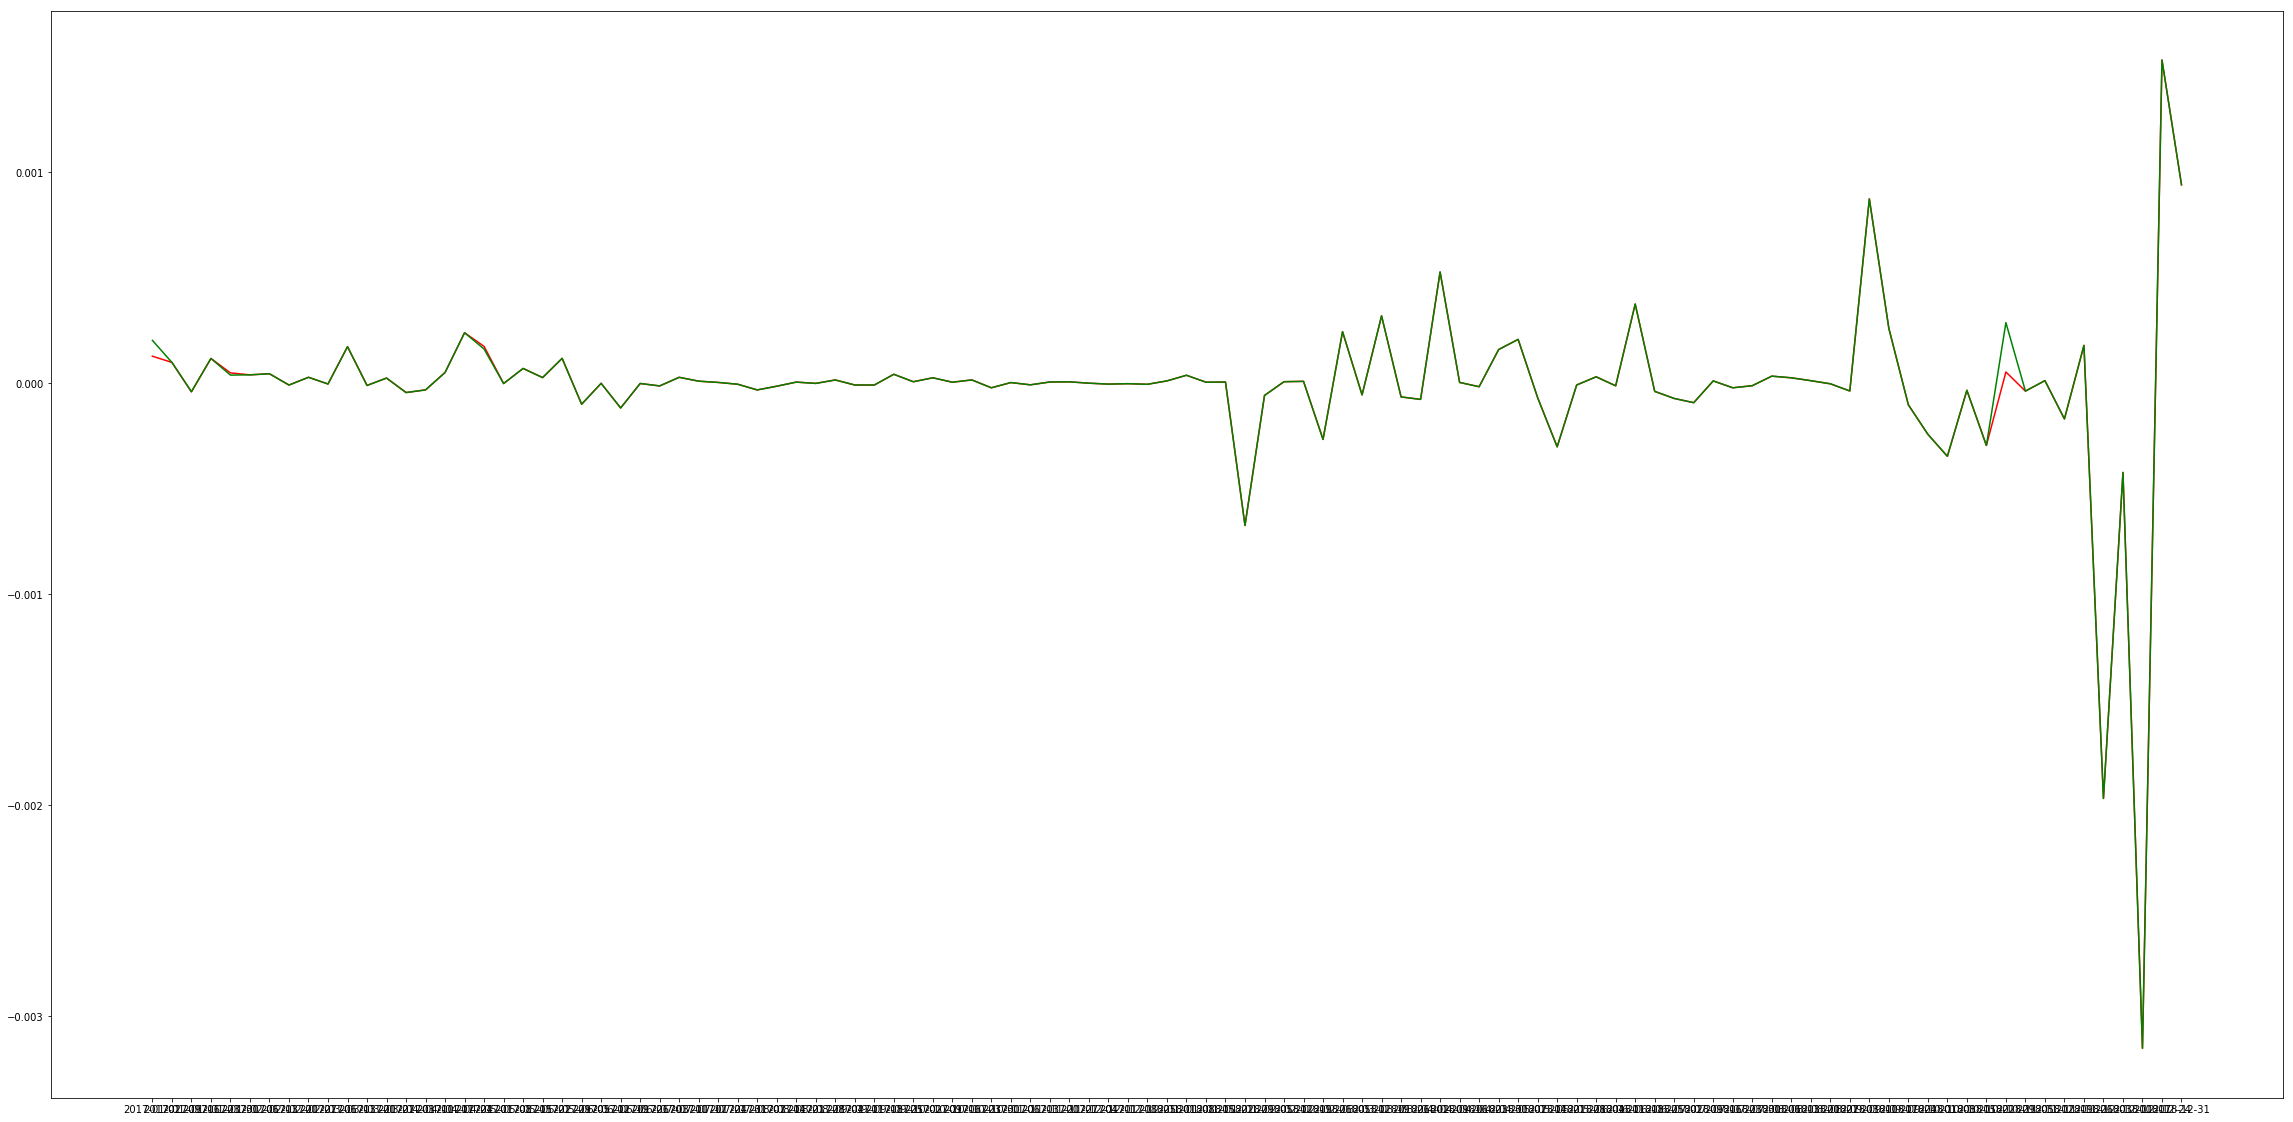

In [27]:
plt.figure(figsize=(40,20))
plt.plot(test,'r')
plt.plot(test01,'g')

In [243]:
print(test.mean(),test01.mean())

0    0.001064
dtype: float64 0    0.000829
dtype: float64
